Transform matrix directly 24 -> 646

- Experiment 1: airnow_NO2 -> tropomi_NO2
    - RMSE: 2.2398749918991006
    - MAE: 1.612470579727315
- Experiment 2: lon, lat, airnow_NO2 -> tropomi_NO2
    - RMSE: 1.8724141465662152
    - MAE: 1.3711940039397177
- Experiment 3: lon, lat, airnow_NO2, ecmwf_blh -> tropomi_NO2
    - RMSE: 1.5254097259627448
    - MAE: 1.0525456254629726
- Experiment 4: lon, lat, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2
    - RMSE: 1.3329550096236276
    - MAE: 0.913545350555278
    
    
# After fixing 7 hours

- Experiment 1: airnow_NO2 -> tropomi_NO2
    - RMSE: 2.7966022570911226, MAE: 1.9363333730284564

- Experiment 2: lon, lat, airnow_NO2 -> tropomi_NO2
    - RMSE: 2.093676018196801
    - MAE: 1.3587448828338067
- Experiment 3: lon, lat, airnow_NO2, ecmwf_blh -> tropomi_NO2
    - RMSE: 1.4813386979298582
    - MAE: 1.0224997272882583
- Experiment 4: lon, lat, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2
    - RMSE: 1.2651010988139928
    - MAE: 0.8661944261352691
- Experiment 5: lon, lat, airnow_NO2, hrrr_blh, and other hrrr variables -> tropomi_NO2
    - 2018-2020： RMSE: 2.57290140201112，MAE: 1.5719577391417967
    - 2018-2019： RMSE: 2.866714319237177，MAE: 1.7026194532818093
- Experiment 6: lon, lat, airnow_NO2, era_blh, and other era variables -> tropomi_NO2
    - 2018-2020：RMSE: 2.180743521424286， MAE: 1.3200619818703692
    - 2018-2019：RMSE: 2.251285375796676, MAE: 1.302558271774617
- Experiment 7: lon, lat, dem, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2
    - RMSE: 1.3315710079128442, MAE: 0.922119679504421
- Exp 8: lon, lat, dem+roads+power plants, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2
    - RMSE: 1.2100801427927868, MAE: 0.8245393728137274

In [1]:
from platform import python_version
from netCDF4 import Dataset
import numpy as np
import os
from os import path, listdir
import pandas as pd
from datetime import datetime, timedelta
import matplotlib
import numpy as np
import pandas as pd
import time
import math
import random
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statistics import mean 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from datetime import datetime, date, timedelta
from prettytable import PrettyTable
from tqdm import tqdm
from torch_geometric.nn import DenseSAGEConv

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap

print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

def RMSE(v, v_):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2))

def MAE(v, v_):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :return: int, MAE averages on all elements of input.
    '''
    return np.mean(np.abs(v_ - v))

python version==3.8.3
pandas==1.1.3
numpy==1.18.1
sklearn==0.23.1
torch==1.5.0
matplotlib==3.2.2


In [2]:
# define new regular grids
minlon, maxlon, minlat, maxlat = -118.7, -117.1, 33.6, 34.5
# new regular grid
xnew = np.arange(minlon, maxlon+0.05, 0.05)
ynew = np.arange(minlat, maxlat+0.05, 0.05)
xxnew, yynew = np.meshgrid(xnew,ynew)

In [3]:
# get NO2 sensors within this LA_bbox
sensors = pd.read_csv('C:\\Users\\yuman\Box\\Publication\\Ongoing Paper\\paper-IOT\\Code\\airnow\\sensors_larger_la_preprocessed.csv', index_col=False, dtype=str)
# sensors.head()

sensors_NO2 = sensors[sensors.para == 'NO2']
sensors_NO2[["longitude", "latitude"]] = sensors_NO2[["longitude", "latitude"]].astype(float)
sensors_NO2 = sensors_NO2[(sensors_NO2.longitude<maxlon) & (sensors_NO2.longitude>minlon) & (sensors_NO2.latitude<maxlat) & (sensors_NO2.latitude>minlat)]
print('Airnow NO2 sensor number: ',sensors_NO2.shape)

Airnow NO2 sensor number:  (24, 5)


## Process X features with ecmwf variables

In [4]:
preprocessed_data_folder = 'G:\\TROPOMI\\preprocessed_nc\\'
nc_files = [file for file in listdir(preprocessed_data_folder)]

vars = ['ECWMF_blh','ECWMF_sp','ECWMF_sshf','ECWMF_ssrc', 'ECWMF_t2m','ECWMF_u10','ECWMF_v10']

tropomi_rows = []
ecmwf_array = np.zeros((len(nc_files),xxnew.shape[0],xxnew.shape[1], len(vars))) # (346, 19, 34, 7)
for fid in range(len(nc_files)):
    fh = Dataset(preprocessed_data_folder+nc_files[fid], mode='r')
    tropomi_NO2_regular_grid = fh.variables['tropomi_NO2_regular_grid'][:]
    
    tropomi_row = list(np.transpose(tropomi_NO2_regular_grid.flatten()))
    tropomi_rows.append(np.array([int(nc_files[fid].split('.')[0].replace('-', '')[:10])]+tropomi_row))
    
    for i in range(len(vars)):
        values = fh.variables[vars[i]][:]
        ecmwf_array[fid,:,:,i] = values

# aggregate all dates into a numpy array
tropomi_np_array = np.array(tropomi_rows)
tropomi_np_array = tropomi_np_array[np.argsort(tropomi_np_array[:, 0])]
np.save('np_array_tropomi', tropomi_np_array)

In [5]:
# transform ecmwf array from 646 nodes to 24 nodes
airnow_original = np.load('np_array_airnow.npy')[:,1:] # (346, 24)

ecmwf_transformed = np.zeros((len(nc_files), sensors_NO2.shape[0], len(vars))) # final shape: (346, 24, 7)

for dt in range(airnow_original.shape[0]):
    
    for i in range(sensors_NO2.shape[0]):

        lon = sensors_NO2.longitude.values[i]
        lat = sensors_NO2.latitude.values[i]

        nearest_lon_idx = (np.abs(xnew - lon)).argmin()
        nearest_lat_idx = (np.abs(ynew - lat)).argmin()

        ecmwf_transformed[dt, i, :] = ecmwf_array[dt, nearest_lat_idx, nearest_lon_idx, :]

## Process X features with hrrr variables

In [ ]:
preprocessed_data_folder = 'G:\\TROPOMI\\preprocessed_nc_airnow_ecmwf_hrrr\\'
nc_files = [file for file in listdir(preprocessed_data_folder)]
vars = ['hrrr_HPBL','hrrr_PRES_surface','hrrr_RH_2_m','hrrr_TMP_2_m',
       'hrrr_UGRD_10_m','hrrr_VGRD_10_m']

tropomi_rows = []
hrrr_array = np.zeros((len(nc_files),xxnew.shape[0],xxnew.shape[1], len(vars))) # (346, 19, 34, 7)
for fid in range(len(nc_files)):
    fh = Dataset(preprocessed_data_folder+nc_files[fid], mode='r')
    tropomi_NO2_regular_grid = fh.variables['tropomi_NO2_regular_grid'][:]
    
    tropomi_row = list(np.transpose(tropomi_NO2_regular_grid.flatten()))
    tropomi_rows.append(np.array([int(nc_files[fid].split('.')[0].replace('-', '')[:10])]+tropomi_row))
    
    for i in range(len(vars)):
        values = fh.variables[vars[i]][:]
        hrrr_array[fid,:,:,i] = values

# aggregate all dates into a numpy array
tropomi_np_array = np.array(tropomi_rows)
tropomi_np_array = tropomi_np_array[np.argsort(tropomi_np_array[:, 0])]
np.save('np_hrrr_tropomi', tropomi_np_array)

In [ ]:
# transform ecmwf array from 646 nodes to 24 nodes
hrrr_transformed = np.zeros((len(nc_files), sensors_NO2.shape[0], len(vars))) # final shape: (346, 24, 7)

for dt in range(tropomi_np_array.shape[0]):
    for i in range(sensors_NO2.shape[0]):
        lon = sensors_NO2.longitude.values[i]
        lat = sensors_NO2.latitude.values[i]

        nearest_lon_idx = (np.abs(xnew - lon)).argmin()
        nearest_lat_idx = (np.abs(ynew - lat)).argmin()

        hrrr_transformed[dt, i, :] = hrrr_array[dt, nearest_lat_idx, nearest_lon_idx, :]

In [ ]:
# extract the airnow values using the datetimes
airnow_NO2 = pd.read_csv('C:\\Users\\yuman\Box\\Publication\\Ongoing Paper\\paper-IOT\\Code\\airnow\\aggr_larger_la_preprocessed.csv', 
                         index_col=False, usecols=list(sensors_NO2.features)+['datetime'])

airnow_original = []
for i in range(tropomi_np_array.shape[0]):
    dt = datetime(year=int(str(int(tropomi_np_array[0,0]))[:4]), 
         month=int(str(int(tropomi_np_array[0,0]))[4:6]),
         day=int(str(int(tropomi_np_array[0,0]))[6:8]),
         hour=int(str(int(tropomi_np_array[0,0]))[8:]))
    airnow_at_matching_time = airnow_NO2[airnow_NO2['datetime']==dt.strftime("%Y-%m-%d %H:%M:%S")]
    airnow_original.append(airnow_at_matching_time)
    
airnow_original = pd.concat(airnow_original, axis=0)
airnow_original = airnow_original.values[:,:-1]

In [ ]:
print('Dataset np_hrrr_tropomi starts from', int(tropomi_np_array[:, 0][0]))
print('Dataset np_hrrr_tropomi ends at', int(tropomi_np_array[:, 0][-1]))
print('tropomi_np_array length:', tropomi_np_array.shape[0])
print('airnow_original length:', airnow_original.shape[0])

## Process X features with era variables

In [ ]:
preprocessed_data_folder = 'G:\\TROPOMI\\preprocessed_nc_airnow_ERA_new\\'
nc_files = [file for file in listdir(preprocessed_data_folder)]
vars = ['ERA_blh','ERA_msl','ERA_sp', 'ERA_t2m','ERA_tp', 
        'ERA_u10','ERA_v10']

tropomi_rows = []
era_array = np.zeros((len(nc_files),xxnew.shape[0],xxnew.shape[1], len(vars))) # (346, 19, 34, 7)
for fid in range(len(nc_files)):
    fh = Dataset(preprocessed_data_folder+nc_files[fid], mode='r')
    tropomi_NO2_regular_grid = fh.variables['tropomi_NO2_regular_grid'][:]
    
    tropomi_row = list(np.transpose(tropomi_NO2_regular_grid.flatten()))
    tropomi_rows.append(np.array([int(nc_files[fid].split('.')[0].replace('-', '')[:10])]+tropomi_row))
    
    for i in range(len(vars)):
        values = fh.variables[vars[i]][:]
        era_array[fid,:,:,i] = values

# aggregate all dates into a numpy array
tropomi_np_array = np.array(tropomi_rows)
tropomi_np_array = tropomi_np_array[np.argsort(tropomi_np_array[:, 0])]
np.save('np_era_tropomi', tropomi_np_array)

In [ ]:
# transform ecmwf array from 646 nodes to 24 nodes
airnow_original = np.load('np_array_airnow_era_new.npy')[:,1:] # (346, 24)

era_transformed = np.zeros((len(nc_files), sensors_NO2.shape[0], len(vars))) # final shape: (346, 24, 7)

for dt in range(airnow_original.shape[0]):
    
    for i in range(sensors_NO2.shape[0]):

        lon = sensors_NO2.longitude.values[i]
        lat = sensors_NO2.latitude.values[i]

        nearest_lon_idx = (np.abs(xnew - lon)).argmin()
        nearest_lat_idx = (np.abs(ynew - lat)).argmin()

        era_transformed[dt, i, :] = era_array[dt, nearest_lat_idx, nearest_lon_idx, :]

# Model

In [6]:
class GraphTransform(Module):
    """
    This is a graph transform layer that is inspired by Kipf's graph convolutional layer. 
    It learns a transformation matrix from N1 nodes to N2 nodes.
    """
    def __init__(self, input_nodes, input_features, output_nodes, bias=True):
        super(GraphTransform, self).__init__()

        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        # Each feature has its own transformation matrix
        self.weight = Parameter(torch.FloatTensor(output_nodes, input_nodes, input_features))

        if bias:
            self.bias = Parameter(torch.FloatTensor(input_features))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):

        output = []
        for feature_index in range(input.shape[1]):
            output.append(torch.mm(self.weight[:, :, feature_index],
                                   input[:, feature_index:(feature_index+1)]))

        output = torch.cat(output, dim=1)

        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return "{} ({} -> {} nodes, {} features)".format(
            self.__class__.__name__, str(self.input_nodes),
            str(self.output_nodes), str(self.weight.shape[2]))

    
class GraphTrans(nn.Module):
    def __init__(self, input_nodes, input_features, output_nodes, hidden_features):
        super(GraphTrans, self).__init__()

        self.GraphTrans = GraphTransform(input_nodes=input_nodes,
                                         input_features=input_features,
                                         output_nodes=output_nodes)
        self.linear1 = nn.Linear(output_nodes * input_features, output_nodes * hidden_features)
        self.linear2 = nn.Linear(output_nodes * hidden_features, output_nodes)
        
        self.dropout = 0

    def forward(self, x):

        x = F.relu(self.GraphTrans(x))
        x = F.relu(self.linear1(x.flatten()))
        x = self.linear2(x)

        return x
    
class GraphTrans_v2(nn.Module):
    def __init__(self, input_nodes, input_features, output_nodes, hidden_features_1, hidden_features_2):
        super(GraphTrans_v2, self).__init__()

        self.GraphTrans = GraphTransform(input_nodes=input_nodes,
                                         input_features=input_features,
                                         output_nodes=output_nodes)
        self.linear1 = nn.Linear(output_nodes * input_features, output_nodes * hidden_features_1)
        self.linear2 = nn.Linear(output_nodes * hidden_features_1, output_nodes* hidden_features_2)
        self.linear3 = nn.Linear(output_nodes * hidden_features_2, output_nodes)
        
        self.dropout = 0

    def forward(self, x):

        x = F.relu(self.GraphTrans(x))
        x = F.relu(self.linear1(x.flatten()))
        x = F.relu(self.linear2(x.flatten()))
        x = self.linear3(x)

        return x

def summary(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param

    print(model)
    print(table)
    print(f"Total Trainable Params: {total_params}")

    return total_params

# Experiment 1: airnow_NO2 -> tropomi_NO2

In [ ]:
features_x = np.load('np_array_airnow.npy')[:,1:]
features_y = tropomi_np_array[:,1:]

# Sanity check
assert features_x.shape[0] == features_y.shape[0], 'X and Y features do not have the same number of samples'

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=False, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = reshape_add_1d(scaler_x.fit_transform(features_x_train))
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = reshape_add_1d(scaler_x.transform(features_x_val))
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

In [ ]:
print(scaled_features_x_train.shape)
print(scaled_features_y_train.shape)

## Train model

In [ ]:
model = GraphTrans(input_nodes=scaled_features_x_train.shape[1],
                                         input_features=1,
                                         output_nodes=scaled_features_y_train.shape[1],
                                         hidden_features=1).to(device)
summary(model)

In [ ]:
epochs = 3000
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index]]
        sample_y = scaled_features_y_train[samples_index[sample_index]]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index]
            sample_y = scaled_features_y_val[sample_index]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Univariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)

print(y_pred.min()/(10**15), y_pred.max()/(10**15))
print(features_y_val.min()/(10**15), features_y_val.max()/(10**15))

print('RMSE:', RMSE(features_y_val, y_pred)/(10**15))
print('MAE:', MAE(features_y_val, y_pred)/(10**15))

In [ ]:
for dt in range(y_pred.shape[0]):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.pcolormesh(xnew, ynew, features_y_val[dt,:].reshape(xxnew.shape))
    ax1.set_aspect('equal')
    ax2.pcolormesh(xnew, ynew, y_pred[dt,:].reshape(xxnew.shape))
    ax2.set_aspect('equal')
    plt.show()
    
    print('RMSE:', RMSE(features_y_val[dt,:], y_pred[dt,:])/(10**15))
    print('MAE:', MAE(features_y_val[dt,:], y_pred[dt,:])/(10**15))

# Experiment 2: lon, lat, airnow_NO2 -> tropomi_NO2

In [ ]:
features_x_geo = np.zeros((features_x.shape[0],features_x.shape[1],3))
features_x_geo[:,:,0] = features_x
for i in range(features_x_geo.shape[0]):
    features_x_geo[i,:,1] = sensors_NO2.longitude.values
    features_x_geo[i,:,2] = sensors_NO2.latitude.values

# features_y_geo = np.zeros((features_y.shape[0],features_y.shape[1],3))
# features_y_geo[:,:,0] = features_y
# for i in range(features_y_geo.shape[0]):
#     features_y_geo[i,:,1] = xxnew.flatten()
#     features_y_geo[i,:,2] = yynew.flatten()
    
features_y_geo = features_y

In [ ]:
# Split features to train/validate
features_x_geo_train, features_x_geo_val, features_y_geo_train, features_y_geo_val = train_test_split(features_x_geo, features_y_geo, test_size=0.3, shuffle=False, random_state=42)
print(features_x_geo_train.shape, features_x_geo_val.shape, features_y_geo_train.shape, features_y_geo_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_geo_x = MinMaxScaler()
scaler_geo_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_geo_train = scale(scaler_geo_x, features_x_geo_train, "fit_transform")
scaled_features_y_geo_train = reshape_add_1d(scaler_geo_y.fit_transform(features_y_geo_train))
scaled_features_x_geo_val = scale(scaler_geo_x, features_x_geo_val, "transform")
scaled_features_y_geo_val = reshape_add_1d(scaler_geo_y.transform(features_y_geo_val))

print(scaled_features_x_geo_train.shape, scaled_features_x_geo_val.shape, scaled_features_y_geo_train.shape, scaled_features_y_geo_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_geo_train = torch.from_numpy(scaled_features_x_geo_train).float().to(device)
scaled_features_x_geo_val = torch.from_numpy(scaled_features_x_geo_val).float().to(device)
scaled_features_y_geo_train = torch.from_numpy(scaled_features_y_geo_train).float().to(device)
scaled_features_y_geo_val = torch.from_numpy(scaled_features_y_geo_val).float().to(device)

In [ ]:
# Define model
model = GraphTrans(input_nodes=scaled_features_x_geo_train.shape[1],
                                 input_features=scaled_features_x_geo_train.shape[2],
                                 output_nodes=scaled_features_y_geo_train.shape[1],
                                 hidden_features=1).to(device)
summary(model)

In [ ]:
epochs = 3000
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_geo_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_geo_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_geo_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_geo_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_geo_val[sample_index,:,:]
            sample_y = scaled_features_y_geo_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_geo_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_geo_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

In [ ]:
# Plot all test data result
rmse_array, mae_array, difference_array = [], [], []

for dt in range(y_pred.shape[0]):
    
    rmse_list, mae_list, difference_list = [], [], []
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    for i in range(y_test_subset.shape[0]):
        rmse_list.append(RMSE(y_test_subset[i], y_pred_subset[i])/(10**15))
        mae_list.append(MAE(y_test_subset[i], y_pred_subset[i])/(10**15))
        difference_list.append((y_pred_subset[i]- y_test_subset[i])/(10**15))
    
    rmse_array.append(rmse_list)
    mae_array.append(mae_list)
    difference_array.append(difference_list)

rmse_array = np.array(rmse_array)
mae_array = np.array(mae_array)
difference_array = np.array(difference_array)

rmse_mean = np.mean(rmse_array, axis=0)
mae_mean = np.mean(mae_array, axis=0)
difference_mean = np.mean(difference_array, axis=0)

############################# Plot the rmse mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(mae_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('RMSE')
plt.show()

############################# Plot the mae mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(rmse_mean.reshape(xxnew.shape)), cmap='coolwarm',vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('MAE')
plt.show()

############################# Plot the difference mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(difference_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=-3,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('Magitude difference')
plt.show()

# Experiment 3: lon, lat, airnow_NO2, ecmwf_blh -> tropomi_NO2

## Prepare x and y

In [ ]:
features_y = tropomi_np_array[:,1:]

features_x = np.zeros((features_y.shape[0],sensors_NO2.shape[0],4))
features_x[:,:,0] = np.load('np_array_airnow.npy')[:,1:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3]=ecmwf_transformed[:,:,0] # blh

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=False, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [ ]:
# Define model
model = GraphTrans(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features=1).to(device)
summary(model)

In [ ]:
epochs = 3000
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

In [ ]:
for dt in range(y_pred.shape[0]):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.pcolormesh(xnew, ynew, features_y_val[dt,:].reshape(xxnew.shape))
    ax1.set_aspect('equal')
    ax2.pcolormesh(xnew, ynew, y_pred[dt,:].reshape(xxnew.shape))
    ax2.set_aspect('equal')
    plt.show()
    
    print('RMSE:', RMSE(features_y_val[dt,:], y_pred[dt,:])/(10**15))
    print('MAE:', MAE(features_y_val[dt,:], y_pred[dt,:])/(10**15))

In [ ]:
# Plot all test data result
rmse_array, mae_array, difference_array = [], [], []

for dt in range(y_pred.shape[0]):
    
    rmse_list, mae_list, difference_list = [], [], []
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    for i in range(y_test_subset.shape[0]):
        rmse_list.append(RMSE(y_test_subset[i], y_pred_subset[i])/(10**15))
        mae_list.append(MAE(y_test_subset[i], y_pred_subset[i])/(10**15))
        difference_list.append((y_pred_subset[i]- y_test_subset[i])/(10**15))
    
    rmse_array.append(rmse_list)
    mae_array.append(mae_list)
    difference_array.append(difference_list)

rmse_array = np.array(rmse_array)
mae_array = np.array(mae_array)
difference_array = np.array(difference_array)

rmse_mean = np.mean(rmse_array, axis=0)
mae_mean = np.mean(mae_array, axis=0)
difference_mean = np.mean(difference_array, axis=0)

############################# Plot the rmse mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(mae_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('RMSE')
plt.show()

############################# Plot the mae mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(rmse_mean.reshape(xxnew.shape)), cmap='coolwarm',vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('MAE')
plt.show()

############################# Plot the difference mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(difference_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=-3,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('Magitude difference')
plt.show()

# Experiment 4: lon, lat, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2

In [ ]:
features_y = tropomi_np_array[:,1:]

features_x = np.zeros((features_y.shape[0],sensors_NO2.shape[0],10))
features_x[:,:,0] = np.load('np_array_airnow.npy')[:,1:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3:]=ecmwf_transformed # all ecmwf variables

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=False, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [ ]:
# Define model
model = GraphTrans_v2(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features_1=10,
                                 hidden_features_2=1).to(device)
summary(model)

In [ ]:
epochs = 1500
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

In [ ]:
# Plot all test data result
rmse_array, mae_array, difference_array = [], [], []

for dt in range(y_pred.shape[0]):
    
    rmse_list, mae_list, difference_list = [], [], []
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    for i in range(y_test_subset.shape[0]):
        rmse_list.append(RMSE(y_test_subset[i], y_pred_subset[i])/(10**15))
        mae_list.append(MAE(y_test_subset[i], y_pred_subset[i])/(10**15))
        difference_list.append((y_pred_subset[i]- y_test_subset[i])/(10**15))
    
    rmse_array.append(rmse_list)
    mae_array.append(mae_list)
    difference_array.append(difference_list)

rmse_array = np.array(rmse_array)
mae_array = np.array(mae_array)
difference_array = np.array(difference_array)

rmse_mean = np.mean(rmse_array, axis=0)
mae_mean = np.mean(mae_array, axis=0)
difference_mean = np.mean(difference_array, axis=0)

############################# Plot the rmse mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(mae_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('RMSE')
plt.show()

############################# Plot the mae mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(rmse_mean.reshape(xxnew.shape)), cmap='coolwarm',vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('MAE')
plt.show()

############################# Plot the difference mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(difference_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=-3,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('Magitude difference')
plt.show()

In [ ]:
# Plot all test data result
for dt in range(20):
    
    print(tropomi_np_array[dt,0])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.pcolormesh(xnew, ynew, features_y_val[dt,:].reshape(xxnew.shape))
    ax1.set_aspect('equal')
    ax2.pcolormesh(xnew, ynew, y_pred[dt,:].reshape(xxnew.shape))
    ax2.set_aspect('equal')
    plt.show()
    
    print('RMSE:', RMSE(features_y_val[dt,:], y_pred[dt,:])/(10**15))
    print('MAE:', MAE(features_y_val[dt,:], y_pred[dt,:])/(10**15))

In [ ]:
# dt = 2019083121

print('RMSE:', RMSE(features_y_val[-1,:], y_pred[-1,:])/(10**15))
print('MAE:', MAE(features_y_val[-1,:], y_pred[-1,:])/(10**15))

# np.save('MT_'+str(dt), y_pred[-2,:].reshape(xxnew.shape))

In [ ]:
# Plot 24 hour features_x predictions
start_day = '20180506'
test_folder = 'C:\\Users\\yuman\\Box\\Publication\\Ongoing Paper\\paper-IOT\\Code\\st_interpolation\\test_folder_24h_'+start_day+'\\'
if not os.path.exists(test_folder):
    os.mkdir(test_folder)

features_x = np.load(test_folder+'features_x_'+start_day+'.npy')

scaled_features_x_test = scale(scaler_x, features_x, "fit_transform")
scaled_features_x_test = torch.from_numpy(scaled_features_x_test).float().to(device)

features_y_pred = []
for dt in range(scaled_features_x_test.shape[0]):
    data = scaled_features_x_test[dt, :, :]
    pred = model(data).detach().cpu().numpy()
    y_pred = scaler_y.inverse_transform(pred.reshape((1, 646))) # scale back
    
    features_y_pred.append(y_pred)
    
    fig, ax = plt.subplots() 
    plt.pcolormesh(xnew, ynew, y_pred.reshape(xxnew.shape))
    ax.set_aspect('equal')
    plt.show()
    
np.save(test_folder+'features_y_pred_'+start_day, np.array(features_y_pred))

In [ ]:
start_day = '20190830'
test_folder = 'C:\\Users\\yuman\\Box\\Publication\\Ongoing Paper\\paper-IOT\\Code\\st_interpolation\\test_folder_24h_'+start_day+'\\'
if not os.path.exists(test_folder):
    os.mkdir(test_folder)
features_x = np.load(test_folder+'features_x_'+start_day+'.npy')

scaled_features_x_test = scale(scaler_x, features_x, "fit_transform")
scaled_features_x_test = torch.from_numpy(scaled_features_x_test).float().to(device)


features_y_pred = []
for dt in range(scaled_features_x_test.shape[0]):
    data = scaled_features_x_test[dt, :, :]
    pred = model(data).detach().cpu().numpy()
    y_pred = scaler_y.inverse_transform(pred.reshape((1, 646))) # scale back
    
    features_y_pred.append(y_pred)
    
    fig, ax = plt.subplots() 
    plt.pcolormesh(xnew, ynew, y_pred.reshape(xxnew.shape))
    ax.set_aspect('equal')
    plt.show()
    
np.save(test_folder+'features_y_pred_'+start_day, np.array(features_y_pred))

# Experiment 5: lon, lat, airnow_NO2, hrrr_blh, and other hrrr variables -> tropomi_NO2

In [7]:
features_y = np.load('np_hrrr_tropomi.npy')[:,1:][:346,:]

# features_x = np.zeros((features_y.shape[0],sensors_NO2.shape[0],9)) 
features_x = np.zeros((346,sensors_NO2.shape[0],9)) 
features_x[:,:,0] = airnow_original[:346,:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3:]=hrrr_transformed[:346,:,:] # all ecmwf variables

NameError: name 'hrrr_transformed' is not defined

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=True, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [ ]:
# Define model
model = GraphTrans_v2(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features_1=scaled_features_x_train.shape[2],
                                 hidden_features_2=1).to(device)
summary(model)

In [ ]:
epochs = 1500
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

In [ ]:
# Plot all test data result
for dt in range(20):
    
    print(tropomi_np_array[dt,0])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.pcolormesh(xnew, ynew, features_y_val[dt,:].reshape(xxnew.shape))
    ax1.set_aspect('equal')
    ax2.pcolormesh(xnew, ynew, y_pred[dt,:].reshape(xxnew.shape))
    ax2.set_aspect('equal')
    plt.show()
    
    print('RMSE:', RMSE(features_y_val[dt,:], y_pred[dt,:])/(10**15))
    print('MAE:', MAE(features_y_val[dt,:], y_pred[dt,:])/(10**15))

# Experiment 6: lon, lat, airnow_NO2, era_blh, and other era variables -> tropomi_NO2

In [ ]:
features_y = tropomi_np_array[:,1:][:346,:]

features_x = np.zeros((346,sensors_NO2.shape[0],10)) 
features_x[:,:,0] = airnow_original[:346,:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3:]=era_transformed[:346,:,:] # all ecmwf variables

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=True, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [ ]:
# Define model
model = GraphTrans_v2(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features_1=scaled_features_x_train.shape[2],
                                 hidden_features_2=1).to(device)
summary(model)

In [ ]:
epochs = 400
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

# Experiment 7: lon, lat, dem, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2

## Process X features with dem and ecmwf variables

In [ ]:
preprocessed_data_folder = 'G:\\TROPOMI\\preprocessed_nc\\'
nc_files = [file for file in listdir(preprocessed_data_folder)]

vars = ['ECWMF_blh','ECWMF_sp','ECWMF_sshf','ECWMF_ssrc', 'ECWMF_t2m','ECWMF_u10','ECWMF_v10']

tropomi_rows = []
ecmwf_array = np.zeros((len(nc_files),xxnew.shape[0],xxnew.shape[1], len(vars))) # (346, 19, 34, 7)
for fid in range(len(nc_files)):
    fh = Dataset(preprocessed_data_folder+nc_files[fid], mode='r')
    tropomi_NO2_regular_grid = fh.variables['tropomi_NO2_regular_grid'][:]
    
    tropomi_row = list(np.transpose(tropomi_NO2_regular_grid.flatten()))
    tropomi_rows.append(np.array([int(nc_files[fid].split('.')[0].replace('-', '')[:10])]+tropomi_row))
    
    for i in range(len(vars)):
        values = fh.variables[vars[i]][:]
        ecmwf_array[fid,:,:,i] = values

# aggregate all dates into a numpy array
tropomi_np_array = np.array(tropomi_rows)
tropomi_np_array = tropomi_np_array[np.argsort(tropomi_np_array[:, 0])]
np.save('np_array_tropomi', tropomi_np_array)

In [ ]:
# transform ecmwf array from 646 nodes to 24 nodes
airnow_original = np.load('np_array_airnow.npy')[:,1:] # (346, 24)
dem = np.load('dem_LA.npy')

ecmwf_transformed = np.zeros((len(nc_files), sensors_NO2.shape[0], len(vars)+1)) # final shape: (346, 24, 7+dem)

for dt in range(airnow_original.shape[0]):
    
    for i in range(sensors_NO2.shape[0]):

        lon = sensors_NO2.longitude.values[i]
        lat = sensors_NO2.latitude.values[i]

        nearest_lon_idx = (np.abs(xnew - lon)).argmin()
        nearest_lat_idx = (np.abs(ynew - lat)).argmin()

        ecmwf_transformed[dt, i, :len(vars)] = ecmwf_array[dt, nearest_lat_idx, nearest_lon_idx, :]
        ecmwf_transformed[dt, i, -1] = dem[nearest_lat_idx, nearest_lon_idx]

In [ ]:
features_y = tropomi_np_array[:,1:]

features_x = np.zeros((features_y.shape[0],sensors_NO2.shape[0],11))
features_x[:,:,0] = np.load('np_array_airnow.npy')[:,1:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3:]=ecmwf_transformed # all ecmwf variables

In [ ]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=False, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

In [ ]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [ ]:
# Define model
model = GraphTrans_v2(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features_1=10,
                                 hidden_features_2=1).to(device)
summary(model)

In [ ]:
epochs = 1500
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

In [ ]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [ ]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

In [ ]:
# Plot all test data result
rmse_array, mae_array, difference_array = [], [], []

for dt in range(y_pred.shape[0]):
    
    rmse_list, mae_list, difference_list = [], [], []
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    for i in range(y_test_subset.shape[0]):
        rmse_list.append(RMSE(y_test_subset[i], y_pred_subset[i])/(10**15))
        mae_list.append(MAE(y_test_subset[i], y_pred_subset[i])/(10**15))
        difference_list.append((y_pred_subset[i]- y_test_subset[i])/(10**15))
    
    rmse_array.append(rmse_list)
    mae_array.append(mae_list)
    difference_array.append(difference_list)

rmse_array = np.array(rmse_array)
mae_array = np.array(mae_array)
difference_array = np.array(difference_array)

rmse_mean = np.mean(rmse_array, axis=0)
mae_mean = np.mean(mae_array, axis=0)
difference_mean = np.mean(difference_array, axis=0)

############################# Plot the rmse mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(mae_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('RMSE')
plt.show()

############################# Plot the mae mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(rmse_mean.reshape(xxnew.shape)), cmap='coolwarm',vmin=0,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('MAE')
plt.show()

############################# Plot the difference mean
plt.figure(figsize=(10,5),dpi=600)

# largler LA region bounding box
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
            resolution='h',projection='cyl',\
            lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
xi, yi = m(xnew, ynew)

# Plot Data
sc = m.pcolor(xi,yi,np.squeeze(difference_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=-3,vmax=3)

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawcounties()

# Add Colorbar
no2_units = 'mole cm-2'
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('Magitude difference')
plt.show()

# Experiment 8: lon, lat, dem+roads+power plants, airnow_NO2, ecmwf_blh, and other ecmwf variables -> tropomi_NO2

## Process X features with dem+roads+power plants and ecmwf variables

In [8]:
preprocessed_data_folder = 'G:\\TROPOMI\\preprocessed_nc\\'
nc_files = [file for file in listdir(preprocessed_data_folder)]

vars = ['ECWMF_blh','ECWMF_sp','ECWMF_sshf','ECWMF_ssrc', 'ECWMF_t2m','ECWMF_u10','ECWMF_v10']

tropomi_rows = []
ecmwf_array = np.zeros((len(nc_files),xxnew.shape[0],xxnew.shape[1], len(vars))) # (346, 19, 34, 7)
for fid in range(len(nc_files)):
    fh = Dataset(preprocessed_data_folder+nc_files[fid], mode='r')
    tropomi_NO2_regular_grid = fh.variables['tropomi_NO2_regular_grid'][:]
    
    tropomi_row = list(np.transpose(tropomi_NO2_regular_grid.flatten()))
    tropomi_rows.append(np.array([int(nc_files[fid].split('.')[0].replace('-', '')[:10])]+tropomi_row))
    
    for i in range(len(vars)):
        values = fh.variables[vars[i]][:]
        ecmwf_array[fid,:,:,i] = values

# aggregate all dates into a numpy array
tropomi_np_array = np.array(tropomi_rows)
tropomi_np_array = tropomi_np_array[np.argsort(tropomi_np_array[:, 0])]
np.save('np_array_tropomi', tropomi_np_array)

In [9]:
# transform ecmwf array from 646 nodes to 24 nodes
airnow_original = np.load('np_array_airnow.npy')[:,1:] # (346, 24)

dem_new = np.load('dem_LA.npy')
roads_new = np.load('roads_LA.npy')
power_plants_new = np.load('power_plants_LA.npy')

ecmwf_transformed = np.zeros((len(nc_files), sensors_NO2.shape[0], len(vars)+3)) # final shape: (346, 24, 7+dem)

for dt in range(airnow_original.shape[0]):
    
    for i in range(sensors_NO2.shape[0]):

        lon = sensors_NO2.longitude.values[i]
        lat = sensors_NO2.latitude.values[i]

        nearest_lon_idx = (np.abs(xnew - lon)).argmin()
        nearest_lat_idx = (np.abs(ynew - lat)).argmin()

        ecmwf_transformed[dt, i, :len(vars)] = ecmwf_array[dt, nearest_lat_idx, nearest_lon_idx, :]
        ecmwf_transformed[dt, i, -3] = dem_new[nearest_lat_idx, nearest_lon_idx]
        ecmwf_transformed[dt, i, -2] = roads_new[nearest_lat_idx, nearest_lon_idx]
        ecmwf_transformed[dt, i, -1] = power_plants_new[nearest_lat_idx, nearest_lon_idx]

In [10]:
features_y = tropomi_np_array[:,1:]

features_x = np.zeros((features_y.shape[0],sensors_NO2.shape[0],13))
features_x[:,:,0] = np.load('np_array_airnow.npy')[:,1:]
for i in range(features_x.shape[1]):
    features_x[i,:,1] = sensors_NO2.longitude.values[i]
    features_x[i,:,2] = sensors_NO2.latitude.values[i]
features_x[:,:,3:]=ecmwf_transformed # all ecmwf variables

In [11]:
# Split features to train/validate
features_x_train, features_x_val, features_y_train, features_y_val = train_test_split(features_x, features_y, test_size=0.3, shuffle=False, random_state=42)
print(features_x_train.shape, features_x_val.shape, features_y_train.shape, features_y_val.shape)

# Scaler functions
def scale(scaler, array_3d, method):

    # Sanity check
    assert len(array_3d.shape) == 3

    # Preserve the original dimensions
    dim0, dim1, dim2 = array_3d.shape

    # Reshape 3D to 2D and scale the reshaped array
    if method is "fit_transform":
        scaled_array = scaler.fit_transform(array_3d.reshape(dim0 * dim1, dim2))
    elif method is "transform":
        scaled_array = scaler.transform(array_3d.reshape(dim0 * dim1, dim2))
    else:
        raise Exception("Unrecognized method '{}'".format(method))

    # Reshape 2D to 3D and return
    return scaled_array.reshape((dim0, dim1, dim2))

def reshape_add_1d(array):
    array = array.reshape(array.shape[0], array.shape[1], 1)
    return array

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scaler function parameters on training data and apply the functions on validation data
scaled_features_x_train = scale(scaler_x, features_x_train, "fit_transform")
scaled_features_y_train = reshape_add_1d(scaler_y.fit_transform(features_y_train))
scaled_features_x_val = scale(scaler_x, features_x_val, "transform")
scaled_features_y_val = reshape_add_1d(scaler_y.transform(features_y_val))

print(scaled_features_x_train.shape, scaled_features_x_val.shape, scaled_features_y_train.shape, scaled_features_y_val.shape)

(242, 24, 13) (104, 24, 13) (242, 646) (104, 646)
(242, 24, 13) (104, 24, 13) (242, 646, 1) (104, 646, 1)


In [12]:
# Determine which device to use
device = torch.device('cuda')

# Move numpy arrays to the device
scaled_features_x_train = torch.from_numpy(scaled_features_x_train).float().to(device)
scaled_features_x_val = torch.from_numpy(scaled_features_x_val).float().to(device)
scaled_features_y_train = torch.from_numpy(scaled_features_y_train).float().to(device)
scaled_features_y_val = torch.from_numpy(scaled_features_y_val).float().to(device)

## Train model

In [13]:
# Define model
model = GraphTrans_v2(input_nodes=scaled_features_x_train.shape[1],
                                 input_features=scaled_features_x_train.shape[2],
                                 output_nodes=scaled_features_y_train.shape[1],
                                 hidden_features_1=10,
                                 hidden_features_2=1).to(device)
summary(model)

GraphTrans_v2(
  (GraphTrans): GraphTransform (24 -> 646 nodes, 13 features)
  (linear1): Linear(in_features=8398, out_features=6460, bias=True)
  (linear2): Linear(in_features=6460, out_features=646, bias=True)
  (linear3): Linear(in_features=646, out_features=646, bias=True)
)
+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| GraphTrans.weight |   201552   |
|  GraphTrans.bias  |     13     |
|   linear1.weight  |  54251080  |
|    linear1.bias   |    6460    |
|   linear2.weight  |  4173160   |
|    linear2.bias   |    646     |
|   linear3.weight  |   417316   |
|    linear3.bias   |    646     |
+-------------------+------------+
Total Trainable Params: 59050873


59050873

In [14]:
epochs = 1500
loss_func = nn.MSELoss()
LEARNING_RATE = 0.005
MOMENTUM = 0.9

# Define a message template
msg_template = 'Epoch #{: >3}/{: <3}: [train loss mean {:.4} std {:.4}] [validate loss mean {:.4} std {:.4}]'

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

predictions_list = []
train_loss_list, validate_loss_list = [],[]
                                   
# Model training and validation
for epoch in range(epochs):
    
    # Train the model for one epoch
    # Turn on the model training mode
    model.train()
    
    # Initialize a loss list
    train_loss = []
    num_samples = scaled_features_x_train.shape[0]
    
    samples_index = list(range(num_samples))
    
    for sample_index in tqdm(range(num_samples)):
        
        # Get sample
        sample_x = scaled_features_x_train[samples_index[sample_index],:,:]
        sample_y = scaled_features_y_train[samples_index[sample_index],:,0]
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(sample_x)
        
        # Calculate the reconstruction loss
        loss = loss_func(y_hat, sample_y)
        
        # Back propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Append loss
        train_loss.append(loss.item())
        
    # Calculate the validation loss
    # Turn on the evaluation mode
    model.eval()
    
    # Initialize a loss list and a list for predictions
    validate_loss = []
    predictions = []
    num_samples = scaled_features_x_val.shape[0]
    
    with torch.no_grad():
        for sample_index in tqdm(range(num_samples)):
            
            # Get sample
            sample_x = scaled_features_x_val[sample_index,:,:]
            sample_y = scaled_features_y_val[sample_index,:,0]
            
            # Forward propagation
            y_hat = model(sample_x)
            
            # Calculate loss
            loss = loss_func(y_hat, sample_y).item()
            
            # Append results
            predictions.append(y_hat.detach().cpu().numpy().reshape(1,scaled_features_y_val.shape[1]))
            validate_loss.append(loss)
    
    predictions_list.append(predictions)
    train_loss_list.append(np.mean(train_loss))
    validate_loss_list.append(np.mean(validate_loss))
    
    # Print progress message
    print('Multivariate GTN', msg_template.format(
    epoch + 1, int(epochs), np.mean(train_loss), np.std(train_loss),
    np.mean(validate_loss), np.std(validate_loss)))

  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #  1/1500: [train loss mean 0.05356 std 0.05244] [validate loss mean 0.01295 std 0.003854]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #  2/1500: [train loss mean 0.02242 std 0.02518] [validate loss mean 0.01069 std 0.004389]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #  3/1500: [train loss mean 0.02117 std 0.02452] [validate loss mean 0.01046 std 0.004308]


  3%|▎         | 7/242 [00:00<00:03, 62.14it/s]

Multivariate GTN Epoch #  4/1500: [train loss mean 0.02078 std 0.02405] [validate loss mean 0.01022 std 0.004221]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #  5/1500: [train loss mean 0.02038 std 0.02359] [validate loss mean 0.009928 std 0.00413]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #  6/1500: [train loss mean 0.01999 std 0.02311] [validate loss mean 0.009627 std 0.004043]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #  7/1500: [train loss mean 0.01958 std 0.02263] [validate loss mean 0.009307 std 0.003958]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #  8/1500: [train loss mean 0.01916 std 0.02214] [validate loss mean 0.00897 std 0.003877]


  3%|▎         | 7/242 [00:00<00:03, 59.98it/s]

Multivariate GTN Epoch #  9/1500: [train loss mean 0.01874 std 0.02165] [validate loss mean 0.008632 std 0.003809]


  3%|▎         | 7/242 [00:00<00:03, 63.35it/s]

Multivariate GTN Epoch # 10/1500: [train loss mean 0.01832 std 0.02117] [validate loss mean 0.008294 std 0.003755]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch # 11/1500: [train loss mean 0.0179 std 0.02069] [validate loss mean 0.007989 std 0.003723]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch # 12/1500: [train loss mean 0.01749 std 0.02023] [validate loss mean 0.007719 std 0.003711]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch # 13/1500: [train loss mean 0.0171 std 0.01979] [validate loss mean 0.007498 std 0.003722]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch # 14/1500: [train loss mean 0.01672 std 0.01937] [validate loss mean 0.007325 std 0.003755]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch # 15/1500: [train loss mean 0.01637 std 0.01898] [validate loss mean 0.007215 std 0.003811]


  3%|▎         | 7/242 [00:00<00:03, 64.05it/s]

Multivariate GTN Epoch # 16/1500: [train loss mean 0.01605 std 0.01862] [validate loss mean 0.007147 std 0.003885]


  3%|▎         | 7/242 [00:00<00:03, 61.72it/s]

Multivariate GTN Epoch # 17/1500: [train loss mean 0.01576 std 0.01828] [validate loss mean 0.007114 std 0.003971]


  3%|▎         | 7/242 [00:00<00:03, 62.24it/s]

Multivariate GTN Epoch # 18/1500: [train loss mean 0.01549 std 0.01797] [validate loss mean 0.00712 std 0.004069]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch # 19/1500: [train loss mean 0.01525 std 0.01769] [validate loss mean 0.007164 std 0.004179]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 20/1500: [train loss mean 0.01503 std 0.01743] [validate loss mean 0.007209 std 0.004285]


  3%|▎         | 7/242 [00:00<00:03, 64.11it/s]

Multivariate GTN Epoch # 21/1500: [train loss mean 0.01484 std 0.0172] [validate loss mean 0.007254 std 0.004385]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch # 22/1500: [train loss mean 0.01468 std 0.01699] [validate loss mean 0.007282 std 0.004468]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch # 23/1500: [train loss mean 0.01452 std 0.0168] [validate loss mean 0.007287 std 0.004531]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch # 24/1500: [train loss mean 0.01439 std 0.01663] [validate loss mean 0.007279 std 0.004579]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 25/1500: [train loss mean 0.01427 std 0.01647] [validate loss mean 0.007242 std 0.004604]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch # 26/1500: [train loss mean 0.01415 std 0.01634] [validate loss mean 0.007167 std 0.004599]


  3%|▎         | 7/242 [00:00<00:03, 62.81it/s]

Multivariate GTN Epoch # 27/1500: [train loss mean 0.01404 std 0.01621] [validate loss mean 0.00708 std 0.00458]


  3%|▎         | 7/242 [00:00<00:03, 62.46it/s]

Multivariate GTN Epoch # 28/1500: [train loss mean 0.01394 std 0.01609] [validate loss mean 0.006972 std 0.004547]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 29/1500: [train loss mean 0.01385 std 0.01599] [validate loss mean 0.006851 std 0.004502]


  3%|▎         | 7/242 [00:00<00:03, 62.71it/s]

Multivariate GTN Epoch # 30/1500: [train loss mean 0.01376 std 0.01588] [validate loss mean 0.006733 std 0.004458]


  3%|▎         | 7/242 [00:00<00:03, 63.12it/s]

Multivariate GTN Epoch # 31/1500: [train loss mean 0.01368 std 0.01579] [validate loss mean 0.006593 std 0.004402]


  3%|▎         | 7/242 [00:00<00:03, 62.89it/s]

Multivariate GTN Epoch # 32/1500: [train loss mean 0.01359 std 0.0157] [validate loss mean 0.006455 std 0.004344]


  3%|▎         | 7/242 [00:00<00:03, 64.49it/s]

Multivariate GTN Epoch # 33/1500: [train loss mean 0.01352 std 0.01561] [validate loss mean 0.006314 std 0.004284]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 34/1500: [train loss mean 0.01344 std 0.01553] [validate loss mean 0.006177 std 0.004228]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch # 35/1500: [train loss mean 0.01336 std 0.01545] [validate loss mean 0.00604 std 0.004174]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch # 36/1500: [train loss mean 0.01329 std 0.01537] [validate loss mean 0.005909 std 0.004126]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch # 37/1500: [train loss mean 0.01322 std 0.01529] [validate loss mean 0.005783 std 0.004079]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch # 38/1500: [train loss mean 0.01316 std 0.01521] [validate loss mean 0.005659 std 0.004036]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch # 39/1500: [train loss mean 0.01309 std 0.01513] [validate loss mean 0.005543 std 0.004002]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch # 40/1500: [train loss mean 0.01303 std 0.01506] [validate loss mean 0.005438 std 0.003975]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch # 41/1500: [train loss mean 0.01297 std 0.01498] [validate loss mean 0.005339 std 0.003953]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch # 42/1500: [train loss mean 0.01291 std 0.01491] [validate loss mean 0.005252 std 0.00394]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 43/1500: [train loss mean 0.01285 std 0.01483] [validate loss mean 0.005179 std 0.003936]


  3%|▎         | 7/242 [00:00<00:03, 59.96it/s]

Multivariate GTN Epoch # 44/1500: [train loss mean 0.0128 std 0.01476] [validate loss mean 0.005113 std 0.003936]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch # 45/1500: [train loss mean 0.01275 std 0.01469] [validate loss mean 0.005052 std 0.003941]


  3%|▎         | 7/242 [00:00<00:03, 67.39it/s]

Multivariate GTN Epoch # 46/1500: [train loss mean 0.0127 std 0.01461] [validate loss mean 0.005007 std 0.003952]


  3%|▎         | 7/242 [00:00<00:03, 63.10it/s]

Multivariate GTN Epoch # 47/1500: [train loss mean 0.01265 std 0.01454] [validate loss mean 0.004967 std 0.003967]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch # 48/1500: [train loss mean 0.01261 std 0.01447] [validate loss mean 0.004935 std 0.003987]


  3%|▎         | 7/242 [00:00<00:03, 65.51it/s]

Multivariate GTN Epoch # 49/1500: [train loss mean 0.01256 std 0.0144] [validate loss mean 0.004912 std 0.004012]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch # 50/1500: [train loss mean 0.01252 std 0.01433] [validate loss mean 0.004894 std 0.004038]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch # 51/1500: [train loss mean 0.01248 std 0.01427] [validate loss mean 0.004886 std 0.004069]


  3%|▎         | 7/242 [00:00<00:03, 62.40it/s]

Multivariate GTN Epoch # 52/1500: [train loss mean 0.01244 std 0.0142] [validate loss mean 0.004882 std 0.004101]


  3%|▎         | 7/242 [00:00<00:03, 62.04it/s]

Multivariate GTN Epoch # 53/1500: [train loss mean 0.0124 std 0.01414] [validate loss mean 0.004888 std 0.004137]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 54/1500: [train loss mean 0.01236 std 0.01408] [validate loss mean 0.004896 std 0.004174]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch # 55/1500: [train loss mean 0.01233 std 0.01401] [validate loss mean 0.004907 std 0.004208]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch # 56/1500: [train loss mean 0.01229 std 0.01395] [validate loss mean 0.004922 std 0.004244]


  3%|▎         | 7/242 [00:00<00:03, 62.01it/s]

Multivariate GTN Epoch # 57/1500: [train loss mean 0.01226 std 0.0139] [validate loss mean 0.004938 std 0.00428]


  3%|▎         | 7/242 [00:00<00:03, 64.41it/s]

Multivariate GTN Epoch # 58/1500: [train loss mean 0.01222 std 0.01384] [validate loss mean 0.00496 std 0.004316]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch # 59/1500: [train loss mean 0.01219 std 0.01378] [validate loss mean 0.004984 std 0.004351]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 60/1500: [train loss mean 0.01216 std 0.01373] [validate loss mean 0.005008 std 0.004383]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch # 61/1500: [train loss mean 0.01213 std 0.01367] [validate loss mean 0.00503 std 0.004412]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch # 62/1500: [train loss mean 0.01209 std 0.01362] [validate loss mean 0.005057 std 0.004439]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 63/1500: [train loss mean 0.01206 std 0.01357] [validate loss mean 0.005084 std 0.004464]


  3%|▎         | 7/242 [00:00<00:03, 64.01it/s]

Multivariate GTN Epoch # 64/1500: [train loss mean 0.01203 std 0.01351] [validate loss mean 0.005107 std 0.004486]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch # 65/1500: [train loss mean 0.012 std 0.01346] [validate loss mean 0.005134 std 0.004504]


  3%|▎         | 7/242 [00:00<00:03, 62.15it/s]

Multivariate GTN Epoch # 66/1500: [train loss mean 0.01196 std 0.01341] [validate loss mean 0.005157 std 0.004518]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch # 67/1500: [train loss mean 0.01193 std 0.01336] [validate loss mean 0.005176 std 0.00453]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch # 68/1500: [train loss mean 0.01189 std 0.01331] [validate loss mean 0.005195 std 0.004537]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch # 69/1500: [train loss mean 0.01185 std 0.01325] [validate loss mean 0.005213 std 0.004542]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch # 70/1500: [train loss mean 0.01182 std 0.01319] [validate loss mean 0.005228 std 0.00454]


  3%|▎         | 7/242 [00:00<00:03, 62.04it/s]

Multivariate GTN Epoch # 71/1500: [train loss mean 0.01178 std 0.01313] [validate loss mean 0.005243 std 0.004534]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch # 72/1500: [train loss mean 0.01174 std 0.01307] [validate loss mean 0.005257 std 0.004526]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch # 73/1500: [train loss mean 0.0117 std 0.01302] [validate loss mean 0.005265 std 0.004513]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch # 74/1500: [train loss mean 0.01166 std 0.01296] [validate loss mean 0.005273 std 0.004497]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch # 75/1500: [train loss mean 0.01161 std 0.0129] [validate loss mean 0.005275 std 0.004476]


  3%|▎         | 7/242 [00:00<00:03, 64.36it/s]

Multivariate GTN Epoch # 76/1500: [train loss mean 0.01157 std 0.01283] [validate loss mean 0.005278 std 0.004454]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch # 77/1500: [train loss mean 0.01152 std 0.01277] [validate loss mean 0.005275 std 0.004427]


  3%|▎         | 7/242 [00:00<00:03, 67.50it/s]

Multivariate GTN Epoch # 78/1500: [train loss mean 0.01148 std 0.01271] [validate loss mean 0.005267 std 0.004397]


  3%|▎         | 8/242 [00:00<00:03, 72.27it/s]

Multivariate GTN Epoch # 79/1500: [train loss mean 0.01143 std 0.01266] [validate loss mean 0.005259 std 0.004365]


  6%|▌         | 14/242 [00:00<00:03, 67.04it/s]

Multivariate GTN Epoch # 80/1500: [train loss mean 0.01139 std 0.0126] [validate loss mean 0.005245 std 0.004329]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch # 81/1500: [train loss mean 0.01134 std 0.01254] [validate loss mean 0.005226 std 0.004291]


  6%|▌         | 14/242 [00:00<00:03, 67.02it/s]

Multivariate GTN Epoch # 82/1500: [train loss mean 0.0113 std 0.01248] [validate loss mean 0.005208 std 0.004252]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch # 83/1500: [train loss mean 0.01125 std 0.01243] [validate loss mean 0.005184 std 0.004211]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch # 84/1500: [train loss mean 0.01121 std 0.01237] [validate loss mean 0.005151 std 0.00417]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 85/1500: [train loss mean 0.01117 std 0.01232] [validate loss mean 0.00512 std 0.004128]


  5%|▌         | 13/242 [00:00<00:03, 60.40it/s]

Multivariate GTN Epoch # 86/1500: [train loss mean 0.01113 std 0.01227] [validate loss mean 0.005081 std 0.004084]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch # 87/1500: [train loss mean 0.01109 std 0.01222] [validate loss mean 0.00504 std 0.004039]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch # 88/1500: [train loss mean 0.01105 std 0.01217] [validate loss mean 0.004996 std 0.003994]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 89/1500: [train loss mean 0.01102 std 0.01213] [validate loss mean 0.004949 std 0.003948]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch # 90/1500: [train loss mean 0.01099 std 0.01209] [validate loss mean 0.004903 std 0.003904]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch # 91/1500: [train loss mean 0.01096 std 0.01205] [validate loss mean 0.004853 std 0.00386]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch # 92/1500: [train loss mean 0.01093 std 0.012] [validate loss mean 0.004803 std 0.003818]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch # 93/1500: [train loss mean 0.0109 std 0.01197] [validate loss mean 0.004752 std 0.003778]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch # 94/1500: [train loss mean 0.01088 std 0.01193] [validate loss mean 0.004704 std 0.00374]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch # 95/1500: [train loss mean 0.01086 std 0.0119] [validate loss mean 0.004657 std 0.003704]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch # 96/1500: [train loss mean 0.01084 std 0.01186] [validate loss mean 0.004612 std 0.003672]


  6%|▌         | 14/242 [00:00<00:03, 66.40it/s]

Multivariate GTN Epoch # 97/1500: [train loss mean 0.01082 std 0.01183] [validate loss mean 0.004572 std 0.003644]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch # 98/1500: [train loss mean 0.01081 std 0.0118] [validate loss mean 0.004537 std 0.003623]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch # 99/1500: [train loss mean 0.01079 std 0.01178] [validate loss mean 0.004506 std 0.003607]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #100/1500: [train loss mean 0.01078 std 0.01175] [validate loss mean 0.004481 std 0.003596]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #101/1500: [train loss mean 0.01077 std 0.01173] [validate loss mean 0.004462 std 0.003591]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #102/1500: [train loss mean 0.01075 std 0.0117] [validate loss mean 0.004451 std 0.003591]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #103/1500: [train loss mean 0.01074 std 0.01168] [validate loss mean 0.004445 std 0.003595]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #104/1500: [train loss mean 0.01073 std 0.01166] [validate loss mean 0.004447 std 0.003605]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #105/1500: [train loss mean 0.01072 std 0.01164] [validate loss mean 0.004453 std 0.003618]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #106/1500: [train loss mean 0.01071 std 0.01162] [validate loss mean 0.004465 std 0.003636]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #107/1500: [train loss mean 0.0107 std 0.0116] [validate loss mean 0.004482 std 0.003656]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #108/1500: [train loss mean 0.01069 std 0.01158] [validate loss mean 0.004505 std 0.00368]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #109/1500: [train loss mean 0.01068 std 0.01157] [validate loss mean 0.004527 std 0.003703]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #110/1500: [train loss mean 0.01067 std 0.01155] [validate loss mean 0.004558 std 0.003731]


  3%|▎         | 7/242 [00:00<00:03, 67.47it/s]

Multivariate GTN Epoch #111/1500: [train loss mean 0.01066 std 0.01153] [validate loss mean 0.004588 std 0.003756]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #112/1500: [train loss mean 0.01065 std 0.01151] [validate loss mean 0.004623 std 0.003785]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #113/1500: [train loss mean 0.01063 std 0.0115] [validate loss mean 0.004652 std 0.003808]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #114/1500: [train loss mean 0.01062 std 0.01148] [validate loss mean 0.004688 std 0.003836]


  3%|▎         | 7/242 [00:00<00:03, 66.82it/s]

Multivariate GTN Epoch #115/1500: [train loss mean 0.0106 std 0.01146] [validate loss mean 0.004718 std 0.003858]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #116/1500: [train loss mean 0.01059 std 0.01144] [validate loss mean 0.004752 std 0.003885]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #117/1500: [train loss mean 0.01057 std 0.01142] [validate loss mean 0.004779 std 0.003905]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #118/1500: [train loss mean 0.01055 std 0.0114] [validate loss mean 0.004805 std 0.003925]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #119/1500: [train loss mean 0.01053 std 0.01138] [validate loss mean 0.004828 std 0.003941]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #120/1500: [train loss mean 0.01051 std 0.01136] [validate loss mean 0.004846 std 0.003955]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #121/1500: [train loss mean 0.01049 std 0.01134] [validate loss mean 0.004865 std 0.003969]


  3%|▎         | 7/242 [00:00<00:03, 69.51it/s]

Multivariate GTN Epoch #122/1500: [train loss mean 0.01047 std 0.01132] [validate loss mean 0.004876 std 0.003977]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #123/1500: [train loss mean 0.01045 std 0.0113] [validate loss mean 0.00489 std 0.003988]


  3%|▎         | 7/242 [00:00<00:03, 68.12it/s]

Multivariate GTN Epoch #124/1500: [train loss mean 0.01043 std 0.01128] [validate loss mean 0.004896 std 0.003993]


  3%|▎         | 7/242 [00:00<00:03, 66.23it/s]

Multivariate GTN Epoch #125/1500: [train loss mean 0.01041 std 0.01126] [validate loss mean 0.004899 std 0.003995]


  6%|▌         | 14/242 [00:00<00:03, 69.07it/s]

Multivariate GTN Epoch #126/1500: [train loss mean 0.01038 std 0.01123] [validate loss mean 0.004899 std 0.003997]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #127/1500: [train loss mean 0.01036 std 0.01121] [validate loss mean 0.004893 std 0.003993]


  3%|▎         | 7/242 [00:00<00:03, 67.51it/s]

Multivariate GTN Epoch #128/1500: [train loss mean 0.01033 std 0.01119] [validate loss mean 0.004884 std 0.003987]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #129/1500: [train loss mean 0.01031 std 0.01117] [validate loss mean 0.004873 std 0.003981]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #130/1500: [train loss mean 0.01029 std 0.01115] [validate loss mean 0.004856 std 0.003971]


  3%|▎         | 7/242 [00:00<00:03, 67.47it/s]

Multivariate GTN Epoch #131/1500: [train loss mean 0.01026 std 0.01112] [validate loss mean 0.004838 std 0.003959]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #132/1500: [train loss mean 0.01024 std 0.0111] [validate loss mean 0.004816 std 0.003943]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #133/1500: [train loss mean 0.01022 std 0.01108] [validate loss mean 0.004789 std 0.003927]


  3%|▎         | 7/242 [00:00<00:03, 67.46it/s]

Multivariate GTN Epoch #134/1500: [train loss mean 0.01019 std 0.01106] [validate loss mean 0.004764 std 0.00391]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #135/1500: [train loss mean 0.01017 std 0.01103] [validate loss mean 0.004735 std 0.003891]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #136/1500: [train loss mean 0.01015 std 0.01101] [validate loss mean 0.004705 std 0.003871]


  3%|▎         | 7/242 [00:00<00:03, 60.54it/s]

Multivariate GTN Epoch #137/1500: [train loss mean 0.01012 std 0.01099] [validate loss mean 0.004678 std 0.003852]


  3%|▎         | 7/242 [00:00<00:03, 69.51it/s]

Multivariate GTN Epoch #138/1500: [train loss mean 0.0101 std 0.01097] [validate loss mean 0.004648 std 0.003833]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #139/1500: [train loss mean 0.01008 std 0.01095] [validate loss mean 0.004616 std 0.003812]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #140/1500: [train loss mean 0.01006 std 0.01093] [validate loss mean 0.004586 std 0.003791]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #141/1500: [train loss mean 0.01004 std 0.0109] [validate loss mean 0.004555 std 0.003771]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #142/1500: [train loss mean 0.01002 std 0.01088] [validate loss mean 0.004525 std 0.003749]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #143/1500: [train loss mean 0.009996 std 0.01086] [validate loss mean 0.004496 std 0.003729]


  3%|▎         | 7/242 [00:00<00:03, 67.46it/s]

Multivariate GTN Epoch #144/1500: [train loss mean 0.009976 std 0.01084] [validate loss mean 0.004468 std 0.003708]


  3%|▎         | 7/242 [00:00<00:03, 61.54it/s]

Multivariate GTN Epoch #145/1500: [train loss mean 0.009956 std 0.01082] [validate loss mean 0.004439 std 0.003687]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #146/1500: [train loss mean 0.009937 std 0.0108] [validate loss mean 0.004414 std 0.003669]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #147/1500: [train loss mean 0.009918 std 0.01078] [validate loss mean 0.004389 std 0.00365]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #148/1500: [train loss mean 0.0099 std 0.01076] [validate loss mean 0.004366 std 0.003632]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #149/1500: [train loss mean 0.009882 std 0.01074] [validate loss mean 0.004341 std 0.003614]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #150/1500: [train loss mean 0.009864 std 0.01072] [validate loss mean 0.004319 std 0.003598]


  3%|▎         | 7/242 [00:00<00:03, 59.99it/s]

Multivariate GTN Epoch #151/1500: [train loss mean 0.009847 std 0.0107] [validate loss mean 0.004302 std 0.003584]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #152/1500: [train loss mean 0.00983 std 0.01068] [validate loss mean 0.00428 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #153/1500: [train loss mean 0.009814 std 0.01066] [validate loss mean 0.004265 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #154/1500: [train loss mean 0.009798 std 0.01064] [validate loss mean 0.004249 std 0.003542]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #155/1500: [train loss mean 0.009781 std 0.01062] [validate loss mean 0.004235 std 0.003532]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #156/1500: [train loss mean 0.009766 std 0.0106] [validate loss mean 0.004222 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 63.70it/s]

Multivariate GTN Epoch #157/1500: [train loss mean 0.00975 std 0.01059] [validate loss mean 0.004209 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #158/1500: [train loss mean 0.009735 std 0.01057] [validate loss mean 0.004199 std 0.003502]


  3%|▎         | 7/242 [00:00<00:03, 65.80it/s]

Multivariate GTN Epoch #159/1500: [train loss mean 0.00972 std 0.01055] [validate loss mean 0.00419 std 0.003494]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #160/1500: [train loss mean 0.009706 std 0.01053] [validate loss mean 0.004183 std 0.003487]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #161/1500: [train loss mean 0.009692 std 0.01051] [validate loss mean 0.004175 std 0.003481]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #162/1500: [train loss mean 0.009677 std 0.01049] [validate loss mean 0.004167 std 0.003474]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #163/1500: [train loss mean 0.009663 std 0.01047] [validate loss mean 0.004163 std 0.00347]


  3%|▎         | 7/242 [00:00<00:03, 62.29it/s]

Multivariate GTN Epoch #164/1500: [train loss mean 0.009649 std 0.01046] [validate loss mean 0.004158 std 0.003466]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #165/1500: [train loss mean 0.009636 std 0.01044] [validate loss mean 0.004155 std 0.003462]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #166/1500: [train loss mean 0.009622 std 0.01042] [validate loss mean 0.004151 std 0.003459]


  3%|▎         | 7/242 [00:00<00:03, 66.52it/s]

Multivariate GTN Epoch #167/1500: [train loss mean 0.009609 std 0.0104] [validate loss mean 0.004146 std 0.003455]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #168/1500: [train loss mean 0.009595 std 0.01039] [validate loss mean 0.004148 std 0.003455]


  3%|▎         | 7/242 [00:00<00:03, 62.28it/s]

Multivariate GTN Epoch #169/1500: [train loss mean 0.009582 std 0.01037] [validate loss mean 0.004143 std 0.003452]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #170/1500: [train loss mean 0.00957 std 0.01035] [validate loss mean 0.004142 std 0.003451]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #171/1500: [train loss mean 0.009556 std 0.01033] [validate loss mean 0.004142 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #172/1500: [train loss mean 0.009544 std 0.01032] [validate loss mean 0.004142 std 0.003451]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #173/1500: [train loss mean 0.009531 std 0.0103] [validate loss mean 0.004142 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #174/1500: [train loss mean 0.009519 std 0.01028] [validate loss mean 0.004141 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #175/1500: [train loss mean 0.009507 std 0.01027] [validate loss mean 0.004144 std 0.003452]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #176/1500: [train loss mean 0.009494 std 0.01025] [validate loss mean 0.004142 std 0.003451]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #177/1500: [train loss mean 0.009482 std 0.01023] [validate loss mean 0.004144 std 0.003453]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #178/1500: [train loss mean 0.009469 std 0.01022] [validate loss mean 0.004146 std 0.003455]


  3%|▎         | 7/242 [00:00<00:03, 64.75it/s]

Multivariate GTN Epoch #179/1500: [train loss mean 0.009458 std 0.0102] [validate loss mean 0.004147 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 64.69it/s]

Multivariate GTN Epoch #180/1500: [train loss mean 0.009446 std 0.01018] [validate loss mean 0.004147 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #181/1500: [train loss mean 0.009434 std 0.01017] [validate loss mean 0.00415 std 0.00346]


  3%|▎         | 7/242 [00:00<00:03, 63.31it/s]

Multivariate GTN Epoch #182/1500: [train loss mean 0.009423 std 0.01015] [validate loss mean 0.004154 std 0.003464]


  3%|▎         | 7/242 [00:00<00:03, 64.95it/s]

Multivariate GTN Epoch #183/1500: [train loss mean 0.009411 std 0.01014] [validate loss mean 0.004155 std 0.003466]


  3%|▎         | 7/242 [00:00<00:03, 63.38it/s]

Multivariate GTN Epoch #184/1500: [train loss mean 0.0094 std 0.01012] [validate loss mean 0.004156 std 0.003467]


  3%|▎         | 7/242 [00:00<00:03, 63.59it/s]

Multivariate GTN Epoch #185/1500: [train loss mean 0.009388 std 0.0101] [validate loss mean 0.004159 std 0.003471]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #186/1500: [train loss mean 0.009377 std 0.01009] [validate loss mean 0.004162 std 0.003473]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #187/1500: [train loss mean 0.009366 std 0.01007] [validate loss mean 0.004164 std 0.003476]


  3%|▎         | 7/242 [00:00<00:03, 64.01it/s]

Multivariate GTN Epoch #188/1500: [train loss mean 0.009355 std 0.01006] [validate loss mean 0.004166 std 0.003479]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #189/1500: [train loss mean 0.009344 std 0.01004] [validate loss mean 0.004166 std 0.00348]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #190/1500: [train loss mean 0.009332 std 0.01003] [validate loss mean 0.004169 std 0.003483]


  3%|▎         | 7/242 [00:00<00:03, 61.59it/s]

Multivariate GTN Epoch #191/1500: [train loss mean 0.009322 std 0.01001] [validate loss mean 0.004173 std 0.003486]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #192/1500: [train loss mean 0.009311 std 0.01] [validate loss mean 0.004175 std 0.003488]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #193/1500: [train loss mean 0.0093 std 0.009983] [validate loss mean 0.004179 std 0.003493]


  3%|▎         | 7/242 [00:00<00:03, 63.57it/s]

Multivariate GTN Epoch #194/1500: [train loss mean 0.009289 std 0.009969] [validate loss mean 0.00418 std 0.003494]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #195/1500: [train loss mean 0.009278 std 0.009955] [validate loss mean 0.004183 std 0.003498]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #196/1500: [train loss mean 0.009267 std 0.00994] [validate loss mean 0.004184 std 0.0035]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #197/1500: [train loss mean 0.009256 std 0.009926] [validate loss mean 0.004185 std 0.003501]


  3%|▎         | 7/242 [00:00<00:03, 61.78it/s]

Multivariate GTN Epoch #198/1500: [train loss mean 0.009245 std 0.009912] [validate loss mean 0.004188 std 0.003504]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #199/1500: [train loss mean 0.009235 std 0.009898] [validate loss mean 0.004189 std 0.003505]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #200/1500: [train loss mean 0.009224 std 0.009884] [validate loss mean 0.004189 std 0.003506]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #201/1500: [train loss mean 0.009213 std 0.00987] [validate loss mean 0.004189 std 0.003507]


  3%|▎         | 7/242 [00:00<00:03, 61.48it/s]

Multivariate GTN Epoch #202/1500: [train loss mean 0.009203 std 0.009856] [validate loss mean 0.004192 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #203/1500: [train loss mean 0.009192 std 0.009842] [validate loss mean 0.004195 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 65.57it/s]

Multivariate GTN Epoch #204/1500: [train loss mean 0.009181 std 0.009828] [validate loss mean 0.004194 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 66.68it/s]

Multivariate GTN Epoch #205/1500: [train loss mean 0.00917 std 0.009814] [validate loss mean 0.004195 std 0.003515]


  3%|▎         | 7/242 [00:00<00:03, 63.73it/s]

Multivariate GTN Epoch #206/1500: [train loss mean 0.00916 std 0.009801] [validate loss mean 0.004197 std 0.003515]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #207/1500: [train loss mean 0.009149 std 0.009787] [validate loss mean 0.004196 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #208/1500: [train loss mean 0.009138 std 0.009774] [validate loss mean 0.004197 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 66.22it/s]

Multivariate GTN Epoch #209/1500: [train loss mean 0.009128 std 0.00976] [validate loss mean 0.004198 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 63.47it/s]

Multivariate GTN Epoch #210/1500: [train loss mean 0.009117 std 0.009748] [validate loss mean 0.004197 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #211/1500: [train loss mean 0.009107 std 0.009734] [validate loss mean 0.004196 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 63.48it/s]

Multivariate GTN Epoch #212/1500: [train loss mean 0.009096 std 0.009721] [validate loss mean 0.004196 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 62.50it/s]

Multivariate GTN Epoch #213/1500: [train loss mean 0.009086 std 0.009707] [validate loss mean 0.004197 std 0.003521]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #214/1500: [train loss mean 0.009075 std 0.009694] [validate loss mean 0.004197 std 0.003522]


  3%|▎         | 7/242 [00:00<00:03, 64.32it/s]

Multivariate GTN Epoch #215/1500: [train loss mean 0.009065 std 0.009682] [validate loss mean 0.004195 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #216/1500: [train loss mean 0.009055 std 0.009669] [validate loss mean 0.004192 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 60.50it/s]

Multivariate GTN Epoch #217/1500: [train loss mean 0.009045 std 0.009656] [validate loss mean 0.004194 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #218/1500: [train loss mean 0.009034 std 0.009644] [validate loss mean 0.004192 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 62.21it/s]

Multivariate GTN Epoch #219/1500: [train loss mean 0.009024 std 0.009631] [validate loss mean 0.004193 std 0.003521]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #220/1500: [train loss mean 0.009013 std 0.009618] [validate loss mean 0.004189 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #221/1500: [train loss mean 0.009004 std 0.009606] [validate loss mean 0.00419 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 61.60it/s]

Multivariate GTN Epoch #222/1500: [train loss mean 0.008993 std 0.009594] [validate loss mean 0.004189 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #223/1500: [train loss mean 0.008983 std 0.009581] [validate loss mean 0.004187 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #224/1500: [train loss mean 0.008973 std 0.009569] [validate loss mean 0.004185 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #225/1500: [train loss mean 0.008963 std 0.009556] [validate loss mean 0.004184 std 0.003517]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #226/1500: [train loss mean 0.008953 std 0.009545] [validate loss mean 0.004182 std 0.003516]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #227/1500: [train loss mean 0.008943 std 0.009532] [validate loss mean 0.004181 std 0.003516]


  3%|▎         | 7/242 [00:00<00:03, 62.07it/s]

Multivariate GTN Epoch #228/1500: [train loss mean 0.008933 std 0.009521] [validate loss mean 0.004177 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #229/1500: [train loss mean 0.008923 std 0.009508] [validate loss mean 0.004177 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #230/1500: [train loss mean 0.008913 std 0.009497] [validate loss mean 0.004175 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #231/1500: [train loss mean 0.008904 std 0.009485] [validate loss mean 0.004175 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 64.27it/s]

Multivariate GTN Epoch #232/1500: [train loss mean 0.008894 std 0.009473] [validate loss mean 0.004173 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 64.28it/s]

Multivariate GTN Epoch #233/1500: [train loss mean 0.008885 std 0.009462] [validate loss mean 0.00417 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #234/1500: [train loss mean 0.008875 std 0.00945] [validate loss mean 0.004169 std 0.003512]


  3%|▎         | 7/242 [00:00<00:03, 61.89it/s]

Multivariate GTN Epoch #235/1500: [train loss mean 0.008865 std 0.009438] [validate loss mean 0.004168 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #236/1500: [train loss mean 0.008856 std 0.009427] [validate loss mean 0.004166 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #237/1500: [train loss mean 0.008846 std 0.009415] [validate loss mean 0.004165 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #238/1500: [train loss mean 0.008836 std 0.009403] [validate loss mean 0.004164 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #239/1500: [train loss mean 0.008827 std 0.009393] [validate loss mean 0.004165 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #240/1500: [train loss mean 0.008818 std 0.009382] [validate loss mean 0.004161 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #241/1500: [train loss mean 0.008808 std 0.009371] [validate loss mean 0.00416 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.51it/s]

Multivariate GTN Epoch #242/1500: [train loss mean 0.008799 std 0.00936] [validate loss mean 0.004161 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #243/1500: [train loss mean 0.008789 std 0.009348] [validate loss mean 0.004158 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #244/1500: [train loss mean 0.008781 std 0.009338] [validate loss mean 0.004157 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #245/1500: [train loss mean 0.008771 std 0.009327] [validate loss mean 0.004156 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #246/1500: [train loss mean 0.008762 std 0.009317] [validate loss mean 0.004154 std 0.003508]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #247/1500: [train loss mean 0.008753 std 0.009305] [validate loss mean 0.004154 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #248/1500: [train loss mean 0.008744 std 0.009294] [validate loss mean 0.004155 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 64.86it/s]

Multivariate GTN Epoch #249/1500: [train loss mean 0.008735 std 0.009284] [validate loss mean 0.004154 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #250/1500: [train loss mean 0.008725 std 0.009272] [validate loss mean 0.004151 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #251/1500: [train loss mean 0.008716 std 0.009263] [validate loss mean 0.004151 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #252/1500: [train loss mean 0.008708 std 0.009252] [validate loss mean 0.004152 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #253/1500: [train loss mean 0.008698 std 0.009241] [validate loss mean 0.004155 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #254/1500: [train loss mean 0.00869 std 0.009231] [validate loss mean 0.004151 std 0.003512]


  3%|▎         | 7/242 [00:00<00:03, 63.93it/s]

Multivariate GTN Epoch #255/1500: [train loss mean 0.008681 std 0.009221] [validate loss mean 0.004152 std 0.003514]


  3%|▎         | 7/242 [00:00<00:03, 61.91it/s]

Multivariate GTN Epoch #256/1500: [train loss mean 0.008672 std 0.009209] [validate loss mean 0.004152 std 0.003515]


  3%|▎         | 7/242 [00:00<00:03, 63.76it/s]

Multivariate GTN Epoch #257/1500: [train loss mean 0.008663 std 0.009199] [validate loss mean 0.004152 std 0.003517]


  3%|▎         | 7/242 [00:00<00:03, 62.59it/s]

Multivariate GTN Epoch #258/1500: [train loss mean 0.008654 std 0.009188] [validate loss mean 0.004151 std 0.003517]


  3%|▎         | 7/242 [00:00<00:03, 61.54it/s]

Multivariate GTN Epoch #259/1500: [train loss mean 0.008645 std 0.009179] [validate loss mean 0.004152 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #260/1500: [train loss mean 0.008637 std 0.009168] [validate loss mean 0.00415 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 63.47it/s]

Multivariate GTN Epoch #261/1500: [train loss mean 0.008627 std 0.009156] [validate loss mean 0.004151 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 63.51it/s]

Multivariate GTN Epoch #262/1500: [train loss mean 0.008619 std 0.009147] [validate loss mean 0.004152 std 0.003521]


  3%|▎         | 7/242 [00:00<00:03, 62.56it/s]

Multivariate GTN Epoch #263/1500: [train loss mean 0.00861 std 0.009137] [validate loss mean 0.004154 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #264/1500: [train loss mean 0.008602 std 0.009127] [validate loss mean 0.004152 std 0.003523]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #265/1500: [train loss mean 0.008593 std 0.009116] [validate loss mean 0.004152 std 0.003525]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch #266/1500: [train loss mean 0.008585 std 0.009108] [validate loss mean 0.004154 std 0.003528]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #267/1500: [train loss mean 0.008575 std 0.009097] [validate loss mean 0.004154 std 0.003527]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #268/1500: [train loss mean 0.008567 std 0.009087] [validate loss mean 0.004154 std 0.003528]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #269/1500: [train loss mean 0.008558 std 0.009077] [validate loss mean 0.004154 std 0.00353]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #270/1500: [train loss mean 0.00855 std 0.009068] [validate loss mean 0.004155 std 0.00353]


  3%|▎         | 7/242 [00:00<00:03, 66.82it/s]

Multivariate GTN Epoch #271/1500: [train loss mean 0.008541 std 0.009057] [validate loss mean 0.004153 std 0.00353]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #272/1500: [train loss mean 0.008533 std 0.009047] [validate loss mean 0.004156 std 0.003533]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #273/1500: [train loss mean 0.008524 std 0.009038] [validate loss mean 0.004157 std 0.003534]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #274/1500: [train loss mean 0.008516 std 0.009029] [validate loss mean 0.004155 std 0.003534]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #275/1500: [train loss mean 0.008507 std 0.009019] [validate loss mean 0.004158 std 0.003536]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #276/1500: [train loss mean 0.008499 std 0.009008] [validate loss mean 0.004157 std 0.003536]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #277/1500: [train loss mean 0.008491 std 0.008999] [validate loss mean 0.004155 std 0.003537]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #278/1500: [train loss mean 0.008483 std 0.008991] [validate loss mean 0.004158 std 0.003539]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #279/1500: [train loss mean 0.008474 std 0.00898] [validate loss mean 0.004158 std 0.00354]


  3%|▎         | 7/242 [00:00<00:03, 65.00it/s]

Multivariate GTN Epoch #280/1500: [train loss mean 0.008466 std 0.008971] [validate loss mean 0.004158 std 0.003539]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #281/1500: [train loss mean 0.008457 std 0.008962] [validate loss mean 0.004155 std 0.00354]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #282/1500: [train loss mean 0.008449 std 0.008952] [validate loss mean 0.004158 std 0.003541]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #283/1500: [train loss mean 0.008441 std 0.008944] [validate loss mean 0.004158 std 0.003544]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #284/1500: [train loss mean 0.008433 std 0.008934] [validate loss mean 0.004159 std 0.003544]


  3%|▎         | 7/242 [00:00<00:03, 60.00it/s]

Multivariate GTN Epoch #285/1500: [train loss mean 0.008424 std 0.008926] [validate loss mean 0.004158 std 0.003546]


  2%|▏         | 6/242 [00:00<00:03, 59.56it/s]

Multivariate GTN Epoch #286/1500: [train loss mean 0.008416 std 0.008916] [validate loss mean 0.004157 std 0.003545]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #287/1500: [train loss mean 0.008408 std 0.008907] [validate loss mean 0.004156 std 0.003546]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #288/1500: [train loss mean 0.008399 std 0.008897] [validate loss mean 0.004157 std 0.003547]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #289/1500: [train loss mean 0.008391 std 0.008888] [validate loss mean 0.004158 std 0.003549]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #290/1500: [train loss mean 0.008383 std 0.00888] [validate loss mean 0.004158 std 0.003549]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #291/1500: [train loss mean 0.008375 std 0.008869] [validate loss mean 0.004159 std 0.003552]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #292/1500: [train loss mean 0.008367 std 0.00886] [validate loss mean 0.004155 std 0.003549]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #293/1500: [train loss mean 0.008358 std 0.008851] [validate loss mean 0.004158 std 0.003552]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #294/1500: [train loss mean 0.00835 std 0.008843] [validate loss mean 0.004154 std 0.003551]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #295/1500: [train loss mean 0.008342 std 0.008834] [validate loss mean 0.004157 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #296/1500: [train loss mean 0.008334 std 0.008824] [validate loss mean 0.004158 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #297/1500: [train loss mean 0.008326 std 0.008815] [validate loss mean 0.004157 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #298/1500: [train loss mean 0.008319 std 0.008807] [validate loss mean 0.004156 std 0.003554]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #299/1500: [train loss mean 0.00831 std 0.008797] [validate loss mean 0.004156 std 0.003554]


  3%|▎         | 7/242 [00:00<00:03, 66.20it/s]

Multivariate GTN Epoch #300/1500: [train loss mean 0.008303 std 0.00879] [validate loss mean 0.004156 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #301/1500: [train loss mean 0.008294 std 0.008781] [validate loss mean 0.004154 std 0.003554]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #302/1500: [train loss mean 0.008287 std 0.008771] [validate loss mean 0.004154 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #303/1500: [train loss mean 0.008279 std 0.008764] [validate loss mean 0.004153 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #304/1500: [train loss mean 0.00827 std 0.008753] [validate loss mean 0.004154 std 0.003557]


  3%|▎         | 7/242 [00:00<00:03, 66.23it/s]

Multivariate GTN Epoch #305/1500: [train loss mean 0.008263 std 0.008745] [validate loss mean 0.004154 std 0.003557]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #306/1500: [train loss mean 0.008255 std 0.008736] [validate loss mean 0.004153 std 0.003557]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #307/1500: [train loss mean 0.008246 std 0.008726] [validate loss mean 0.004156 std 0.00356]


  3%|▎         | 7/242 [00:00<00:03, 64.45it/s]

Multivariate GTN Epoch #308/1500: [train loss mean 0.008239 std 0.008719] [validate loss mean 0.004156 std 0.003561]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #309/1500: [train loss mean 0.008231 std 0.008711] [validate loss mean 0.004156 std 0.00356]


  3%|▎         | 7/242 [00:00<00:03, 64.26it/s]

Multivariate GTN Epoch #310/1500: [train loss mean 0.008223 std 0.008701] [validate loss mean 0.004154 std 0.00356]


  3%|▎         | 7/242 [00:00<00:03, 63.06it/s]

Multivariate GTN Epoch #311/1500: [train loss mean 0.008216 std 0.008693] [validate loss mean 0.004154 std 0.003561]


  3%|▎         | 7/242 [00:00<00:03, 62.80it/s]

Multivariate GTN Epoch #312/1500: [train loss mean 0.008207 std 0.008684] [validate loss mean 0.004156 std 0.003564]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #313/1500: [train loss mean 0.0082 std 0.008676] [validate loss mean 0.004153 std 0.003561]


  3%|▎         | 7/242 [00:00<00:03, 64.22it/s]

Multivariate GTN Epoch #314/1500: [train loss mean 0.008192 std 0.008667] [validate loss mean 0.00415 std 0.003559]


  3%|▎         | 7/242 [00:00<00:03, 63.51it/s]

Multivariate GTN Epoch #315/1500: [train loss mean 0.008184 std 0.008659] [validate loss mean 0.004155 std 0.003566]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #316/1500: [train loss mean 0.008176 std 0.008651] [validate loss mean 0.004153 std 0.003564]


  3%|▎         | 7/242 [00:00<00:03, 62.98it/s]

Multivariate GTN Epoch #317/1500: [train loss mean 0.008169 std 0.008641] [validate loss mean 0.004152 std 0.003563]


  3%|▎         | 7/242 [00:00<00:03, 63.86it/s]

Multivariate GTN Epoch #318/1500: [train loss mean 0.008161 std 0.008634] [validate loss mean 0.004151 std 0.003563]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #319/1500: [train loss mean 0.008153 std 0.008624] [validate loss mean 0.004154 std 0.003567]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #320/1500: [train loss mean 0.008145 std 0.008617] [validate loss mean 0.004152 std 0.003566]


  3%|▎         | 7/242 [00:00<00:03, 62.70it/s]

Multivariate GTN Epoch #321/1500: [train loss mean 0.008138 std 0.008608] [validate loss mean 0.004155 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #322/1500: [train loss mean 0.00813 std 0.0086] [validate loss mean 0.004155 std 0.003569]


  3%|▎         | 7/242 [00:00<00:03, 64.21it/s]

Multivariate GTN Epoch #323/1500: [train loss mean 0.008122 std 0.008592] [validate loss mean 0.004152 std 0.003567]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #324/1500: [train loss mean 0.008115 std 0.008584] [validate loss mean 0.004156 std 0.003572]


  3%|▎         | 7/242 [00:00<00:03, 63.15it/s]

Multivariate GTN Epoch #325/1500: [train loss mean 0.008107 std 0.008574] [validate loss mean 0.004152 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #326/1500: [train loss mean 0.0081 std 0.008567] [validate loss mean 0.004153 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #327/1500: [train loss mean 0.008092 std 0.008559] [validate loss mean 0.004154 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 66.87it/s]

Multivariate GTN Epoch #328/1500: [train loss mean 0.008084 std 0.008549] [validate loss mean 0.004156 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 60.93it/s]

Multivariate GTN Epoch #329/1500: [train loss mean 0.008077 std 0.008541] [validate loss mean 0.004153 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 61.51it/s]

Multivariate GTN Epoch #330/1500: [train loss mean 0.008069 std 0.008534] [validate loss mean 0.004153 std 0.003572]


  3%|▎         | 7/242 [00:00<00:03, 66.20it/s]

Multivariate GTN Epoch #331/1500: [train loss mean 0.008062 std 0.008525] [validate loss mean 0.004153 std 0.003573]


  3%|▎         | 7/242 [00:00<00:03, 61.30it/s]

Multivariate GTN Epoch #332/1500: [train loss mean 0.008054 std 0.008518] [validate loss mean 0.004156 std 0.003573]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #333/1500: [train loss mean 0.008046 std 0.008508] [validate loss mean 0.004157 std 0.003576]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #334/1500: [train loss mean 0.008039 std 0.008501] [validate loss mean 0.004155 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #335/1500: [train loss mean 0.008031 std 0.008493] [validate loss mean 0.004155 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 63.39it/s]

Multivariate GTN Epoch #336/1500: [train loss mean 0.008024 std 0.008484] [validate loss mean 0.004156 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 62.89it/s]

Multivariate GTN Epoch #337/1500: [train loss mean 0.008016 std 0.008476] [validate loss mean 0.004156 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #338/1500: [train loss mean 0.008009 std 0.008468] [validate loss mean 0.004151 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #339/1500: [train loss mean 0.008002 std 0.00846] [validate loss mean 0.004157 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #340/1500: [train loss mean 0.007994 std 0.008452] [validate loss mean 0.004155 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #341/1500: [train loss mean 0.007987 std 0.008445] [validate loss mean 0.004155 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 61.70it/s]

Multivariate GTN Epoch #342/1500: [train loss mean 0.007979 std 0.008436] [validate loss mean 0.004156 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 62.61it/s]

Multivariate GTN Epoch #343/1500: [train loss mean 0.007972 std 0.008428] [validate loss mean 0.004154 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #344/1500: [train loss mean 0.007964 std 0.00842] [validate loss mean 0.004154 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #345/1500: [train loss mean 0.007957 std 0.008412] [validate loss mean 0.004158 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.86it/s]

Multivariate GTN Epoch #346/1500: [train loss mean 0.00795 std 0.008404] [validate loss mean 0.004154 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 62.62it/s]

Multivariate GTN Epoch #347/1500: [train loss mean 0.007943 std 0.008396] [validate loss mean 0.004156 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #348/1500: [train loss mean 0.007936 std 0.008388] [validate loss mean 0.004152 std 0.003576]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #349/1500: [train loss mean 0.007928 std 0.008381] [validate loss mean 0.004153 std 0.003576]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #350/1500: [train loss mean 0.007921 std 0.008372] [validate loss mean 0.004154 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #351/1500: [train loss mean 0.007914 std 0.008365] [validate loss mean 0.004151 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #352/1500: [train loss mean 0.007906 std 0.008357] [validate loss mean 0.004156 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #353/1500: [train loss mean 0.007899 std 0.008349] [validate loss mean 0.004154 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.65it/s]

Multivariate GTN Epoch #354/1500: [train loss mean 0.007891 std 0.00834] [validate loss mean 0.004153 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.38it/s]

Multivariate GTN Epoch #355/1500: [train loss mean 0.007884 std 0.008333] [validate loss mean 0.004154 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #356/1500: [train loss mean 0.007877 std 0.008325] [validate loss mean 0.004153 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #357/1500: [train loss mean 0.00787 std 0.008317] [validate loss mean 0.004152 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 65.05it/s]

Multivariate GTN Epoch #358/1500: [train loss mean 0.007863 std 0.00831] [validate loss mean 0.004151 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #359/1500: [train loss mean 0.007855 std 0.008302] [validate loss mean 0.004154 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 64.00it/s]

Multivariate GTN Epoch #360/1500: [train loss mean 0.007848 std 0.008295] [validate loss mean 0.004152 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #361/1500: [train loss mean 0.007841 std 0.008287] [validate loss mean 0.004153 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #362/1500: [train loss mean 0.007833 std 0.008278] [validate loss mean 0.004152 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #363/1500: [train loss mean 0.007826 std 0.00827] [validate loss mean 0.004154 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 66.86it/s]

Multivariate GTN Epoch #364/1500: [train loss mean 0.007819 std 0.008263] [validate loss mean 0.004153 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 65.01it/s]

Multivariate GTN Epoch #365/1500: [train loss mean 0.007812 std 0.008256] [validate loss mean 0.004153 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 63.63it/s]

Multivariate GTN Epoch #366/1500: [train loss mean 0.007805 std 0.008248] [validate loss mean 0.004156 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #367/1500: [train loss mean 0.007798 std 0.008241] [validate loss mean 0.004156 std 0.003583]


  3%|▎         | 7/242 [00:00<00:03, 61.73it/s]

Multivariate GTN Epoch #368/1500: [train loss mean 0.007791 std 0.008233] [validate loss mean 0.004155 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #369/1500: [train loss mean 0.007784 std 0.008225] [validate loss mean 0.004155 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #370/1500: [train loss mean 0.007776 std 0.008218] [validate loss mean 0.004162 std 0.003587]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #371/1500: [train loss mean 0.007769 std 0.008211] [validate loss mean 0.004155 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #372/1500: [train loss mean 0.007762 std 0.008203] [validate loss mean 0.004155 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 65.57it/s]

Multivariate GTN Epoch #373/1500: [train loss mean 0.007755 std 0.008195] [validate loss mean 0.004157 std 0.003583]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #374/1500: [train loss mean 0.007749 std 0.008188] [validate loss mean 0.004152 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #375/1500: [train loss mean 0.007742 std 0.00818] [validate loss mean 0.004153 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 64.12it/s]

Multivariate GTN Epoch #376/1500: [train loss mean 0.007734 std 0.008172] [validate loss mean 0.004151 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #377/1500: [train loss mean 0.007727 std 0.008165] [validate loss mean 0.004155 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #378/1500: [train loss mean 0.00772 std 0.008157] [validate loss mean 0.00415 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #379/1500: [train loss mean 0.007713 std 0.008149] [validate loss mean 0.004157 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #380/1500: [train loss mean 0.007706 std 0.008141] [validate loss mean 0.004155 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 63.62it/s]

Multivariate GTN Epoch #381/1500: [train loss mean 0.0077 std 0.008135] [validate loss mean 0.00415 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #382/1500: [train loss mean 0.007693 std 0.008127] [validate loss mean 0.004151 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #383/1500: [train loss mean 0.007686 std 0.00812] [validate loss mean 0.004155 std 0.003581]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #384/1500: [train loss mean 0.007679 std 0.008113] [validate loss mean 0.004152 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 63.16it/s]

Multivariate GTN Epoch #385/1500: [train loss mean 0.007672 std 0.008105] [validate loss mean 0.004153 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #386/1500: [train loss mean 0.007665 std 0.008098] [validate loss mean 0.004154 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 64.31it/s]

Multivariate GTN Epoch #387/1500: [train loss mean 0.007659 std 0.00809] [validate loss mean 0.004153 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 63.11it/s]

Multivariate GTN Epoch #388/1500: [train loss mean 0.007651 std 0.008082] [validate loss mean 0.004158 std 0.003583]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #389/1500: [train loss mean 0.007645 std 0.008075] [validate loss mean 0.004153 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #390/1500: [train loss mean 0.007638 std 0.008069] [validate loss mean 0.004153 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #391/1500: [train loss mean 0.007631 std 0.00806] [validate loss mean 0.004152 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #392/1500: [train loss mean 0.007625 std 0.008054] [validate loss mean 0.004154 std 0.003582]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #393/1500: [train loss mean 0.007618 std 0.008046] [validate loss mean 0.004159 std 0.003584]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #394/1500: [train loss mean 0.007612 std 0.008039] [validate loss mean 0.004151 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #395/1500: [train loss mean 0.007605 std 0.008032] [validate loss mean 0.004158 std 0.003585]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #396/1500: [train loss mean 0.007598 std 0.008025] [validate loss mean 0.004154 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #397/1500: [train loss mean 0.007591 std 0.008017] [validate loss mean 0.004156 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 64.30it/s]

Multivariate GTN Epoch #398/1500: [train loss mean 0.007585 std 0.00801] [validate loss mean 0.004153 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 67.48it/s]

Multivariate GTN Epoch #399/1500: [train loss mean 0.007578 std 0.008003] [validate loss mean 0.004156 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #400/1500: [train loss mean 0.007572 std 0.007997] [validate loss mean 0.004155 std 0.00358]


  3%|▎         | 7/242 [00:00<00:03, 62.84it/s]

Multivariate GTN Epoch #401/1500: [train loss mean 0.007565 std 0.007989] [validate loss mean 0.004159 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #402/1500: [train loss mean 0.007559 std 0.007982] [validate loss mean 0.004153 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 61.01it/s]

Multivariate GTN Epoch #403/1500: [train loss mean 0.007551 std 0.007973] [validate loss mean 0.004158 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #404/1500: [train loss mean 0.007545 std 0.007967] [validate loss mean 0.004155 std 0.003578]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #405/1500: [train loss mean 0.007539 std 0.00796] [validate loss mean 0.004158 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #406/1500: [train loss mean 0.007532 std 0.007952] [validate loss mean 0.004155 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch #407/1500: [train loss mean 0.007526 std 0.007946] [validate loss mean 0.004158 std 0.003577]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #408/1500: [train loss mean 0.007519 std 0.007938] [validate loss mean 0.004153 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 61.58it/s]

Multivariate GTN Epoch #409/1500: [train loss mean 0.007513 std 0.007931] [validate loss mean 0.004154 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #410/1500: [train loss mean 0.007506 std 0.007924] [validate loss mean 0.004152 std 0.003573]


  3%|▎         | 7/242 [00:00<00:03, 64.41it/s]

Multivariate GTN Epoch #411/1500: [train loss mean 0.0075 std 0.007917] [validate loss mean 0.004152 std 0.003573]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #412/1500: [train loss mean 0.007494 std 0.007909] [validate loss mean 0.004157 std 0.003575]


  3%|▎         | 7/242 [00:00<00:03, 62.59it/s]

Multivariate GTN Epoch #413/1500: [train loss mean 0.007487 std 0.007904] [validate loss mean 0.00415 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 63.00it/s]

Multivariate GTN Epoch #414/1500: [train loss mean 0.00748 std 0.007896] [validate loss mean 0.004152 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #415/1500: [train loss mean 0.007474 std 0.007888] [validate loss mean 0.004153 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #416/1500: [train loss mean 0.007468 std 0.007882] [validate loss mean 0.004153 std 0.00357]


  3%|▎         | 7/242 [00:00<00:03, 63.10it/s]

Multivariate GTN Epoch #417/1500: [train loss mean 0.007462 std 0.007875] [validate loss mean 0.004153 std 0.003571]


  3%|▎         | 7/242 [00:00<00:03, 60.49it/s]

Multivariate GTN Epoch #418/1500: [train loss mean 0.007455 std 0.007866] [validate loss mean 0.00415 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #419/1500: [train loss mean 0.007448 std 0.00786] [validate loss mean 0.004153 std 0.00357]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #420/1500: [train loss mean 0.007442 std 0.007852] [validate loss mean 0.004153 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #421/1500: [train loss mean 0.007436 std 0.007847] [validate loss mean 0.004154 std 0.003568]


  3%|▎         | 7/242 [00:00<00:03, 62.32it/s]

Multivariate GTN Epoch #422/1500: [train loss mean 0.00743 std 0.007838] [validate loss mean 0.004154 std 0.003566]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #423/1500: [train loss mean 0.007423 std 0.007831] [validate loss mean 0.004155 std 0.003567]


  3%|▎         | 7/242 [00:00<00:03, 62.46it/s]

Multivariate GTN Epoch #424/1500: [train loss mean 0.007417 std 0.007825] [validate loss mean 0.004152 std 0.003563]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #425/1500: [train loss mean 0.007411 std 0.007817] [validate loss mean 0.004153 std 0.003564]


  3%|▎         | 7/242 [00:00<00:03, 65.37it/s]

Multivariate GTN Epoch #426/1500: [train loss mean 0.007405 std 0.007812] [validate loss mean 0.004151 std 0.003564]


  3%|▎         | 7/242 [00:00<00:03, 65.96it/s]

Multivariate GTN Epoch #427/1500: [train loss mean 0.007398 std 0.007804] [validate loss mean 0.00415 std 0.003558]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #428/1500: [train loss mean 0.007392 std 0.007798] [validate loss mean 0.004151 std 0.003558]


  3%|▎         | 7/242 [00:00<00:03, 63.37it/s]

Multivariate GTN Epoch #429/1500: [train loss mean 0.007386 std 0.00779] [validate loss mean 0.004153 std 0.003559]


  3%|▎         | 7/242 [00:00<00:03, 61.68it/s]

Multivariate GTN Epoch #430/1500: [train loss mean 0.00738 std 0.007782] [validate loss mean 0.004151 std 0.003557]


  3%|▎         | 7/242 [00:00<00:03, 62.34it/s]

Multivariate GTN Epoch #431/1500: [train loss mean 0.007374 std 0.007776] [validate loss mean 0.004151 std 0.003556]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #432/1500: [train loss mean 0.007367 std 0.007769] [validate loss mean 0.00415 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 62.89it/s]

Multivariate GTN Epoch #433/1500: [train loss mean 0.007361 std 0.007761] [validate loss mean 0.004153 std 0.003557]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #434/1500: [train loss mean 0.007355 std 0.007754] [validate loss mean 0.004151 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #435/1500: [train loss mean 0.007349 std 0.007748] [validate loss mean 0.004147 std 0.003551]


  3%|▎         | 7/242 [00:00<00:03, 62.77it/s]

Multivariate GTN Epoch #436/1500: [train loss mean 0.007343 std 0.00774] [validate loss mean 0.004147 std 0.003552]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #437/1500: [train loss mean 0.007337 std 0.007734] [validate loss mean 0.004151 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 64.43it/s]

Multivariate GTN Epoch #438/1500: [train loss mean 0.007331 std 0.007727] [validate loss mean 0.004146 std 0.003551]


  3%|▎         | 7/242 [00:00<00:03, 62.98it/s]

Multivariate GTN Epoch #439/1500: [train loss mean 0.007325 std 0.007719] [validate loss mean 0.004151 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 63.82it/s]

Multivariate GTN Epoch #440/1500: [train loss mean 0.007318 std 0.007712] [validate loss mean 0.004149 std 0.00355]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #441/1500: [train loss mean 0.007313 std 0.007705] [validate loss mean 0.004148 std 0.00355]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #442/1500: [train loss mean 0.007307 std 0.0077] [validate loss mean 0.004151 std 0.003551]


  3%|▎         | 7/242 [00:00<00:03, 64.01it/s]

Multivariate GTN Epoch #443/1500: [train loss mean 0.007301 std 0.007693] [validate loss mean 0.004146 std 0.003548]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #444/1500: [train loss mean 0.007295 std 0.007685] [validate loss mean 0.004151 std 0.00355]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #445/1500: [train loss mean 0.007289 std 0.00768] [validate loss mean 0.004149 std 0.003548]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #446/1500: [train loss mean 0.007283 std 0.007672] [validate loss mean 0.004152 std 0.003548]


  3%|▎         | 7/242 [00:00<00:03, 61.14it/s]

Multivariate GTN Epoch #447/1500: [train loss mean 0.007277 std 0.007666] [validate loss mean 0.00415 std 0.003547]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #448/1500: [train loss mean 0.007271 std 0.00766] [validate loss mean 0.004149 std 0.003546]


  3%|▎         | 7/242 [00:00<00:03, 63.07it/s]

Multivariate GTN Epoch #449/1500: [train loss mean 0.007265 std 0.007651] [validate loss mean 0.004143 std 0.003541]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #450/1500: [train loss mean 0.007259 std 0.007646] [validate loss mean 0.004151 std 0.003545]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #451/1500: [train loss mean 0.007253 std 0.007639] [validate loss mean 0.004148 std 0.003543]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #452/1500: [train loss mean 0.007247 std 0.007632] [validate loss mean 0.00415 std 0.003544]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #453/1500: [train loss mean 0.007242 std 0.007625] [validate loss mean 0.004144 std 0.003538]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #454/1500: [train loss mean 0.007235 std 0.007618] [validate loss mean 0.004149 std 0.003542]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #455/1500: [train loss mean 0.00723 std 0.007611] [validate loss mean 0.004145 std 0.003537]


  3%|▎         | 7/242 [00:00<00:03, 64.76it/s]

Multivariate GTN Epoch #456/1500: [train loss mean 0.007224 std 0.007604] [validate loss mean 0.004149 std 0.00354]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #457/1500: [train loss mean 0.007218 std 0.007598] [validate loss mean 0.004146 std 0.003537]


  3%|▎         | 7/242 [00:00<00:03, 62.48it/s]

Multivariate GTN Epoch #458/1500: [train loss mean 0.007212 std 0.007591] [validate loss mean 0.00415 std 0.003539]


  3%|▎         | 7/242 [00:00<00:03, 65.12it/s]

Multivariate GTN Epoch #459/1500: [train loss mean 0.007205 std 0.007584] [validate loss mean 0.004145 std 0.003535]


  3%|▎         | 7/242 [00:00<00:03, 65.69it/s]

Multivariate GTN Epoch #460/1500: [train loss mean 0.0072 std 0.007576] [validate loss mean 0.004144 std 0.003532]


  3%|▎         | 7/242 [00:00<00:03, 63.42it/s]

Multivariate GTN Epoch #461/1500: [train loss mean 0.007195 std 0.007571] [validate loss mean 0.004145 std 0.003534]


  3%|▎         | 7/242 [00:00<00:03, 61.29it/s]

Multivariate GTN Epoch #462/1500: [train loss mean 0.007189 std 0.007563] [validate loss mean 0.004146 std 0.003532]


  3%|▎         | 7/242 [00:00<00:03, 63.14it/s]

Multivariate GTN Epoch #463/1500: [train loss mean 0.007183 std 0.007556] [validate loss mean 0.00414 std 0.003525]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #464/1500: [train loss mean 0.007177 std 0.007551] [validate loss mean 0.004141 std 0.003526]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #465/1500: [train loss mean 0.007172 std 0.007543] [validate loss mean 0.00414 std 0.003528]


  3%|▎         | 7/242 [00:00<00:03, 61.01it/s]

Multivariate GTN Epoch #466/1500: [train loss mean 0.007166 std 0.007536] [validate loss mean 0.004138 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 62.50it/s]

Multivariate GTN Epoch #467/1500: [train loss mean 0.00716 std 0.00753] [validate loss mean 0.004141 std 0.003526]


  3%|▎         | 7/242 [00:00<00:03, 63.72it/s]

Multivariate GTN Epoch #468/1500: [train loss mean 0.007154 std 0.007523] [validate loss mean 0.00414 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 64.92it/s]

Multivariate GTN Epoch #469/1500: [train loss mean 0.007149 std 0.007517] [validate loss mean 0.004138 std 0.003523]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #470/1500: [train loss mean 0.007143 std 0.00751] [validate loss mean 0.004137 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #471/1500: [train loss mean 0.007137 std 0.007503] [validate loss mean 0.004139 std 0.003522]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #472/1500: [train loss mean 0.007132 std 0.007497] [validate loss mean 0.004139 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 64.61it/s]

Multivariate GTN Epoch #473/1500: [train loss mean 0.007126 std 0.007491] [validate loss mean 0.004135 std 0.003517]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #474/1500: [train loss mean 0.007121 std 0.007484] [validate loss mean 0.004137 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #475/1500: [train loss mean 0.007115 std 0.007476] [validate loss mean 0.004132 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 61.02it/s]

Multivariate GTN Epoch #476/1500: [train loss mean 0.007109 std 0.007469] [validate loss mean 0.004136 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #477/1500: [train loss mean 0.007104 std 0.007464] [validate loss mean 0.004129 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 63.86it/s]

Multivariate GTN Epoch #478/1500: [train loss mean 0.007098 std 0.007458] [validate loss mean 0.004131 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #479/1500: [train loss mean 0.007092 std 0.00745] [validate loss mean 0.00413 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 64.43it/s]

Multivariate GTN Epoch #480/1500: [train loss mean 0.007087 std 0.007444] [validate loss mean 0.004126 std 0.003504]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #481/1500: [train loss mean 0.007081 std 0.007436] [validate loss mean 0.004125 std 0.003505]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #482/1500: [train loss mean 0.007075 std 0.00743] [validate loss mean 0.004126 std 0.003505]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #483/1500: [train loss mean 0.007069 std 0.007425] [validate loss mean 0.004127 std 0.003503]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #484/1500: [train loss mean 0.007064 std 0.007417] [validate loss mean 0.004122 std 0.003501]


  3%|▎         | 7/242 [00:00<00:03, 66.16it/s]

Multivariate GTN Epoch #485/1500: [train loss mean 0.007058 std 0.00741] [validate loss mean 0.004127 std 0.003503]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #486/1500: [train loss mean 0.007053 std 0.007404] [validate loss mean 0.004126 std 0.003499]


  3%|▎         | 7/242 [00:00<00:03, 63.20it/s]

Multivariate GTN Epoch #487/1500: [train loss mean 0.007047 std 0.007399] [validate loss mean 0.004125 std 0.003499]


  3%|▎         | 7/242 [00:00<00:03, 64.25it/s]

Multivariate GTN Epoch #488/1500: [train loss mean 0.007042 std 0.00739] [validate loss mean 0.004116 std 0.003492]


  3%|▎         | 7/242 [00:00<00:03, 63.03it/s]

Multivariate GTN Epoch #489/1500: [train loss mean 0.007036 std 0.007386] [validate loss mean 0.004121 std 0.003496]


  3%|▎         | 7/242 [00:00<00:03, 64.11it/s]

Multivariate GTN Epoch #490/1500: [train loss mean 0.007031 std 0.007377] [validate loss mean 0.004121 std 0.003496]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #491/1500: [train loss mean 0.007025 std 0.007371] [validate loss mean 0.004123 std 0.003498]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #492/1500: [train loss mean 0.007019 std 0.007364] [validate loss mean 0.004118 std 0.003491]


  3%|▎         | 7/242 [00:00<00:03, 64.05it/s]

Multivariate GTN Epoch #493/1500: [train loss mean 0.007014 std 0.007358] [validate loss mean 0.004116 std 0.003488]


  3%|▎         | 7/242 [00:00<00:03, 65.01it/s]

Multivariate GTN Epoch #494/1500: [train loss mean 0.007009 std 0.007352] [validate loss mean 0.004119 std 0.003492]


  3%|▎         | 7/242 [00:00<00:03, 62.06it/s]

Multivariate GTN Epoch #495/1500: [train loss mean 0.007003 std 0.007345] [validate loss mean 0.004117 std 0.003489]


  3%|▎         | 7/242 [00:00<00:03, 64.06it/s]

Multivariate GTN Epoch #496/1500: [train loss mean 0.006997 std 0.007336] [validate loss mean 0.004113 std 0.003486]


  3%|▎         | 7/242 [00:00<00:03, 68.11it/s]

Multivariate GTN Epoch #497/1500: [train loss mean 0.006993 std 0.007333] [validate loss mean 0.004114 std 0.003485]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #498/1500: [train loss mean 0.006987 std 0.007325] [validate loss mean 0.004115 std 0.003488]


  3%|▎         | 7/242 [00:00<00:03, 62.91it/s]

Multivariate GTN Epoch #499/1500: [train loss mean 0.006981 std 0.007319] [validate loss mean 0.004115 std 0.003485]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #500/1500: [train loss mean 0.006976 std 0.007312] [validate loss mean 0.004112 std 0.003482]


  3%|▎         | 7/242 [00:00<00:03, 64.67it/s]

Multivariate GTN Epoch #501/1500: [train loss mean 0.006971 std 0.007306] [validate loss mean 0.00411 std 0.00348]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #502/1500: [train loss mean 0.006965 std 0.007299] [validate loss mean 0.004107 std 0.003479]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #503/1500: [train loss mean 0.00696 std 0.007293] [validate loss mean 0.004113 std 0.003477]


  3%|▎         | 7/242 [00:00<00:03, 63.96it/s]

Multivariate GTN Epoch #504/1500: [train loss mean 0.006954 std 0.007286] [validate loss mean 0.004109 std 0.003477]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #505/1500: [train loss mean 0.006949 std 0.00728] [validate loss mean 0.004108 std 0.003475]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #506/1500: [train loss mean 0.006943 std 0.007273] [validate loss mean 0.004107 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 61.84it/s]

Multivariate GTN Epoch #507/1500: [train loss mean 0.006937 std 0.007265] [validate loss mean 0.004104 std 0.003469]


  3%|▎         | 7/242 [00:00<00:03, 61.98it/s]

Multivariate GTN Epoch #508/1500: [train loss mean 0.006932 std 0.007262] [validate loss mean 0.004103 std 0.003469]


  3%|▎         | 7/242 [00:00<00:03, 64.08it/s]

Multivariate GTN Epoch #509/1500: [train loss mean 0.006927 std 0.007253] [validate loss mean 0.004099 std 0.003469]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #510/1500: [train loss mean 0.006922 std 0.007248] [validate loss mean 0.004099 std 0.003465]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #511/1500: [train loss mean 0.006916 std 0.007241] [validate loss mean 0.0041 std 0.003464]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #512/1500: [train loss mean 0.006911 std 0.007236] [validate loss mean 0.004098 std 0.003463]


  3%|▎         | 7/242 [00:00<00:03, 62.51it/s]

Multivariate GTN Epoch #513/1500: [train loss mean 0.006905 std 0.007227] [validate loss mean 0.004096 std 0.00346]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #514/1500: [train loss mean 0.006899 std 0.007221] [validate loss mean 0.004101 std 0.003463]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #515/1500: [train loss mean 0.006895 std 0.007215] [validate loss mean 0.004094 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #516/1500: [train loss mean 0.006889 std 0.007209] [validate loss mean 0.004092 std 0.003456]


  3%|▎         | 7/242 [00:00<00:03, 63.95it/s]

Multivariate GTN Epoch #517/1500: [train loss mean 0.006884 std 0.007203] [validate loss mean 0.004096 std 0.003456]


  3%|▎         | 7/242 [00:00<00:03, 61.80it/s]

Multivariate GTN Epoch #518/1500: [train loss mean 0.006879 std 0.007194] [validate loss mean 0.004095 std 0.003458]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #519/1500: [train loss mean 0.006873 std 0.007189] [validate loss mean 0.004091 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #520/1500: [train loss mean 0.006868 std 0.007183] [validate loss mean 0.004088 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #521/1500: [train loss mean 0.006862 std 0.007177] [validate loss mean 0.004088 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 63.93it/s]

Multivariate GTN Epoch #522/1500: [train loss mean 0.006857 std 0.00717] [validate loss mean 0.004085 std 0.003445]


  3%|▎         | 7/242 [00:00<00:03, 63.20it/s]

Multivariate GTN Epoch #523/1500: [train loss mean 0.006852 std 0.007165] [validate loss mean 0.004087 std 0.003447]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #524/1500: [train loss mean 0.006847 std 0.007159] [validate loss mean 0.004081 std 0.003442]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #525/1500: [train loss mean 0.006841 std 0.007151] [validate loss mean 0.004079 std 0.003439]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #526/1500: [train loss mean 0.006836 std 0.007145] [validate loss mean 0.004079 std 0.003439]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #527/1500: [train loss mean 0.006831 std 0.00714] [validate loss mean 0.004078 std 0.003437]


  3%|▎         | 7/242 [00:00<00:03, 64.77it/s]

Multivariate GTN Epoch #528/1500: [train loss mean 0.006825 std 0.007132] [validate loss mean 0.004077 std 0.003435]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #529/1500: [train loss mean 0.00682 std 0.007127] [validate loss mean 0.004074 std 0.003431]


  3%|▎         | 7/242 [00:00<00:03, 63.11it/s]

Multivariate GTN Epoch #530/1500: [train loss mean 0.006814 std 0.00712] [validate loss mean 0.004076 std 0.003431]


  3%|▎         | 7/242 [00:00<00:03, 62.92it/s]

Multivariate GTN Epoch #531/1500: [train loss mean 0.006809 std 0.007113] [validate loss mean 0.004069 std 0.003429]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #532/1500: [train loss mean 0.006804 std 0.007108] [validate loss mean 0.004072 std 0.00343]


  3%|▎         | 7/242 [00:00<00:03, 63.38it/s]

Multivariate GTN Epoch #533/1500: [train loss mean 0.006798 std 0.0071] [validate loss mean 0.004063 std 0.00342]


  3%|▎         | 7/242 [00:00<00:03, 63.52it/s]

Multivariate GTN Epoch #534/1500: [train loss mean 0.006794 std 0.007095] [validate loss mean 0.004063 std 0.003421]


  3%|▎         | 7/242 [00:00<00:03, 63.47it/s]

Multivariate GTN Epoch #535/1500: [train loss mean 0.006788 std 0.007088] [validate loss mean 0.004067 std 0.003422]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #536/1500: [train loss mean 0.006783 std 0.007083] [validate loss mean 0.004058 std 0.003415]


  3%|▎         | 7/242 [00:00<00:03, 63.84it/s]

Multivariate GTN Epoch #537/1500: [train loss mean 0.006778 std 0.007075] [validate loss mean 0.004062 std 0.00342]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #538/1500: [train loss mean 0.006773 std 0.00707] [validate loss mean 0.004059 std 0.003416]


  3%|▎         | 7/242 [00:00<00:03, 63.35it/s]

Multivariate GTN Epoch #539/1500: [train loss mean 0.006767 std 0.007063] [validate loss mean 0.004059 std 0.003414]


  3%|▎         | 7/242 [00:00<00:03, 62.86it/s]

Multivariate GTN Epoch #540/1500: [train loss mean 0.006762 std 0.007057] [validate loss mean 0.004055 std 0.003411]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #541/1500: [train loss mean 0.006757 std 0.007051] [validate loss mean 0.004052 std 0.00341]


  3%|▎         | 7/242 [00:00<00:03, 64.08it/s]

Multivariate GTN Epoch #542/1500: [train loss mean 0.006751 std 0.007044] [validate loss mean 0.004048 std 0.003406]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #543/1500: [train loss mean 0.006746 std 0.007039] [validate loss mean 0.004054 std 0.003406]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #544/1500: [train loss mean 0.00674 std 0.007033] [validate loss mean 0.00405 std 0.003405]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #545/1500: [train loss mean 0.006735 std 0.007025] [validate loss mean 0.004046 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #546/1500: [train loss mean 0.006729 std 0.007018] [validate loss mean 0.004044 std 0.003399]


  3%|▎         | 7/242 [00:00<00:03, 63.47it/s]

Multivariate GTN Epoch #547/1500: [train loss mean 0.006725 std 0.007013] [validate loss mean 0.00404 std 0.003395]


  3%|▎         | 7/242 [00:00<00:03, 61.99it/s]

Multivariate GTN Epoch #548/1500: [train loss mean 0.006719 std 0.007007] [validate loss mean 0.004044 std 0.003395]


  3%|▎         | 7/242 [00:00<00:03, 65.07it/s]

Multivariate GTN Epoch #549/1500: [train loss mean 0.006715 std 0.007002] [validate loss mean 0.004038 std 0.003392]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #550/1500: [train loss mean 0.006709 std 0.006995] [validate loss mean 0.004036 std 0.003392]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #551/1500: [train loss mean 0.006704 std 0.006988] [validate loss mean 0.004037 std 0.003391]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #552/1500: [train loss mean 0.006699 std 0.006982] [validate loss mean 0.00403 std 0.003387]


  3%|▎         | 7/242 [00:00<00:03, 61.58it/s]

Multivariate GTN Epoch #553/1500: [train loss mean 0.006693 std 0.006976] [validate loss mean 0.004033 std 0.003389]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #554/1500: [train loss mean 0.006688 std 0.006971] [validate loss mean 0.004029 std 0.003386]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #555/1500: [train loss mean 0.006682 std 0.006963] [validate loss mean 0.004029 std 0.003385]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #556/1500: [train loss mean 0.006677 std 0.006956] [validate loss mean 0.004026 std 0.00338]


  3%|▎         | 7/242 [00:00<00:03, 61.62it/s]

Multivariate GTN Epoch #557/1500: [train loss mean 0.006673 std 0.006952] [validate loss mean 0.004026 std 0.003383]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #558/1500: [train loss mean 0.006667 std 0.006945] [validate loss mean 0.004022 std 0.003377]


  3%|▎         | 7/242 [00:00<00:03, 62.48it/s]

Multivariate GTN Epoch #559/1500: [train loss mean 0.006662 std 0.006938] [validate loss mean 0.004022 std 0.003378]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #560/1500: [train loss mean 0.006657 std 0.006932] [validate loss mean 0.00402 std 0.003374]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #561/1500: [train loss mean 0.006652 std 0.006926] [validate loss mean 0.004014 std 0.003371]


  3%|▎         | 7/242 [00:00<00:03, 62.46it/s]

Multivariate GTN Epoch #562/1500: [train loss mean 0.006646 std 0.00692] [validate loss mean 0.004016 std 0.003372]


  3%|▎         | 7/242 [00:00<00:03, 62.71it/s]

Multivariate GTN Epoch #563/1500: [train loss mean 0.006641 std 0.006914] [validate loss mean 0.004015 std 0.003374]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #564/1500: [train loss mean 0.006636 std 0.006907] [validate loss mean 0.004015 std 0.003369]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #565/1500: [train loss mean 0.006631 std 0.006901] [validate loss mean 0.004014 std 0.003368]


  3%|▎         | 7/242 [00:00<00:03, 60.99it/s]

Multivariate GTN Epoch #566/1500: [train loss mean 0.006626 std 0.006895] [validate loss mean 0.004005 std 0.003362]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #567/1500: [train loss mean 0.006621 std 0.006888] [validate loss mean 0.004008 std 0.003363]


  3%|▎         | 7/242 [00:00<00:03, 62.04it/s]

Multivariate GTN Epoch #568/1500: [train loss mean 0.006615 std 0.006882] [validate loss mean 0.004006 std 0.003363]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #569/1500: [train loss mean 0.00661 std 0.006876] [validate loss mean 0.004006 std 0.00336]


  3%|▎         | 7/242 [00:00<00:03, 64.73it/s]

Multivariate GTN Epoch #570/1500: [train loss mean 0.006605 std 0.006869] [validate loss mean 0.004005 std 0.00336]


  3%|▎         | 7/242 [00:00<00:03, 63.73it/s]

Multivariate GTN Epoch #571/1500: [train loss mean 0.0066 std 0.006863] [validate loss mean 0.004003 std 0.003357]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #572/1500: [train loss mean 0.006596 std 0.006858] [validate loss mean 0.004001 std 0.003358]


  3%|▎         | 7/242 [00:00<00:03, 63.00it/s]

Multivariate GTN Epoch #573/1500: [train loss mean 0.006591 std 0.006852] [validate loss mean 0.003998 std 0.003352]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #574/1500: [train loss mean 0.006585 std 0.006843] [validate loss mean 0.003998 std 0.003352]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #575/1500: [train loss mean 0.00658 std 0.006839] [validate loss mean 0.003998 std 0.003353]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #576/1500: [train loss mean 0.006574 std 0.00683] [validate loss mean 0.003994 std 0.003348]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #577/1500: [train loss mean 0.006571 std 0.006827] [validate loss mean 0.003995 std 0.003348]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #578/1500: [train loss mean 0.006565 std 0.006819] [validate loss mean 0.003994 std 0.003349]


  3%|▎         | 7/242 [00:00<00:03, 66.08it/s]

Multivariate GTN Epoch #579/1500: [train loss mean 0.00656 std 0.006812] [validate loss mean 0.003998 std 0.003351]


  3%|▎         | 7/242 [00:00<00:03, 63.62it/s]

Multivariate GTN Epoch #580/1500: [train loss mean 0.006555 std 0.006806] [validate loss mean 0.003988 std 0.003343]


  3%|▎         | 7/242 [00:00<00:03, 65.50it/s]

Multivariate GTN Epoch #581/1500: [train loss mean 0.006551 std 0.0068] [validate loss mean 0.003988 std 0.003344]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #582/1500: [train loss mean 0.006545 std 0.006793] [validate loss mean 0.003986 std 0.003341]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #583/1500: [train loss mean 0.00654 std 0.006787] [validate loss mean 0.003982 std 0.003335]


  3%|▎         | 7/242 [00:00<00:03, 64.26it/s]

Multivariate GTN Epoch #584/1500: [train loss mean 0.006536 std 0.006781] [validate loss mean 0.003981 std 0.003335]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #585/1500: [train loss mean 0.006531 std 0.006774] [validate loss mean 0.003986 std 0.003339]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #586/1500: [train loss mean 0.006525 std 0.006768] [validate loss mean 0.00398 std 0.003334]


  3%|▎         | 7/242 [00:00<00:03, 64.27it/s]

Multivariate GTN Epoch #587/1500: [train loss mean 0.00652 std 0.006761] [validate loss mean 0.00398 std 0.003335]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #588/1500: [train loss mean 0.006515 std 0.006754] [validate loss mean 0.00398 std 0.003334]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #589/1500: [train loss mean 0.00651 std 0.006748] [validate loss mean 0.003982 std 0.003332]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #590/1500: [train loss mean 0.006506 std 0.006744] [validate loss mean 0.003974 std 0.003329]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #591/1500: [train loss mean 0.0065 std 0.006736] [validate loss mean 0.003975 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #592/1500: [train loss mean 0.006496 std 0.006729] [validate loss mean 0.003976 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #593/1500: [train loss mean 0.006491 std 0.006724] [validate loss mean 0.003971 std 0.003325]


  3%|▎         | 7/242 [00:00<00:03, 64.49it/s]

Multivariate GTN Epoch #594/1500: [train loss mean 0.006486 std 0.006718] [validate loss mean 0.003973 std 0.003324]


  3%|▎         | 7/242 [00:00<00:03, 61.78it/s]

Multivariate GTN Epoch #595/1500: [train loss mean 0.006481 std 0.006712] [validate loss mean 0.003974 std 0.003325]


  3%|▎         | 7/242 [00:00<00:03, 62.30it/s]

Multivariate GTN Epoch #596/1500: [train loss mean 0.006476 std 0.006705] [validate loss mean 0.003966 std 0.003322]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #597/1500: [train loss mean 0.006471 std 0.006699] [validate loss mean 0.003969 std 0.003321]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #598/1500: [train loss mean 0.006466 std 0.006692] [validate loss mean 0.003968 std 0.003319]


  3%|▎         | 7/242 [00:00<00:03, 62.32it/s]

Multivariate GTN Epoch #599/1500: [train loss mean 0.006461 std 0.006686] [validate loss mean 0.003969 std 0.003318]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #600/1500: [train loss mean 0.006456 std 0.006679] [validate loss mean 0.003967 std 0.003318]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #601/1500: [train loss mean 0.006451 std 0.006673] [validate loss mean 0.003963 std 0.003315]


  3%|▎         | 7/242 [00:00<00:03, 64.14it/s]

Multivariate GTN Epoch #602/1500: [train loss mean 0.006446 std 0.006668] [validate loss mean 0.003963 std 0.003313]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #603/1500: [train loss mean 0.006442 std 0.00666] [validate loss mean 0.003958 std 0.00331]


  3%|▎         | 7/242 [00:00<00:03, 62.14it/s]

Multivariate GTN Epoch #604/1500: [train loss mean 0.006436 std 0.006655] [validate loss mean 0.003961 std 0.003309]


  3%|▎         | 7/242 [00:00<00:03, 63.54it/s]

Multivariate GTN Epoch #605/1500: [train loss mean 0.006431 std 0.00665] [validate loss mean 0.003955 std 0.003306]


  3%|▎         | 7/242 [00:00<00:03, 62.85it/s]

Multivariate GTN Epoch #606/1500: [train loss mean 0.006427 std 0.006643] [validate loss mean 0.003959 std 0.00331]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #607/1500: [train loss mean 0.006422 std 0.006635] [validate loss mean 0.003954 std 0.003306]


  3%|▎         | 7/242 [00:00<00:03, 67.48it/s]

Multivariate GTN Epoch #608/1500: [train loss mean 0.006417 std 0.006629] [validate loss mean 0.003954 std 0.003306]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #609/1500: [train loss mean 0.006412 std 0.006625] [validate loss mean 0.003952 std 0.003302]


  3%|▎         | 7/242 [00:00<00:03, 61.72it/s]

Multivariate GTN Epoch #610/1500: [train loss mean 0.006407 std 0.006616] [validate loss mean 0.00395 std 0.003301]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #611/1500: [train loss mean 0.006403 std 0.006612] [validate loss mean 0.003952 std 0.003301]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #612/1500: [train loss mean 0.006398 std 0.006604] [validate loss mean 0.003949 std 0.003296]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #613/1500: [train loss mean 0.006393 std 0.006599] [validate loss mean 0.003944 std 0.003295]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #614/1500: [train loss mean 0.006388 std 0.006593] [validate loss mean 0.003943 std 0.003293]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #615/1500: [train loss mean 0.006383 std 0.006588] [validate loss mean 0.003943 std 0.003292]


  3%|▎         | 7/242 [00:00<00:03, 60.84it/s]

Multivariate GTN Epoch #616/1500: [train loss mean 0.006379 std 0.006581] [validate loss mean 0.003942 std 0.003291]


  3%|▎         | 7/242 [00:00<00:03, 63.03it/s]

Multivariate GTN Epoch #617/1500: [train loss mean 0.006373 std 0.006575] [validate loss mean 0.003938 std 0.003288]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #618/1500: [train loss mean 0.006369 std 0.006569] [validate loss mean 0.003939 std 0.003289]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #619/1500: [train loss mean 0.006364 std 0.006564] [validate loss mean 0.003936 std 0.003286]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #620/1500: [train loss mean 0.006358 std 0.006556] [validate loss mean 0.003939 std 0.003288]


  3%|▎         | 7/242 [00:00<00:03, 64.32it/s]

Multivariate GTN Epoch #621/1500: [train loss mean 0.006355 std 0.006551] [validate loss mean 0.003936 std 0.003285]


  3%|▎         | 7/242 [00:00<00:03, 63.85it/s]

Multivariate GTN Epoch #622/1500: [train loss mean 0.00635 std 0.006547] [validate loss mean 0.003935 std 0.003285]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #623/1500: [train loss mean 0.006345 std 0.006538] [validate loss mean 0.003928 std 0.003279]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #624/1500: [train loss mean 0.00634 std 0.006533] [validate loss mean 0.003928 std 0.003278]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #625/1500: [train loss mean 0.006335 std 0.006526] [validate loss mean 0.003928 std 0.003279]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #626/1500: [train loss mean 0.006331 std 0.00652] [validate loss mean 0.003923 std 0.003275]


  3%|▎         | 7/242 [00:00<00:03, 64.07it/s]

Multivariate GTN Epoch #627/1500: [train loss mean 0.006326 std 0.006516] [validate loss mean 0.003927 std 0.003279]


  3%|▎         | 7/242 [00:00<00:03, 64.36it/s]

Multivariate GTN Epoch #628/1500: [train loss mean 0.00632 std 0.00651] [validate loss mean 0.003923 std 0.003275]


  3%|▎         | 7/242 [00:00<00:03, 61.21it/s]

Multivariate GTN Epoch #629/1500: [train loss mean 0.006316 std 0.006502] [validate loss mean 0.003919 std 0.00327]


  3%|▎         | 7/242 [00:00<00:03, 63.83it/s]

Multivariate GTN Epoch #630/1500: [train loss mean 0.00631 std 0.006496] [validate loss mean 0.003916 std 0.00327]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #631/1500: [train loss mean 0.006306 std 0.006491] [validate loss mean 0.003918 std 0.003269]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #632/1500: [train loss mean 0.006301 std 0.006484] [validate loss mean 0.003914 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #633/1500: [train loss mean 0.006297 std 0.006478] [validate loss mean 0.003915 std 0.003269]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #634/1500: [train loss mean 0.006291 std 0.006473] [validate loss mean 0.003918 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #635/1500: [train loss mean 0.006287 std 0.006467] [validate loss mean 0.003907 std 0.003262]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #636/1500: [train loss mean 0.006282 std 0.00646] [validate loss mean 0.003911 std 0.003262]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #637/1500: [train loss mean 0.006278 std 0.006454] [validate loss mean 0.003907 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 66.29it/s]

Multivariate GTN Epoch #638/1500: [train loss mean 0.006273 std 0.006449] [validate loss mean 0.00391 std 0.003261]


  3%|▎         | 7/242 [00:00<00:03, 61.26it/s]

Multivariate GTN Epoch #639/1500: [train loss mean 0.006268 std 0.006444] [validate loss mean 0.003906 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #640/1500: [train loss mean 0.006264 std 0.006437] [validate loss mean 0.003903 std 0.003257]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #641/1500: [train loss mean 0.006258 std 0.006431] [validate loss mean 0.003904 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #642/1500: [train loss mean 0.006254 std 0.006426] [validate loss mean 0.003899 std 0.003254]


  3%|▎         | 7/242 [00:00<00:03, 63.07it/s]

Multivariate GTN Epoch #643/1500: [train loss mean 0.006249 std 0.00642] [validate loss mean 0.003896 std 0.003252]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #644/1500: [train loss mean 0.006245 std 0.006414] [validate loss mean 0.003902 std 0.003257]


  3%|▎         | 7/242 [00:00<00:03, 63.37it/s]

Multivariate GTN Epoch #645/1500: [train loss mean 0.00624 std 0.006408] [validate loss mean 0.003896 std 0.003253]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #646/1500: [train loss mean 0.006235 std 0.006401] [validate loss mean 0.003894 std 0.003251]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #647/1500: [train loss mean 0.006231 std 0.006395] [validate loss mean 0.003893 std 0.003251]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #648/1500: [train loss mean 0.006226 std 0.00639] [validate loss mean 0.00389 std 0.003248]


  3%|▎         | 7/242 [00:00<00:03, 61.63it/s]

Multivariate GTN Epoch #649/1500: [train loss mean 0.006221 std 0.006384] [validate loss mean 0.003891 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 63.73it/s]

Multivariate GTN Epoch #650/1500: [train loss mean 0.006216 std 0.006377] [validate loss mean 0.003893 std 0.003252]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #651/1500: [train loss mean 0.006212 std 0.006373] [validate loss mean 0.003888 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #652/1500: [train loss mean 0.006207 std 0.006366] [validate loss mean 0.003889 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #653/1500: [train loss mean 0.006202 std 0.006359] [validate loss mean 0.003888 std 0.003244]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #654/1500: [train loss mean 0.006198 std 0.006355] [validate loss mean 0.003889 std 0.003248]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #655/1500: [train loss mean 0.006193 std 0.006348] [validate loss mean 0.003882 std 0.003243]


  3%|▎         | 7/242 [00:00<00:03, 64.22it/s]

Multivariate GTN Epoch #656/1500: [train loss mean 0.006188 std 0.006343] [validate loss mean 0.00388 std 0.00324]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #657/1500: [train loss mean 0.006183 std 0.006336] [validate loss mean 0.003884 std 0.003241]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #658/1500: [train loss mean 0.006179 std 0.00633] [validate loss mean 0.003878 std 0.003236]


  3%|▎         | 7/242 [00:00<00:03, 62.16it/s]

Multivariate GTN Epoch #659/1500: [train loss mean 0.006174 std 0.006325] [validate loss mean 0.003881 std 0.003244]


  3%|▎         | 7/242 [00:00<00:03, 63.00it/s]

Multivariate GTN Epoch #660/1500: [train loss mean 0.00617 std 0.00632] [validate loss mean 0.003877 std 0.003234]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #661/1500: [train loss mean 0.006166 std 0.006314] [validate loss mean 0.003874 std 0.003237]


  3%|▎         | 7/242 [00:00<00:03, 63.51it/s]

Multivariate GTN Epoch #662/1500: [train loss mean 0.006161 std 0.006308] [validate loss mean 0.003871 std 0.003232]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #663/1500: [train loss mean 0.006156 std 0.006301] [validate loss mean 0.00387 std 0.003232]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #664/1500: [train loss mean 0.006152 std 0.006296] [validate loss mean 0.003869 std 0.003231]


  3%|▎         | 7/242 [00:00<00:03, 61.59it/s]

Multivariate GTN Epoch #665/1500: [train loss mean 0.006147 std 0.00629] [validate loss mean 0.003872 std 0.003234]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #666/1500: [train loss mean 0.006143 std 0.006284] [validate loss mean 0.003869 std 0.003229]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #667/1500: [train loss mean 0.006138 std 0.006277] [validate loss mean 0.003867 std 0.003229]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #668/1500: [train loss mean 0.006134 std 0.006272] [validate loss mean 0.003864 std 0.003229]


  3%|▎         | 7/242 [00:00<00:03, 64.32it/s]

Multivariate GTN Epoch #669/1500: [train loss mean 0.006129 std 0.006267] [validate loss mean 0.003865 std 0.003228]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #670/1500: [train loss mean 0.006125 std 0.006261] [validate loss mean 0.003856 std 0.003225]


  3%|▎         | 7/242 [00:00<00:03, 62.98it/s]

Multivariate GTN Epoch #671/1500: [train loss mean 0.00612 std 0.006255] [validate loss mean 0.003865 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #672/1500: [train loss mean 0.006115 std 0.006249] [validate loss mean 0.003857 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #673/1500: [train loss mean 0.006111 std 0.006245] [validate loss mean 0.003859 std 0.003222]


  3%|▎         | 7/242 [00:00<00:03, 62.17it/s]

Multivariate GTN Epoch #674/1500: [train loss mean 0.006106 std 0.006237] [validate loss mean 0.003858 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #675/1500: [train loss mean 0.006102 std 0.006233] [validate loss mean 0.003856 std 0.003221]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #676/1500: [train loss mean 0.006097 std 0.006227] [validate loss mean 0.003856 std 0.00322]


  3%|▎         | 7/242 [00:00<00:03, 62.82it/s]

Multivariate GTN Epoch #677/1500: [train loss mean 0.006093 std 0.00622] [validate loss mean 0.003855 std 0.003219]


  3%|▎         | 7/242 [00:00<00:03, 63.86it/s]

Multivariate GTN Epoch #678/1500: [train loss mean 0.006088 std 0.006216] [validate loss mean 0.00385 std 0.003218]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #679/1500: [train loss mean 0.006084 std 0.006209] [validate loss mean 0.003849 std 0.003216]


  3%|▎         | 7/242 [00:00<00:03, 64.83it/s]

Multivariate GTN Epoch #680/1500: [train loss mean 0.00608 std 0.006202] [validate loss mean 0.003848 std 0.003218]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #681/1500: [train loss mean 0.006075 std 0.006196] [validate loss mean 0.003849 std 0.003217]


  3%|▎         | 7/242 [00:00<00:03, 62.79it/s]

Multivariate GTN Epoch #682/1500: [train loss mean 0.006071 std 0.006191] [validate loss mean 0.003848 std 0.003215]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #683/1500: [train loss mean 0.006066 std 0.006187] [validate loss mean 0.003848 std 0.003215]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #684/1500: [train loss mean 0.006062 std 0.006181] [validate loss mean 0.003847 std 0.003219]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #685/1500: [train loss mean 0.006058 std 0.006175] [validate loss mean 0.003843 std 0.003212]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #686/1500: [train loss mean 0.006053 std 0.00617] [validate loss mean 0.003841 std 0.003212]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #687/1500: [train loss mean 0.006049 std 0.006165] [validate loss mean 0.003839 std 0.00321]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #688/1500: [train loss mean 0.006043 std 0.006158] [validate loss mean 0.003844 std 0.003215]


  3%|▎         | 7/242 [00:00<00:03, 62.23it/s]

Multivariate GTN Epoch #689/1500: [train loss mean 0.00604 std 0.006153] [validate loss mean 0.003836 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 65.36it/s]

Multivariate GTN Epoch #690/1500: [train loss mean 0.006034 std 0.006147] [validate loss mean 0.00384 std 0.003211]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #691/1500: [train loss mean 0.00603 std 0.006141] [validate loss mean 0.003843 std 0.003211]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #692/1500: [train loss mean 0.006025 std 0.006134] [validate loss mean 0.003835 std 0.00321]


  3%|▎         | 7/242 [00:00<00:03, 64.30it/s]

Multivariate GTN Epoch #693/1500: [train loss mean 0.006021 std 0.006129] [validate loss mean 0.003833 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #694/1500: [train loss mean 0.006018 std 0.006123] [validate loss mean 0.003832 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #695/1500: [train loss mean 0.006012 std 0.006118] [validate loss mean 0.003832 std 0.003206]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #696/1500: [train loss mean 0.006009 std 0.006114] [validate loss mean 0.003832 std 0.003206]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #697/1500: [train loss mean 0.006003 std 0.006107] [validate loss mean 0.003828 std 0.003202]


  3%|▎         | 7/242 [00:00<00:03, 63.28it/s]

Multivariate GTN Epoch #698/1500: [train loss mean 0.005999 std 0.0061] [validate loss mean 0.003829 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #699/1500: [train loss mean 0.005995 std 0.006095] [validate loss mean 0.003833 std 0.003208]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #700/1500: [train loss mean 0.00599 std 0.00609] [validate loss mean 0.00383 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #701/1500: [train loss mean 0.005986 std 0.006085] [validate loss mean 0.003827 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #702/1500: [train loss mean 0.005982 std 0.00608] [validate loss mean 0.003829 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #703/1500: [train loss mean 0.005977 std 0.006072] [validate loss mean 0.003829 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #704/1500: [train loss mean 0.005972 std 0.006068] [validate loss mean 0.003827 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #705/1500: [train loss mean 0.005969 std 0.006062] [validate loss mean 0.003831 std 0.003208]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #706/1500: [train loss mean 0.005964 std 0.006056] [validate loss mean 0.003827 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 63.14it/s]

Multivariate GTN Epoch #707/1500: [train loss mean 0.00596 std 0.00605] [validate loss mean 0.003821 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #708/1500: [train loss mean 0.005955 std 0.006045] [validate loss mean 0.003828 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #709/1500: [train loss mean 0.005951 std 0.006039] [validate loss mean 0.003829 std 0.003206]


  3%|▎         | 7/242 [00:00<00:03, 63.36it/s]

Multivariate GTN Epoch #710/1500: [train loss mean 0.005946 std 0.006033] [validate loss mean 0.003826 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #711/1500: [train loss mean 0.005943 std 0.00603] [validate loss mean 0.003828 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #712/1500: [train loss mean 0.005938 std 0.006022] [validate loss mean 0.003821 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #713/1500: [train loss mean 0.005933 std 0.006016] [validate loss mean 0.003824 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #714/1500: [train loss mean 0.005929 std 0.006013] [validate loss mean 0.003823 std 0.003203]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #715/1500: [train loss mean 0.005925 std 0.006005] [validate loss mean 0.003823 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 63.83it/s]

Multivariate GTN Epoch #716/1500: [train loss mean 0.005921 std 0.006001] [validate loss mean 0.003825 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #717/1500: [train loss mean 0.005916 std 0.005995] [validate loss mean 0.003821 std 0.003199]


  3%|▎         | 7/242 [00:00<00:03, 62.41it/s]

Multivariate GTN Epoch #718/1500: [train loss mean 0.005912 std 0.005989] [validate loss mean 0.00382 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #719/1500: [train loss mean 0.005908 std 0.005983] [validate loss mean 0.00382 std 0.003199]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #720/1500: [train loss mean 0.005904 std 0.005979] [validate loss mean 0.003819 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #721/1500: [train loss mean 0.005898 std 0.005972] [validate loss mean 0.003819 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #722/1500: [train loss mean 0.005896 std 0.00597] [validate loss mean 0.003819 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #723/1500: [train loss mean 0.00589 std 0.00596] [validate loss mean 0.003822 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 69.39it/s]

Multivariate GTN Epoch #724/1500: [train loss mean 0.005887 std 0.005957] [validate loss mean 0.00382 std 0.003202]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #725/1500: [train loss mean 0.005882 std 0.005952] [validate loss mean 0.003821 std 0.003203]


  3%|▎         | 7/242 [00:00<00:03, 62.58it/s]

Multivariate GTN Epoch #726/1500: [train loss mean 0.005878 std 0.005945] [validate loss mean 0.003822 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #727/1500: [train loss mean 0.005874 std 0.005941] [validate loss mean 0.003817 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #728/1500: [train loss mean 0.005869 std 0.005935] [validate loss mean 0.003818 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 62.82it/s]

Multivariate GTN Epoch #729/1500: [train loss mean 0.005865 std 0.005929] [validate loss mean 0.003815 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #730/1500: [train loss mean 0.005861 std 0.005922] [validate loss mean 0.003813 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #731/1500: [train loss mean 0.005857 std 0.005919] [validate loss mean 0.00381 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 63.09it/s]

Multivariate GTN Epoch #732/1500: [train loss mean 0.005853 std 0.005913] [validate loss mean 0.003817 std 0.003199]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #733/1500: [train loss mean 0.005848 std 0.005908] [validate loss mean 0.003812 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #734/1500: [train loss mean 0.005844 std 0.005901] [validate loss mean 0.003813 std 0.003195]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #735/1500: [train loss mean 0.005841 std 0.005898] [validate loss mean 0.003809 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #736/1500: [train loss mean 0.005835 std 0.00589] [validate loss mean 0.003814 std 0.003197]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #737/1500: [train loss mean 0.005832 std 0.005886] [validate loss mean 0.003807 std 0.003194]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #738/1500: [train loss mean 0.005827 std 0.005879] [validate loss mean 0.003812 std 0.003199]


  3%|▎         | 7/242 [00:00<00:03, 63.03it/s]

Multivariate GTN Epoch #739/1500: [train loss mean 0.005823 std 0.005874] [validate loss mean 0.003807 std 0.003194]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #740/1500: [train loss mean 0.005818 std 0.005867] [validate loss mean 0.003805 std 0.003192]


  3%|▎         | 7/242 [00:00<00:03, 63.34it/s]

Multivariate GTN Epoch #741/1500: [train loss mean 0.005815 std 0.005865] [validate loss mean 0.003805 std 0.003195]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #742/1500: [train loss mean 0.005811 std 0.00586] [validate loss mean 0.003802 std 0.003193]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #743/1500: [train loss mean 0.005806 std 0.005852] [validate loss mean 0.003809 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #744/1500: [train loss mean 0.005802 std 0.005848] [validate loss mean 0.003799 std 0.003191]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #745/1500: [train loss mean 0.005798 std 0.005842] [validate loss mean 0.003804 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #746/1500: [train loss mean 0.005793 std 0.005836] [validate loss mean 0.003803 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #747/1500: [train loss mean 0.005789 std 0.00583] [validate loss mean 0.003802 std 0.003197]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #748/1500: [train loss mean 0.005785 std 0.005826] [validate loss mean 0.003804 std 0.003196]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #749/1500: [train loss mean 0.005781 std 0.005822] [validate loss mean 0.003799 std 0.003194]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #750/1500: [train loss mean 0.005776 std 0.005815] [validate loss mean 0.003803 std 0.003195]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #751/1500: [train loss mean 0.005772 std 0.00581] [validate loss mean 0.003796 std 0.003194]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #752/1500: [train loss mean 0.005768 std 0.005805] [validate loss mean 0.003801 std 0.003194]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #753/1500: [train loss mean 0.005764 std 0.0058] [validate loss mean 0.003801 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #754/1500: [train loss mean 0.005761 std 0.005795] [validate loss mean 0.0038 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #755/1500: [train loss mean 0.005755 std 0.005789] [validate loss mean 0.003801 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #756/1500: [train loss mean 0.005751 std 0.005782] [validate loss mean 0.003801 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #757/1500: [train loss mean 0.005747 std 0.005781] [validate loss mean 0.003798 std 0.003195]


  3%|▎         | 7/242 [00:00<00:03, 64.96it/s]

Multivariate GTN Epoch #758/1500: [train loss mean 0.005742 std 0.005772] [validate loss mean 0.003803 std 0.003201]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #759/1500: [train loss mean 0.005739 std 0.005769] [validate loss mean 0.003799 std 0.003199]


  6%|▌         | 14/242 [00:00<00:03, 67.62it/s]

Multivariate GTN Epoch #760/1500: [train loss mean 0.005734 std 0.005763] [validate loss mean 0.003801 std 0.003199]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #761/1500: [train loss mean 0.00573 std 0.005756] [validate loss mean 0.0038 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #762/1500: [train loss mean 0.005727 std 0.005753] [validate loss mean 0.003799 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #763/1500: [train loss mean 0.005722 std 0.005745] [validate loss mean 0.003802 std 0.003203]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #764/1500: [train loss mean 0.005719 std 0.005742] [validate loss mean 0.003797 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #765/1500: [train loss mean 0.005714 std 0.005737] [validate loss mean 0.003804 std 0.003202]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #766/1500: [train loss mean 0.00571 std 0.00573] [validate loss mean 0.003798 std 0.003198]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #767/1500: [train loss mean 0.005706 std 0.005726] [validate loss mean 0.003801 std 0.003203]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #768/1500: [train loss mean 0.005701 std 0.005717] [validate loss mean 0.003798 std 0.0032]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #769/1500: [train loss mean 0.005697 std 0.005714] [validate loss mean 0.003806 std 0.003209]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #770/1500: [train loss mean 0.005694 std 0.00571] [validate loss mean 0.003803 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #771/1500: [train loss mean 0.00569 std 0.005705] [validate loss mean 0.003802 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 64.96it/s]

Multivariate GTN Epoch #772/1500: [train loss mean 0.005686 std 0.005699] [validate loss mean 0.003802 std 0.003204]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #773/1500: [train loss mean 0.005683 std 0.005696] [validate loss mean 0.003804 std 0.003206]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #774/1500: [train loss mean 0.005678 std 0.005688] [validate loss mean 0.003799 std 0.003202]


  3%|▎         | 7/242 [00:00<00:03, 65.61it/s]

Multivariate GTN Epoch #775/1500: [train loss mean 0.005674 std 0.005683] [validate loss mean 0.003804 std 0.003209]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #776/1500: [train loss mean 0.005669 std 0.005678] [validate loss mean 0.003801 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 68.14it/s]

Multivariate GTN Epoch #777/1500: [train loss mean 0.005666 std 0.005676] [validate loss mean 0.003806 std 0.003207]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #778/1500: [train loss mean 0.005662 std 0.005669] [validate loss mean 0.003806 std 0.003208]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #779/1500: [train loss mean 0.005657 std 0.005663] [validate loss mean 0.003798 std 0.003203]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #780/1500: [train loss mean 0.005654 std 0.005658] [validate loss mean 0.003798 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #781/1500: [train loss mean 0.00565 std 0.005653] [validate loss mean 0.0038 std 0.003205]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #782/1500: [train loss mean 0.005645 std 0.005647] [validate loss mean 0.003802 std 0.003208]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #783/1500: [train loss mean 0.005641 std 0.00564] [validate loss mean 0.003804 std 0.003209]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #784/1500: [train loss mean 0.005638 std 0.005638] [validate loss mean 0.003804 std 0.003212]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #785/1500: [train loss mean 0.005634 std 0.005633] [validate loss mean 0.003799 std 0.003206]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #786/1500: [train loss mean 0.00563 std 0.005627] [validate loss mean 0.003801 std 0.003211]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #787/1500: [train loss mean 0.005625 std 0.00562] [validate loss mean 0.003801 std 0.003212]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #788/1500: [train loss mean 0.005623 std 0.00562] [validate loss mean 0.0038 std 0.00321]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #789/1500: [train loss mean 0.005619 std 0.005613] [validate loss mean 0.003801 std 0.00321]


  3%|▎         | 7/242 [00:00<00:03, 67.50it/s]

Multivariate GTN Epoch #790/1500: [train loss mean 0.005614 std 0.005607] [validate loss mean 0.003803 std 0.003214]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #791/1500: [train loss mean 0.005611 std 0.005602] [validate loss mean 0.003802 std 0.003215]


  3%|▎         | 7/242 [00:00<00:03, 63.83it/s]

Multivariate GTN Epoch #792/1500: [train loss mean 0.005607 std 0.005598] [validate loss mean 0.003796 std 0.003209]


  6%|▌         | 14/242 [00:00<00:03, 67.48it/s]

Multivariate GTN Epoch #793/1500: [train loss mean 0.005602 std 0.005591] [validate loss mean 0.003802 std 0.003214]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #794/1500: [train loss mean 0.005598 std 0.005587] [validate loss mean 0.003798 std 0.003213]


  6%|▌         | 14/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #795/1500: [train loss mean 0.005595 std 0.005582] [validate loss mean 0.003804 std 0.003214]


  3%|▎         | 7/242 [00:00<00:03, 67.50it/s]

Multivariate GTN Epoch #796/1500: [train loss mean 0.005591 std 0.005578] [validate loss mean 0.003803 std 0.003218]


  6%|▌         | 14/242 [00:00<00:03, 67.50it/s]

Multivariate GTN Epoch #797/1500: [train loss mean 0.005587 std 0.005572] [validate loss mean 0.003799 std 0.003214]


  3%|▎         | 7/242 [00:00<00:03, 66.83it/s]

Multivariate GTN Epoch #798/1500: [train loss mean 0.005583 std 0.005568] [validate loss mean 0.003796 std 0.003212]


  6%|▌         | 14/242 [00:00<00:03, 66.14it/s]

Multivariate GTN Epoch #799/1500: [train loss mean 0.005579 std 0.005562] [validate loss mean 0.0038 std 0.003216]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #800/1500: [train loss mean 0.005575 std 0.005557] [validate loss mean 0.003799 std 0.003216]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #801/1500: [train loss mean 0.005571 std 0.005552] [validate loss mean 0.003798 std 0.003217]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #802/1500: [train loss mean 0.005568 std 0.005547] [validate loss mean 0.003798 std 0.003217]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #803/1500: [train loss mean 0.005564 std 0.005542] [validate loss mean 0.003794 std 0.003216]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #804/1500: [train loss mean 0.00556 std 0.005538] [validate loss mean 0.003797 std 0.003217]


  6%|▌         | 15/242 [00:00<00:03, 69.69it/s]

Multivariate GTN Epoch #805/1500: [train loss mean 0.005556 std 0.005532] [validate loss mean 0.003796 std 0.003218]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #806/1500: [train loss mean 0.005552 std 0.005527] [validate loss mean 0.003799 std 0.003221]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #807/1500: [train loss mean 0.005548 std 0.005523] [validate loss mean 0.003801 std 0.003222]


  6%|▌         | 14/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #808/1500: [train loss mean 0.005545 std 0.005519] [validate loss mean 0.003801 std 0.003223]


  3%|▎         | 7/242 [00:00<00:03, 63.82it/s]

Multivariate GTN Epoch #809/1500: [train loss mean 0.005541 std 0.005513] [validate loss mean 0.003797 std 0.00322]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #810/1500: [train loss mean 0.005536 std 0.005509] [validate loss mean 0.003799 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 63.88it/s]

Multivariate GTN Epoch #811/1500: [train loss mean 0.005532 std 0.005504] [validate loss mean 0.003801 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #812/1500: [train loss mean 0.005529 std 0.005498] [validate loss mean 0.003803 std 0.003228]


  3%|▎         | 7/242 [00:00<00:03, 61.83it/s]

Multivariate GTN Epoch #813/1500: [train loss mean 0.005526 std 0.005496] [validate loss mean 0.0038 std 0.003222]


  3%|▎         | 7/242 [00:00<00:03, 62.87it/s]

Multivariate GTN Epoch #814/1500: [train loss mean 0.005521 std 0.005488] [validate loss mean 0.003797 std 0.003225]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #815/1500: [train loss mean 0.005518 std 0.005486] [validate loss mean 0.003803 std 0.00323]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #816/1500: [train loss mean 0.005514 std 0.00548] [validate loss mean 0.003808 std 0.003231]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #817/1500: [train loss mean 0.00551 std 0.005473] [validate loss mean 0.003803 std 0.00323]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #818/1500: [train loss mean 0.005506 std 0.005471] [validate loss mean 0.003807 std 0.003235]


  3%|▎         | 7/242 [00:00<00:03, 63.14it/s]

Multivariate GTN Epoch #819/1500: [train loss mean 0.005502 std 0.005464] [validate loss mean 0.003804 std 0.00323]


  3%|▎         | 7/242 [00:00<00:03, 65.50it/s]

Multivariate GTN Epoch #820/1500: [train loss mean 0.005499 std 0.005459] [validate loss mean 0.003806 std 0.003236]


  3%|▎         | 7/242 [00:00<00:03, 64.55it/s]

Multivariate GTN Epoch #821/1500: [train loss mean 0.005495 std 0.005454] [validate loss mean 0.00381 std 0.003236]


  3%|▎         | 7/242 [00:00<00:03, 64.41it/s]

Multivariate GTN Epoch #822/1500: [train loss mean 0.005491 std 0.005451] [validate loss mean 0.003811 std 0.003238]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #823/1500: [train loss mean 0.005487 std 0.005445] [validate loss mean 0.003814 std 0.003239]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #824/1500: [train loss mean 0.005483 std 0.005441] [validate loss mean 0.003814 std 0.003241]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #825/1500: [train loss mean 0.005479 std 0.005436] [validate loss mean 0.003816 std 0.003241]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #826/1500: [train loss mean 0.005475 std 0.00543] [validate loss mean 0.003819 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #827/1500: [train loss mean 0.005473 std 0.005428] [validate loss mean 0.003816 std 0.003244]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #828/1500: [train loss mean 0.005468 std 0.005423] [validate loss mean 0.003821 std 0.003246]


  3%|▎         | 7/242 [00:00<00:03, 67.47it/s]

Multivariate GTN Epoch #829/1500: [train loss mean 0.005465 std 0.005417] [validate loss mean 0.003822 std 0.003248]


  3%|▎         | 7/242 [00:00<00:03, 62.79it/s]

Multivariate GTN Epoch #830/1500: [train loss mean 0.00546 std 0.005413] [validate loss mean 0.003824 std 0.00325]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #831/1500: [train loss mean 0.005457 std 0.005407] [validate loss mean 0.003827 std 0.003253]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #832/1500: [train loss mean 0.005454 std 0.005404] [validate loss mean 0.00383 std 0.003257]


  3%|▎         | 7/242 [00:00<00:03, 64.30it/s]

Multivariate GTN Epoch #833/1500: [train loss mean 0.00545 std 0.005399] [validate loss mean 0.003831 std 0.003256]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #834/1500: [train loss mean 0.005446 std 0.005392] [validate loss mean 0.003831 std 0.003258]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #835/1500: [train loss mean 0.005443 std 0.005389] [validate loss mean 0.003834 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #836/1500: [train loss mean 0.00544 std 0.005384] [validate loss mean 0.003831 std 0.003258]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #837/1500: [train loss mean 0.005436 std 0.005381] [validate loss mean 0.003835 std 0.003258]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #838/1500: [train loss mean 0.005432 std 0.005375] [validate loss mean 0.003838 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 64.12it/s]

Multivariate GTN Epoch #839/1500: [train loss mean 0.005429 std 0.005371] [validate loss mean 0.003836 std 0.003258]


  3%|▎         | 7/242 [00:00<00:03, 65.64it/s]

Multivariate GTN Epoch #840/1500: [train loss mean 0.005425 std 0.005367] [validate loss mean 0.003844 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 63.42it/s]

Multivariate GTN Epoch #841/1500: [train loss mean 0.005421 std 0.005362] [validate loss mean 0.00384 std 0.003266]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #842/1500: [train loss mean 0.005418 std 0.005356] [validate loss mean 0.003841 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 64.57it/s]

Multivariate GTN Epoch #843/1500: [train loss mean 0.005416 std 0.005355] [validate loss mean 0.003839 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #844/1500: [train loss mean 0.00541 std 0.005347] [validate loss mean 0.003842 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #845/1500: [train loss mean 0.005407 std 0.005344] [validate loss mean 0.003845 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #846/1500: [train loss mean 0.005403 std 0.005338] [validate loss mean 0.003843 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #847/1500: [train loss mean 0.0054 std 0.005333] [validate loss mean 0.003848 std 0.003271]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #848/1500: [train loss mean 0.005397 std 0.005331] [validate loss mean 0.003845 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #849/1500: [train loss mean 0.005394 std 0.005327] [validate loss mean 0.00384 std 0.003268]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch #850/1500: [train loss mean 0.005389 std 0.00532] [validate loss mean 0.003844 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 63.58it/s]

Multivariate GTN Epoch #851/1500: [train loss mean 0.005386 std 0.005317] [validate loss mean 0.003846 std 0.003271]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #852/1500: [train loss mean 0.005382 std 0.005313] [validate loss mean 0.003846 std 0.003266]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #853/1500: [train loss mean 0.005379 std 0.00531] [validate loss mean 0.003846 std 0.003269]


  3%|▎         | 7/242 [00:00<00:03, 63.74it/s]

Multivariate GTN Epoch #854/1500: [train loss mean 0.005376 std 0.005305] [validate loss mean 0.003838 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #855/1500: [train loss mean 0.005373 std 0.005301] [validate loss mean 0.003845 std 0.003271]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #856/1500: [train loss mean 0.005369 std 0.005297] [validate loss mean 0.003839 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #857/1500: [train loss mean 0.005365 std 0.005291] [validate loss mean 0.003842 std 0.00327]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #858/1500: [train loss mean 0.005362 std 0.005288] [validate loss mean 0.003842 std 0.003271]


  3%|▎         | 7/242 [00:00<00:03, 61.50it/s]

Multivariate GTN Epoch #859/1500: [train loss mean 0.005358 std 0.005283] [validate loss mean 0.003838 std 0.003266]


  3%|▎         | 7/242 [00:00<00:03, 64.49it/s]

Multivariate GTN Epoch #860/1500: [train loss mean 0.005355 std 0.00528] [validate loss mean 0.003841 std 0.003272]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #861/1500: [train loss mean 0.005352 std 0.005276] [validate loss mean 0.003836 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #862/1500: [train loss mean 0.005349 std 0.005272] [validate loss mean 0.003836 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #863/1500: [train loss mean 0.005345 std 0.005267] [validate loss mean 0.003834 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 61.86it/s]

Multivariate GTN Epoch #864/1500: [train loss mean 0.005341 std 0.005262] [validate loss mean 0.003832 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #865/1500: [train loss mean 0.005338 std 0.005259] [validate loss mean 0.003832 std 0.003264]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #866/1500: [train loss mean 0.005335 std 0.005254] [validate loss mean 0.003834 std 0.00327]


  3%|▎         | 7/242 [00:00<00:03, 63.90it/s]

Multivariate GTN Epoch #867/1500: [train loss mean 0.005332 std 0.005253] [validate loss mean 0.003834 std 0.003272]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #868/1500: [train loss mean 0.005328 std 0.005247] [validate loss mean 0.003838 std 0.003276]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #869/1500: [train loss mean 0.005325 std 0.005243] [validate loss mean 0.003832 std 0.003272]


  3%|▎         | 7/242 [00:00<00:03, 63.54it/s]

Multivariate GTN Epoch #870/1500: [train loss mean 0.005322 std 0.00524] [validate loss mean 0.003832 std 0.00327]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #871/1500: [train loss mean 0.005318 std 0.005235] [validate loss mean 0.003837 std 0.003277]


  3%|▎         | 7/242 [00:00<00:03, 62.88it/s]

Multivariate GTN Epoch #872/1500: [train loss mean 0.005315 std 0.005231] [validate loss mean 0.003835 std 0.003274]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #873/1500: [train loss mean 0.00531 std 0.005228] [validate loss mean 0.003832 std 0.003275]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #874/1500: [train loss mean 0.005308 std 0.005224] [validate loss mean 0.003835 std 0.003279]


  3%|▎         | 7/242 [00:00<00:03, 64.18it/s]

Multivariate GTN Epoch #875/1500: [train loss mean 0.005304 std 0.00522] [validate loss mean 0.003835 std 0.00328]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #876/1500: [train loss mean 0.005301 std 0.005216] [validate loss mean 0.003834 std 0.003279]


  3%|▎         | 7/242 [00:00<00:03, 63.90it/s]

Multivariate GTN Epoch #877/1500: [train loss mean 0.005297 std 0.005212] [validate loss mean 0.003842 std 0.003288]


  3%|▎         | 7/242 [00:00<00:03, 63.42it/s]

Multivariate GTN Epoch #878/1500: [train loss mean 0.005293 std 0.005207] [validate loss mean 0.003841 std 0.003287]


  3%|▎         | 7/242 [00:00<00:03, 64.96it/s]

Multivariate GTN Epoch #879/1500: [train loss mean 0.00529 std 0.005203] [validate loss mean 0.003841 std 0.003286]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #880/1500: [train loss mean 0.005286 std 0.005199] [validate loss mean 0.003842 std 0.003289]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #881/1500: [train loss mean 0.005283 std 0.005196] [validate loss mean 0.003843 std 0.003291]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #882/1500: [train loss mean 0.005279 std 0.00519] [validate loss mean 0.003848 std 0.003295]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #883/1500: [train loss mean 0.005276 std 0.005186] [validate loss mean 0.003852 std 0.0033]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #884/1500: [train loss mean 0.005272 std 0.005181] [validate loss mean 0.003851 std 0.003298]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #885/1500: [train loss mean 0.005269 std 0.005178] [validate loss mean 0.003854 std 0.003301]


  3%|▎         | 7/242 [00:00<00:03, 61.58it/s]

Multivariate GTN Epoch #886/1500: [train loss mean 0.005266 std 0.005174] [validate loss mean 0.003855 std 0.003302]


  3%|▎         | 7/242 [00:00<00:03, 63.44it/s]

Multivariate GTN Epoch #887/1500: [train loss mean 0.005262 std 0.005168] [validate loss mean 0.003859 std 0.003308]


  3%|▎         | 7/242 [00:00<00:03, 64.83it/s]

Multivariate GTN Epoch #888/1500: [train loss mean 0.005261 std 0.005167] [validate loss mean 0.003861 std 0.003307]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #889/1500: [train loss mean 0.005256 std 0.005161] [validate loss mean 0.003863 std 0.003307]


  3%|▎         | 7/242 [00:00<00:03, 64.96it/s]

Multivariate GTN Epoch #890/1500: [train loss mean 0.005252 std 0.005157] [validate loss mean 0.003869 std 0.003316]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #891/1500: [train loss mean 0.00525 std 0.005154] [validate loss mean 0.003875 std 0.00332]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #892/1500: [train loss mean 0.005246 std 0.005147] [validate loss mean 0.003873 std 0.003318]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #893/1500: [train loss mean 0.005242 std 0.005143] [validate loss mean 0.003876 std 0.003322]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #894/1500: [train loss mean 0.00524 std 0.005141] [validate loss mean 0.003883 std 0.003325]


  3%|▎         | 7/242 [00:00<00:03, 64.72it/s]

Multivariate GTN Epoch #895/1500: [train loss mean 0.005236 std 0.005135] [validate loss mean 0.003883 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #896/1500: [train loss mean 0.005233 std 0.005132] [validate loss mean 0.003889 std 0.003331]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #897/1500: [train loss mean 0.00523 std 0.005127] [validate loss mean 0.003887 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #898/1500: [train loss mean 0.005228 std 0.005125] [validate loss mean 0.003892 std 0.003331]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #899/1500: [train loss mean 0.005224 std 0.00512] [validate loss mean 0.003895 std 0.003331]


  3%|▎         | 7/242 [00:00<00:03, 62.75it/s]

Multivariate GTN Epoch #900/1500: [train loss mean 0.005221 std 0.005114] [validate loss mean 0.003895 std 0.003335]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #901/1500: [train loss mean 0.005217 std 0.005111] [validate loss mean 0.003896 std 0.003334]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #902/1500: [train loss mean 0.005215 std 0.005108] [validate loss mean 0.003893 std 0.003332]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #903/1500: [train loss mean 0.005211 std 0.005103] [validate loss mean 0.003897 std 0.003332]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #904/1500: [train loss mean 0.00521 std 0.005102] [validate loss mean 0.003898 std 0.003334]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #905/1500: [train loss mean 0.005205 std 0.005094] [validate loss mean 0.003899 std 0.003333]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #906/1500: [train loss mean 0.005204 std 0.005094] [validate loss mean 0.003901 std 0.003333]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #907/1500: [train loss mean 0.0052 std 0.00509] [validate loss mean 0.003901 std 0.003336]


  3%|▎         | 7/242 [00:00<00:03, 64.81it/s]

Multivariate GTN Epoch #908/1500: [train loss mean 0.005198 std 0.005085] [validate loss mean 0.003901 std 0.003333]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #909/1500: [train loss mean 0.005194 std 0.005082] [validate loss mean 0.003893 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 63.26it/s]

Multivariate GTN Epoch #910/1500: [train loss mean 0.005192 std 0.005078] [validate loss mean 0.003894 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #911/1500: [train loss mean 0.005188 std 0.005075] [validate loss mean 0.003895 std 0.00333]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #912/1500: [train loss mean 0.005186 std 0.005071] [validate loss mean 0.003892 std 0.003324]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #913/1500: [train loss mean 0.005183 std 0.005069] [validate loss mean 0.003896 std 0.00333]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #914/1500: [train loss mean 0.00518 std 0.005064] [validate loss mean 0.003891 std 0.003325]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #915/1500: [train loss mean 0.005176 std 0.005061] [validate loss mean 0.003891 std 0.003328]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #916/1500: [train loss mean 0.005174 std 0.005058] [validate loss mean 0.003885 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 63.18it/s]

Multivariate GTN Epoch #917/1500: [train loss mean 0.005172 std 0.005056] [validate loss mean 0.003884 std 0.003325]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #918/1500: [train loss mean 0.005168 std 0.005051] [validate loss mean 0.003882 std 0.003321]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #919/1500: [train loss mean 0.005165 std 0.005048] [validate loss mean 0.003878 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 63.27it/s]

Multivariate GTN Epoch #920/1500: [train loss mean 0.005163 std 0.005046] [validate loss mean 0.003878 std 0.00332]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #921/1500: [train loss mean 0.005159 std 0.005043] [validate loss mean 0.003879 std 0.003324]


  3%|▎         | 7/242 [00:00<00:03, 61.86it/s]

Multivariate GTN Epoch #922/1500: [train loss mean 0.005157 std 0.005041] [validate loss mean 0.003868 std 0.003315]


  3%|▎         | 7/242 [00:00<00:03, 63.15it/s]

Multivariate GTN Epoch #923/1500: [train loss mean 0.005154 std 0.005039] [validate loss mean 0.003873 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 62.62it/s]

Multivariate GTN Epoch #924/1500: [train loss mean 0.00515 std 0.005033] [validate loss mean 0.003871 std 0.003322]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #925/1500: [train loss mean 0.005147 std 0.005031] [validate loss mean 0.003873 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 66.26it/s]

Multivariate GTN Epoch #926/1500: [train loss mean 0.005144 std 0.005027] [validate loss mean 0.003866 std 0.003321]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #927/1500: [train loss mean 0.005142 std 0.005025] [validate loss mean 0.003864 std 0.00332]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #928/1500: [train loss mean 0.005138 std 0.005021] [validate loss mean 0.003869 std 0.003328]


  3%|▎         | 7/242 [00:00<00:03, 64.82it/s]

Multivariate GTN Epoch #929/1500: [train loss mean 0.005135 std 0.005018] [validate loss mean 0.003868 std 0.003329]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #930/1500: [train loss mean 0.005131 std 0.005015] [validate loss mean 0.003869 std 0.003327]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #931/1500: [train loss mean 0.005129 std 0.005012] [validate loss mean 0.003865 std 0.003329]


  3%|▎         | 7/242 [00:00<00:03, 62.51it/s]

Multivariate GTN Epoch #932/1500: [train loss mean 0.005125 std 0.005008] [validate loss mean 0.003867 std 0.003329]


  3%|▎         | 7/242 [00:00<00:03, 63.17it/s]

Multivariate GTN Epoch #933/1500: [train loss mean 0.005123 std 0.005006] [validate loss mean 0.00387 std 0.003335]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #934/1500: [train loss mean 0.005118 std 0.005002] [validate loss mean 0.00387 std 0.003336]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #935/1500: [train loss mean 0.005116 std 0.005] [validate loss mean 0.003879 std 0.003341]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #936/1500: [train loss mean 0.005113 std 0.004996] [validate loss mean 0.003873 std 0.003339]


  3%|▎         | 7/242 [00:00<00:03, 63.96it/s]

Multivariate GTN Epoch #937/1500: [train loss mean 0.005109 std 0.004991] [validate loss mean 0.003877 std 0.003345]


  3%|▎         | 7/242 [00:00<00:03, 60.47it/s]

Multivariate GTN Epoch #938/1500: [train loss mean 0.005107 std 0.00499] [validate loss mean 0.003883 std 0.003347]


  3%|▎         | 7/242 [00:00<00:03, 61.01it/s]

Multivariate GTN Epoch #939/1500: [train loss mean 0.005104 std 0.004986] [validate loss mean 0.003887 std 0.003354]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #940/1500: [train loss mean 0.005099 std 0.004981] [validate loss mean 0.00389 std 0.003357]


  3%|▎         | 7/242 [00:00<00:03, 63.18it/s]

Multivariate GTN Epoch #941/1500: [train loss mean 0.005098 std 0.00498] [validate loss mean 0.003893 std 0.003361]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #942/1500: [train loss mean 0.005093 std 0.004973] [validate loss mean 0.003894 std 0.003359]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #943/1500: [train loss mean 0.005091 std 0.004971] [validate loss mean 0.003904 std 0.00337]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #944/1500: [train loss mean 0.005087 std 0.004967] [validate loss mean 0.003905 std 0.00337]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #945/1500: [train loss mean 0.005084 std 0.004963] [validate loss mean 0.003912 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 64.11it/s]

Multivariate GTN Epoch #946/1500: [train loss mean 0.005081 std 0.00496] [validate loss mean 0.003915 std 0.003378]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #947/1500: [train loss mean 0.005079 std 0.004956] [validate loss mean 0.003915 std 0.003379]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #948/1500: [train loss mean 0.005076 std 0.004953] [validate loss mean 0.003929 std 0.003385]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #949/1500: [train loss mean 0.005073 std 0.00495] [validate loss mean 0.003924 std 0.003382]


  3%|▎         | 7/242 [00:00<00:03, 64.60it/s]

Multivariate GTN Epoch #950/1500: [train loss mean 0.00507 std 0.004945] [validate loss mean 0.003932 std 0.00339]


  3%|▎         | 7/242 [00:00<00:03, 65.11it/s]

Multivariate GTN Epoch #951/1500: [train loss mean 0.005067 std 0.004941] [validate loss mean 0.003937 std 0.003395]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #952/1500: [train loss mean 0.005064 std 0.004937] [validate loss mean 0.00395 std 0.003399]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #953/1500: [train loss mean 0.005062 std 0.004934] [validate loss mean 0.003945 std 0.003398]


  3%|▎         | 7/242 [00:00<00:03, 61.02it/s]

Multivariate GTN Epoch #954/1500: [train loss mean 0.005058 std 0.004929] [validate loss mean 0.003952 std 0.0034]


  3%|▎         | 7/242 [00:00<00:03, 62.27it/s]

Multivariate GTN Epoch #955/1500: [train loss mean 0.005057 std 0.004928] [validate loss mean 0.003956 std 0.003408]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #956/1500: [train loss mean 0.005053 std 0.004924] [validate loss mean 0.003962 std 0.003404]


  3%|▎         | 7/242 [00:00<00:03, 66.62it/s]

Multivariate GTN Epoch #957/1500: [train loss mean 0.005051 std 0.00492] [validate loss mean 0.003958 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #958/1500: [train loss mean 0.005049 std 0.00492] [validate loss mean 0.003962 std 0.003406]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #959/1500: [train loss mean 0.005046 std 0.004913] [validate loss mean 0.003962 std 0.003404]


  3%|▎         | 7/242 [00:00<00:03, 63.67it/s]

Multivariate GTN Epoch #960/1500: [train loss mean 0.005043 std 0.004911] [validate loss mean 0.003965 std 0.0034]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #961/1500: [train loss mean 0.005042 std 0.00491] [validate loss mean 0.003961 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 66.86it/s]

Multivariate GTN Epoch #962/1500: [train loss mean 0.005039 std 0.004905] [validate loss mean 0.003968 std 0.003402]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #963/1500: [train loss mean 0.005038 std 0.004906] [validate loss mean 0.003958 std 0.003398]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #964/1500: [train loss mean 0.005034 std 0.0049] [validate loss mean 0.00396 std 0.003396]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #965/1500: [train loss mean 0.005031 std 0.004898] [validate loss mean 0.003961 std 0.0034]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #966/1500: [train loss mean 0.005029 std 0.004894] [validate loss mean 0.003951 std 0.003388]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #967/1500: [train loss mean 0.005027 std 0.004893] [validate loss mean 0.003955 std 0.00339]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #968/1500: [train loss mean 0.005025 std 0.004892] [validate loss mean 0.003946 std 0.003387]


  3%|▎         | 7/242 [00:00<00:03, 61.58it/s]

Multivariate GTN Epoch #969/1500: [train loss mean 0.005022 std 0.004889] [validate loss mean 0.003946 std 0.003386]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #970/1500: [train loss mean 0.005018 std 0.004883] [validate loss mean 0.003941 std 0.003382]


  3%|▎         | 7/242 [00:00<00:03, 66.84it/s]

Multivariate GTN Epoch #971/1500: [train loss mean 0.005017 std 0.004885] [validate loss mean 0.003942 std 0.003383]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #972/1500: [train loss mean 0.005014 std 0.004881] [validate loss mean 0.003933 std 0.003377]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #973/1500: [train loss mean 0.005011 std 0.004876] [validate loss mean 0.00393 std 0.003378]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #974/1500: [train loss mean 0.005009 std 0.004876] [validate loss mean 0.003922 std 0.003369]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #975/1500: [train loss mean 0.005006 std 0.004873] [validate loss mean 0.003924 std 0.00338]


  6%|▌         | 14/242 [00:00<00:03, 67.67it/s]

Multivariate GTN Epoch #976/1500: [train loss mean 0.005004 std 0.004874] [validate loss mean 0.003919 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 69.51it/s]

Multivariate GTN Epoch #977/1500: [train loss mean 0.005 std 0.004868] [validate loss mean 0.003912 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #978/1500: [train loss mean 0.004998 std 0.004867] [validate loss mean 0.003916 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #979/1500: [train loss mean 0.004994 std 0.004862] [validate loss mean 0.003912 std 0.003374]


  3%|▎         | 7/242 [00:00<00:03, 64.40it/s]

Multivariate GTN Epoch #980/1500: [train loss mean 0.004993 std 0.004863] [validate loss mean 0.003906 std 0.003372]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #981/1500: [train loss mean 0.004989 std 0.004859] [validate loss mean 0.003906 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #982/1500: [train loss mean 0.004986 std 0.004856] [validate loss mean 0.003908 std 0.003377]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch #983/1500: [train loss mean 0.004983 std 0.004855] [validate loss mean 0.003909 std 0.00338]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #984/1500: [train loss mean 0.004979 std 0.00485] [validate loss mean 0.003906 std 0.003377]


  3%|▎         | 7/242 [00:00<00:03, 65.00it/s]

Multivariate GTN Epoch #985/1500: [train loss mean 0.004976 std 0.004845] [validate loss mean 0.003904 std 0.003381]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #986/1500: [train loss mean 0.004972 std 0.004842] [validate loss mean 0.003906 std 0.003388]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #987/1500: [train loss mean 0.004968 std 0.004837] [validate loss mean 0.003908 std 0.003391]


  2%|▏         | 6/242 [00:00<00:04, 58.97it/s]

Multivariate GTN Epoch #988/1500: [train loss mean 0.004966 std 0.004836] [validate loss mean 0.003913 std 0.003395]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #989/1500: [train loss mean 0.004963 std 0.004832] [validate loss mean 0.003917 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #990/1500: [train loss mean 0.004958 std 0.004827] [validate loss mean 0.003919 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #991/1500: [train loss mean 0.004956 std 0.004824] [validate loss mean 0.003923 std 0.003408]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #992/1500: [train loss mean 0.004951 std 0.004819] [validate loss mean 0.003932 std 0.003414]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #993/1500: [train loss mean 0.004949 std 0.004816] [validate loss mean 0.003932 std 0.00342]


  3%|▎         | 7/242 [00:00<00:03, 67.50it/s]

Multivariate GTN Epoch #994/1500: [train loss mean 0.004945 std 0.004813] [validate loss mean 0.003937 std 0.003425]


  3%|▎         | 8/242 [00:00<00:03, 69.73it/s]

Multivariate GTN Epoch #995/1500: [train loss mean 0.004943 std 0.00481] [validate loss mean 0.003943 std 0.003425]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #996/1500: [train loss mean 0.004939 std 0.004803] [validate loss mean 0.003951 std 0.003434]


  3%|▎         | 7/242 [00:00<00:03, 61.04it/s]

Multivariate GTN Epoch #997/1500: [train loss mean 0.004936 std 0.004799] [validate loss mean 0.003956 std 0.003436]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #998/1500: [train loss mean 0.004932 std 0.004794] [validate loss mean 0.003963 std 0.003446]


  3%|▎         | 7/242 [00:00<00:03, 60.49it/s]

Multivariate GTN Epoch #999/1500: [train loss mean 0.004928 std 0.004788] [validate loss mean 0.003968 std 0.003447]


  3%|▎         | 7/242 [00:00<00:03, 67.47it/s]

Multivariate GTN Epoch #1000/1500: [train loss mean 0.004926 std 0.004786] [validate loss mean 0.003974 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1001/1500: [train loss mean 0.004922 std 0.004779] [validate loss mean 0.003985 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #1002/1500: [train loss mean 0.00492 std 0.004775] [validate loss mean 0.003992 std 0.003459]


  3%|▎         | 7/242 [00:00<00:03, 63.53it/s]

Multivariate GTN Epoch #1003/1500: [train loss mean 0.004917 std 0.00477] [validate loss mean 0.003997 std 0.003462]


  3%|▎         | 7/242 [00:00<00:03, 64.79it/s]

Multivariate GTN Epoch #1004/1500: [train loss mean 0.004913 std 0.004764] [validate loss mean 0.004004 std 0.003466]


  3%|▎         | 7/242 [00:00<00:03, 61.59it/s]

Multivariate GTN Epoch #1005/1500: [train loss mean 0.004912 std 0.004762] [validate loss mean 0.004007 std 0.003469]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #1006/1500: [train loss mean 0.004909 std 0.004757] [validate loss mean 0.004007 std 0.003463]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1007/1500: [train loss mean 0.004905 std 0.004751] [validate loss mean 0.004017 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1008/1500: [train loss mean 0.004903 std 0.004749] [validate loss mean 0.004018 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 64.78it/s]

Multivariate GTN Epoch #1009/1500: [train loss mean 0.0049 std 0.004742] [validate loss mean 0.004015 std 0.003464]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1010/1500: [train loss mean 0.004898 std 0.00474] [validate loss mean 0.004025 std 0.003471]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1011/1500: [train loss mean 0.004895 std 0.004735] [validate loss mean 0.004019 std 0.003467]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1012/1500: [train loss mean 0.004892 std 0.004732] [validate loss mean 0.004018 std 0.003465]


  3%|▎         | 7/242 [00:00<00:03, 62.29it/s]

Multivariate GTN Epoch #1013/1500: [train loss mean 0.004889 std 0.004727] [validate loss mean 0.004016 std 0.003461]


  3%|▎         | 7/242 [00:00<00:03, 62.78it/s]

Multivariate GTN Epoch #1014/1500: [train loss mean 0.004886 std 0.004723] [validate loss mean 0.004021 std 0.003461]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #1015/1500: [train loss mean 0.004884 std 0.00472] [validate loss mean 0.004014 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 61.59it/s]

Multivariate GTN Epoch #1016/1500: [train loss mean 0.004881 std 0.004716] [validate loss mean 0.004012 std 0.003456]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1017/1500: [train loss mean 0.004879 std 0.004713] [validate loss mean 0.004002 std 0.003451]


  3%|▎         | 7/242 [00:00<00:03, 63.93it/s]

Multivariate GTN Epoch #1018/1500: [train loss mean 0.004874 std 0.004707] [validate loss mean 0.004005 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 62.35it/s]

Multivariate GTN Epoch #1019/1500: [train loss mean 0.004872 std 0.004704] [validate loss mean 0.003997 std 0.003443]


  3%|▎         | 7/242 [00:00<00:03, 60.96it/s]

Multivariate GTN Epoch #1020/1500: [train loss mean 0.00487 std 0.004704] [validate loss mean 0.003993 std 0.003442]


  3%|▎         | 7/242 [00:00<00:03, 61.43it/s]

Multivariate GTN Epoch #1021/1500: [train loss mean 0.004867 std 0.004699] [validate loss mean 0.003987 std 0.00344]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #1022/1500: [train loss mean 0.004864 std 0.004696] [validate loss mean 0.003984 std 0.003437]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1023/1500: [train loss mean 0.00486 std 0.004691] [validate loss mean 0.003975 std 0.003434]


  3%|▎         | 7/242 [00:00<00:03, 63.08it/s]

Multivariate GTN Epoch #1024/1500: [train loss mean 0.004857 std 0.004688] [validate loss mean 0.003969 std 0.003428]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1025/1500: [train loss mean 0.004854 std 0.004686] [validate loss mean 0.003965 std 0.003429]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1026/1500: [train loss mean 0.00485 std 0.00468] [validate loss mean 0.00396 std 0.003425]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1027/1500: [train loss mean 0.004847 std 0.004677] [validate loss mean 0.003959 std 0.003428]


  3%|▎         | 7/242 [00:00<00:03, 62.55it/s]

Multivariate GTN Epoch #1028/1500: [train loss mean 0.004843 std 0.004672] [validate loss mean 0.003954 std 0.003424]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1029/1500: [train loss mean 0.00484 std 0.004671] [validate loss mean 0.003954 std 0.003427]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1030/1500: [train loss mean 0.004836 std 0.004665] [validate loss mean 0.00395 std 0.003431]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #1031/1500: [train loss mean 0.004833 std 0.004661] [validate loss mean 0.003945 std 0.003427]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1032/1500: [train loss mean 0.004829 std 0.004657] [validate loss mean 0.00395 std 0.003434]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1033/1500: [train loss mean 0.004825 std 0.004652] [validate loss mean 0.003948 std 0.003432]


  3%|▎         | 7/242 [00:00<00:03, 62.82it/s]

Multivariate GTN Epoch #1034/1500: [train loss mean 0.004821 std 0.004647] [validate loss mean 0.003947 std 0.003439]


  3%|▎         | 7/242 [00:00<00:03, 62.43it/s]

Multivariate GTN Epoch #1035/1500: [train loss mean 0.004817 std 0.004642] [validate loss mean 0.003947 std 0.003435]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1036/1500: [train loss mean 0.004813 std 0.004637] [validate loss mean 0.003954 std 0.003445]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1037/1500: [train loss mean 0.004808 std 0.00463] [validate loss mean 0.003957 std 0.003453]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1038/1500: [train loss mean 0.004805 std 0.004627] [validate loss mean 0.003956 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1039/1500: [train loss mean 0.004799 std 0.004618] [validate loss mean 0.003971 std 0.003463]


  3%|▎         | 7/242 [00:00<00:03, 63.83it/s]

Multivariate GTN Epoch #1040/1500: [train loss mean 0.004795 std 0.004612] [validate loss mean 0.003969 std 0.003467]


  3%|▎         | 7/242 [00:00<00:03, 64.62it/s]

Multivariate GTN Epoch #1041/1500: [train loss mean 0.004792 std 0.004609] [validate loss mean 0.003973 std 0.003467]


  3%|▎         | 7/242 [00:00<00:03, 63.76it/s]

Multivariate GTN Epoch #1042/1500: [train loss mean 0.004787 std 0.0046] [validate loss mean 0.003983 std 0.003477]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1043/1500: [train loss mean 0.004783 std 0.004595] [validate loss mean 0.00399 std 0.003485]


  3%|▎         | 7/242 [00:00<00:03, 63.74it/s]

Multivariate GTN Epoch #1044/1500: [train loss mean 0.004779 std 0.004588] [validate loss mean 0.003996 std 0.003489]


  3%|▎         | 7/242 [00:00<00:03, 63.32it/s]

Multivariate GTN Epoch #1045/1500: [train loss mean 0.004775 std 0.004581] [validate loss mean 0.004006 std 0.003495]


  3%|▎         | 7/242 [00:00<00:03, 64.26it/s]

Multivariate GTN Epoch #1046/1500: [train loss mean 0.004771 std 0.004576] [validate loss mean 0.00401 std 0.003498]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1047/1500: [train loss mean 0.004767 std 0.004568] [validate loss mean 0.004016 std 0.003505]


  3%|▎         | 7/242 [00:00<00:03, 65.61it/s]

Multivariate GTN Epoch #1048/1500: [train loss mean 0.004762 std 0.004561] [validate loss mean 0.004024 std 0.003509]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1049/1500: [train loss mean 0.004759 std 0.004555] [validate loss mean 0.004028 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 64.51it/s]

Multivariate GTN Epoch #1050/1500: [train loss mean 0.004755 std 0.004547] [validate loss mean 0.004036 std 0.003518]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1051/1500: [train loss mean 0.004751 std 0.004542] [validate loss mean 0.004042 std 0.003519]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1052/1500: [train loss mean 0.004747 std 0.004535] [validate loss mean 0.004047 std 0.00352]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1053/1500: [train loss mean 0.004745 std 0.004531] [validate loss mean 0.004055 std 0.003528]


  3%|▎         | 7/242 [00:00<00:03, 63.38it/s]

Multivariate GTN Epoch #1054/1500: [train loss mean 0.00474 std 0.00452] [validate loss mean 0.004055 std 0.003523]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1055/1500: [train loss mean 0.004736 std 0.004514] [validate loss mean 0.004062 std 0.003527]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1056/1500: [train loss mean 0.004733 std 0.00451] [validate loss mean 0.004062 std 0.003525]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1057/1500: [train loss mean 0.004729 std 0.004504] [validate loss mean 0.004062 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 65.57it/s]

Multivariate GTN Epoch #1058/1500: [train loss mean 0.004725 std 0.004498] [validate loss mean 0.004066 std 0.003526]


  3%|▎         | 7/242 [00:00<00:03, 63.05it/s]

Multivariate GTN Epoch #1059/1500: [train loss mean 0.004722 std 0.004491] [validate loss mean 0.004064 std 0.003521]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1060/1500: [train loss mean 0.004718 std 0.004487] [validate loss mean 0.004066 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1061/1500: [train loss mean 0.004715 std 0.00448] [validate loss mean 0.004067 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1062/1500: [train loss mean 0.004711 std 0.004475] [validate loss mean 0.004065 std 0.003516]


  3%|▎         | 7/242 [00:00<00:03, 64.68it/s]

Multivariate GTN Epoch #1063/1500: [train loss mean 0.004707 std 0.00447] [validate loss mean 0.004064 std 0.003517]


  3%|▎         | 7/242 [00:00<00:03, 65.38it/s]

Multivariate GTN Epoch #1064/1500: [train loss mean 0.004704 std 0.004463] [validate loss mean 0.004053 std 0.003507]


  3%|▎         | 7/242 [00:00<00:03, 63.76it/s]

Multivariate GTN Epoch #1065/1500: [train loss mean 0.0047 std 0.00446] [validate loss mean 0.004053 std 0.003504]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1066/1500: [train loss mean 0.004695 std 0.004452] [validate loss mean 0.004054 std 0.003508]


  3%|▎         | 7/242 [00:00<00:03, 65.04it/s]

Multivariate GTN Epoch #1067/1500: [train loss mean 0.004692 std 0.004447] [validate loss mean 0.004042 std 0.003502]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1068/1500: [train loss mean 0.004688 std 0.004441] [validate loss mean 0.004042 std 0.003499]


  3%|▎         | 7/242 [00:00<00:03, 65.57it/s]

Multivariate GTN Epoch #1069/1500: [train loss mean 0.004684 std 0.004434] [validate loss mean 0.004041 std 0.003498]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1070/1500: [train loss mean 0.004679 std 0.004428] [validate loss mean 0.004033 std 0.003497]


  3%|▎         | 7/242 [00:00<00:03, 64.09it/s]

Multivariate GTN Epoch #1071/1500: [train loss mean 0.004676 std 0.004425] [validate loss mean 0.004035 std 0.003499]


  3%|▎         | 7/242 [00:00<00:03, 63.99it/s]

Multivariate GTN Epoch #1072/1500: [train loss mean 0.004673 std 0.004418] [validate loss mean 0.004023 std 0.003497]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #1073/1500: [train loss mean 0.004668 std 0.004414] [validate loss mean 0.004026 std 0.003495]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1074/1500: [train loss mean 0.004663 std 0.004406] [validate loss mean 0.004025 std 0.003497]


  3%|▎         | 7/242 [00:00<00:03, 63.04it/s]

Multivariate GTN Epoch #1075/1500: [train loss mean 0.004658 std 0.004399] [validate loss mean 0.004017 std 0.003493]


  3%|▎         | 7/242 [00:00<00:03, 61.43it/s]

Multivariate GTN Epoch #1076/1500: [train loss mean 0.004654 std 0.004393] [validate loss mean 0.004013 std 0.003494]


  3%|▎         | 7/242 [00:00<00:03, 62.82it/s]

Multivariate GTN Epoch #1077/1500: [train loss mean 0.00465 std 0.004387] [validate loss mean 0.004014 std 0.003496]


  3%|▎         | 7/242 [00:00<00:03, 63.43it/s]

Multivariate GTN Epoch #1078/1500: [train loss mean 0.004645 std 0.004379] [validate loss mean 0.004018 std 0.003501]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1079/1500: [train loss mean 0.004641 std 0.004373] [validate loss mean 0.004022 std 0.00351]


  3%|▎         | 7/242 [00:00<00:03, 63.67it/s]

Multivariate GTN Epoch #1080/1500: [train loss mean 0.004636 std 0.004366] [validate loss mean 0.004018 std 0.003503]


  3%|▎         | 7/242 [00:00<00:03, 66.20it/s]

Multivariate GTN Epoch #1081/1500: [train loss mean 0.004631 std 0.004357] [validate loss mean 0.004021 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1082/1500: [train loss mean 0.004627 std 0.004351] [validate loss mean 0.004022 std 0.003511]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1083/1500: [train loss mean 0.004621 std 0.004341] [validate loss mean 0.00402 std 0.003515]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1084/1500: [train loss mean 0.004616 std 0.004334] [validate loss mean 0.004029 std 0.003523]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1085/1500: [train loss mean 0.004613 std 0.004327] [validate loss mean 0.004031 std 0.003526]


  3%|▎         | 7/242 [00:00<00:03, 62.05it/s]

Multivariate GTN Epoch #1086/1500: [train loss mean 0.004606 std 0.004318] [validate loss mean 0.004034 std 0.003537]


  3%|▎         | 7/242 [00:00<00:03, 63.30it/s]

Multivariate GTN Epoch #1087/1500: [train loss mean 0.004603 std 0.00431] [validate loss mean 0.004043 std 0.00354]


  3%|▎         | 7/242 [00:00<00:03, 62.85it/s]

Multivariate GTN Epoch #1088/1500: [train loss mean 0.004597 std 0.004302] [validate loss mean 0.004048 std 0.003546]


  3%|▎         | 7/242 [00:00<00:03, 63.77it/s]

Multivariate GTN Epoch #1089/1500: [train loss mean 0.004592 std 0.004294] [validate loss mean 0.004051 std 0.003553]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #1090/1500: [train loss mean 0.004589 std 0.004288] [validate loss mean 0.00406 std 0.003561]


  3%|▎         | 7/242 [00:00<00:03, 67.26it/s]

Multivariate GTN Epoch #1091/1500: [train loss mean 0.004583 std 0.004278] [validate loss mean 0.004071 std 0.003566]


  3%|▎         | 7/242 [00:00<00:03, 64.43it/s]

Multivariate GTN Epoch #1092/1500: [train loss mean 0.00458 std 0.004272] [validate loss mean 0.004075 std 0.003567]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #1093/1500: [train loss mean 0.004575 std 0.004262] [validate loss mean 0.00408 std 0.003573]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1094/1500: [train loss mean 0.00457 std 0.004255] [validate loss mean 0.004086 std 0.003576]


  3%|▎         | 7/242 [00:00<00:03, 63.32it/s]

Multivariate GTN Epoch #1095/1500: [train loss mean 0.004566 std 0.004247] [validate loss mean 0.004092 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1096/1500: [train loss mean 0.004562 std 0.004239] [validate loss mean 0.004098 std 0.003584]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #1097/1500: [train loss mean 0.004557 std 0.004232] [validate loss mean 0.004109 std 0.003592]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1098/1500: [train loss mean 0.004552 std 0.004222] [validate loss mean 0.004111 std 0.003592]


  3%|▎         | 7/242 [00:00<00:03, 67.47it/s]

Multivariate GTN Epoch #1099/1500: [train loss mean 0.004548 std 0.004216] [validate loss mean 0.004116 std 0.003592]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1100/1500: [train loss mean 0.004545 std 0.004209] [validate loss mean 0.004126 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 66.20it/s]

Multivariate GTN Epoch #1101/1500: [train loss mean 0.00454 std 0.0042] [validate loss mean 0.004131 std 0.003606]


  3%|▎         | 7/242 [00:00<00:03, 59.99it/s]

Multivariate GTN Epoch #1102/1500: [train loss mean 0.004536 std 0.004194] [validate loss mean 0.004129 std 0.003596]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1103/1500: [train loss mean 0.004532 std 0.004186] [validate loss mean 0.004131 std 0.003598]


  5%|▌         | 13/242 [00:00<00:03, 62.48it/s]

Multivariate GTN Epoch #1104/1500: [train loss mean 0.004527 std 0.004178] [validate loss mean 0.004142 std 0.003608]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1105/1500: [train loss mean 0.004524 std 0.004173] [validate loss mean 0.004136 std 0.003604]


  3%|▎         | 7/242 [00:00<00:03, 63.64it/s]

Multivariate GTN Epoch #1106/1500: [train loss mean 0.004519 std 0.004164] [validate loss mean 0.004148 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #1107/1500: [train loss mean 0.004516 std 0.004159] [validate loss mean 0.004148 std 0.003608]


  3%|▎         | 7/242 [00:00<00:03, 64.21it/s]

Multivariate GTN Epoch #1108/1500: [train loss mean 0.004512 std 0.00415] [validate loss mean 0.004149 std 0.003605]


  3%|▎         | 7/242 [00:00<00:03, 63.88it/s]

Multivariate GTN Epoch #1109/1500: [train loss mean 0.004508 std 0.004145] [validate loss mean 0.004149 std 0.003606]


  3%|▎         | 7/242 [00:00<00:03, 61.50it/s]

Multivariate GTN Epoch #1110/1500: [train loss mean 0.004504 std 0.00414] [validate loss mean 0.004141 std 0.003599]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1111/1500: [train loss mean 0.004499 std 0.00413] [validate loss mean 0.004152 std 0.003608]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1112/1500: [train loss mean 0.004496 std 0.004126] [validate loss mean 0.00415 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1113/1500: [train loss mean 0.004491 std 0.004118] [validate loss mean 0.004153 std 0.003607]


  3%|▎         | 7/242 [00:00<00:03, 63.20it/s]

Multivariate GTN Epoch #1114/1500: [train loss mean 0.004489 std 0.004114] [validate loss mean 0.004142 std 0.003596]


  3%|▎         | 7/242 [00:00<00:03, 64.42it/s]

Multivariate GTN Epoch #1115/1500: [train loss mean 0.004483 std 0.004106] [validate loss mean 0.004149 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1116/1500: [train loss mean 0.00448 std 0.004101] [validate loss mean 0.004146 std 0.003605]


  6%|▌         | 14/242 [00:00<00:03, 65.35it/s]

Multivariate GTN Epoch #1117/1500: [train loss mean 0.004476 std 0.004096] [validate loss mean 0.004145 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1118/1500: [train loss mean 0.004472 std 0.00409] [validate loss mean 0.00414 std 0.003602]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1119/1500: [train loss mean 0.004468 std 0.004082] [validate loss mean 0.004146 std 0.003606]


  3%|▎         | 7/242 [00:00<00:03, 61.45it/s]

Multivariate GTN Epoch #1120/1500: [train loss mean 0.004464 std 0.004078] [validate loss mean 0.004145 std 0.003606]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1121/1500: [train loss mean 0.004461 std 0.004073] [validate loss mean 0.004143 std 0.003604]


  3%|▎         | 7/242 [00:00<00:03, 62.27it/s]

Multivariate GTN Epoch #1122/1500: [train loss mean 0.004456 std 0.004066] [validate loss mean 0.00415 std 0.003614]


  3%|▎         | 7/242 [00:00<00:03, 63.03it/s]

Multivariate GTN Epoch #1123/1500: [train loss mean 0.004453 std 0.004061] [validate loss mean 0.004146 std 0.003614]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1124/1500: [train loss mean 0.004447 std 0.004053] [validate loss mean 0.004154 std 0.003616]


  3%|▎         | 7/242 [00:00<00:03, 63.83it/s]

Multivariate GTN Epoch #1125/1500: [train loss mean 0.004445 std 0.00405] [validate loss mean 0.004156 std 0.003619]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1126/1500: [train loss mean 0.004442 std 0.004044] [validate loss mean 0.004157 std 0.003623]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1127/1500: [train loss mean 0.004437 std 0.004037] [validate loss mean 0.004167 std 0.00363]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1128/1500: [train loss mean 0.004435 std 0.004033] [validate loss mean 0.004168 std 0.003635]


  3%|▎         | 7/242 [00:00<00:03, 62.81it/s]

Multivariate GTN Epoch #1129/1500: [train loss mean 0.00443 std 0.004026] [validate loss mean 0.004173 std 0.003638]


  3%|▎         | 7/242 [00:00<00:03, 65.02it/s]

Multivariate GTN Epoch #1130/1500: [train loss mean 0.004427 std 0.004019] [validate loss mean 0.004174 std 0.003638]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1131/1500: [train loss mean 0.004423 std 0.004014] [validate loss mean 0.004192 std 0.003652]


  3%|▎         | 7/242 [00:00<00:03, 65.04it/s]

Multivariate GTN Epoch #1132/1500: [train loss mean 0.00442 std 0.004008] [validate loss mean 0.004194 std 0.003653]


  3%|▎         | 7/242 [00:00<00:03, 64.67it/s]

Multivariate GTN Epoch #1133/1500: [train loss mean 0.004416 std 0.004002] [validate loss mean 0.004209 std 0.003665]


  3%|▎         | 7/242 [00:00<00:03, 63.73it/s]

Multivariate GTN Epoch #1134/1500: [train loss mean 0.004412 std 0.003995] [validate loss mean 0.004208 std 0.003665]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1135/1500: [train loss mean 0.004409 std 0.00399] [validate loss mean 0.004225 std 0.003676]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1136/1500: [train loss mean 0.004405 std 0.003983] [validate loss mean 0.004235 std 0.003682]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1137/1500: [train loss mean 0.004403 std 0.00398] [validate loss mean 0.004243 std 0.003687]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1138/1500: [train loss mean 0.004399 std 0.003971] [validate loss mean 0.004253 std 0.003695]


  3%|▎         | 7/242 [00:00<00:03, 68.80it/s]

Multivariate GTN Epoch #1139/1500: [train loss mean 0.004396 std 0.003967] [validate loss mean 0.004269 std 0.003704]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1140/1500: [train loss mean 0.004392 std 0.00396] [validate loss mean 0.004272 std 0.003707]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #1141/1500: [train loss mean 0.00439 std 0.003957] [validate loss mean 0.004282 std 0.003711]


  3%|▎         | 7/242 [00:00<00:03, 63.72it/s]

Multivariate GTN Epoch #1142/1500: [train loss mean 0.004386 std 0.003948] [validate loss mean 0.004295 std 0.003719]


  3%|▎         | 7/242 [00:00<00:03, 61.58it/s]

Multivariate GTN Epoch #1143/1500: [train loss mean 0.004384 std 0.003946] [validate loss mean 0.004306 std 0.003723]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1144/1500: [train loss mean 0.004382 std 0.00394] [validate loss mean 0.004313 std 0.003726]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1145/1500: [train loss mean 0.004378 std 0.003933] [validate loss mean 0.004317 std 0.003732]


  3%|▎         | 7/242 [00:00<00:03, 62.89it/s]

Multivariate GTN Epoch #1146/1500: [train loss mean 0.004377 std 0.003931] [validate loss mean 0.004326 std 0.003733]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1147/1500: [train loss mean 0.004375 std 0.003927] [validate loss mean 0.004327 std 0.003732]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1148/1500: [train loss mean 0.004371 std 0.00392] [validate loss mean 0.004342 std 0.003737]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1149/1500: [train loss mean 0.004371 std 0.003919] [validate loss mean 0.004339 std 0.003742]


  3%|▎         | 7/242 [00:00<00:03, 64.19it/s]

Multivariate GTN Epoch #1150/1500: [train loss mean 0.004368 std 0.003915] [validate loss mean 0.00435 std 0.003741]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1151/1500: [train loss mean 0.004366 std 0.003912] [validate loss mean 0.004339 std 0.00373]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1152/1500: [train loss mean 0.004364 std 0.003908] [validate loss mean 0.004343 std 0.003736]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1153/1500: [train loss mean 0.004363 std 0.003906] [validate loss mean 0.004342 std 0.003729]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1154/1500: [train loss mean 0.004362 std 0.003904] [validate loss mean 0.004349 std 0.003731]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1155/1500: [train loss mean 0.004361 std 0.003901] [validate loss mean 0.004341 std 0.003728]


  3%|▎         | 7/242 [00:00<00:03, 60.91it/s]

Multivariate GTN Epoch #1156/1500: [train loss mean 0.004359 std 0.003899] [validate loss mean 0.004343 std 0.003732]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1157/1500: [train loss mean 0.004359 std 0.003897] [validate loss mean 0.004336 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1158/1500: [train loss mean 0.004358 std 0.003896] [validate loss mean 0.004338 std 0.003728]


  3%|▎         | 7/242 [00:00<00:03, 62.30it/s]

Multivariate GTN Epoch #1159/1500: [train loss mean 0.004358 std 0.003895] [validate loss mean 0.004335 std 0.003723]


  3%|▎         | 7/242 [00:00<00:03, 66.03it/s]

Multivariate GTN Epoch #1160/1500: [train loss mean 0.004357 std 0.003893] [validate loss mean 0.004332 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1161/1500: [train loss mean 0.004357 std 0.003893] [validate loss mean 0.004332 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1162/1500: [train loss mean 0.004356 std 0.003891] [validate loss mean 0.004334 std 0.003722]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #1163/1500: [train loss mean 0.004357 std 0.003892] [validate loss mean 0.004327 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 65.86it/s]

Multivariate GTN Epoch #1164/1500: [train loss mean 0.004357 std 0.003893] [validate loss mean 0.004325 std 0.003715]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1165/1500: [train loss mean 0.004358 std 0.003891] [validate loss mean 0.004328 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1166/1500: [train loss mean 0.004358 std 0.003891] [validate loss mean 0.004328 std 0.003723]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1167/1500: [train loss mean 0.004358 std 0.003891] [validate loss mean 0.004339 std 0.00373]


  3%|▎         | 7/242 [00:00<00:03, 64.76it/s]

Multivariate GTN Epoch #1168/1500: [train loss mean 0.004359 std 0.00389] [validate loss mean 0.004326 std 0.00372]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1169/1500: [train loss mean 0.00436 std 0.00389] [validate loss mean 0.004341 std 0.003727]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1170/1500: [train loss mean 0.004361 std 0.003891] [validate loss mean 0.004337 std 0.003725]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1171/1500: [train loss mean 0.004362 std 0.00389] [validate loss mean 0.004352 std 0.003733]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1172/1500: [train loss mean 0.004363 std 0.003891] [validate loss mean 0.004356 std 0.003735]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1173/1500: [train loss mean 0.004364 std 0.00389] [validate loss mean 0.004362 std 0.003744]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1174/1500: [train loss mean 0.004366 std 0.003891] [validate loss mean 0.004374 std 0.003747]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1175/1500: [train loss mean 0.004366 std 0.00389] [validate loss mean 0.004389 std 0.003761]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1176/1500: [train loss mean 0.004366 std 0.003889] [validate loss mean 0.004401 std 0.003767]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #1177/1500: [train loss mean 0.004368 std 0.00389] [validate loss mean 0.004406 std 0.003771]


  3%|▎         | 7/242 [00:00<00:03, 63.31it/s]

Multivariate GTN Epoch #1178/1500: [train loss mean 0.004369 std 0.003888] [validate loss mean 0.004421 std 0.003782]


  3%|▎         | 7/242 [00:00<00:03, 65.58it/s]

Multivariate GTN Epoch #1179/1500: [train loss mean 0.004371 std 0.00389] [validate loss mean 0.004434 std 0.003787]


  3%|▎         | 7/242 [00:00<00:03, 66.19it/s]

Multivariate GTN Epoch #1180/1500: [train loss mean 0.004372 std 0.00389] [validate loss mean 0.004439 std 0.003797]


  3%|▎         | 7/242 [00:00<00:03, 63.85it/s]

Multivariate GTN Epoch #1181/1500: [train loss mean 0.004372 std 0.00389] [validate loss mean 0.004464 std 0.003807]


  3%|▎         | 7/242 [00:00<00:03, 64.41it/s]

Multivariate GTN Epoch #1182/1500: [train loss mean 0.004374 std 0.00389] [validate loss mean 0.004473 std 0.003816]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1183/1500: [train loss mean 0.004375 std 0.003891] [validate loss mean 0.004496 std 0.003827]


  3%|▎         | 7/242 [00:00<00:03, 63.53it/s]

Multivariate GTN Epoch #1184/1500: [train loss mean 0.004376 std 0.00389] [validate loss mean 0.004512 std 0.003836]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1185/1500: [train loss mean 0.004379 std 0.003893] [validate loss mean 0.004532 std 0.003851]


  3%|▎         | 7/242 [00:00<00:03, 62.59it/s]

Multivariate GTN Epoch #1186/1500: [train loss mean 0.004379 std 0.003891] [validate loss mean 0.00455 std 0.003858]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1187/1500: [train loss mean 0.004379 std 0.003889] [validate loss mean 0.004564 std 0.003863]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1188/1500: [train loss mean 0.004381 std 0.003892] [validate loss mean 0.004592 std 0.003876]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1189/1500: [train loss mean 0.004382 std 0.003892] [validate loss mean 0.004609 std 0.003885]


  3%|▎         | 7/242 [00:00<00:03, 62.58it/s]

Multivariate GTN Epoch #1190/1500: [train loss mean 0.004383 std 0.003892] [validate loss mean 0.004626 std 0.00389]


  3%|▎         | 7/242 [00:00<00:03, 62.93it/s]

Multivariate GTN Epoch #1191/1500: [train loss mean 0.004383 std 0.00389] [validate loss mean 0.004654 std 0.003908]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1192/1500: [train loss mean 0.004385 std 0.003891] [validate loss mean 0.004681 std 0.003918]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1193/1500: [train loss mean 0.004386 std 0.003892] [validate loss mean 0.004699 std 0.003922]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1194/1500: [train loss mean 0.004386 std 0.00389] [validate loss mean 0.004733 std 0.003936]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1195/1500: [train loss mean 0.004388 std 0.003891] [validate loss mean 0.004735 std 0.003938]


  3%|▎         | 7/242 [00:00<00:03, 61.88it/s]

Multivariate GTN Epoch #1196/1500: [train loss mean 0.004388 std 0.003889] [validate loss mean 0.004761 std 0.003945]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #1197/1500: [train loss mean 0.00439 std 0.003891] [validate loss mean 0.004775 std 0.003957]


  3%|▎         | 7/242 [00:00<00:03, 63.15it/s]

Multivariate GTN Epoch #1198/1500: [train loss mean 0.00439 std 0.003892] [validate loss mean 0.004794 std 0.003959]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1199/1500: [train loss mean 0.004391 std 0.003892] [validate loss mean 0.004795 std 0.003958]


  3%|▎         | 7/242 [00:00<00:03, 62.55it/s]

Multivariate GTN Epoch #1200/1500: [train loss mean 0.004392 std 0.003893] [validate loss mean 0.004822 std 0.003966]


  3%|▎         | 7/242 [00:00<00:03, 64.74it/s]

Multivariate GTN Epoch #1201/1500: [train loss mean 0.004392 std 0.003894] [validate loss mean 0.004835 std 0.003972]


  3%|▎         | 7/242 [00:00<00:03, 63.25it/s]

Multivariate GTN Epoch #1202/1500: [train loss mean 0.004394 std 0.003895] [validate loss mean 0.004838 std 0.003979]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1203/1500: [train loss mean 0.004393 std 0.003896] [validate loss mean 0.004849 std 0.003974]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1204/1500: [train loss mean 0.004395 std 0.003899] [validate loss mean 0.004848 std 0.003975]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #1205/1500: [train loss mean 0.004395 std 0.003901] [validate loss mean 0.004861 std 0.003977]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1206/1500: [train loss mean 0.004396 std 0.003902] [validate loss mean 0.004865 std 0.003981]


  6%|▌         | 14/242 [00:00<00:03, 65.34it/s]

Multivariate GTN Epoch #1207/1500: [train loss mean 0.004396 std 0.003903] [validate loss mean 0.004871 std 0.003978]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1208/1500: [train loss mean 0.004396 std 0.003905] [validate loss mean 0.004878 std 0.003971]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1209/1500: [train loss mean 0.004398 std 0.003909] [validate loss mean 0.004879 std 0.00398]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #1210/1500: [train loss mean 0.004398 std 0.00391] [validate loss mean 0.004883 std 0.003978]


  3%|▎         | 7/242 [00:00<00:03, 67.49it/s]

Multivariate GTN Epoch #1211/1500: [train loss mean 0.0044 std 0.003914] [validate loss mean 0.00489 std 0.003977]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #1212/1500: [train loss mean 0.004398 std 0.003914] [validate loss mean 0.004881 std 0.003971]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1213/1500: [train loss mean 0.004398 std 0.003917] [validate loss mean 0.004883 std 0.003969]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #1214/1500: [train loss mean 0.004398 std 0.003919] [validate loss mean 0.004885 std 0.003973]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1215/1500: [train loss mean 0.004398 std 0.00392] [validate loss mean 0.004897 std 0.003975]


  3%|▎         | 7/242 [00:00<00:03, 59.99it/s]

Multivariate GTN Epoch #1216/1500: [train loss mean 0.004399 std 0.003924] [validate loss mean 0.004892 std 0.003968]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1217/1500: [train loss mean 0.004399 std 0.003925] [validate loss mean 0.004901 std 0.003982]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #1218/1500: [train loss mean 0.004399 std 0.003929] [validate loss mean 0.004902 std 0.003967]


  3%|▎         | 7/242 [00:00<00:03, 61.01it/s]

Multivariate GTN Epoch #1219/1500: [train loss mean 0.0044 std 0.003931] [validate loss mean 0.004917 std 0.003983]


  3%|▎         | 7/242 [00:00<00:03, 64.70it/s]

Multivariate GTN Epoch #1220/1500: [train loss mean 0.0044 std 0.003935] [validate loss mean 0.004908 std 0.003977]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1221/1500: [train loss mean 0.004399 std 0.003934] [validate loss mean 0.004932 std 0.003988]


  3%|▎         | 7/242 [00:00<00:03, 63.10it/s]

Multivariate GTN Epoch #1222/1500: [train loss mean 0.004399 std 0.003937] [validate loss mean 0.004927 std 0.003982]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1223/1500: [train loss mean 0.0044 std 0.003939] [validate loss mean 0.004946 std 0.003994]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1224/1500: [train loss mean 0.0044 std 0.003939] [validate loss mean 0.004954 std 0.003998]


  3%|▎         | 7/242 [00:00<00:03, 62.20it/s]

Multivariate GTN Epoch #1225/1500: [train loss mean 0.0044 std 0.003941] [validate loss mean 0.004975 std 0.004004]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1226/1500: [train loss mean 0.0044 std 0.003943] [validate loss mean 0.004973 std 0.00401]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1227/1500: [train loss mean 0.004401 std 0.003944] [validate loss mean 0.004991 std 0.004015]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1228/1500: [train loss mean 0.004401 std 0.003946] [validate loss mean 0.005 std 0.004021]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #1229/1500: [train loss mean 0.004399 std 0.003946] [validate loss mean 0.005021 std 0.004029]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1230/1500: [train loss mean 0.004399 std 0.003945] [validate loss mean 0.005033 std 0.004034]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1231/1500: [train loss mean 0.0044 std 0.003947] [validate loss mean 0.005035 std 0.004031]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1232/1500: [train loss mean 0.0044 std 0.003948] [validate loss mean 0.005057 std 0.004044]


  3%|▎         | 7/242 [00:00<00:03, 63.69it/s]

Multivariate GTN Epoch #1233/1500: [train loss mean 0.004399 std 0.003948] [validate loss mean 0.005064 std 0.004044]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1234/1500: [train loss mean 0.004399 std 0.003949] [validate loss mean 0.005079 std 0.004042]


  3%|▎         | 7/242 [00:00<00:03, 62.36it/s]

Multivariate GTN Epoch #1235/1500: [train loss mean 0.004397 std 0.003947] [validate loss mean 0.005088 std 0.00406]


  3%|▎         | 7/242 [00:00<00:03, 63.82it/s]

Multivariate GTN Epoch #1236/1500: [train loss mean 0.004397 std 0.003949] [validate loss mean 0.005096 std 0.004046]


  3%|▎         | 7/242 [00:00<00:03, 62.28it/s]

Multivariate GTN Epoch #1237/1500: [train loss mean 0.004396 std 0.003949] [validate loss mean 0.005098 std 0.004041]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1238/1500: [train loss mean 0.004397 std 0.003951] [validate loss mean 0.005108 std 0.004043]


  3%|▎         | 7/242 [00:00<00:03, 61.21it/s]

Multivariate GTN Epoch #1239/1500: [train loss mean 0.004394 std 0.003949] [validate loss mean 0.005104 std 0.004043]


  3%|▎         | 7/242 [00:00<00:03, 66.83it/s]

Multivariate GTN Epoch #1240/1500: [train loss mean 0.004394 std 0.003949] [validate loss mean 0.005114 std 0.004051]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #1241/1500: [train loss mean 0.004393 std 0.003951] [validate loss mean 0.005117 std 0.004045]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1242/1500: [train loss mean 0.004392 std 0.00395] [validate loss mean 0.005106 std 0.00404]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1243/1500: [train loss mean 0.00439 std 0.00395] [validate loss mean 0.005095 std 0.00403]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1244/1500: [train loss mean 0.004388 std 0.003947] [validate loss mean 0.005109 std 0.004038]


  3%|▎         | 7/242 [00:00<00:03, 63.82it/s]

Multivariate GTN Epoch #1245/1500: [train loss mean 0.004389 std 0.00395] [validate loss mean 0.005098 std 0.004022]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1246/1500: [train loss mean 0.004386 std 0.003947] [validate loss mean 0.005087 std 0.004013]


  3%|▎         | 7/242 [00:00<00:03, 67.48it/s]

Multivariate GTN Epoch #1247/1500: [train loss mean 0.004385 std 0.003946] [validate loss mean 0.005089 std 0.004019]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1248/1500: [train loss mean 0.004382 std 0.003944] [validate loss mean 0.005069 std 0.003996]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1249/1500: [train loss mean 0.004381 std 0.003945] [validate loss mean 0.005058 std 0.003995]


  3%|▎         | 7/242 [00:00<00:03, 63.85it/s]

Multivariate GTN Epoch #1250/1500: [train loss mean 0.004378 std 0.003942] [validate loss mean 0.005056 std 0.003985]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1251/1500: [train loss mean 0.004375 std 0.00394] [validate loss mean 0.005042 std 0.003971]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #1252/1500: [train loss mean 0.004373 std 0.00394] [validate loss mean 0.005027 std 0.003965]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #1253/1500: [train loss mean 0.004373 std 0.003942] [validate loss mean 0.005022 std 0.003962]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1254/1500: [train loss mean 0.004369 std 0.003937] [validate loss mean 0.005014 std 0.003949]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1255/1500: [train loss mean 0.004367 std 0.003937] [validate loss mean 0.005001 std 0.003947]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1256/1500: [train loss mean 0.004365 std 0.003936] [validate loss mean 0.004986 std 0.003937]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1257/1500: [train loss mean 0.004362 std 0.003935] [validate loss mean 0.004965 std 0.00392]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1258/1500: [train loss mean 0.004359 std 0.003933] [validate loss mean 0.004968 std 0.003919]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1259/1500: [train loss mean 0.004356 std 0.003932] [validate loss mean 0.00494 std 0.003906]


  5%|▌         | 13/242 [00:00<00:03, 62.07it/s]

Multivariate GTN Epoch #1260/1500: [train loss mean 0.004353 std 0.003928] [validate loss mean 0.004938 std 0.003905]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1261/1500: [train loss mean 0.004351 std 0.003931] [validate loss mean 0.004937 std 0.003895]


  3%|▎         | 7/242 [00:00<00:03, 66.25it/s]

Multivariate GTN Epoch #1262/1500: [train loss mean 0.004348 std 0.003927] [validate loss mean 0.004921 std 0.003898]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1263/1500: [train loss mean 0.004344 std 0.003925] [validate loss mean 0.004918 std 0.00388]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1264/1500: [train loss mean 0.004341 std 0.003923] [validate loss mean 0.0049 std 0.00388]


  3%|▎         | 7/242 [00:00<00:03, 65.60it/s]

Multivariate GTN Epoch #1265/1500: [train loss mean 0.004337 std 0.00392] [validate loss mean 0.00489 std 0.003865]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1266/1500: [train loss mean 0.004334 std 0.003916] [validate loss mean 0.004882 std 0.003865]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1267/1500: [train loss mean 0.00433 std 0.003915] [validate loss mean 0.004873 std 0.003849]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1268/1500: [train loss mean 0.004325 std 0.003909] [validate loss mean 0.004855 std 0.003847]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1269/1500: [train loss mean 0.004321 std 0.003905] [validate loss mean 0.004841 std 0.003836]


  3%|▎         | 7/242 [00:00<00:03, 63.20it/s]

Multivariate GTN Epoch #1270/1500: [train loss mean 0.004315 std 0.003899] [validate loss mean 0.004834 std 0.003823]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1271/1500: [train loss mean 0.004313 std 0.003899] [validate loss mean 0.004828 std 0.00383]


  3%|▎         | 7/242 [00:00<00:03, 64.25it/s]

Multivariate GTN Epoch #1272/1500: [train loss mean 0.004308 std 0.003892] [validate loss mean 0.004816 std 0.003823]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1273/1500: [train loss mean 0.004304 std 0.00389] [validate loss mean 0.004813 std 0.003814]


  2%|▏         | 6/242 [00:00<00:03, 59.54it/s]

Multivariate GTN Epoch #1274/1500: [train loss mean 0.004299 std 0.003884] [validate loss mean 0.004808 std 0.003804]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1275/1500: [train loss mean 0.004292 std 0.003876] [validate loss mean 0.004788 std 0.003798]


  3%|▎         | 7/242 [00:00<00:03, 64.90it/s]

Multivariate GTN Epoch #1276/1500: [train loss mean 0.004288 std 0.003873] [validate loss mean 0.004789 std 0.003797]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1277/1500: [train loss mean 0.004283 std 0.003867] [validate loss mean 0.004763 std 0.003773]


  3%|▎         | 7/242 [00:00<00:03, 61.47it/s]

Multivariate GTN Epoch #1278/1500: [train loss mean 0.004277 std 0.003861] [validate loss mean 0.004765 std 0.003781]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #1279/1500: [train loss mean 0.004271 std 0.003853] [validate loss mean 0.004751 std 0.003765]


  3%|▎         | 7/242 [00:00<00:03, 63.31it/s]

Multivariate GTN Epoch #1280/1500: [train loss mean 0.004266 std 0.003847] [validate loss mean 0.004737 std 0.003761]


  3%|▎         | 7/242 [00:00<00:03, 64.18it/s]

Multivariate GTN Epoch #1281/1500: [train loss mean 0.004259 std 0.003839] [validate loss mean 0.004725 std 0.003754]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1282/1500: [train loss mean 0.004254 std 0.003833] [validate loss mean 0.004705 std 0.003742]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1283/1500: [train loss mean 0.004247 std 0.003825] [validate loss mean 0.004687 std 0.003727]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1284/1500: [train loss mean 0.00424 std 0.003816] [validate loss mean 0.004675 std 0.003723]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1285/1500: [train loss mean 0.004233 std 0.003806] [validate loss mean 0.004656 std 0.003711]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1286/1500: [train loss mean 0.004228 std 0.003801] [validate loss mean 0.004647 std 0.003704]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1287/1500: [train loss mean 0.004221 std 0.003792] [validate loss mean 0.004627 std 0.003691]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #1288/1500: [train loss mean 0.004214 std 0.003783] [validate loss mean 0.004614 std 0.00368]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #1289/1500: [train loss mean 0.004207 std 0.003774] [validate loss mean 0.004593 std 0.003674]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1290/1500: [train loss mean 0.004198 std 0.003762] [validate loss mean 0.004586 std 0.003663]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1291/1500: [train loss mean 0.004192 std 0.003756] [validate loss mean 0.004565 std 0.003651]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1292/1500: [train loss mean 0.004185 std 0.003747] [validate loss mean 0.004559 std 0.003647]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1293/1500: [train loss mean 0.004178 std 0.003739] [validate loss mean 0.004539 std 0.00364]


  3%|▎         | 7/242 [00:00<00:03, 63.89it/s]

Multivariate GTN Epoch #1294/1500: [train loss mean 0.004169 std 0.003727] [validate loss mean 0.004521 std 0.003623]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1295/1500: [train loss mean 0.004164 std 0.003721] [validate loss mean 0.004504 std 0.003613]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1296/1500: [train loss mean 0.004155 std 0.003711] [validate loss mean 0.004488 std 0.003606]


  3%|▎         | 7/242 [00:00<00:03, 63.99it/s]

Multivariate GTN Epoch #1297/1500: [train loss mean 0.004148 std 0.003703] [validate loss mean 0.004464 std 0.003589]


  3%|▎         | 7/242 [00:00<00:03, 62.08it/s]

Multivariate GTN Epoch #1298/1500: [train loss mean 0.004141 std 0.003693] [validate loss mean 0.004448 std 0.003579]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1299/1500: [train loss mean 0.004133 std 0.003685] [validate loss mean 0.004427 std 0.003572]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1300/1500: [train loss mean 0.004125 std 0.003674] [validate loss mean 0.00441 std 0.003555]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1301/1500: [train loss mean 0.004117 std 0.003665] [validate loss mean 0.004397 std 0.003546]


  3%|▎         | 7/242 [00:00<00:03, 64.88it/s]

Multivariate GTN Epoch #1302/1500: [train loss mean 0.004112 std 0.00366] [validate loss mean 0.00438 std 0.003535]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1303/1500: [train loss mean 0.004103 std 0.003647] [validate loss mean 0.004357 std 0.003524]


  3%|▎         | 7/242 [00:00<00:03, 64.18it/s]

Multivariate GTN Epoch #1304/1500: [train loss mean 0.004098 std 0.003641] [validate loss mean 0.004338 std 0.003513]


  3%|▎         | 7/242 [00:00<00:03, 64.04it/s]

Multivariate GTN Epoch #1305/1500: [train loss mean 0.004089 std 0.00363] [validate loss mean 0.004328 std 0.003507]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1306/1500: [train loss mean 0.004083 std 0.003623] [validate loss mean 0.004304 std 0.003493]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1307/1500: [train loss mean 0.004073 std 0.003611] [validate loss mean 0.004289 std 0.003483]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1308/1500: [train loss mean 0.004068 std 0.003607] [validate loss mean 0.004285 std 0.00348]


  3%|▎         | 7/242 [00:00<00:03, 63.44it/s]

Multivariate GTN Epoch #1309/1500: [train loss mean 0.00406 std 0.003595] [validate loss mean 0.004265 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1310/1500: [train loss mean 0.004053 std 0.003588] [validate loss mean 0.004243 std 0.00346]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1311/1500: [train loss mean 0.004047 std 0.003579] [validate loss mean 0.00423 std 0.00345]


  3%|▎         | 7/242 [00:00<00:03, 63.30it/s]

Multivariate GTN Epoch #1312/1500: [train loss mean 0.00404 std 0.003571] [validate loss mean 0.004222 std 0.003448]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1313/1500: [train loss mean 0.004032 std 0.003561] [validate loss mean 0.004211 std 0.003442]


  3%|▎         | 7/242 [00:00<00:03, 64.72it/s]

Multivariate GTN Epoch #1314/1500: [train loss mean 0.004025 std 0.003553] [validate loss mean 0.00419 std 0.003431]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1315/1500: [train loss mean 0.004018 std 0.003545] [validate loss mean 0.004172 std 0.003418]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #1316/1500: [train loss mean 0.004012 std 0.003538] [validate loss mean 0.004159 std 0.003411]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1317/1500: [train loss mean 0.004005 std 0.003528] [validate loss mean 0.004136 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #1318/1500: [train loss mean 0.003998 std 0.00352] [validate loss mean 0.004131 std 0.003399]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1319/1500: [train loss mean 0.00399 std 0.003509] [validate loss mean 0.004108 std 0.003382]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1320/1500: [train loss mean 0.003984 std 0.003501] [validate loss mean 0.004094 std 0.003378]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #1321/1500: [train loss mean 0.003977 std 0.003492] [validate loss mean 0.00408 std 0.003375]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1322/1500: [train loss mean 0.00397 std 0.003483] [validate loss mean 0.004067 std 0.003367]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1323/1500: [train loss mean 0.003964 std 0.003478] [validate loss mean 0.004046 std 0.003355]


  3%|▎         | 7/242 [00:00<00:03, 62.80it/s]

Multivariate GTN Epoch #1324/1500: [train loss mean 0.003957 std 0.003468] [validate loss mean 0.004034 std 0.003349]


  3%|▎         | 7/242 [00:00<00:03, 64.41it/s]

Multivariate GTN Epoch #1325/1500: [train loss mean 0.003951 std 0.003459] [validate loss mean 0.004012 std 0.003336]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1326/1500: [train loss mean 0.003943 std 0.003452] [validate loss mean 0.004 std 0.003331]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1327/1500: [train loss mean 0.003937 std 0.003444] [validate loss mean 0.003993 std 0.00333]


  3%|▎         | 7/242 [00:00<00:03, 62.69it/s]

Multivariate GTN Epoch #1328/1500: [train loss mean 0.003931 std 0.003437] [validate loss mean 0.003968 std 0.003314]


  3%|▎         | 7/242 [00:00<00:03, 64.81it/s]

Multivariate GTN Epoch #1329/1500: [train loss mean 0.003925 std 0.003429] [validate loss mean 0.003961 std 0.003312]


  3%|▎         | 7/242 [00:00<00:03, 63.52it/s]

Multivariate GTN Epoch #1330/1500: [train loss mean 0.003918 std 0.003421] [validate loss mean 0.003944 std 0.003305]


  3%|▎         | 7/242 [00:00<00:03, 63.14it/s]

Multivariate GTN Epoch #1331/1500: [train loss mean 0.003912 std 0.003414] [validate loss mean 0.00393 std 0.003298]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1332/1500: [train loss mean 0.003906 std 0.003407] [validate loss mean 0.003924 std 0.003294]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1333/1500: [train loss mean 0.0039 std 0.003399] [validate loss mean 0.003908 std 0.003286]


  3%|▎         | 7/242 [00:00<00:03, 63.72it/s]

Multivariate GTN Epoch #1334/1500: [train loss mean 0.003893 std 0.003391] [validate loss mean 0.003895 std 0.003283]


  3%|▎         | 7/242 [00:00<00:03, 63.92it/s]

Multivariate GTN Epoch #1335/1500: [train loss mean 0.003888 std 0.003386] [validate loss mean 0.003888 std 0.003275]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1336/1500: [train loss mean 0.003882 std 0.003379] [validate loss mean 0.003876 std 0.003272]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1337/1500: [train loss mean 0.003876 std 0.00337] [validate loss mean 0.003867 std 0.003266]


  3%|▎         | 7/242 [00:00<00:03, 62.55it/s]

Multivariate GTN Epoch #1338/1500: [train loss mean 0.00387 std 0.003364] [validate loss mean 0.00386 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 63.97it/s]

Multivariate GTN Epoch #1339/1500: [train loss mean 0.003864 std 0.003358] [validate loss mean 0.003845 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1340/1500: [train loss mean 0.003859 std 0.003351] [validate loss mean 0.003843 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1341/1500: [train loss mean 0.003853 std 0.003346] [validate loss mean 0.003831 std 0.003252]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1342/1500: [train loss mean 0.003848 std 0.003339] [validate loss mean 0.003828 std 0.003257]


  3%|▎         | 7/242 [00:00<00:03, 63.14it/s]

Multivariate GTN Epoch #1343/1500: [train loss mean 0.003842 std 0.003331] [validate loss mean 0.003815 std 0.003248]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1344/1500: [train loss mean 0.003837 std 0.003326] [validate loss mean 0.003811 std 0.003254]


  3%|▎         | 7/242 [00:00<00:03, 63.24it/s]

Multivariate GTN Epoch #1345/1500: [train loss mean 0.003832 std 0.003321] [validate loss mean 0.003803 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 63.19it/s]

Multivariate GTN Epoch #1346/1500: [train loss mean 0.003826 std 0.003313] [validate loss mean 0.003801 std 0.003247]


  3%|▎         | 7/242 [00:00<00:03, 62.99it/s]

Multivariate GTN Epoch #1347/1500: [train loss mean 0.003822 std 0.003309] [validate loss mean 0.003793 std 0.003245]


  3%|▎         | 7/242 [00:00<00:03, 66.83it/s]

Multivariate GTN Epoch #1348/1500: [train loss mean 0.003816 std 0.003302] [validate loss mean 0.003785 std 0.003245]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1349/1500: [train loss mean 0.003812 std 0.003296] [validate loss mean 0.003784 std 0.003241]


  3%|▎         | 7/242 [00:00<00:03, 62.57it/s]

Multivariate GTN Epoch #1350/1500: [train loss mean 0.003807 std 0.00329] [validate loss mean 0.003775 std 0.00324]


  3%|▎         | 7/242 [00:00<00:03, 64.03it/s]

Multivariate GTN Epoch #1351/1500: [train loss mean 0.003801 std 0.003284] [validate loss mean 0.003769 std 0.003236]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1352/1500: [train loss mean 0.003797 std 0.00328] [validate loss mean 0.003761 std 0.003233]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1353/1500: [train loss mean 0.003792 std 0.003273] [validate loss mean 0.003759 std 0.003232]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1354/1500: [train loss mean 0.003788 std 0.003268] [validate loss mean 0.003756 std 0.003233]


  3%|▎         | 7/242 [00:00<00:03, 63.78it/s]

Multivariate GTN Epoch #1355/1500: [train loss mean 0.003782 std 0.003261] [validate loss mean 0.003749 std 0.00323]


  3%|▎         | 7/242 [00:00<00:03, 62.74it/s]

Multivariate GTN Epoch #1356/1500: [train loss mean 0.003778 std 0.003257] [validate loss mean 0.003743 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1357/1500: [train loss mean 0.003773 std 0.00325] [validate loss mean 0.003741 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1358/1500: [train loss mean 0.003769 std 0.003245] [validate loss mean 0.003736 std 0.003225]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1359/1500: [train loss mean 0.003764 std 0.003241] [validate loss mean 0.003734 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 62.20it/s]

Multivariate GTN Epoch #1360/1500: [train loss mean 0.00376 std 0.003235] [validate loss mean 0.003726 std 0.003219]


  3%|▎         | 7/242 [00:00<00:03, 61.03it/s]

Multivariate GTN Epoch #1361/1500: [train loss mean 0.003755 std 0.003229] [validate loss mean 0.003726 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 64.04it/s]

Multivariate GTN Epoch #1362/1500: [train loss mean 0.003751 std 0.003225] [validate loss mean 0.003721 std 0.003223]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1363/1500: [train loss mean 0.003746 std 0.003219] [validate loss mean 0.003722 std 0.003223]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1364/1500: [train loss mean 0.003743 std 0.003215] [validate loss mean 0.00372 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 66.85it/s]

Multivariate GTN Epoch #1365/1500: [train loss mean 0.003738 std 0.00321] [validate loss mean 0.003719 std 0.003226]


  3%|▎         | 7/242 [00:00<00:03, 66.21it/s]

Multivariate GTN Epoch #1366/1500: [train loss mean 0.003734 std 0.003205] [validate loss mean 0.003717 std 0.003227]


  3%|▎         | 7/242 [00:00<00:03, 63.72it/s]

Multivariate GTN Epoch #1367/1500: [train loss mean 0.00373 std 0.003201] [validate loss mean 0.003714 std 0.003224]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1368/1500: [train loss mean 0.003726 std 0.003197] [validate loss mean 0.003718 std 0.003234]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1369/1500: [train loss mean 0.003722 std 0.003192] [validate loss mean 0.003713 std 0.003229]


  3%|▎         | 7/242 [00:00<00:03, 64.97it/s]

Multivariate GTN Epoch #1370/1500: [train loss mean 0.003718 std 0.003186] [validate loss mean 0.003714 std 0.003231]


  3%|▎         | 7/242 [00:00<00:03, 62.46it/s]

Multivariate GTN Epoch #1371/1500: [train loss mean 0.003714 std 0.003182] [validate loss mean 0.003714 std 0.003235]


  3%|▎         | 7/242 [00:00<00:03, 66.71it/s]

Multivariate GTN Epoch #1372/1500: [train loss mean 0.00371 std 0.003178] [validate loss mean 0.003718 std 0.003239]


  3%|▎         | 7/242 [00:00<00:03, 61.60it/s]

Multivariate GTN Epoch #1373/1500: [train loss mean 0.003706 std 0.003174] [validate loss mean 0.003714 std 0.003235]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1374/1500: [train loss mean 0.003703 std 0.00317] [validate loss mean 0.003717 std 0.003242]


  3%|▎         | 7/242 [00:00<00:03, 65.00it/s]

Multivariate GTN Epoch #1375/1500: [train loss mean 0.003699 std 0.003166] [validate loss mean 0.003716 std 0.003243]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1376/1500: [train loss mean 0.003695 std 0.003162] [validate loss mean 0.003716 std 0.003246]


  3%|▎         | 7/242 [00:00<00:03, 65.59it/s]

Multivariate GTN Epoch #1377/1500: [train loss mean 0.003692 std 0.003157] [validate loss mean 0.003717 std 0.003246]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1378/1500: [train loss mean 0.003687 std 0.003153] [validate loss mean 0.003721 std 0.00325]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1379/1500: [train loss mean 0.003684 std 0.00315] [validate loss mean 0.003721 std 0.003251]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1380/1500: [train loss mean 0.00368 std 0.003146] [validate loss mean 0.00372 std 0.003252]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1381/1500: [train loss mean 0.003676 std 0.003141] [validate loss mean 0.003721 std 0.003253]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1382/1500: [train loss mean 0.003673 std 0.003138] [validate loss mean 0.003724 std 0.003257]


  3%|▎         | 7/242 [00:00<00:03, 63.94it/s]

Multivariate GTN Epoch #1383/1500: [train loss mean 0.00367 std 0.003134] [validate loss mean 0.003725 std 0.003258]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1384/1500: [train loss mean 0.003666 std 0.00313] [validate loss mean 0.003725 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1385/1500: [train loss mean 0.003662 std 0.003126] [validate loss mean 0.003722 std 0.003254]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1386/1500: [train loss mean 0.003659 std 0.003122] [validate loss mean 0.003728 std 0.00326]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1387/1500: [train loss mean 0.003656 std 0.00312] [validate loss mean 0.003726 std 0.003261]


  3%|▎         | 7/242 [00:00<00:03, 62.41it/s]

Multivariate GTN Epoch #1388/1500: [train loss mean 0.003652 std 0.003115] [validate loss mean 0.003728 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 64.46it/s]

Multivariate GTN Epoch #1389/1500: [train loss mean 0.003649 std 0.003112] [validate loss mean 0.003728 std 0.003264]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1390/1500: [train loss mean 0.003645 std 0.003107] [validate loss mean 0.00373 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1391/1500: [train loss mean 0.003642 std 0.003104] [validate loss mean 0.003729 std 0.003261]


  3%|▎         | 7/242 [00:00<00:03, 62.07it/s]

Multivariate GTN Epoch #1392/1500: [train loss mean 0.003639 std 0.0031] [validate loss mean 0.00373 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 64.37it/s]

Multivariate GTN Epoch #1393/1500: [train loss mean 0.003635 std 0.003097] [validate loss mean 0.003731 std 0.003263]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #1394/1500: [train loss mean 0.003632 std 0.003092] [validate loss mean 0.003732 std 0.003269]


  3%|▎         | 7/242 [00:00<00:03, 63.91it/s]

Multivariate GTN Epoch #1395/1500: [train loss mean 0.003629 std 0.003089] [validate loss mean 0.003733 std 0.003265]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1396/1500: [train loss mean 0.003625 std 0.003086] [validate loss mean 0.003734 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 65.00it/s]

Multivariate GTN Epoch #1397/1500: [train loss mean 0.003622 std 0.003082] [validate loss mean 0.003735 std 0.003267]


  3%|▎         | 7/242 [00:00<00:03, 61.57it/s]

Multivariate GTN Epoch #1398/1500: [train loss mean 0.003619 std 0.003078] [validate loss mean 0.003736 std 0.003271]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1399/1500: [train loss mean 0.003615 std 0.003075] [validate loss mean 0.003738 std 0.003274]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1400/1500: [train loss mean 0.003612 std 0.003071] [validate loss mean 0.003739 std 0.003275]


  3%|▎         | 7/242 [00:00<00:03, 63.95it/s]

Multivariate GTN Epoch #1401/1500: [train loss mean 0.003609 std 0.003068] [validate loss mean 0.00374 std 0.003272]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1402/1500: [train loss mean 0.003605 std 0.003064] [validate loss mean 0.003742 std 0.003276]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1403/1500: [train loss mean 0.003602 std 0.003061] [validate loss mean 0.003743 std 0.003276]


  3%|▎         | 7/242 [00:00<00:03, 64.92it/s]

Multivariate GTN Epoch #1404/1500: [train loss mean 0.003599 std 0.003057] [validate loss mean 0.003744 std 0.003277]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1405/1500: [train loss mean 0.003596 std 0.003054] [validate loss mean 0.003746 std 0.00328]


  3%|▎         | 7/242 [00:00<00:03, 64.87it/s]

Multivariate GTN Epoch #1406/1500: [train loss mean 0.003593 std 0.00305] [validate loss mean 0.003751 std 0.003286]


  3%|▎         | 7/242 [00:00<00:03, 66.39it/s]

Multivariate GTN Epoch #1407/1500: [train loss mean 0.00359 std 0.003048] [validate loss mean 0.003749 std 0.003284]


  3%|▎         | 7/242 [00:00<00:03, 62.16it/s]

Multivariate GTN Epoch #1408/1500: [train loss mean 0.003586 std 0.003044] [validate loss mean 0.003752 std 0.003286]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1409/1500: [train loss mean 0.003584 std 0.003041] [validate loss mean 0.003755 std 0.003287]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1410/1500: [train loss mean 0.00358 std 0.003038] [validate loss mean 0.003756 std 0.003289]


  3%|▎         | 7/242 [00:00<00:03, 63.94it/s]

Multivariate GTN Epoch #1411/1500: [train loss mean 0.003577 std 0.003035] [validate loss mean 0.003759 std 0.003295]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1412/1500: [train loss mean 0.003574 std 0.003031] [validate loss mean 0.003759 std 0.003297]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1413/1500: [train loss mean 0.003571 std 0.003029] [validate loss mean 0.003761 std 0.003298]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1414/1500: [train loss mean 0.003568 std 0.003025] [validate loss mean 0.003766 std 0.003301]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1415/1500: [train loss mean 0.003565 std 0.003023] [validate loss mean 0.003765 std 0.003304]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1416/1500: [train loss mean 0.003562 std 0.003019] [validate loss mean 0.003767 std 0.003305]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1417/1500: [train loss mean 0.003559 std 0.003018] [validate loss mean 0.003768 std 0.003307]


  3%|▎         | 7/242 [00:00<00:03, 63.81it/s]

Multivariate GTN Epoch #1418/1500: [train loss mean 0.003556 std 0.003013] [validate loss mean 0.003771 std 0.003311]


  3%|▎         | 7/242 [00:00<00:03, 64.55it/s]

Multivariate GTN Epoch #1419/1500: [train loss mean 0.003553 std 0.003012] [validate loss mean 0.003773 std 0.003311]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1420/1500: [train loss mean 0.00355 std 0.003007] [validate loss mean 0.003774 std 0.003317]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1421/1500: [train loss mean 0.003547 std 0.003005] [validate loss mean 0.003777 std 0.003316]


  3%|▎         | 7/242 [00:00<00:03, 63.68it/s]

Multivariate GTN Epoch #1422/1500: [train loss mean 0.003544 std 0.003002] [validate loss mean 0.003779 std 0.003319]


  3%|▎         | 7/242 [00:00<00:03, 61.59it/s]

Multivariate GTN Epoch #1423/1500: [train loss mean 0.003542 std 0.002999] [validate loss mean 0.003782 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 62.53it/s]

Multivariate GTN Epoch #1424/1500: [train loss mean 0.003539 std 0.002996] [validate loss mean 0.003783 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1425/1500: [train loss mean 0.003536 std 0.002994] [validate loss mean 0.003782 std 0.003323]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1426/1500: [train loss mean 0.003533 std 0.00299] [validate loss mean 0.003788 std 0.003328]


  3%|▎         | 7/242 [00:00<00:03, 63.80it/s]

Multivariate GTN Epoch #1427/1500: [train loss mean 0.00353 std 0.002987] [validate loss mean 0.003788 std 0.003329]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1428/1500: [train loss mean 0.003527 std 0.002984] [validate loss mean 0.003792 std 0.003332]


  3%|▎         | 7/242 [00:00<00:03, 60.51it/s]

Multivariate GTN Epoch #1429/1500: [train loss mean 0.003525 std 0.002982] [validate loss mean 0.003792 std 0.003333]


  3%|▎         | 7/242 [00:00<00:03, 63.18it/s]

Multivariate GTN Epoch #1430/1500: [train loss mean 0.003522 std 0.002979] [validate loss mean 0.003792 std 0.003334]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1431/1500: [train loss mean 0.003519 std 0.002975] [validate loss mean 0.003798 std 0.003341]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1432/1500: [train loss mean 0.003517 std 0.002973] [validate loss mean 0.003798 std 0.003337]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1433/1500: [train loss mean 0.003514 std 0.00297] [validate loss mean 0.003799 std 0.003342]


  3%|▎         | 7/242 [00:00<00:03, 62.66it/s]

Multivariate GTN Epoch #1434/1500: [train loss mean 0.003511 std 0.002967] [validate loss mean 0.003803 std 0.003345]


  3%|▎         | 7/242 [00:00<00:03, 64.10it/s]

Multivariate GTN Epoch #1435/1500: [train loss mean 0.003508 std 0.002964] [validate loss mean 0.003804 std 0.003344]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1436/1500: [train loss mean 0.003506 std 0.002961] [validate loss mean 0.003805 std 0.003345]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1437/1500: [train loss mean 0.003503 std 0.002958] [validate loss mean 0.003805 std 0.003346]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1438/1500: [train loss mean 0.003501 std 0.002956] [validate loss mean 0.003811 std 0.003352]


  3%|▎         | 7/242 [00:00<00:03, 60.50it/s]

Multivariate GTN Epoch #1439/1500: [train loss mean 0.003498 std 0.002952] [validate loss mean 0.00381 std 0.003353]


  3%|▎         | 7/242 [00:00<00:03, 63.82it/s]

Multivariate GTN Epoch #1440/1500: [train loss mean 0.003496 std 0.00295] [validate loss mean 0.003812 std 0.003355]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1441/1500: [train loss mean 0.003493 std 0.002947] [validate loss mean 0.003816 std 0.003358]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1442/1500: [train loss mean 0.00349 std 0.002944] [validate loss mean 0.003815 std 0.003358]


  6%|▌         | 14/242 [00:00<00:03, 66.59it/s]

Multivariate GTN Epoch #1443/1500: [train loss mean 0.003488 std 0.002941] [validate loss mean 0.00382 std 0.003363]


  3%|▎         | 7/242 [00:00<00:03, 59.99it/s]

Multivariate GTN Epoch #1444/1500: [train loss mean 0.003485 std 0.002938] [validate loss mean 0.003822 std 0.003364]


  3%|▎         | 7/242 [00:00<00:03, 62.12it/s]

Multivariate GTN Epoch #1445/1500: [train loss mean 0.003483 std 0.002936] [validate loss mean 0.003824 std 0.003368]


  3%|▎         | 7/242 [00:00<00:03, 63.49it/s]

Multivariate GTN Epoch #1446/1500: [train loss mean 0.00348 std 0.002932] [validate loss mean 0.003826 std 0.003368]


  3%|▎         | 7/242 [00:00<00:03, 68.12it/s]

Multivariate GTN Epoch #1447/1500: [train loss mean 0.003478 std 0.00293] [validate loss mean 0.003828 std 0.003372]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1448/1500: [train loss mean 0.003475 std 0.002926] [validate loss mean 0.003831 std 0.003374]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1449/1500: [train loss mean 0.003472 std 0.002925] [validate loss mean 0.003833 std 0.003373]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1450/1500: [train loss mean 0.00347 std 0.002922] [validate loss mean 0.003833 std 0.003378]


  3%|▎         | 7/242 [00:00<00:03, 62.07it/s]

Multivariate GTN Epoch #1451/1500: [train loss mean 0.003467 std 0.002919] [validate loss mean 0.003836 std 0.003379]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1452/1500: [train loss mean 0.003464 std 0.002916] [validate loss mean 0.003841 std 0.003382]


  3%|▎         | 7/242 [00:00<00:03, 62.10it/s]

Multivariate GTN Epoch #1453/1500: [train loss mean 0.003462 std 0.002914] [validate loss mean 0.003839 std 0.003384]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1454/1500: [train loss mean 0.003459 std 0.00291] [validate loss mean 0.003842 std 0.003384]


  3%|▎         | 7/242 [00:00<00:03, 64.46it/s]

Multivariate GTN Epoch #1455/1500: [train loss mean 0.003456 std 0.002908] [validate loss mean 0.003843 std 0.003386]


  3%|▎         | 7/242 [00:00<00:03, 63.59it/s]

Multivariate GTN Epoch #1456/1500: [train loss mean 0.003454 std 0.002905] [validate loss mean 0.003848 std 0.003392]


  3%|▎         | 7/242 [00:00<00:03, 64.22it/s]

Multivariate GTN Epoch #1457/1500: [train loss mean 0.003451 std 0.002903] [validate loss mean 0.003849 std 0.003392]


  3%|▎         | 7/242 [00:00<00:03, 64.24it/s]

Multivariate GTN Epoch #1458/1500: [train loss mean 0.003448 std 0.002899] [validate loss mean 0.003854 std 0.003395]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1459/1500: [train loss mean 0.003446 std 0.002898] [validate loss mean 0.003855 std 0.003398]


  3%|▎         | 7/242 [00:00<00:03, 61.90it/s]

Multivariate GTN Epoch #1460/1500: [train loss mean 0.003442 std 0.002894] [validate loss mean 0.003859 std 0.003401]


  3%|▎         | 7/242 [00:00<00:03, 62.85it/s]

Multivariate GTN Epoch #1461/1500: [train loss mean 0.003441 std 0.002892] [validate loss mean 0.003861 std 0.003406]


  3%|▎         | 7/242 [00:00<00:03, 61.01it/s]

Multivariate GTN Epoch #1462/1500: [train loss mean 0.003437 std 0.002889] [validate loss mean 0.003862 std 0.003404]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1463/1500: [train loss mean 0.003435 std 0.002886] [validate loss mean 0.003864 std 0.003406]


  3%|▎         | 7/242 [00:00<00:03, 62.36it/s]

Multivariate GTN Epoch #1464/1500: [train loss mean 0.003432 std 0.002884] [validate loss mean 0.003864 std 0.003408]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1465/1500: [train loss mean 0.00343 std 0.002882] [validate loss mean 0.003869 std 0.003412]


  3%|▎         | 7/242 [00:00<00:03, 64.39it/s]

Multivariate GTN Epoch #1466/1500: [train loss mean 0.003427 std 0.002878] [validate loss mean 0.00387 std 0.00341]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1467/1500: [train loss mean 0.003425 std 0.002876] [validate loss mean 0.003874 std 0.003416]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1468/1500: [train loss mean 0.003422 std 0.002873] [validate loss mean 0.003876 std 0.003417]


  3%|▎         | 7/242 [00:00<00:03, 62.57it/s]

Multivariate GTN Epoch #1469/1500: [train loss mean 0.00342 std 0.002871] [validate loss mean 0.003875 std 0.003418]


  3%|▎         | 7/242 [00:00<00:03, 61.56it/s]

Multivariate GTN Epoch #1470/1500: [train loss mean 0.003417 std 0.002869] [validate loss mean 0.00388 std 0.003419]


  3%|▎         | 7/242 [00:00<00:03, 63.21it/s]

Multivariate GTN Epoch #1471/1500: [train loss mean 0.003415 std 0.002866] [validate loss mean 0.00388 std 0.003422]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1472/1500: [train loss mean 0.003412 std 0.002863] [validate loss mean 0.003883 std 0.003422]


  3%|▎         | 7/242 [00:00<00:03, 62.09it/s]

Multivariate GTN Epoch #1473/1500: [train loss mean 0.00341 std 0.002861] [validate loss mean 0.003882 std 0.003424]


  3%|▎         | 7/242 [00:00<00:03, 61.78it/s]

Multivariate GTN Epoch #1474/1500: [train loss mean 0.003408 std 0.002858] [validate loss mean 0.003888 std 0.003426]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1475/1500: [train loss mean 0.003406 std 0.002856] [validate loss mean 0.003888 std 0.00343]


  3%|▎         | 7/242 [00:00<00:03, 64.74it/s]

Multivariate GTN Epoch #1476/1500: [train loss mean 0.003403 std 0.002854] [validate loss mean 0.00389 std 0.00343]


  3%|▎         | 7/242 [00:00<00:03, 63.22it/s]

Multivariate GTN Epoch #1477/1500: [train loss mean 0.003401 std 0.002851] [validate loss mean 0.003895 std 0.003435]


  6%|▌         | 14/242 [00:00<00:03, 65.71it/s]

Multivariate GTN Epoch #1478/1500: [train loss mean 0.003399 std 0.002849] [validate loss mean 0.003895 std 0.003432]


  3%|▎         | 7/242 [00:00<00:03, 64.99it/s]

Multivariate GTN Epoch #1479/1500: [train loss mean 0.003396 std 0.002846] [validate loss mean 0.003896 std 0.003434]


  3%|▎         | 7/242 [00:00<00:03, 63.23it/s]

Multivariate GTN Epoch #1480/1500: [train loss mean 0.003394 std 0.002843] [validate loss mean 0.003901 std 0.003441]


  3%|▎         | 7/242 [00:00<00:03, 63.85it/s]

Multivariate GTN Epoch #1481/1500: [train loss mean 0.003392 std 0.002841] [validate loss mean 0.003903 std 0.003441]


  3%|▎         | 7/242 [00:00<00:03, 69.23it/s]

Multivariate GTN Epoch #1482/1500: [train loss mean 0.00339 std 0.002838] [validate loss mean 0.003906 std 0.003442]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1483/1500: [train loss mean 0.003387 std 0.002836] [validate loss mean 0.00391 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 64.38it/s]

Multivariate GTN Epoch #1484/1500: [train loss mean 0.003384 std 0.002833] [validate loss mean 0.003912 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 63.04it/s]

Multivariate GTN Epoch #1485/1500: [train loss mean 0.003383 std 0.002832] [validate loss mean 0.003914 std 0.003449]


  3%|▎         | 7/242 [00:00<00:03, 62.65it/s]

Multivariate GTN Epoch #1486/1500: [train loss mean 0.00338 std 0.002829] [validate loss mean 0.003918 std 0.003452]


  6%|▌         | 14/242 [00:00<00:03, 68.08it/s]

Multivariate GTN Epoch #1487/1500: [train loss mean 0.003378 std 0.002827] [validate loss mean 0.003921 std 0.003457]


  3%|▎         | 7/242 [00:00<00:03, 64.98it/s]

Multivariate GTN Epoch #1488/1500: [train loss mean 0.003375 std 0.002824] [validate loss mean 0.003924 std 0.003456]


  3%|▎         | 7/242 [00:00<00:03, 63.11it/s]

Multivariate GTN Epoch #1489/1500: [train loss mean 0.003374 std 0.002822] [validate loss mean 0.003927 std 0.003461]


  3%|▎         | 7/242 [00:00<00:03, 62.68it/s]

Multivariate GTN Epoch #1490/1500: [train loss mean 0.003371 std 0.002819] [validate loss mean 0.00393 std 0.003459]


  3%|▎         | 7/242 [00:00<00:03, 61.66it/s]

Multivariate GTN Epoch #1491/1500: [train loss mean 0.003369 std 0.002817] [validate loss mean 0.00393 std 0.003463]


  3%|▎         | 7/242 [00:00<00:03, 61.55it/s]

Multivariate GTN Epoch #1492/1500: [train loss mean 0.003366 std 0.002815] [validate loss mean 0.003932 std 0.00346]


  3%|▎         | 7/242 [00:00<00:03, 60.49it/s]

Multivariate GTN Epoch #1493/1500: [train loss mean 0.003364 std 0.002813] [validate loss mean 0.003938 std 0.003469]


  3%|▎         | 7/242 [00:00<00:03, 63.79it/s]

Multivariate GTN Epoch #1494/1500: [train loss mean 0.003361 std 0.00281] [validate loss mean 0.003942 std 0.00347]


  3%|▎         | 7/242 [00:00<00:03, 62.11it/s]

Multivariate GTN Epoch #1495/1500: [train loss mean 0.003359 std 0.002808] [validate loss mean 0.003939 std 0.003466]


  3%|▎         | 7/242 [00:00<00:03, 62.67it/s]

Multivariate GTN Epoch #1496/1500: [train loss mean 0.003357 std 0.002806] [validate loss mean 0.003941 std 0.003471]


  3%|▎         | 7/242 [00:00<00:03, 62.13it/s]

Multivariate GTN Epoch #1497/1500: [train loss mean 0.003354 std 0.002803] [validate loss mean 0.003946 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 62.64it/s]

Multivariate GTN Epoch #1498/1500: [train loss mean 0.003352 std 0.002801] [validate loss mean 0.003946 std 0.003472]


  3%|▎         | 7/242 [00:00<00:03, 62.94it/s]

Multivariate GTN Epoch #1499/1500: [train loss mean 0.003349 std 0.002798] [validate loss mean 0.003953 std 0.003477]


100%|██████████| 104/104 [00:00<00:00, 511.16it/s]

Multivariate GTN Epoch #1500/1500: [train loss mean 0.003346 std 0.002797] [validate loss mean 0.003957 std 0.003481]


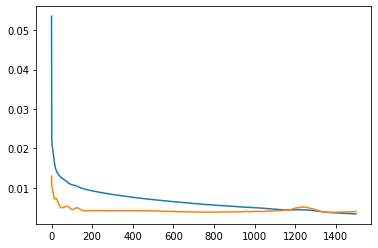

In [15]:
plt.plot(train_loss_list)
plt.plot(validate_loss_list)
plt.show()

In [16]:
# Overall test accuracy
scaled_y_pred = np.array(predictions_list)[-1,:,0,:]
y_pred = scaler_y.inverse_transform(scaled_y_pred)
ind = np.where(y_pred>0)[0]

print(y_pred[ind].min()/(10**15), y_pred[ind].max()/(10**15))
print(features_y_val[ind].min()/(10**15), features_y_val[ind].max()/(10**15))

print('RMSE:', RMSE(features_y_val[ind], y_pred[ind])/(10**15))
print('MAE:', MAE(features_y_val[ind], y_pred[ind])/(10**15))

-0.627068714876928 21.80455897183027
-0.768556950093824 23.034785781776385
RMSE: 1.221662091410523
MAE: 0.8338269521670935


In [18]:
# Plot all test data result
rmse_array, mae_array, difference_array = [], [], []

for dt in range(y_pred.shape[0]):
    
    rmse_list, mae_list, difference_list = [], [], []
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    for i in range(y_test_subset.shape[0]):
        rmse_list.append(RMSE(y_test_subset[i], y_pred_subset[i])/(10**15))
        mae_list.append(MAE(y_test_subset[i], y_pred_subset[i])/(10**15))
        difference_list.append((y_pred_subset[i]- y_test_subset[i])/(10**15))
    
    rmse_array.append(rmse_list)
    mae_array.append(mae_list)
    difference_array.append(difference_list)

rmse_array = np.array(rmse_array)
mae_array = np.array(mae_array)
difference_array = np.array(difference_array)

rmse_mean = np.mean(rmse_array, axis=0)
mae_mean = np.mean(mae_array, axis=0)
difference_mean = np.mean(difference_array, axis=0)

# ############################# Plot the rmse mean
# plt.figure(figsize=(10,5),dpi=600)

# # largler LA region bounding box
# m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
#             resolution='h',projection='cyl',\
#             lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
# xi, yi = m(xnew, ynew)

# # Plot Data
# sc = m.pcolor(xi,yi,np.squeeze(mae_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=0,vmax=3)

# # Add Grid Lines
# m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
# m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# # Add Coastlines, States, and Country Boundaries
# m.drawcoastlines()
# m.drawstates()
# m.drawcountries()
# m.drawcounties()

# # Add Colorbar
# no2_units = 'mole cm-2'
# cbar = m.colorbar(sc, location='bottom', pad="10%")
# cbar.set_label(no2_units)

# # Add Title
# plt.title('RMSE')
# plt.show()

# ############################# Plot the mae mean
# plt.figure(figsize=(10,5),dpi=600)

# # largler LA region bounding box
# m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
#             resolution='h',projection='cyl',\
#             lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
# xi, yi = m(xnew, ynew)

# # Plot Data
# sc = m.pcolor(xi,yi,np.squeeze(rmse_mean.reshape(xxnew.shape)), cmap='coolwarm',vmin=0,vmax=3)

# # Add Grid Lines
# m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
# m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# # Add Coastlines, States, and Country Boundaries
# m.drawcoastlines()
# m.drawstates()
# m.drawcountries()
# m.drawcounties()

# # Add Colorbar
# no2_units = 'mole cm-2'
# cbar = m.colorbar(sc, location='bottom', pad="10%")
# cbar.set_label(no2_units)

# # Add Title
# plt.title('MAE')
# plt.show()

# ############################# Plot the difference mean
# plt.figure(figsize=(10,5),dpi=600)

# # largler LA region bounding box
# m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
#             resolution='h',projection='cyl',\
#             lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
# xi, yi = m(xnew, ynew)

# # Plot Data
# sc = m.pcolor(xi,yi,np.squeeze(difference_mean.reshape(xxnew.shape)), cmap='coolwarm', vmin=-3,vmax=3)

# # Add Grid Lines
# m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
# m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

# # Add Coastlines, States, and Country Boundaries
# m.drawcoastlines()
# m.drawstates()
# m.drawcountries()
# m.drawcounties()

# # Add Colorbar
# no2_units = 'mole cm-2'
# cbar = m.colorbar(sc, location='bottom', pad="10%")
# cbar.set_label(no2_units)

# # Add Title
# plt.title('Magitude difference')
# plt.show()

2019060422.0
RMSE: 1.2890268773962086
MAE: 1.0112949650499976


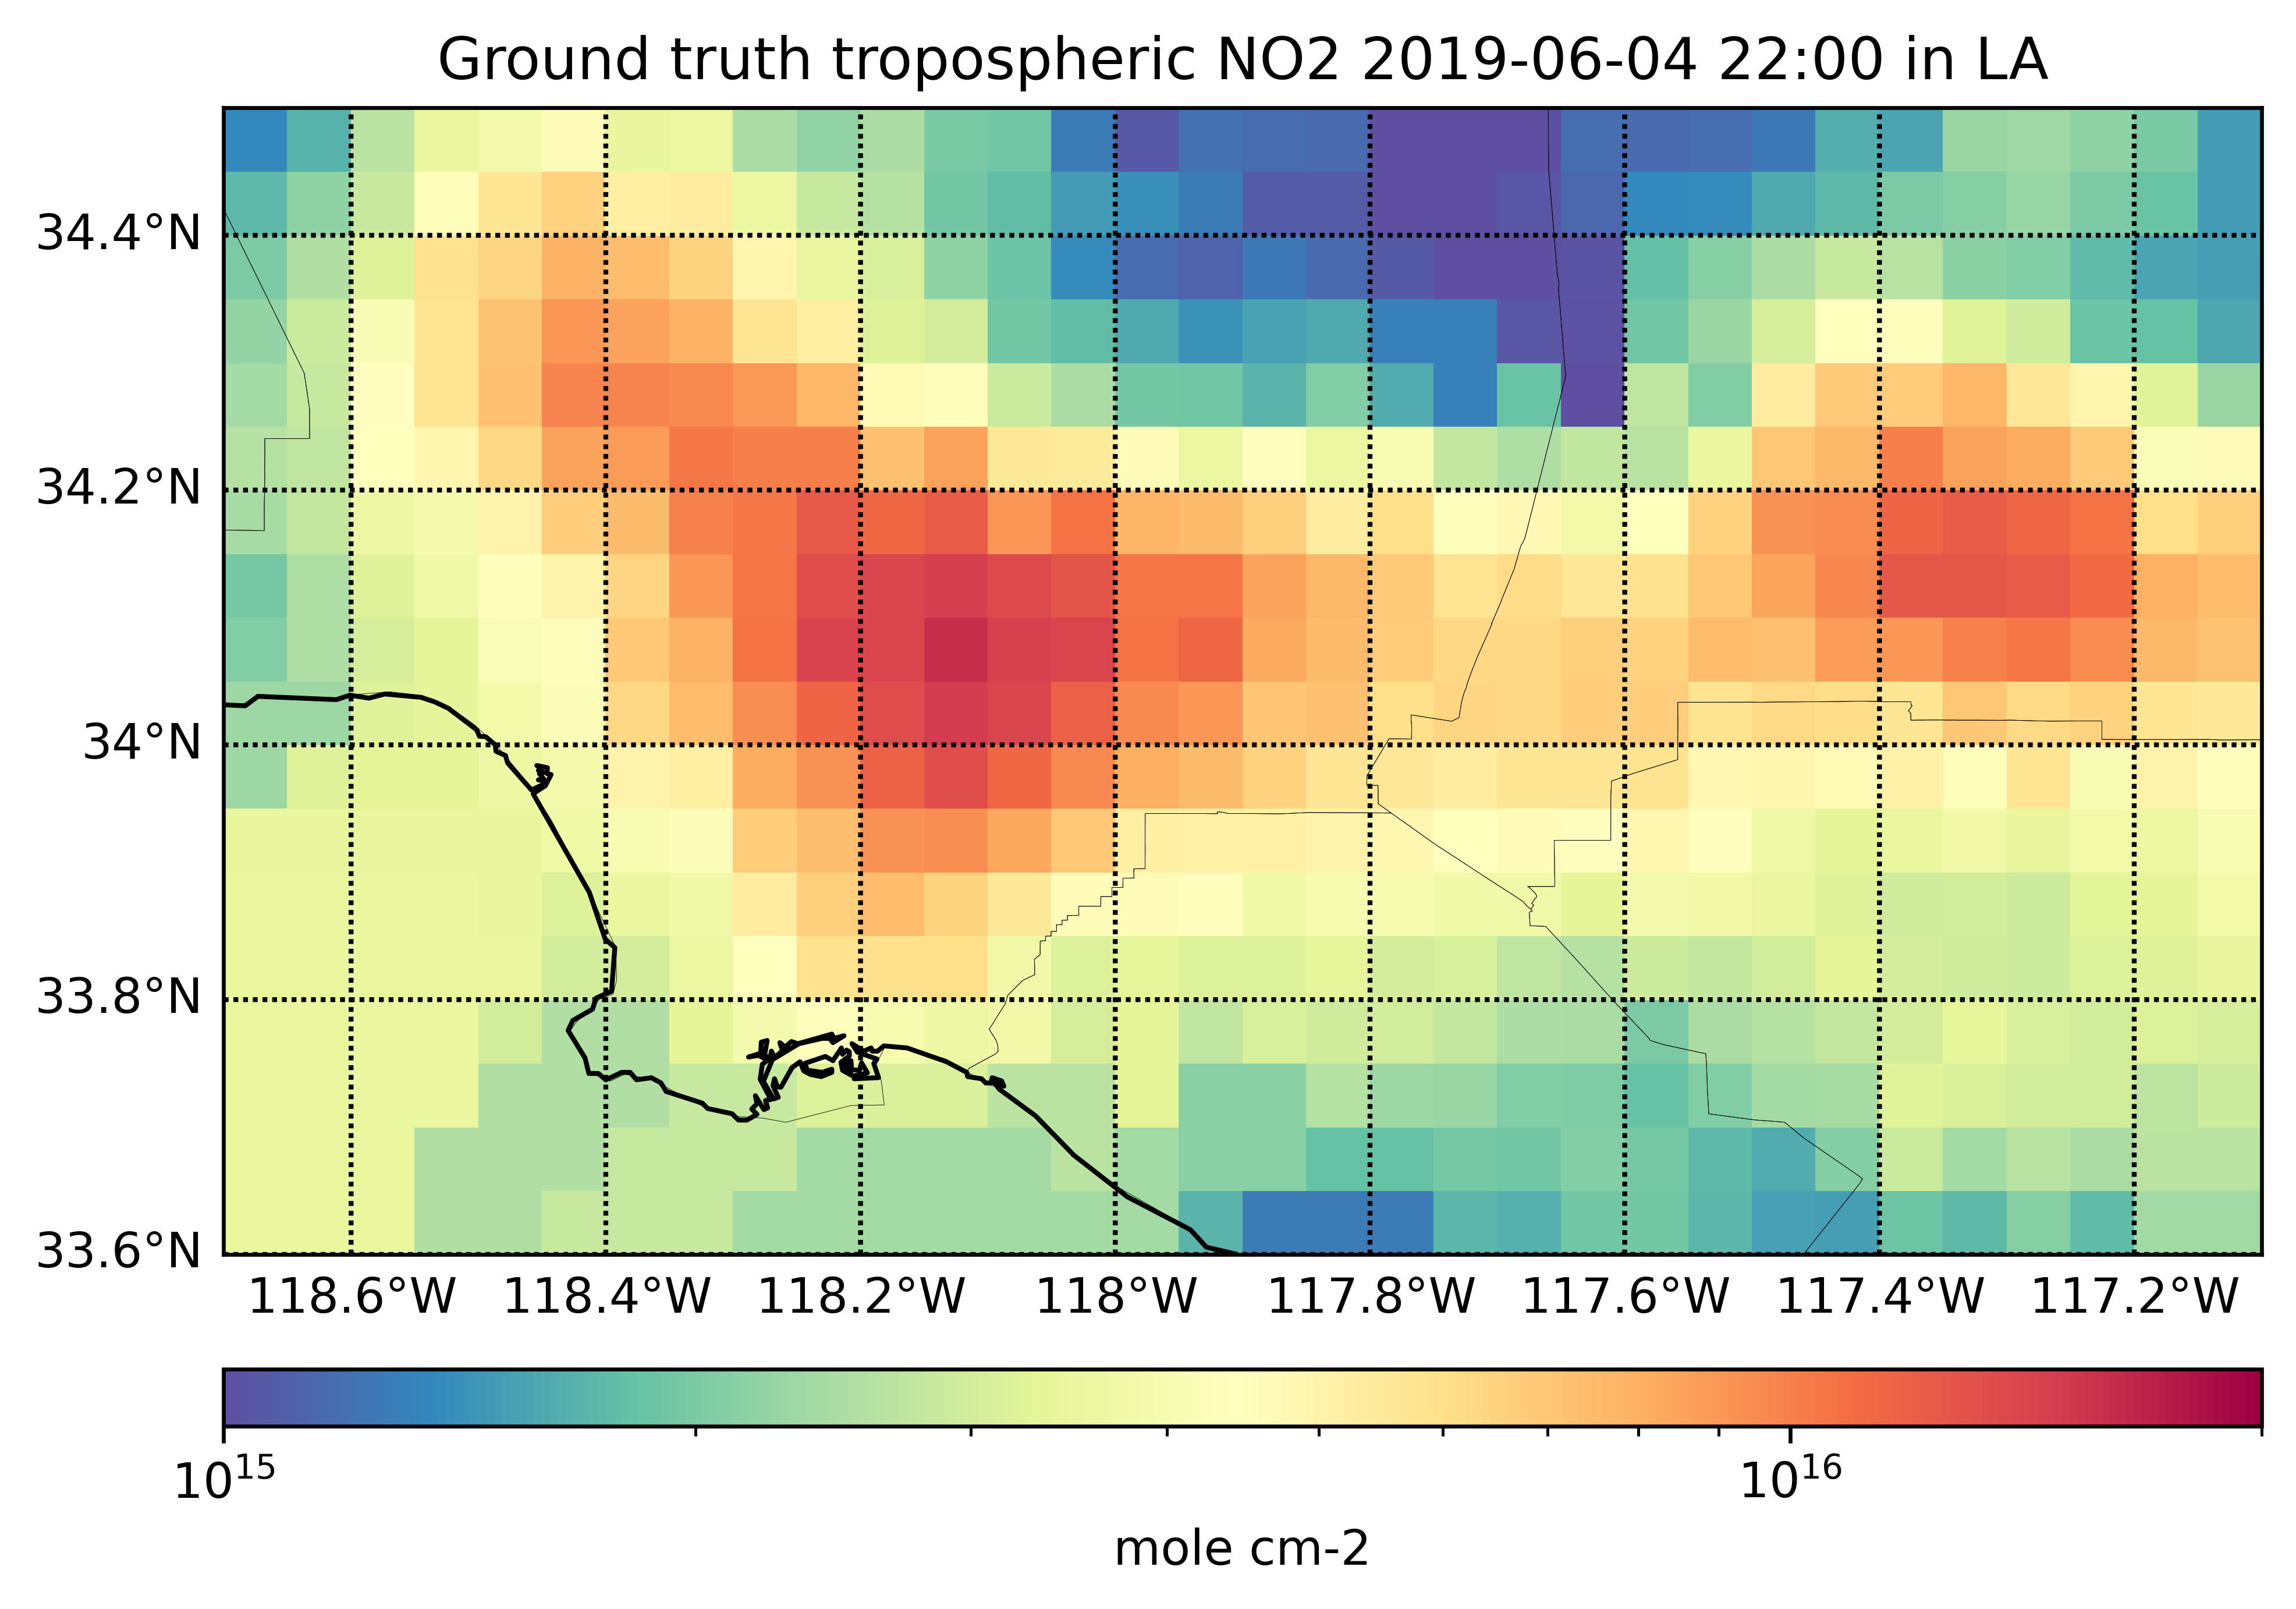

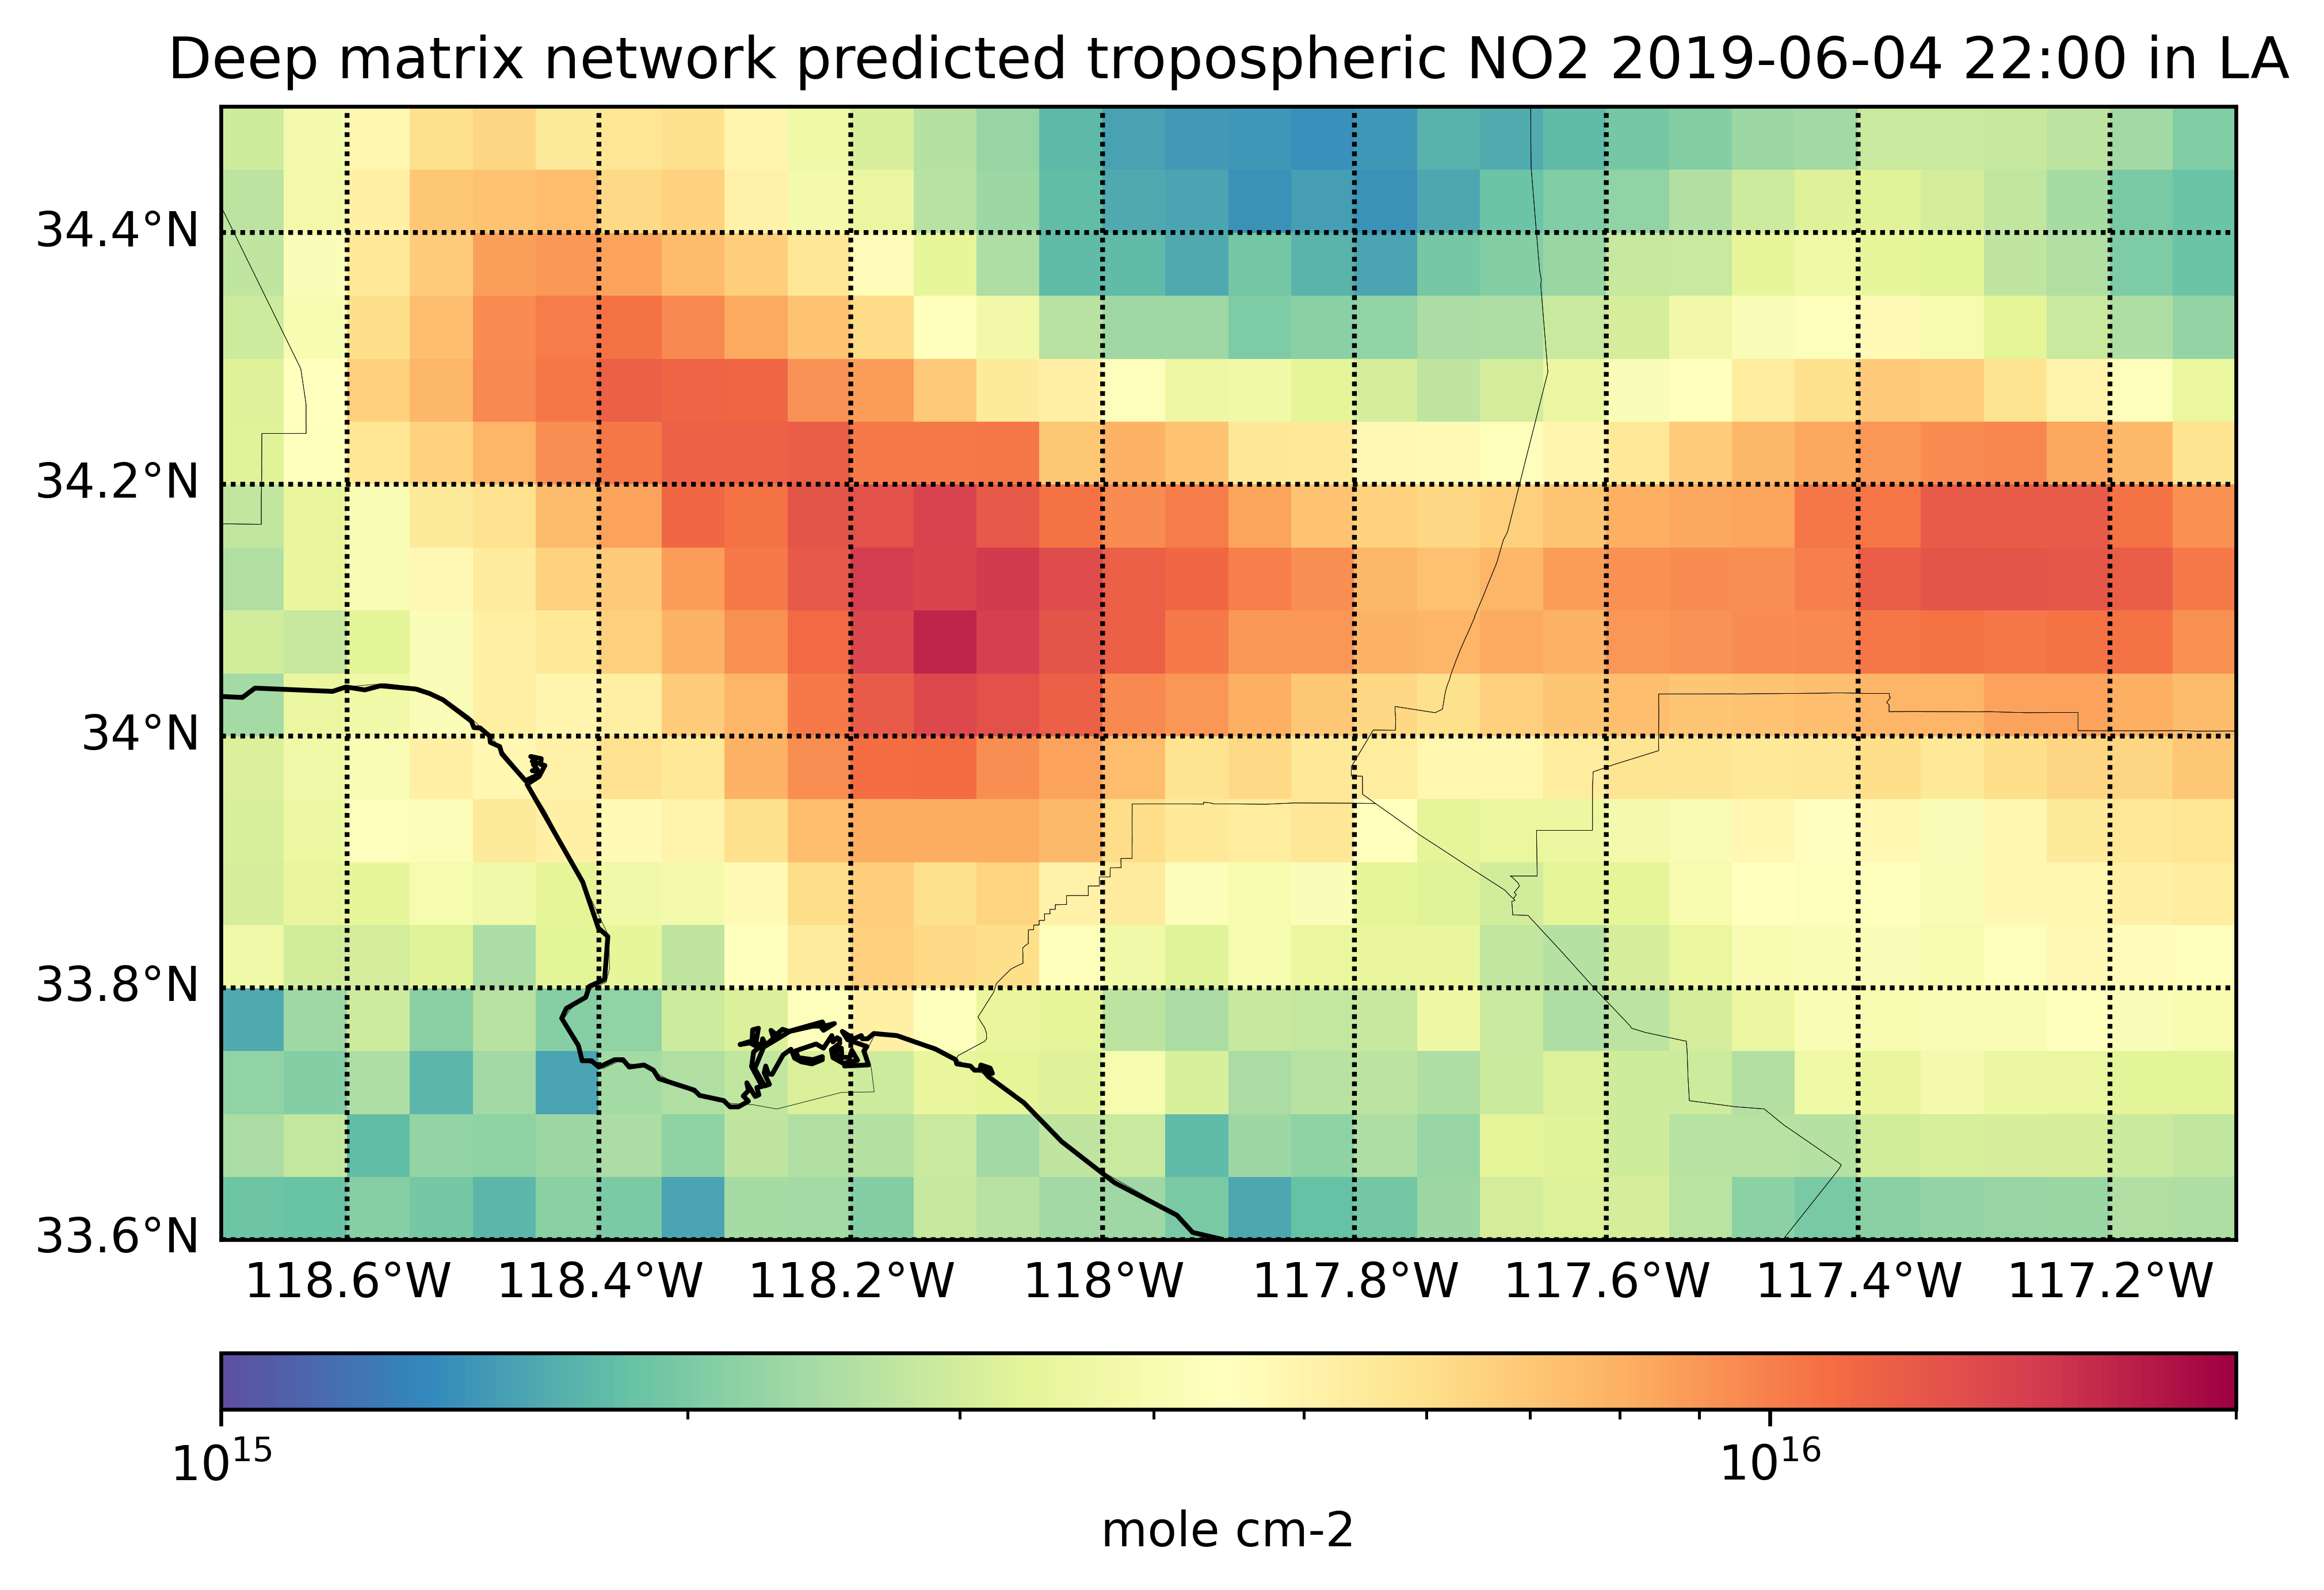

2019060521.0
RMSE: 0.7464246301984311
MAE: 0.5709242356062841


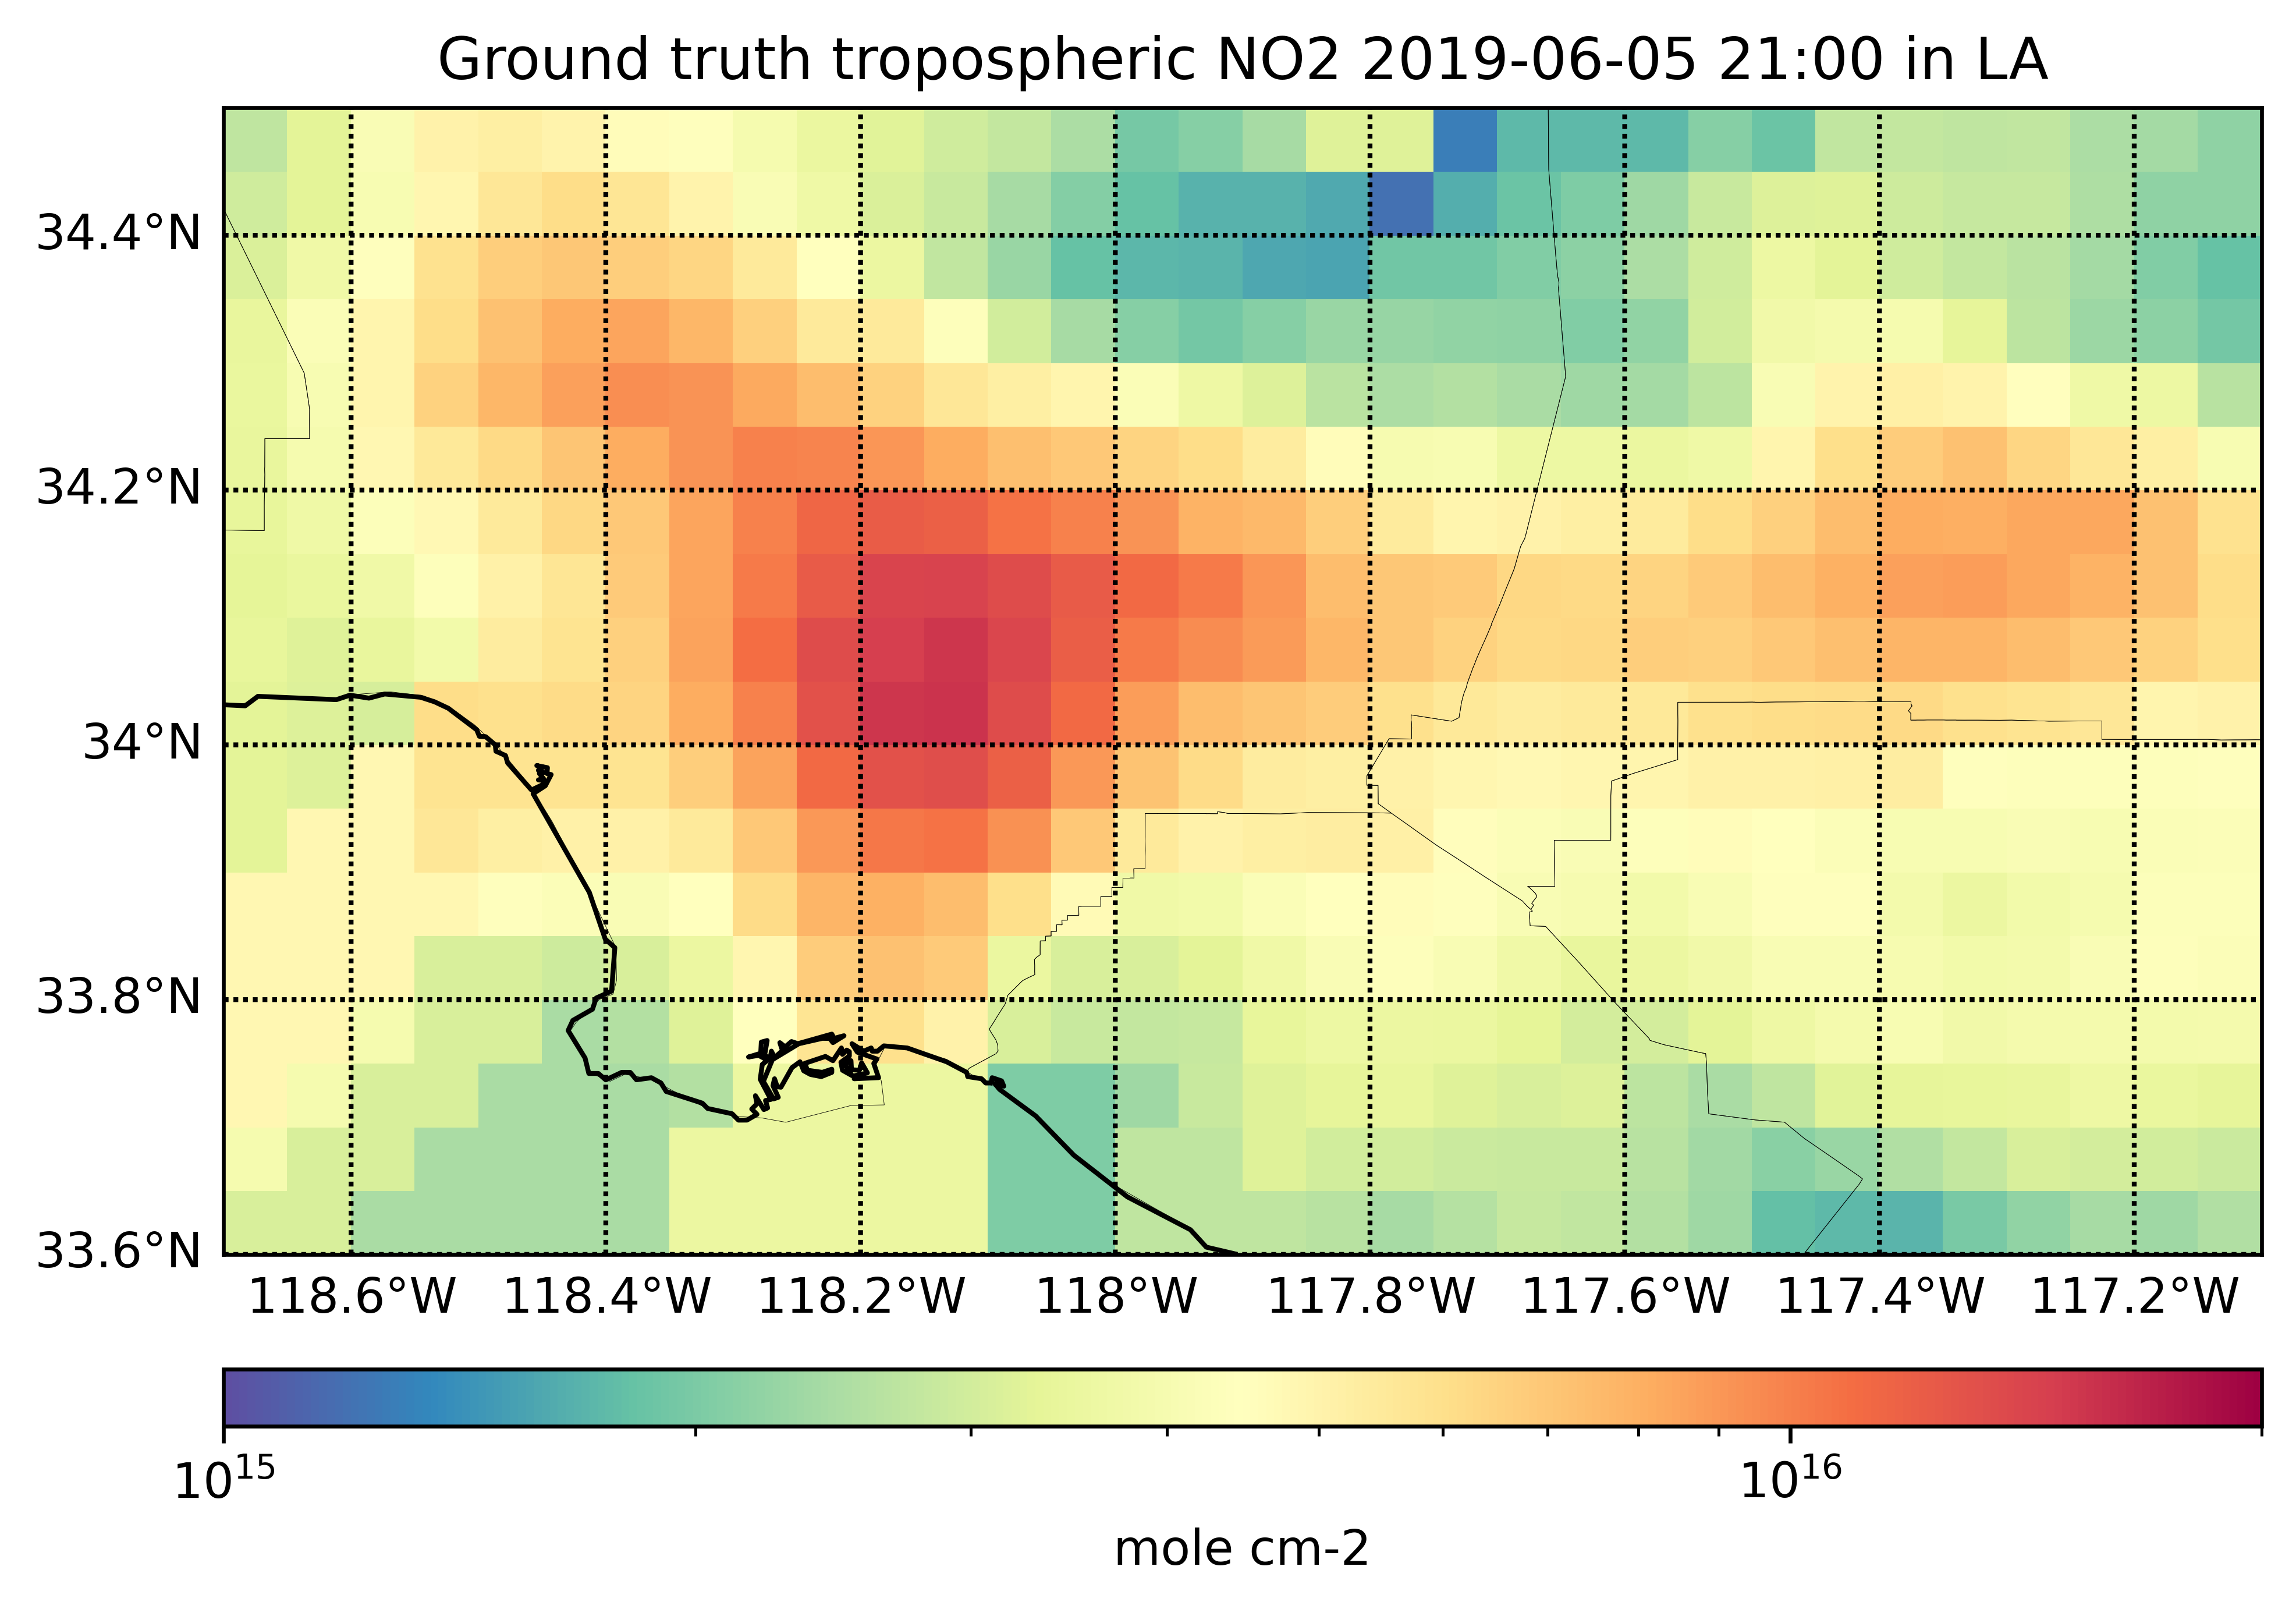

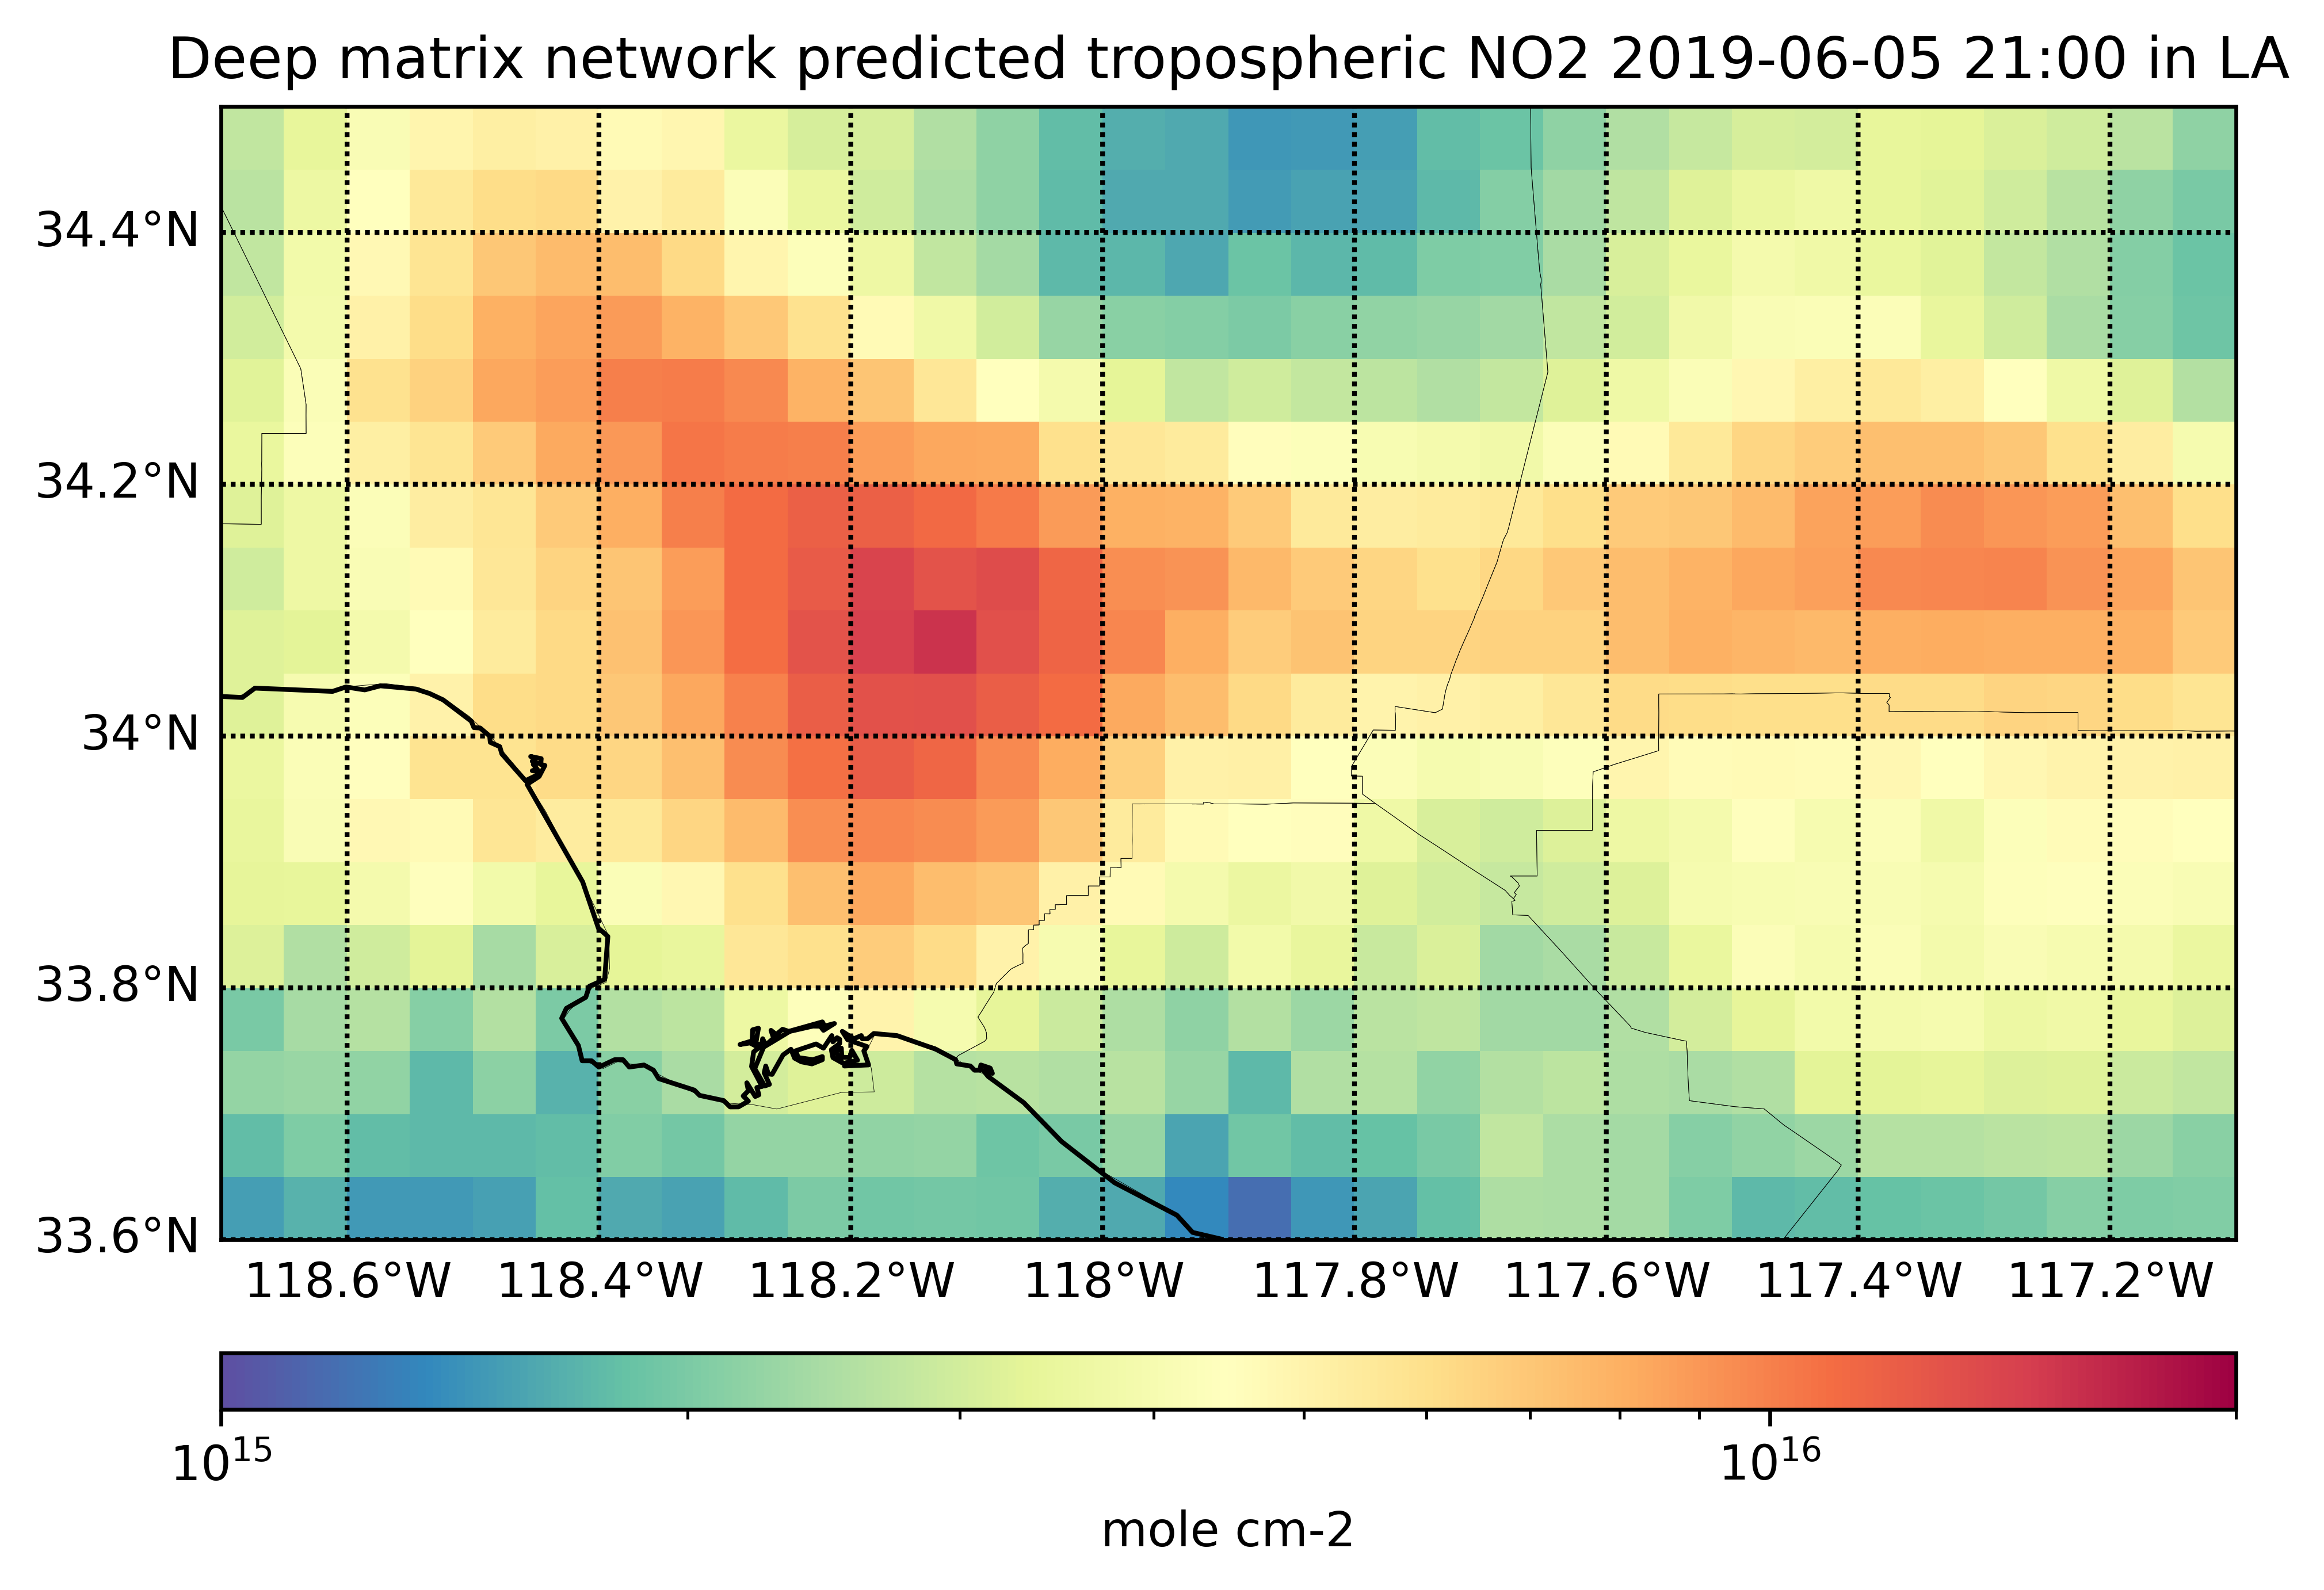

2019060621.0
RMSE: 1.1434268567033556
MAE: 0.8406132249655345


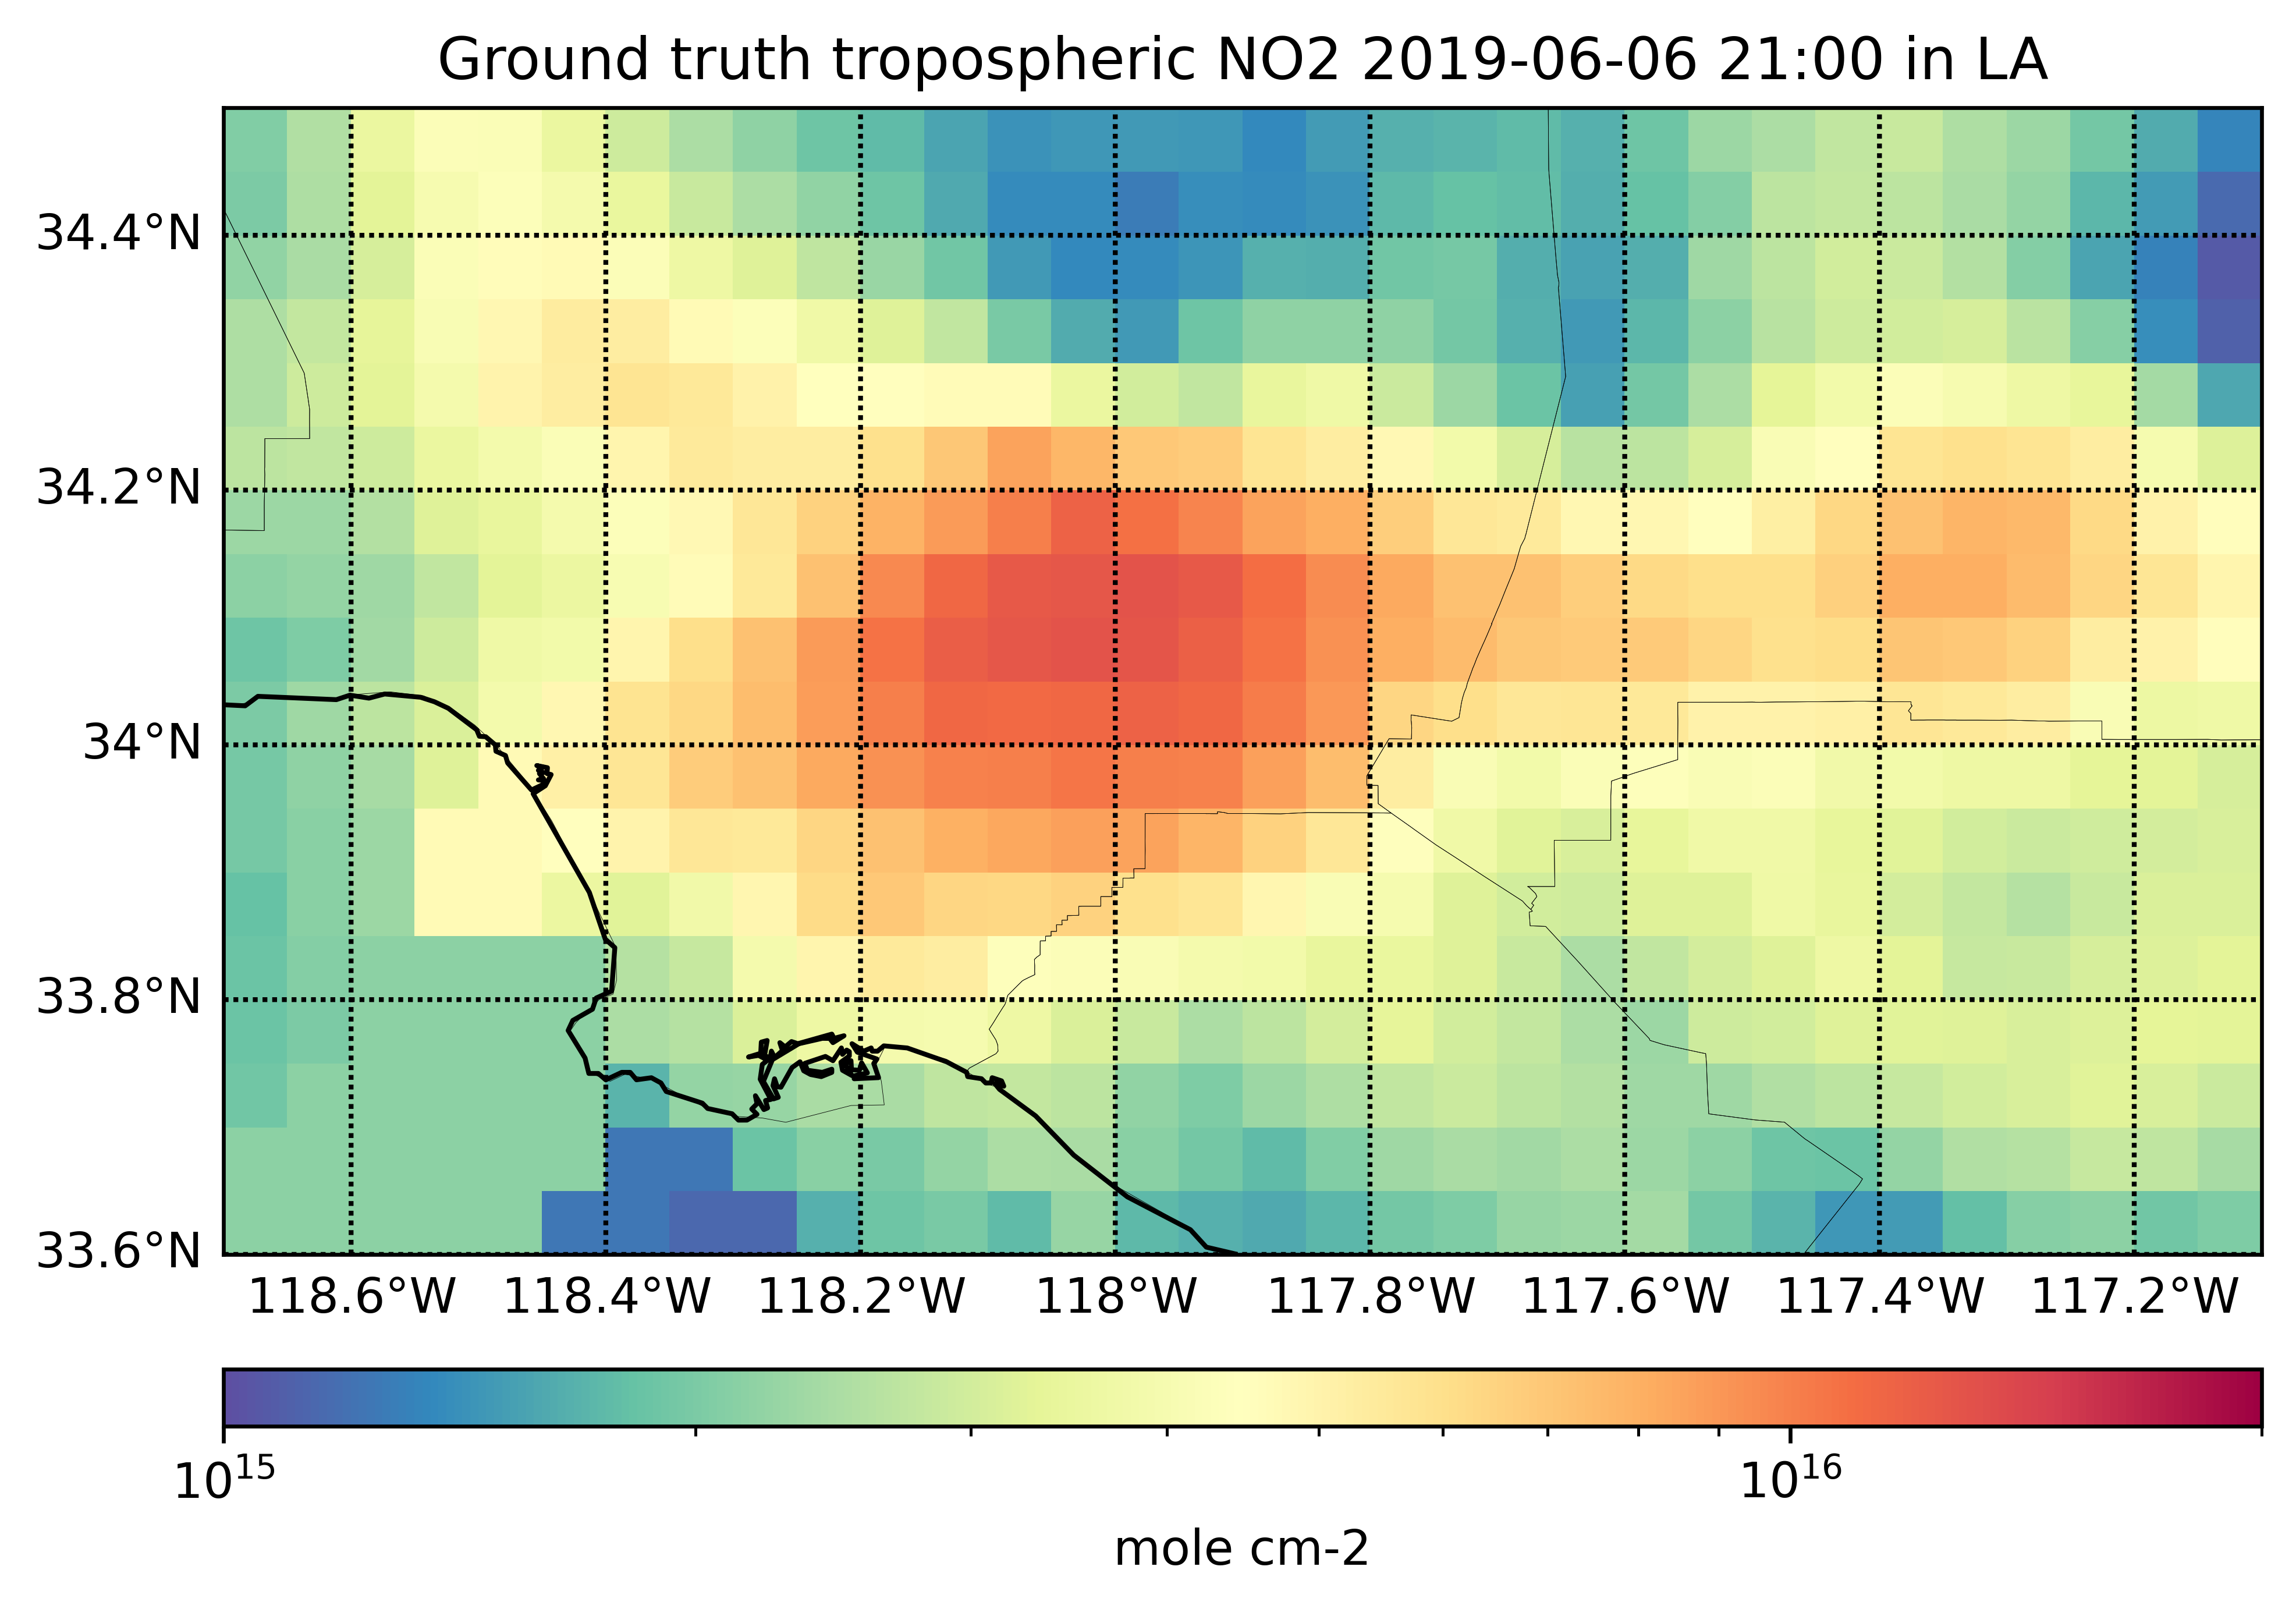

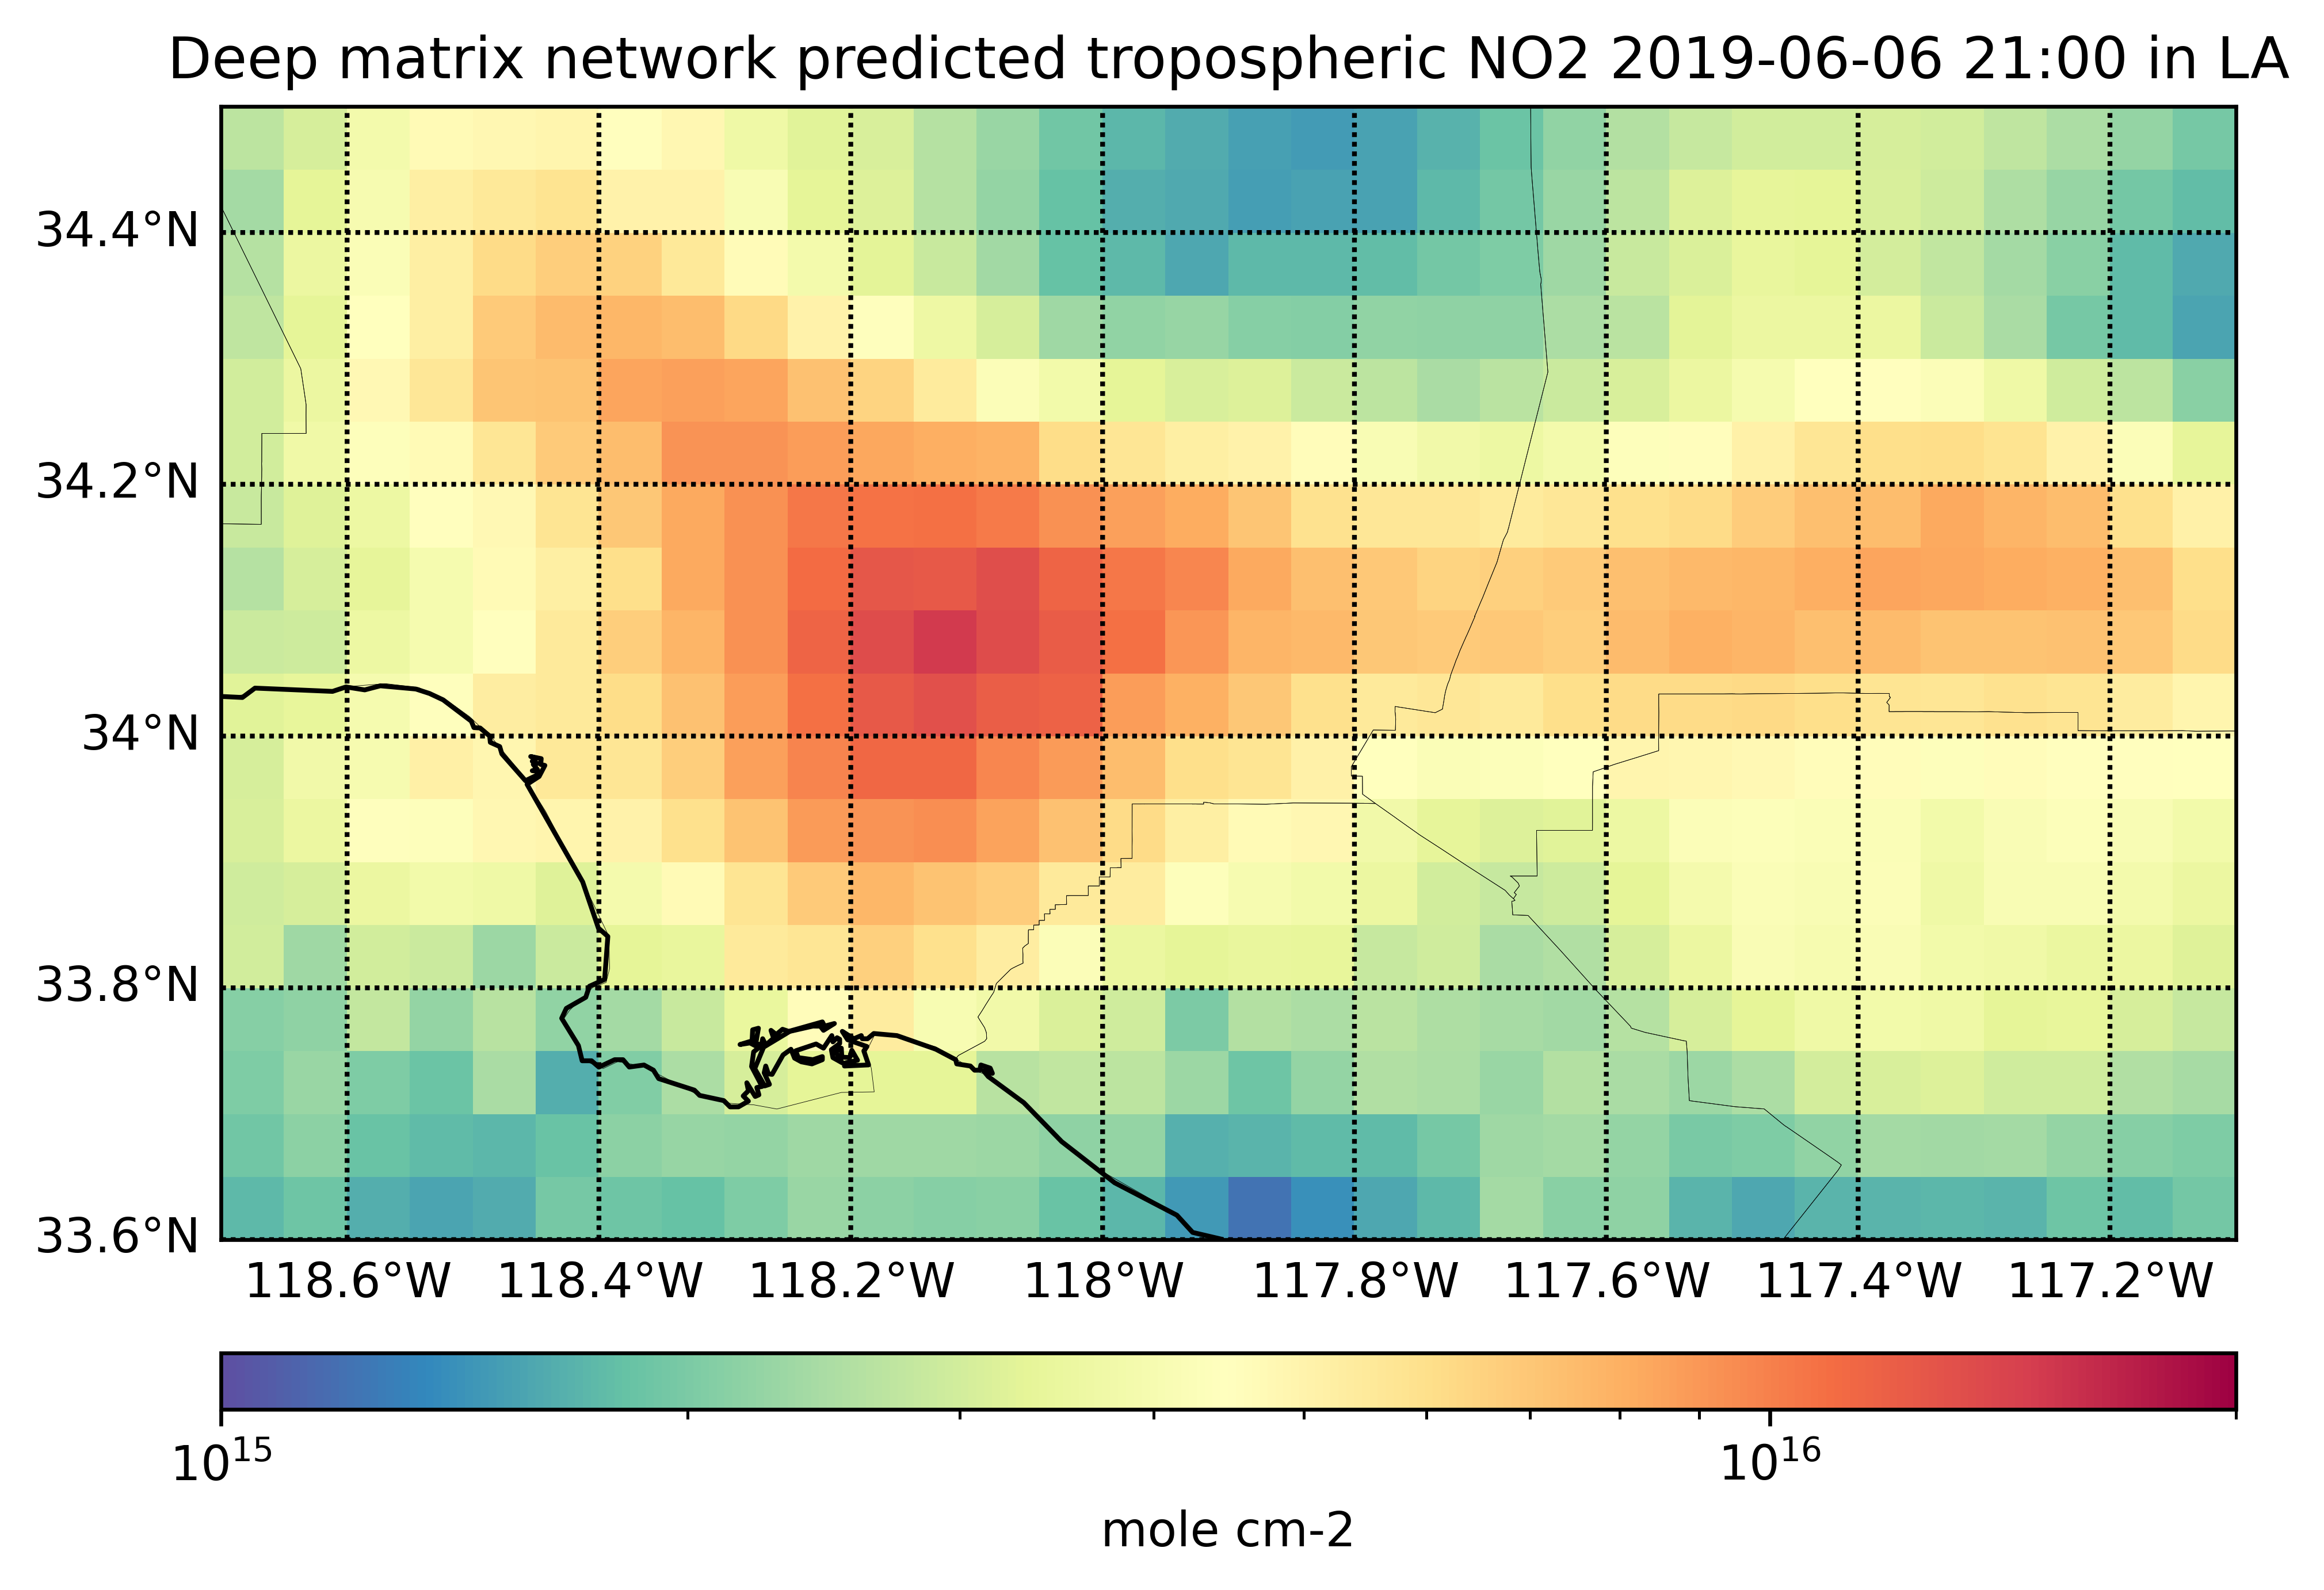

2019060721.0
RMSE: 1.1579503298600664
MAE: 0.814083246551043


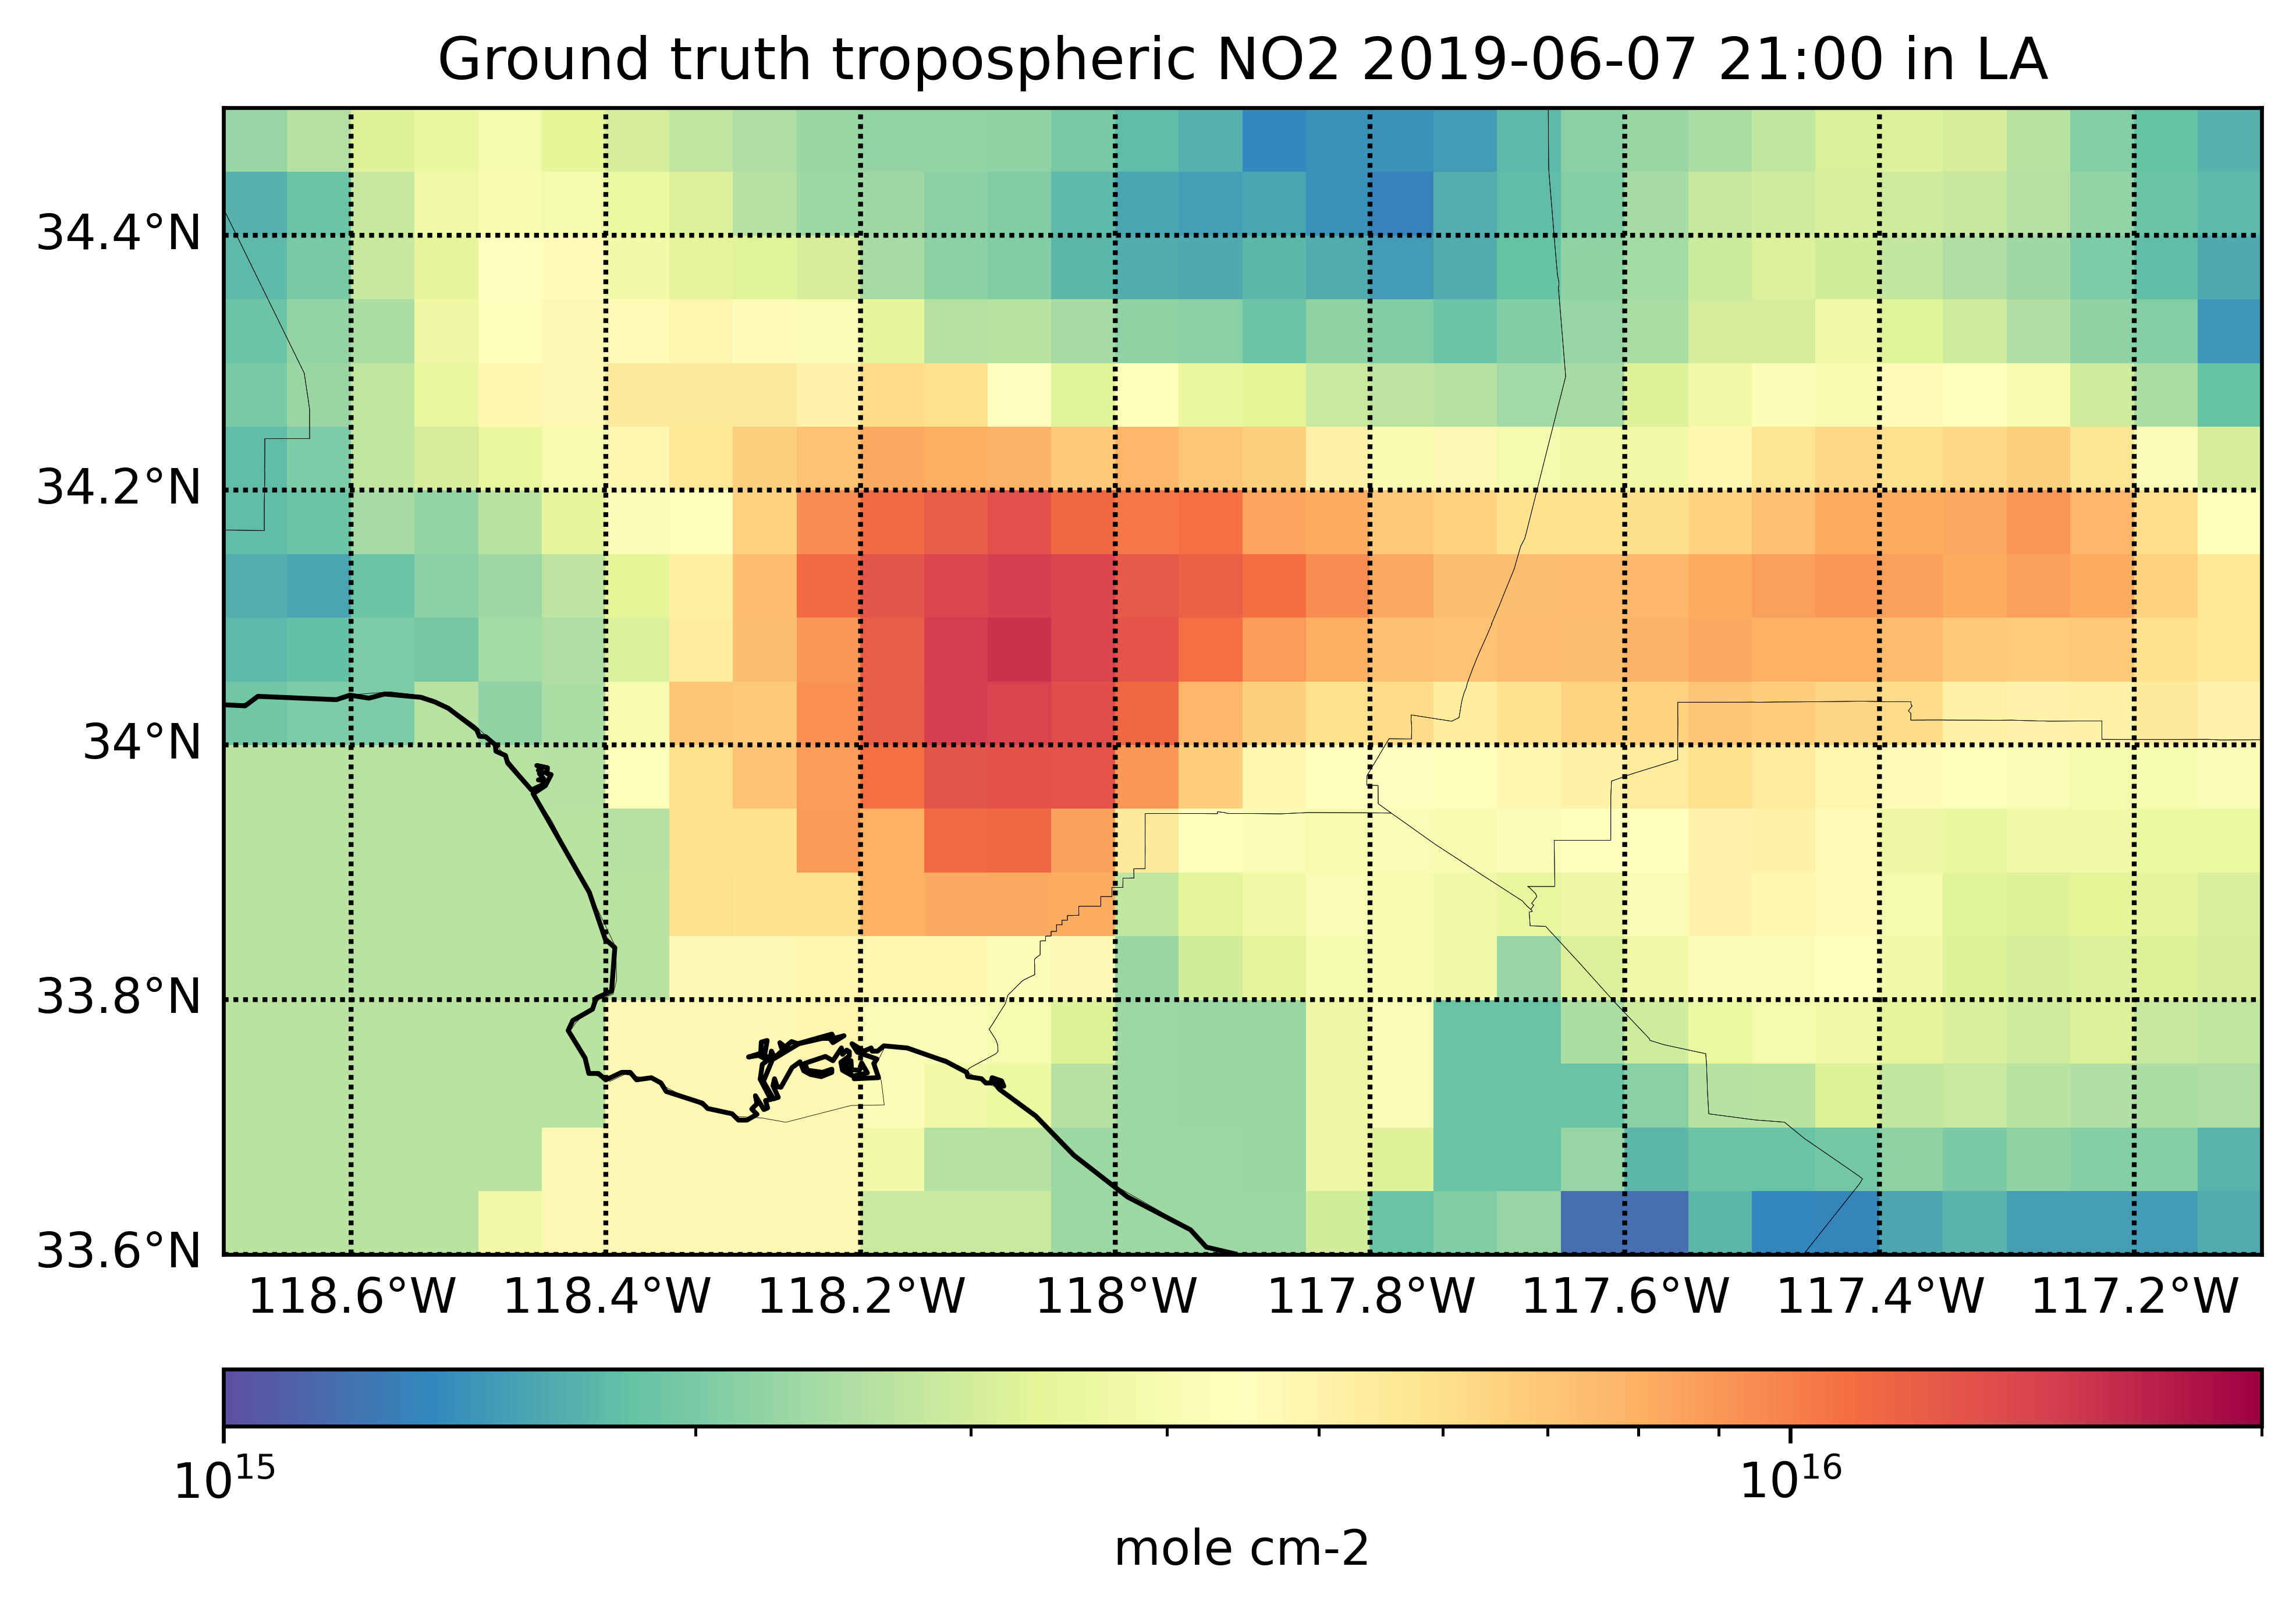

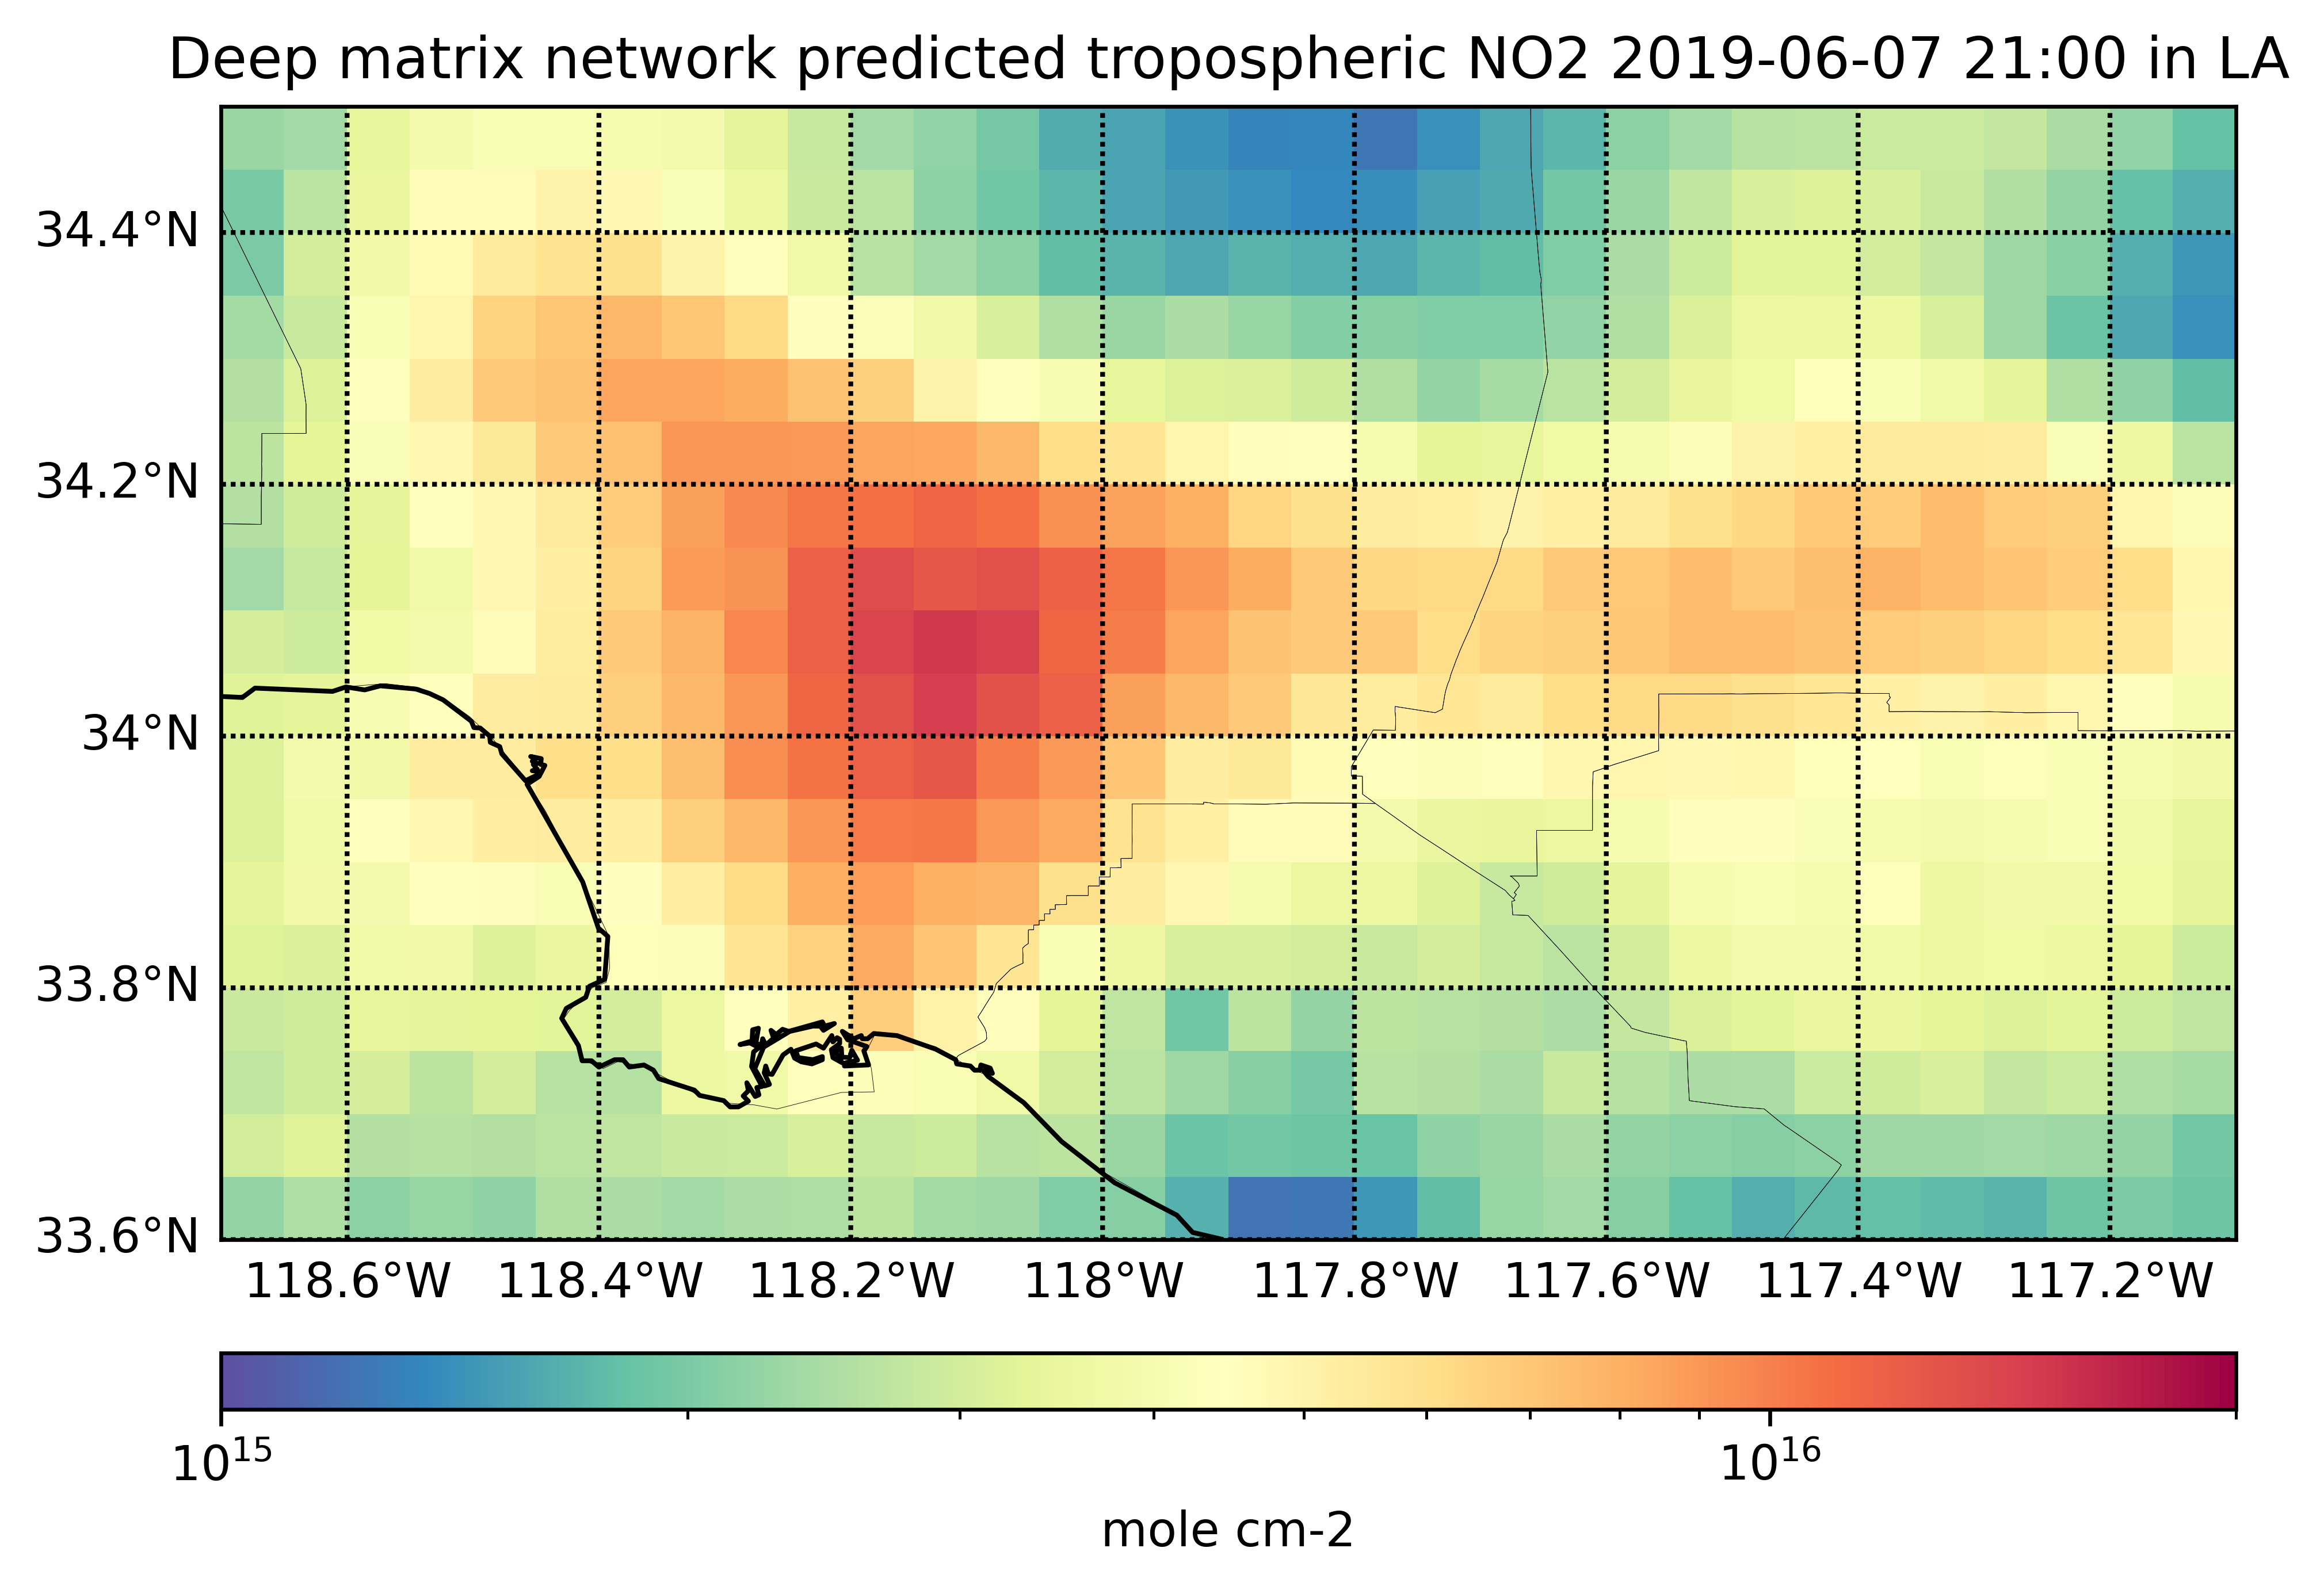

2019060820.0
RMSE: 1.7797885433137552
MAE: 1.560912201046287


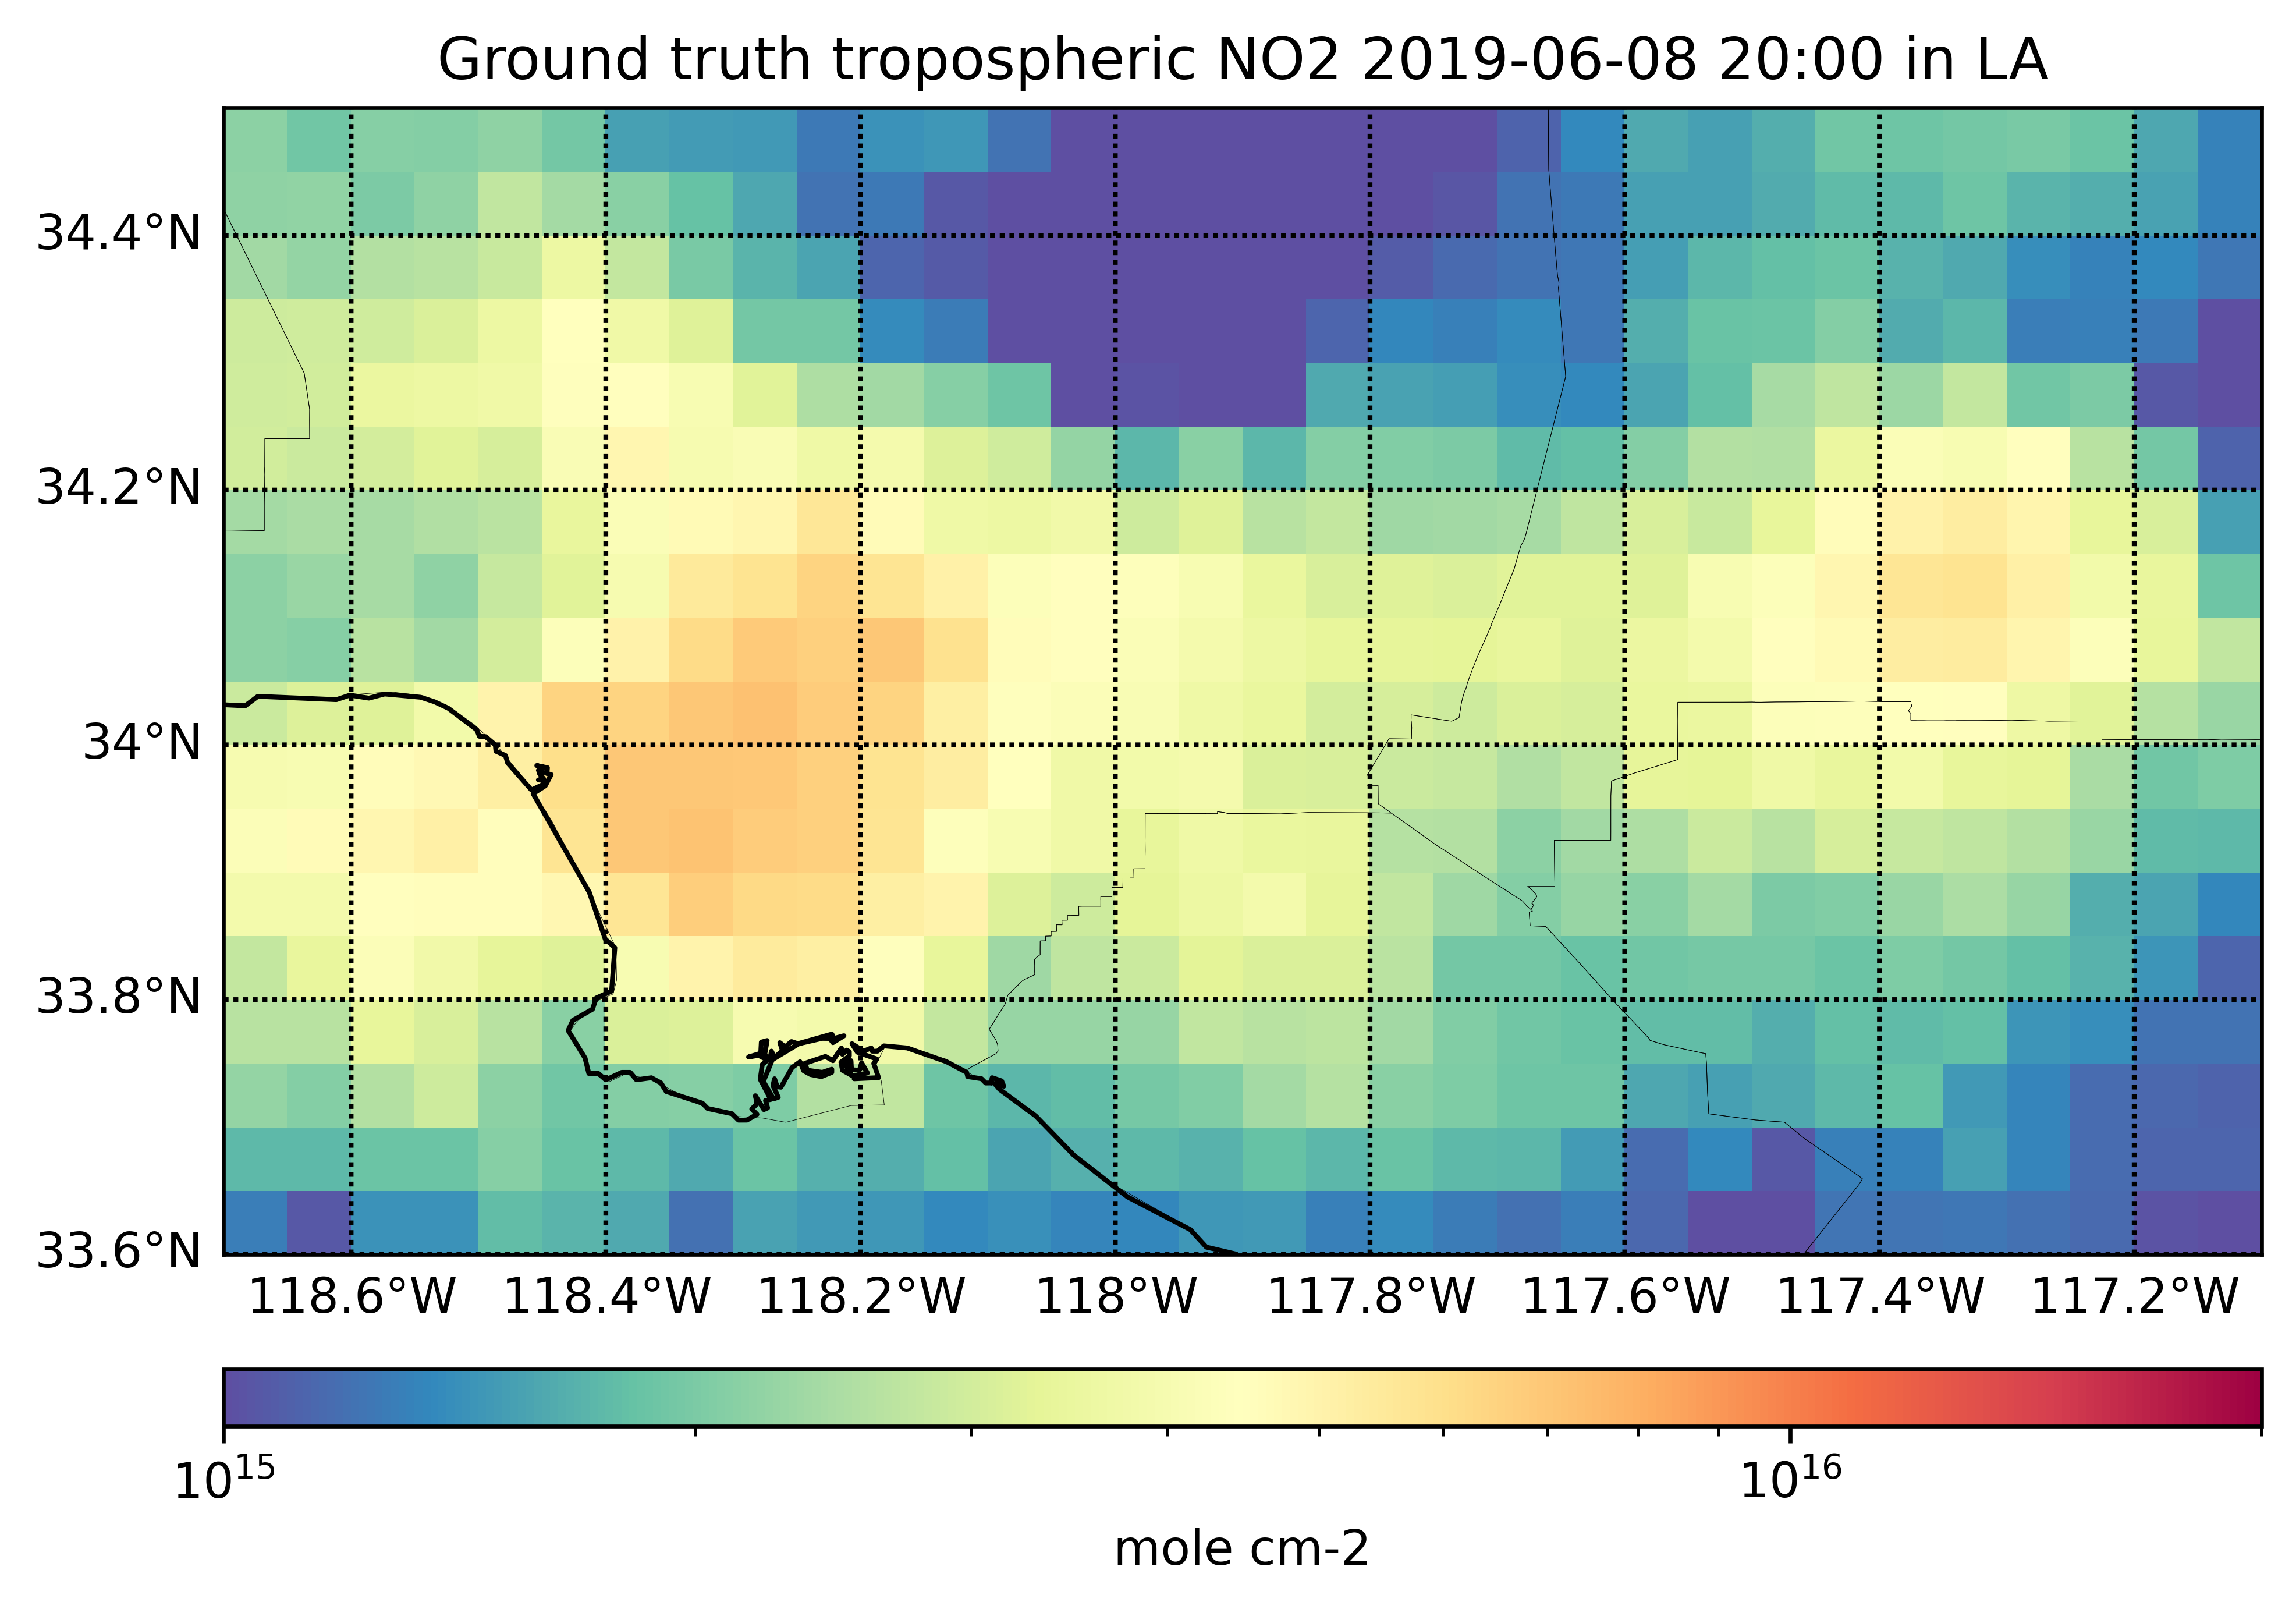

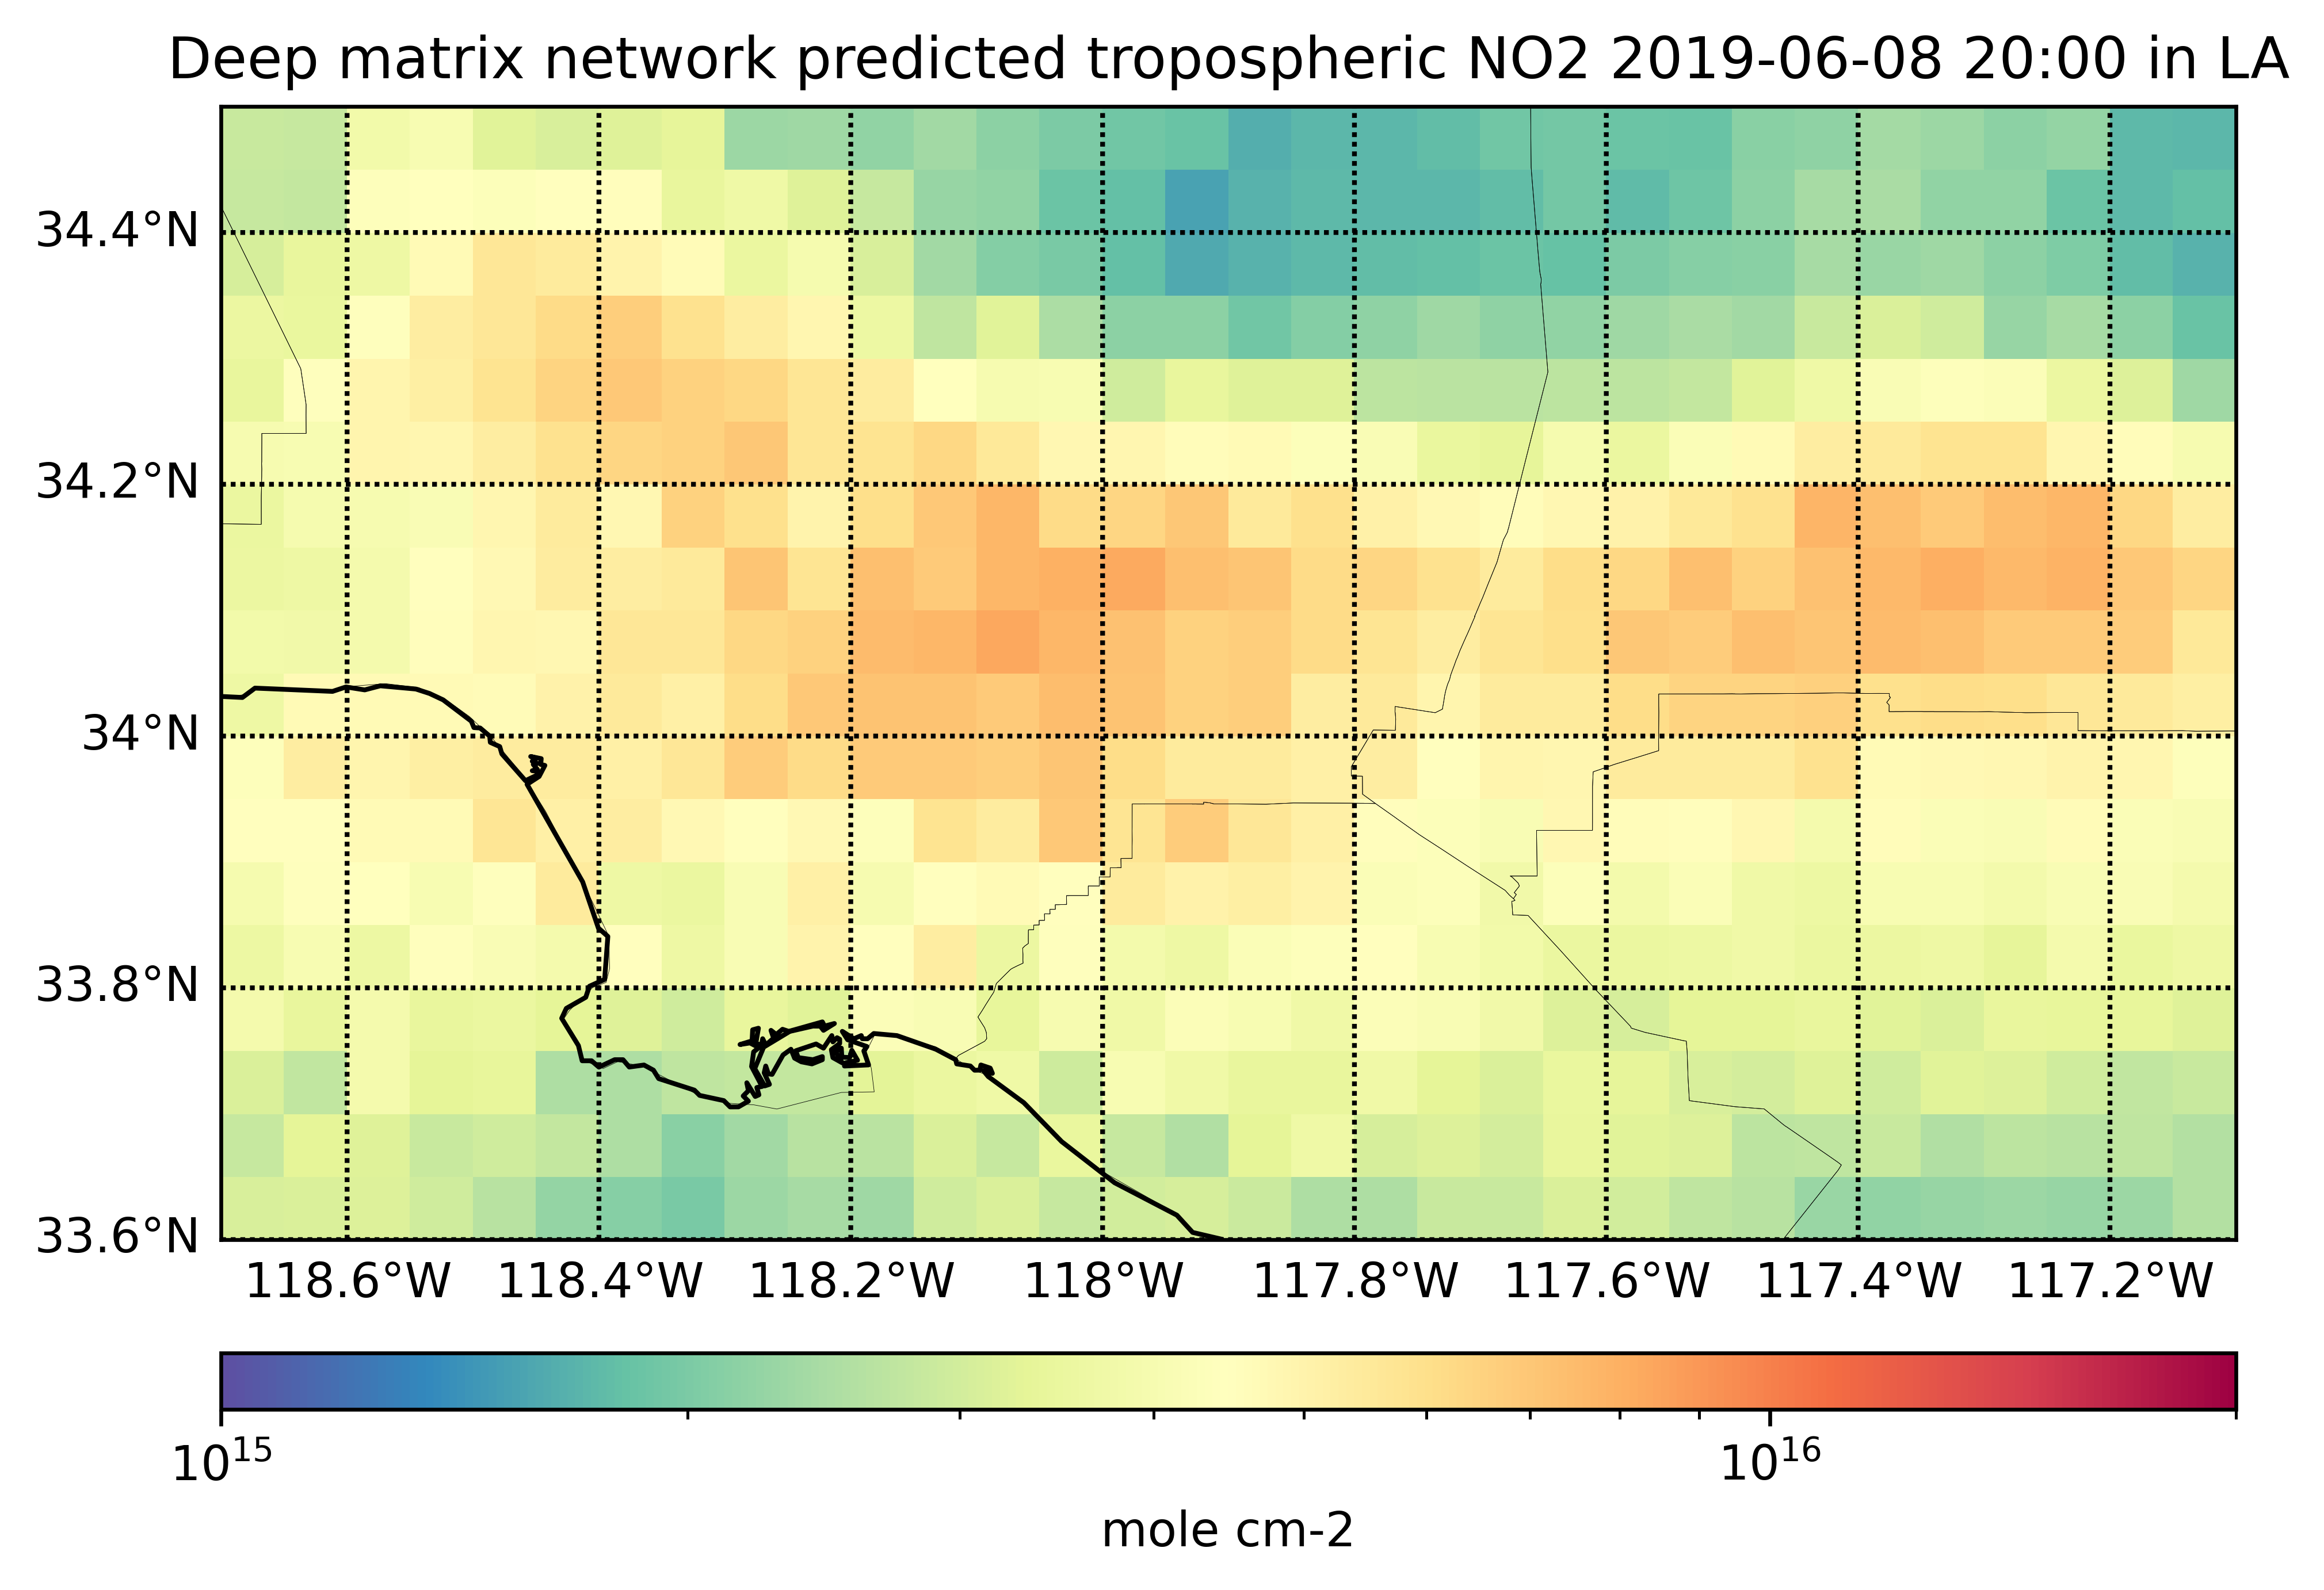

2019060922.0
RMSE: 2.41359133772632
MAE: 2.0278077852065883


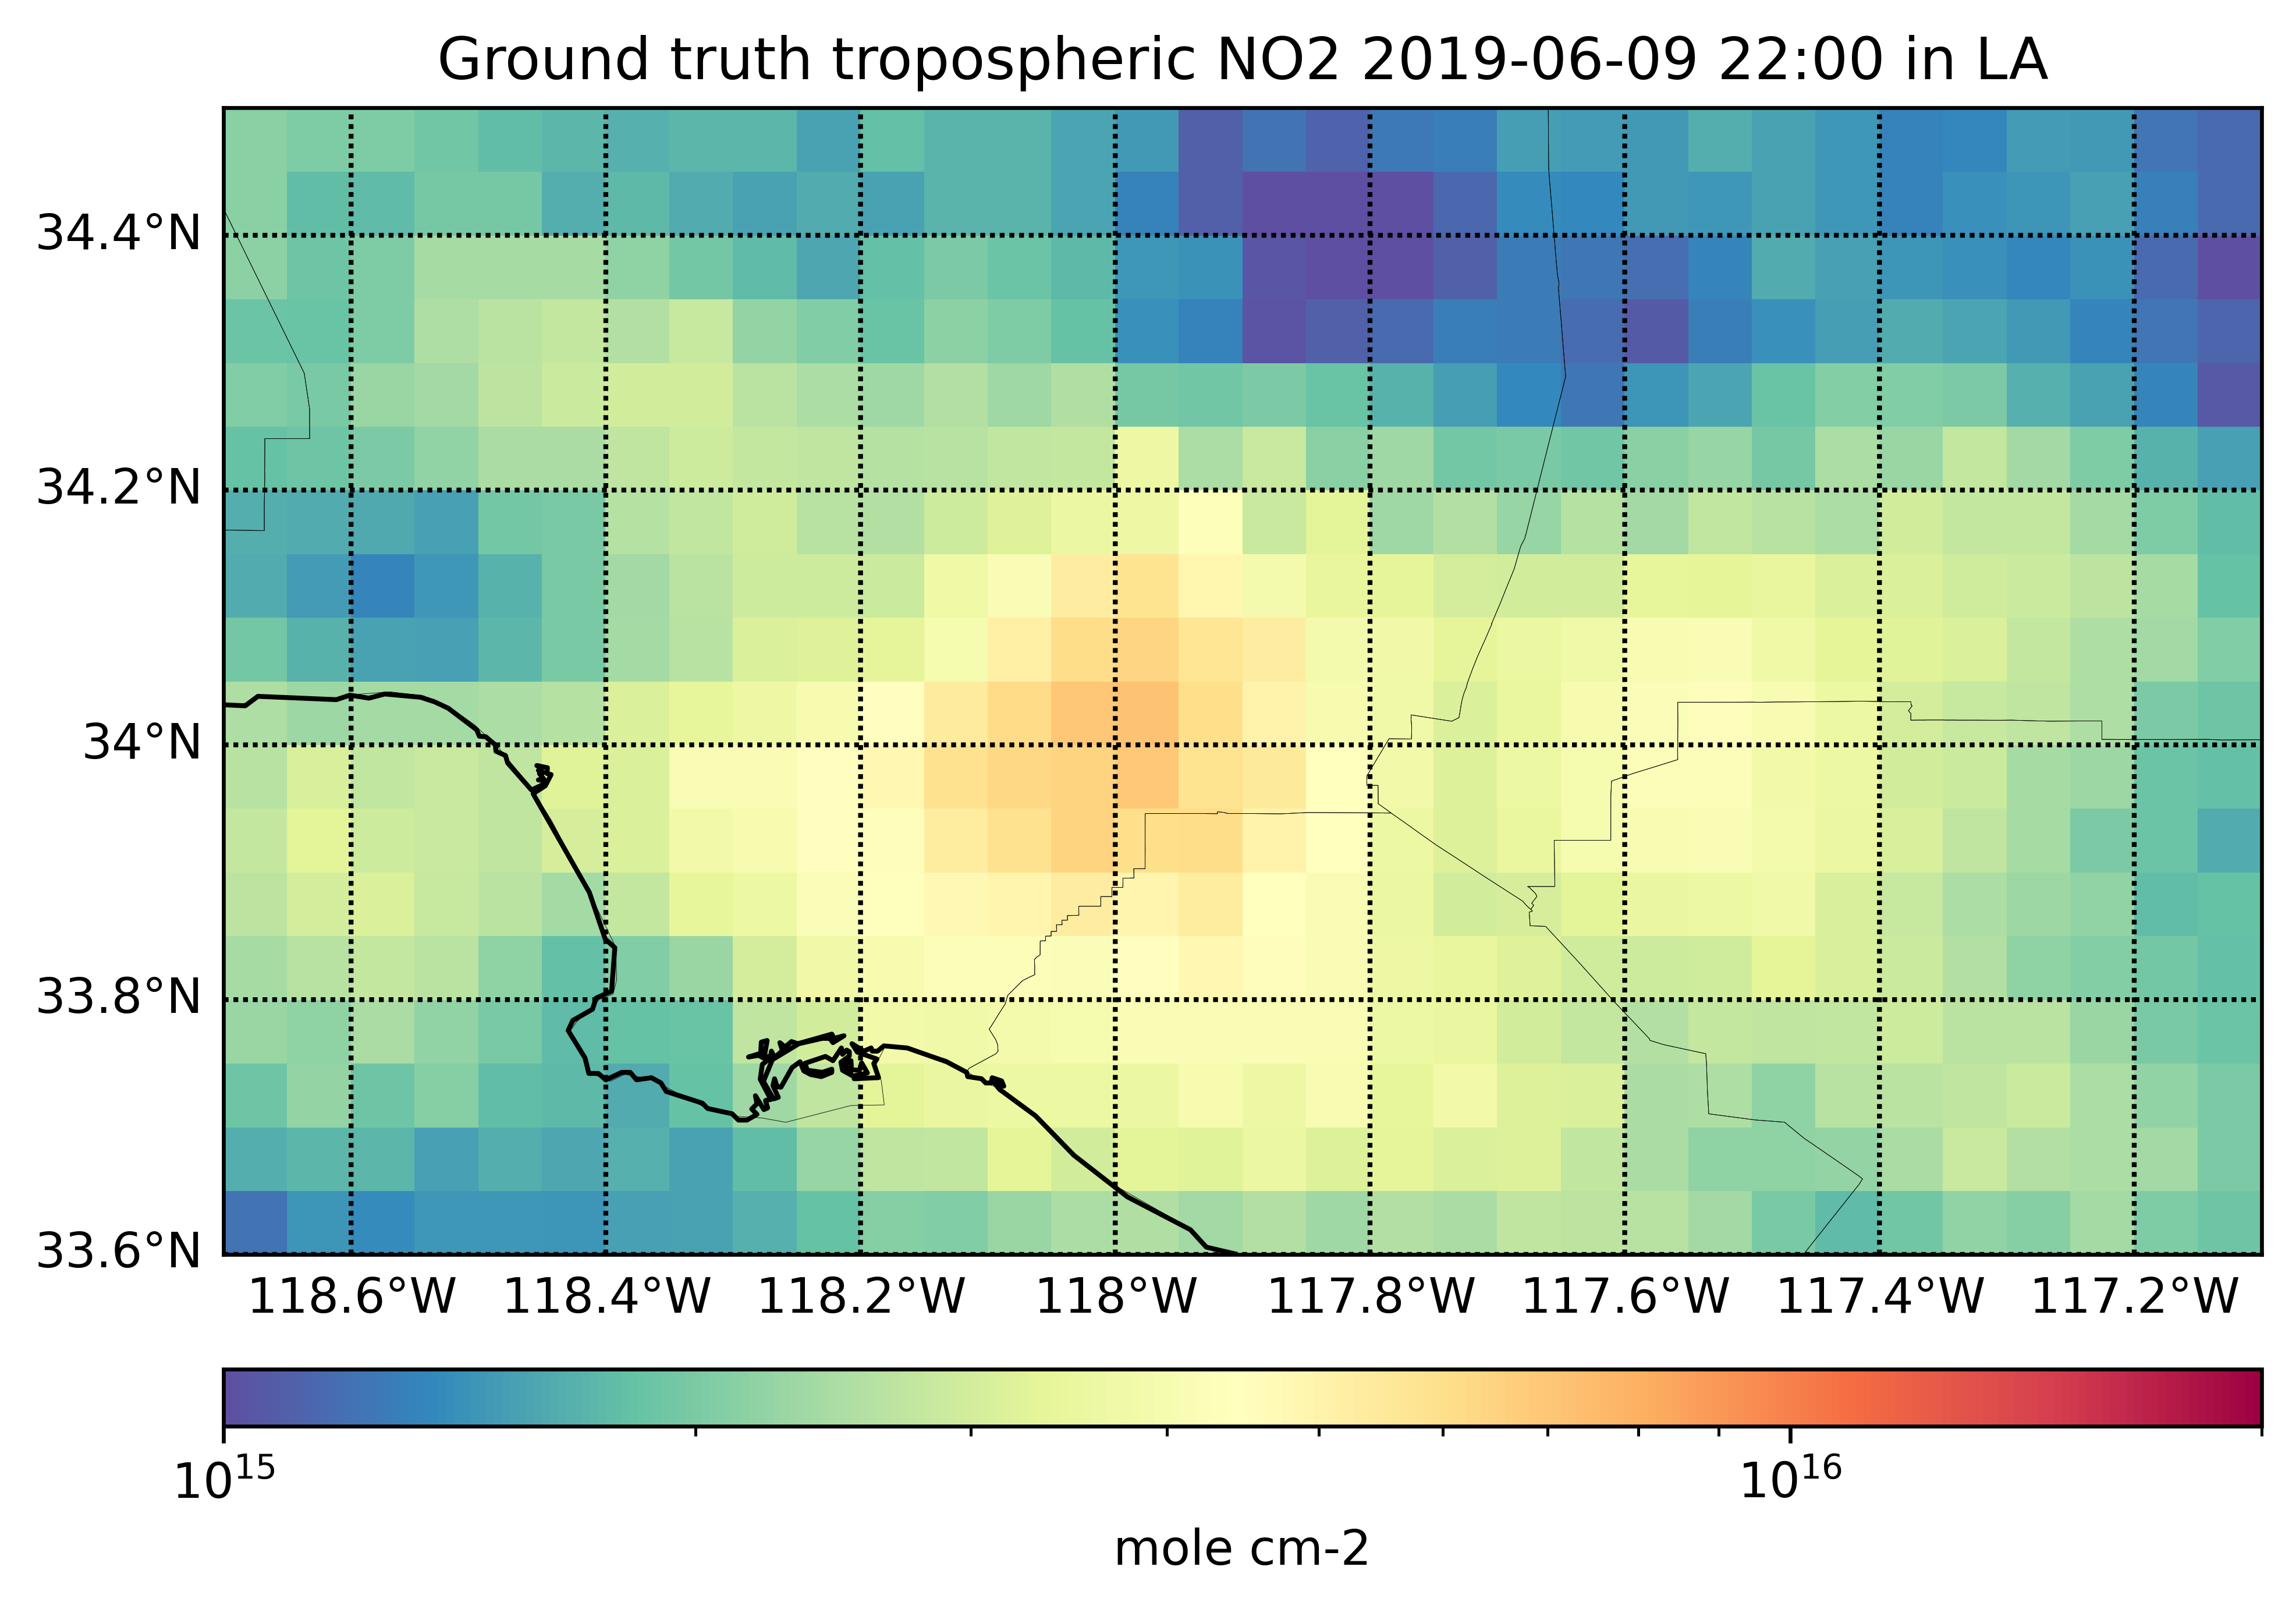

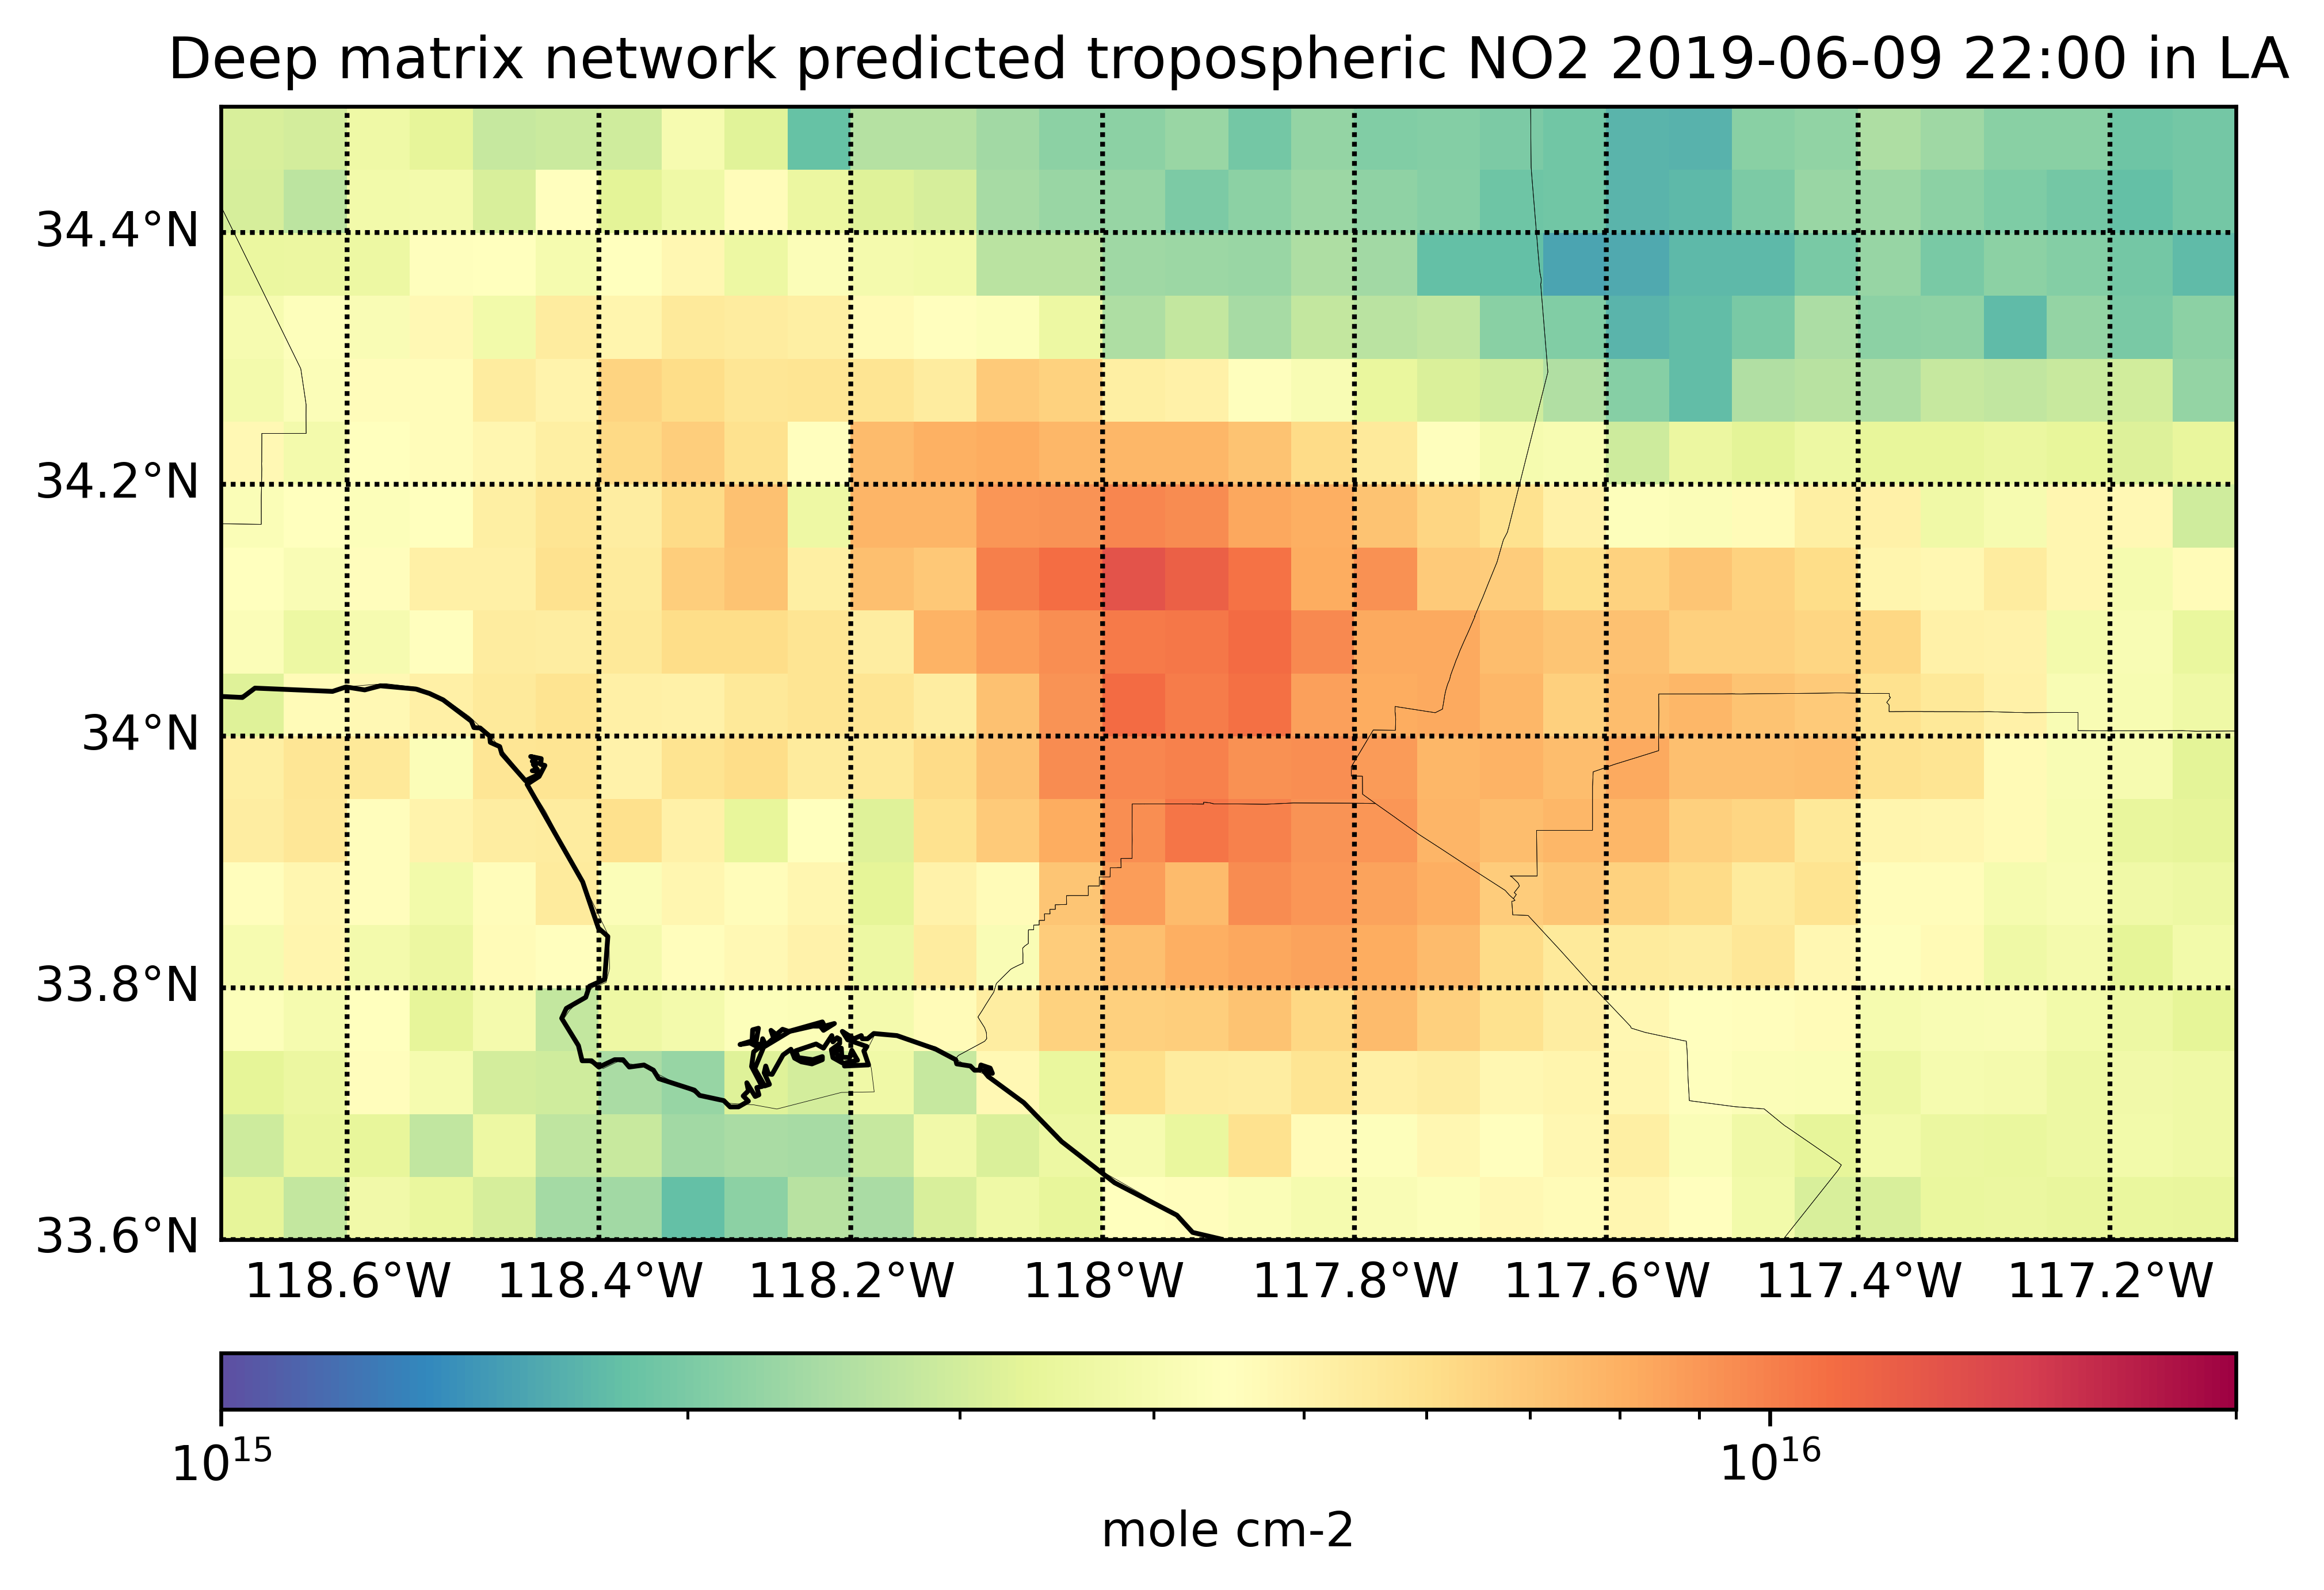

2019061021.0
RMSE: 3.4877298634260203
MAE: 2.4940491332621937


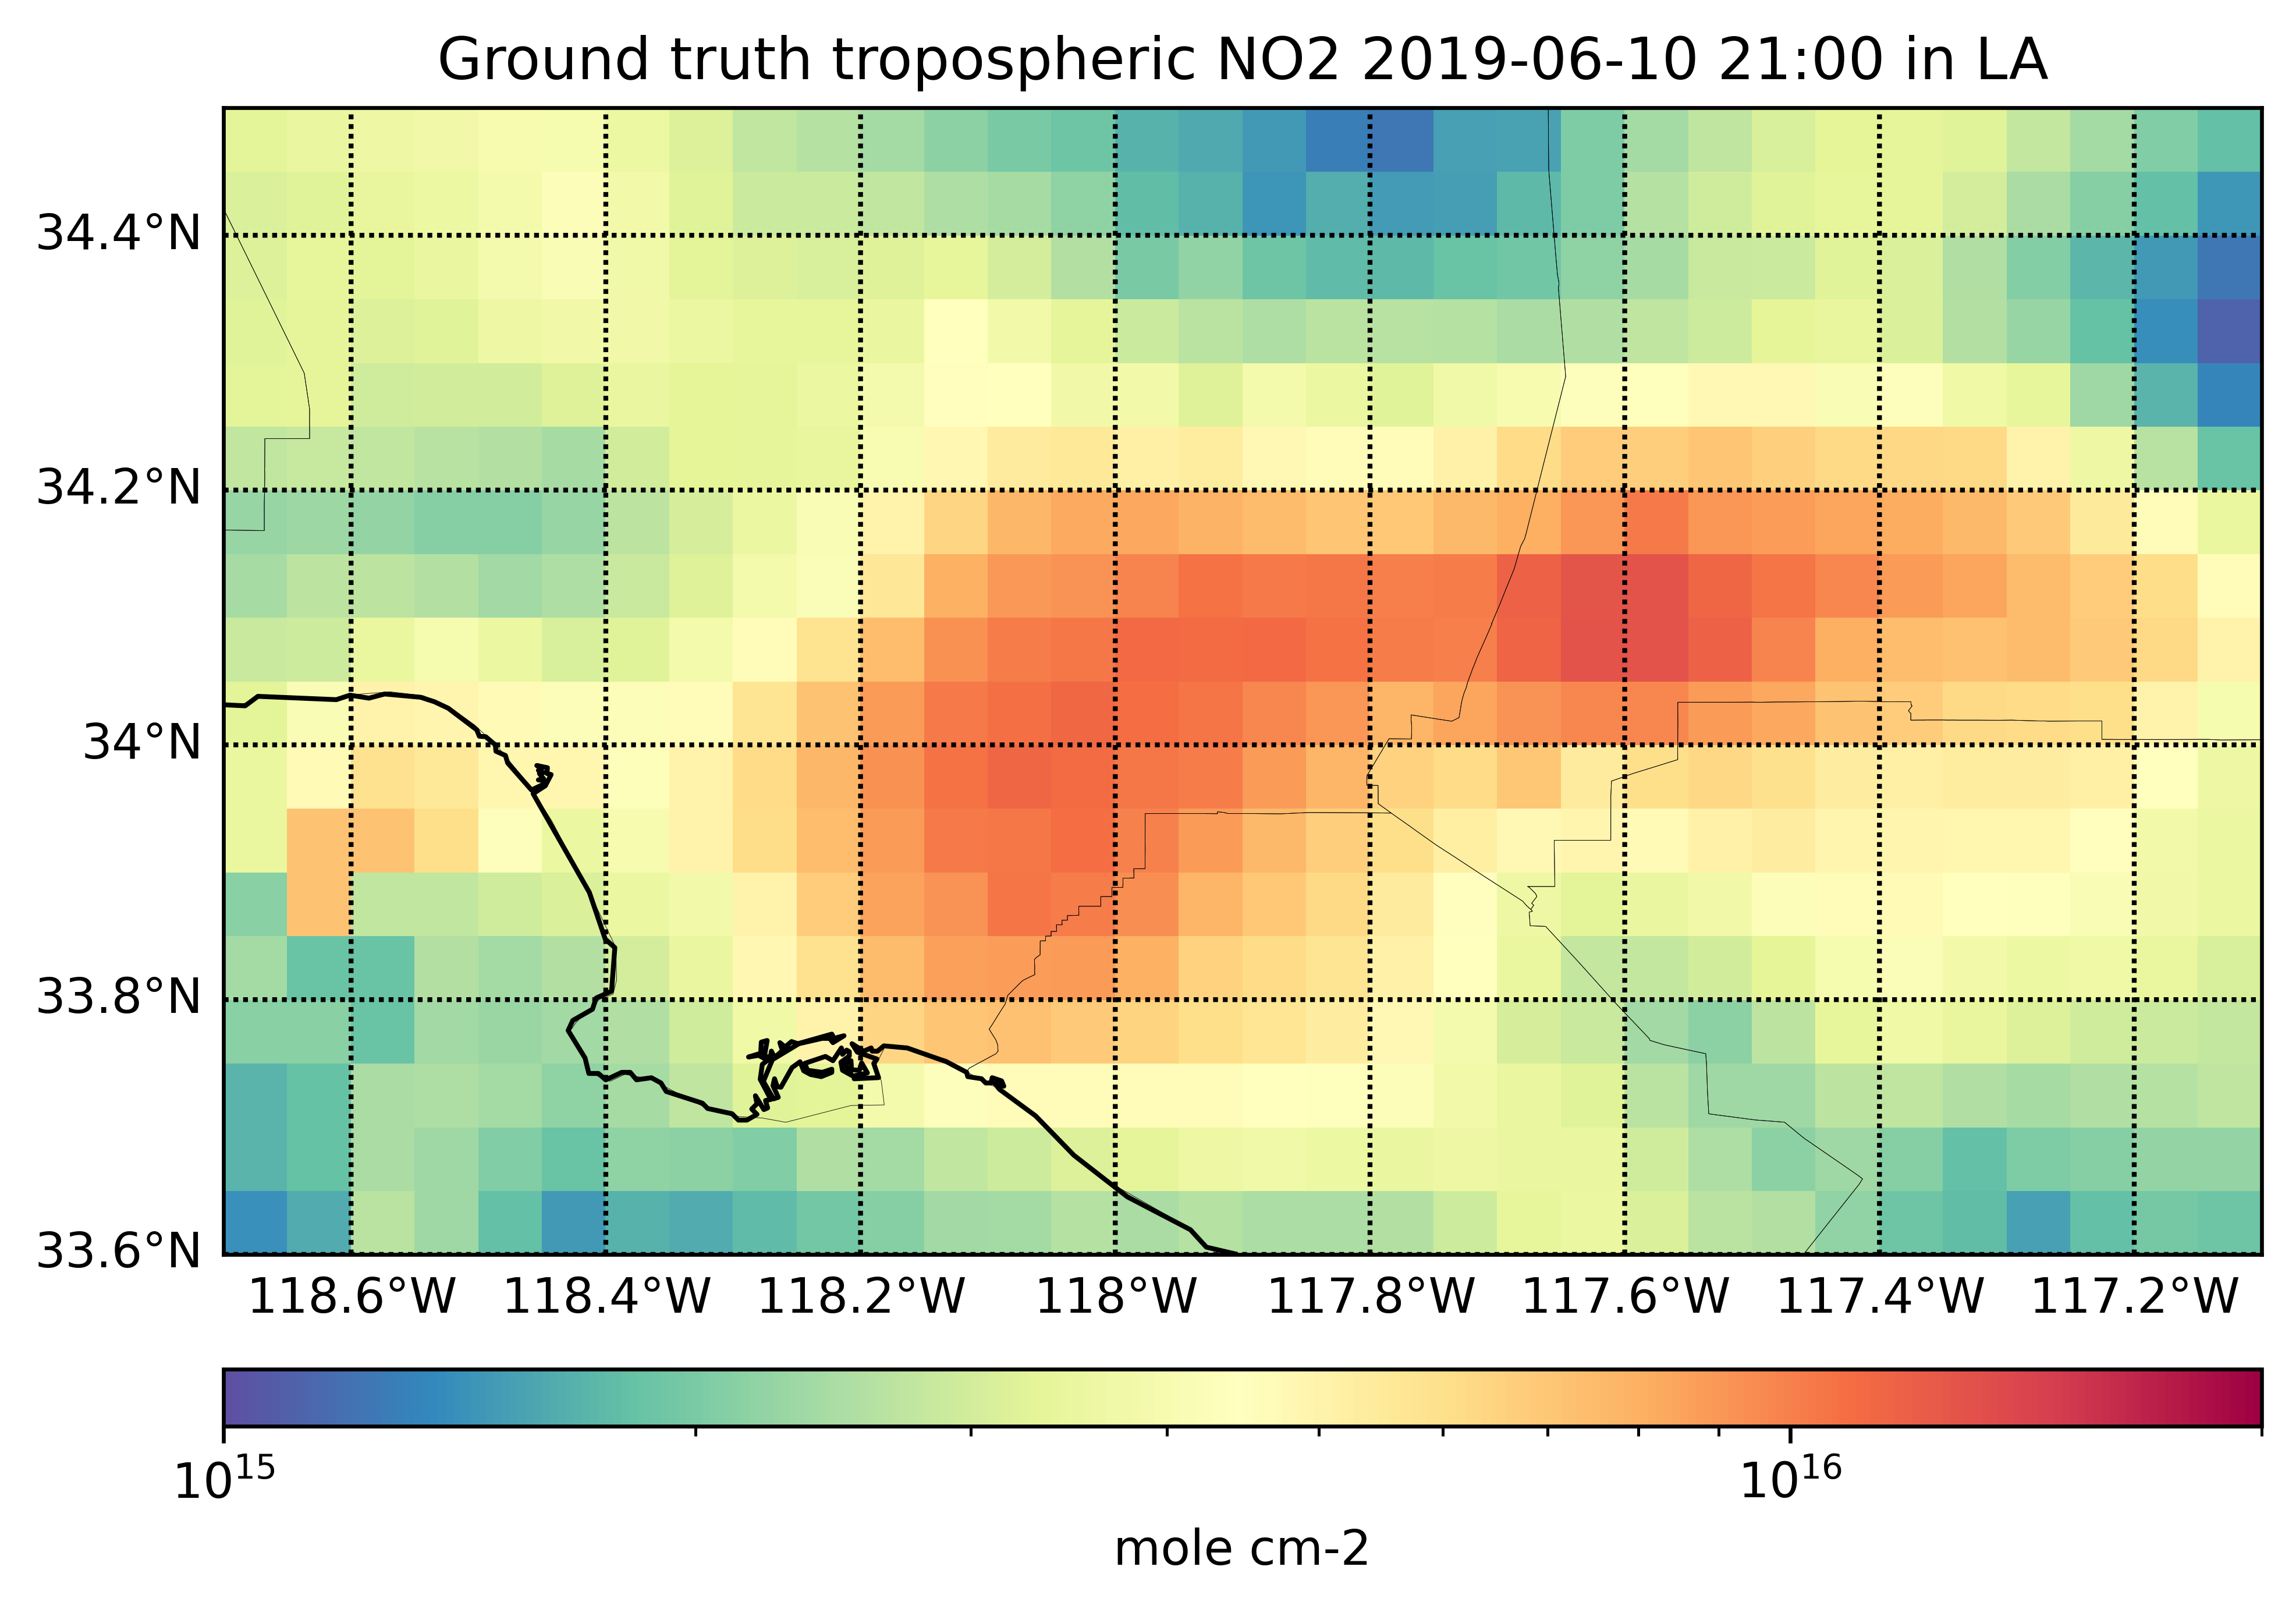

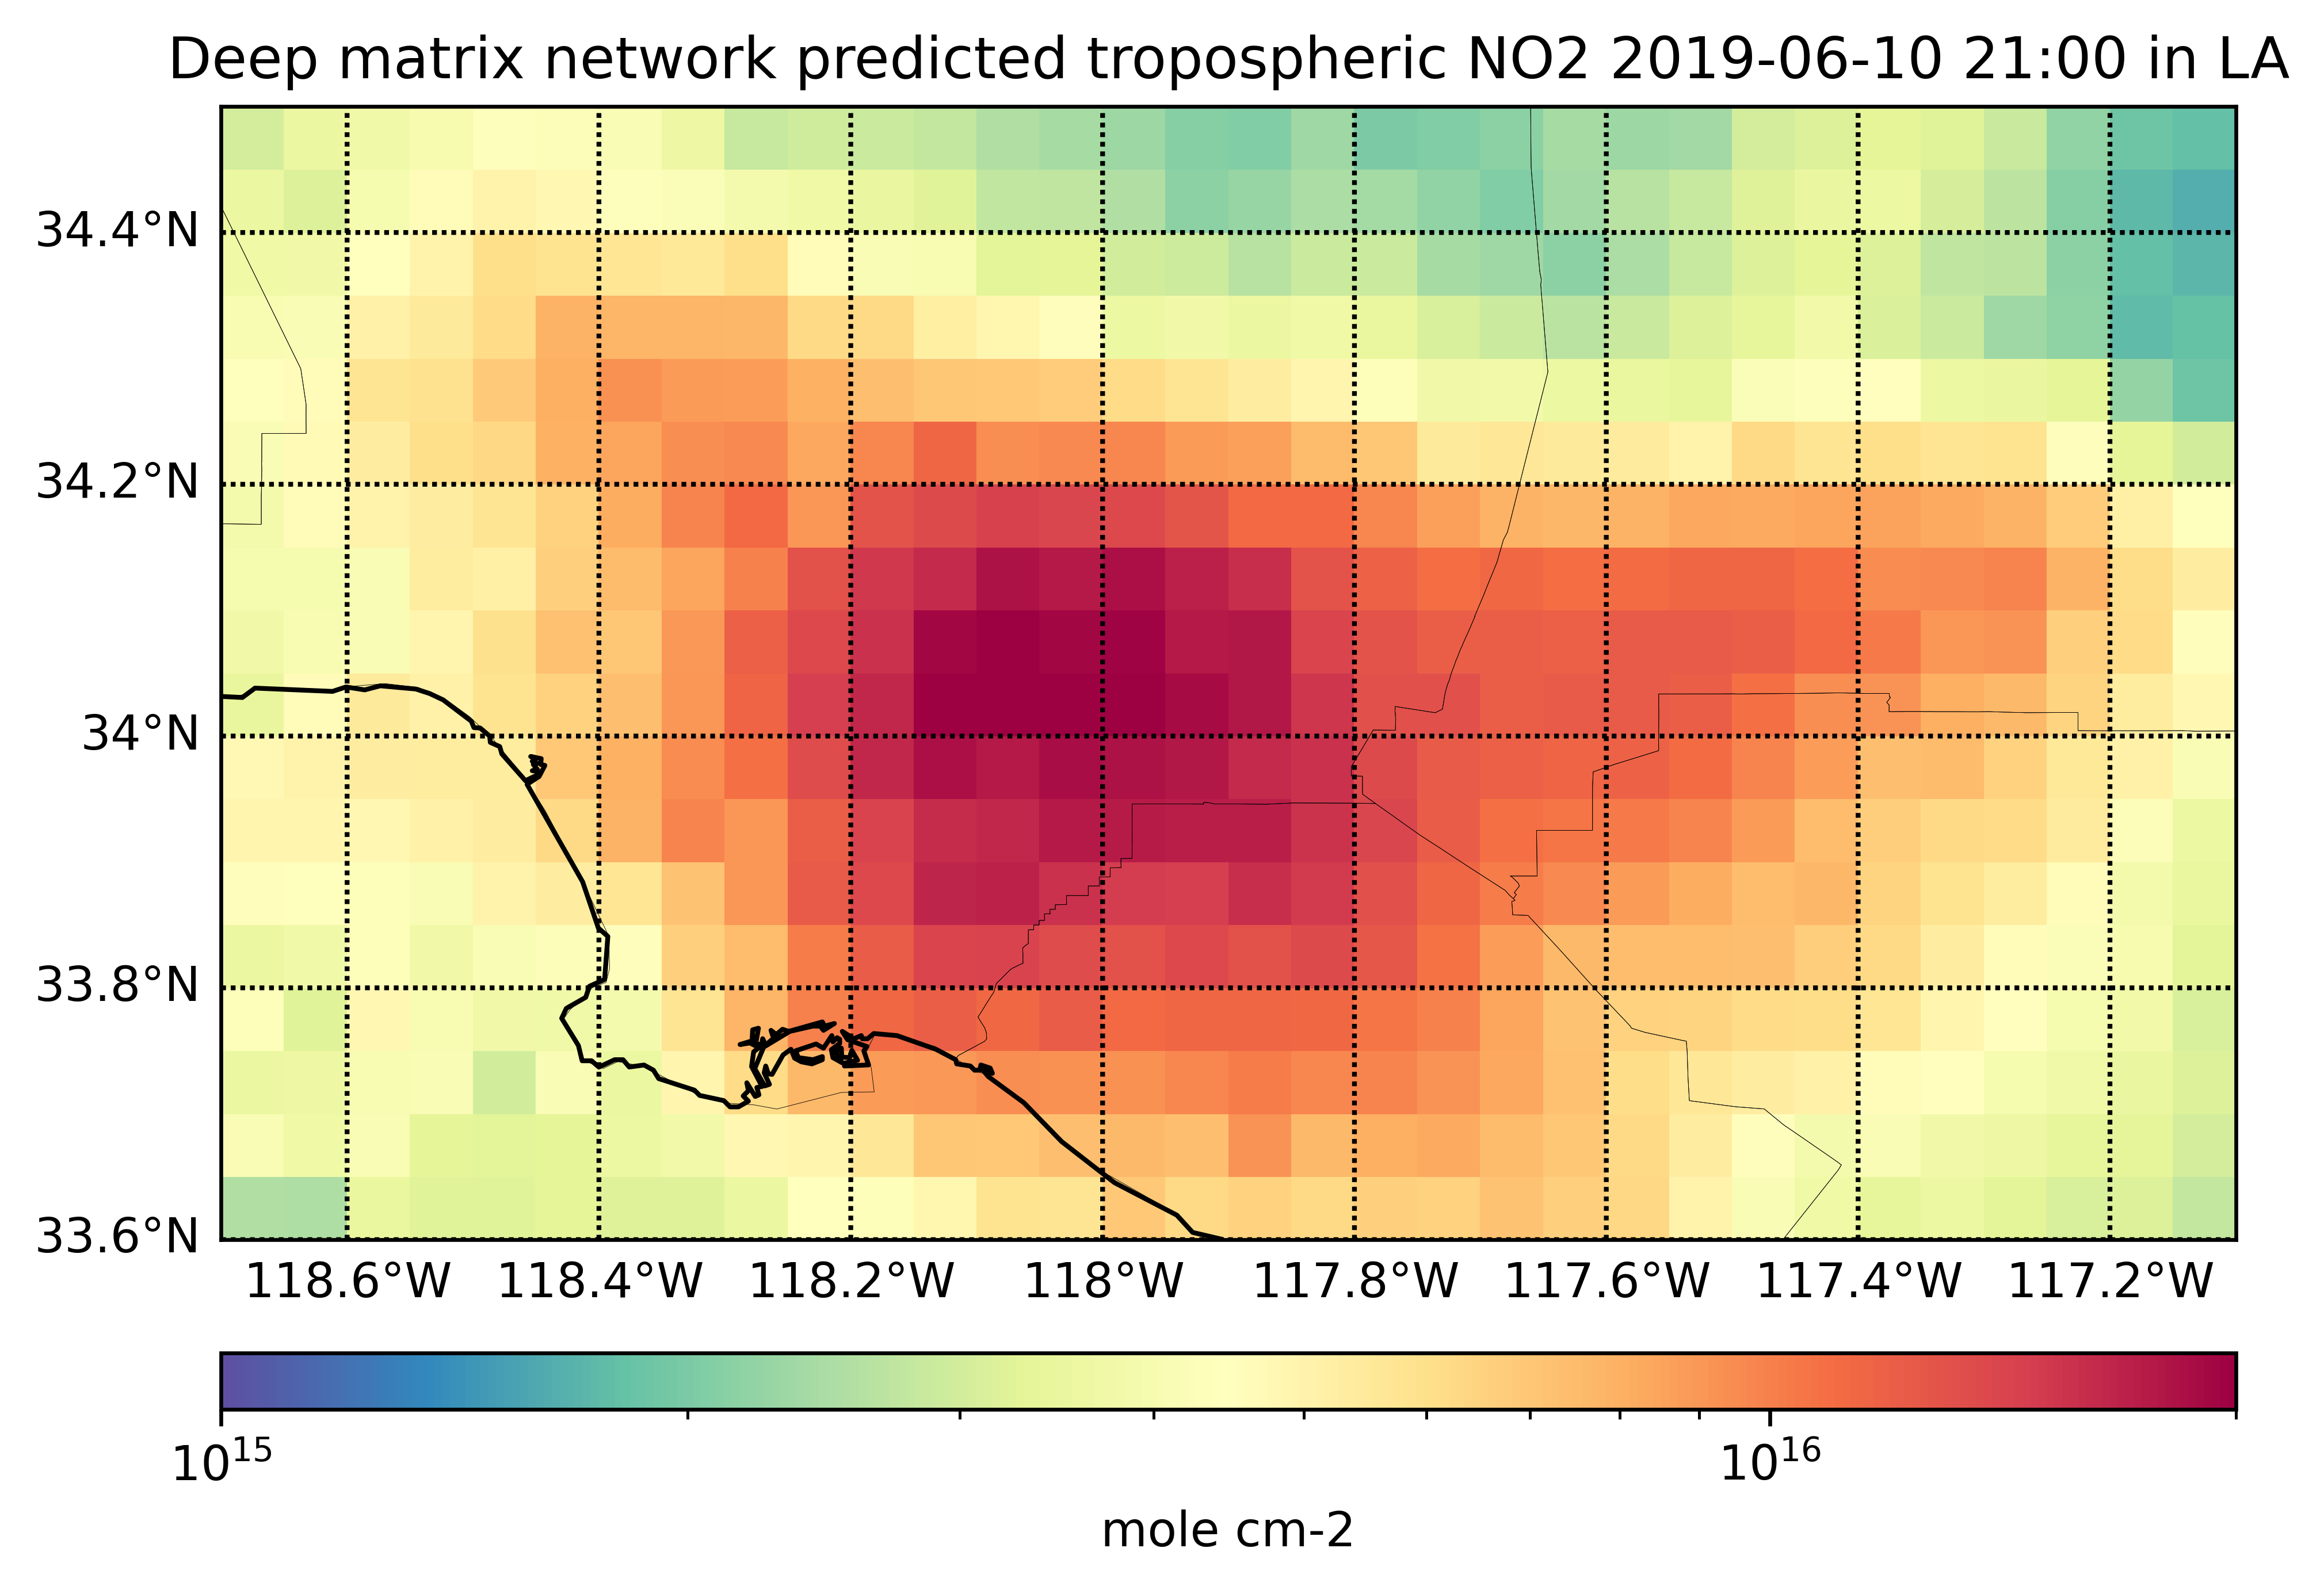

In [22]:
# Plot one week time series
for dt in range(20,27):
#     dt = 262-242
    print(tropomi_np_array[dt+242,0])
    
    datetime_str = str(int(tropomi_np_array[dt+242,0]))
    datetime_str = datetime_str[:4]+'-'+datetime_str[4:6]+'-'+datetime_str[6:8]+' '+datetime_str[8:]+':00'
    
    print('RMSE:', RMSE(features_y_val[dt,:], y_pred[dt,:])/(10**15))
    print('MAE:', MAE(features_y_val[dt,:], y_pred[dt,:])/(10**15))

    ################################################## 2. Plot the prediction ##################################################
    matrix = features_y_val[dt,:].reshape(xxnew.shape)
    
    plt.figure(figsize=(10,5),dpi=600)

    # largler LA region bounding box
    m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
                resolution='h',projection='cyl',\
                lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
    xi, yi = m(xnew, ynew)

    # Plot Data
    sc = m.pcolor(xi,yi,np.squeeze(matrix),norm=LogNorm(), cmap='Spectral_r',vmin=10**15, vmax=2*10**16)

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawcounties()

    # Add Colorbar
    no2_units = 'mole cm-2'
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label(no2_units)
    
    # Add Title
    plt.title('Ground truth tropospheric NO2 '+
              datetime_str
              +' in LA')
    plt.show()

    ################################################## 2. Plot the prediction ##################################################
    matrix = y_pred[dt,:].reshape(xxnew.shape)
    
    plt.figure(figsize=(10,5),dpi=600)

    # largler LA region bounding box
    m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,
                resolution='h',projection='cyl',\
                lat_ts=40,lat_0=34.0522,lon_0=-118.2437)
    xi, yi = m(xnew, ynew)

    # Plot Data
    sc = m.pcolor(xi,yi,np.squeeze(matrix),norm=LogNorm(), cmap='Spectral_r',vmin=10**15, vmax=2*10**16)

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 0.2), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 0.2), labels=[0,0,0,1], fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawcounties()

    # Add Colorbar
    no2_units = 'mole cm-2'
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label(no2_units)

    # Add Title
    plt.title('Deep matrix network predicted tropospheric NO2 '+datetime_str+' in LA')
    plt.show()

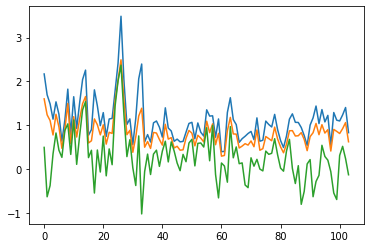

In [37]:
datetime_list, rmse_list, mae_list, difference_list = [], [], [], []

for dt in range(y_pred.shape[0]):
    
    datetime_str = str(int(tropomi_np_array[dt+242,0]))
    datetime_str = datetime_str[:4]+'-'+datetime_str[4:6]+'-'+datetime_str[6:8]
    datetime_list.append(datetime_str)
    
    y_pred_subset = y_pred[dt,:]
    y_test_subset = features_y_val[dt,:]
    
    rmse_list.append(RMSE(y_test_subset, y_pred_subset)/(10**15))
    mae_list.append(MAE(y_test_subset, y_pred_subset)/(10**15))
    difference_list.append((y_pred_subset- y_test_subset).mean()/(10**15))

rmse_array = np.array(rmse_list)
mae_array = np.array(mae_list)
difference_array = np.array(difference_list)

plt.plot(rmse_array)
plt.plot(mae_array)
plt.plot(difference_array)

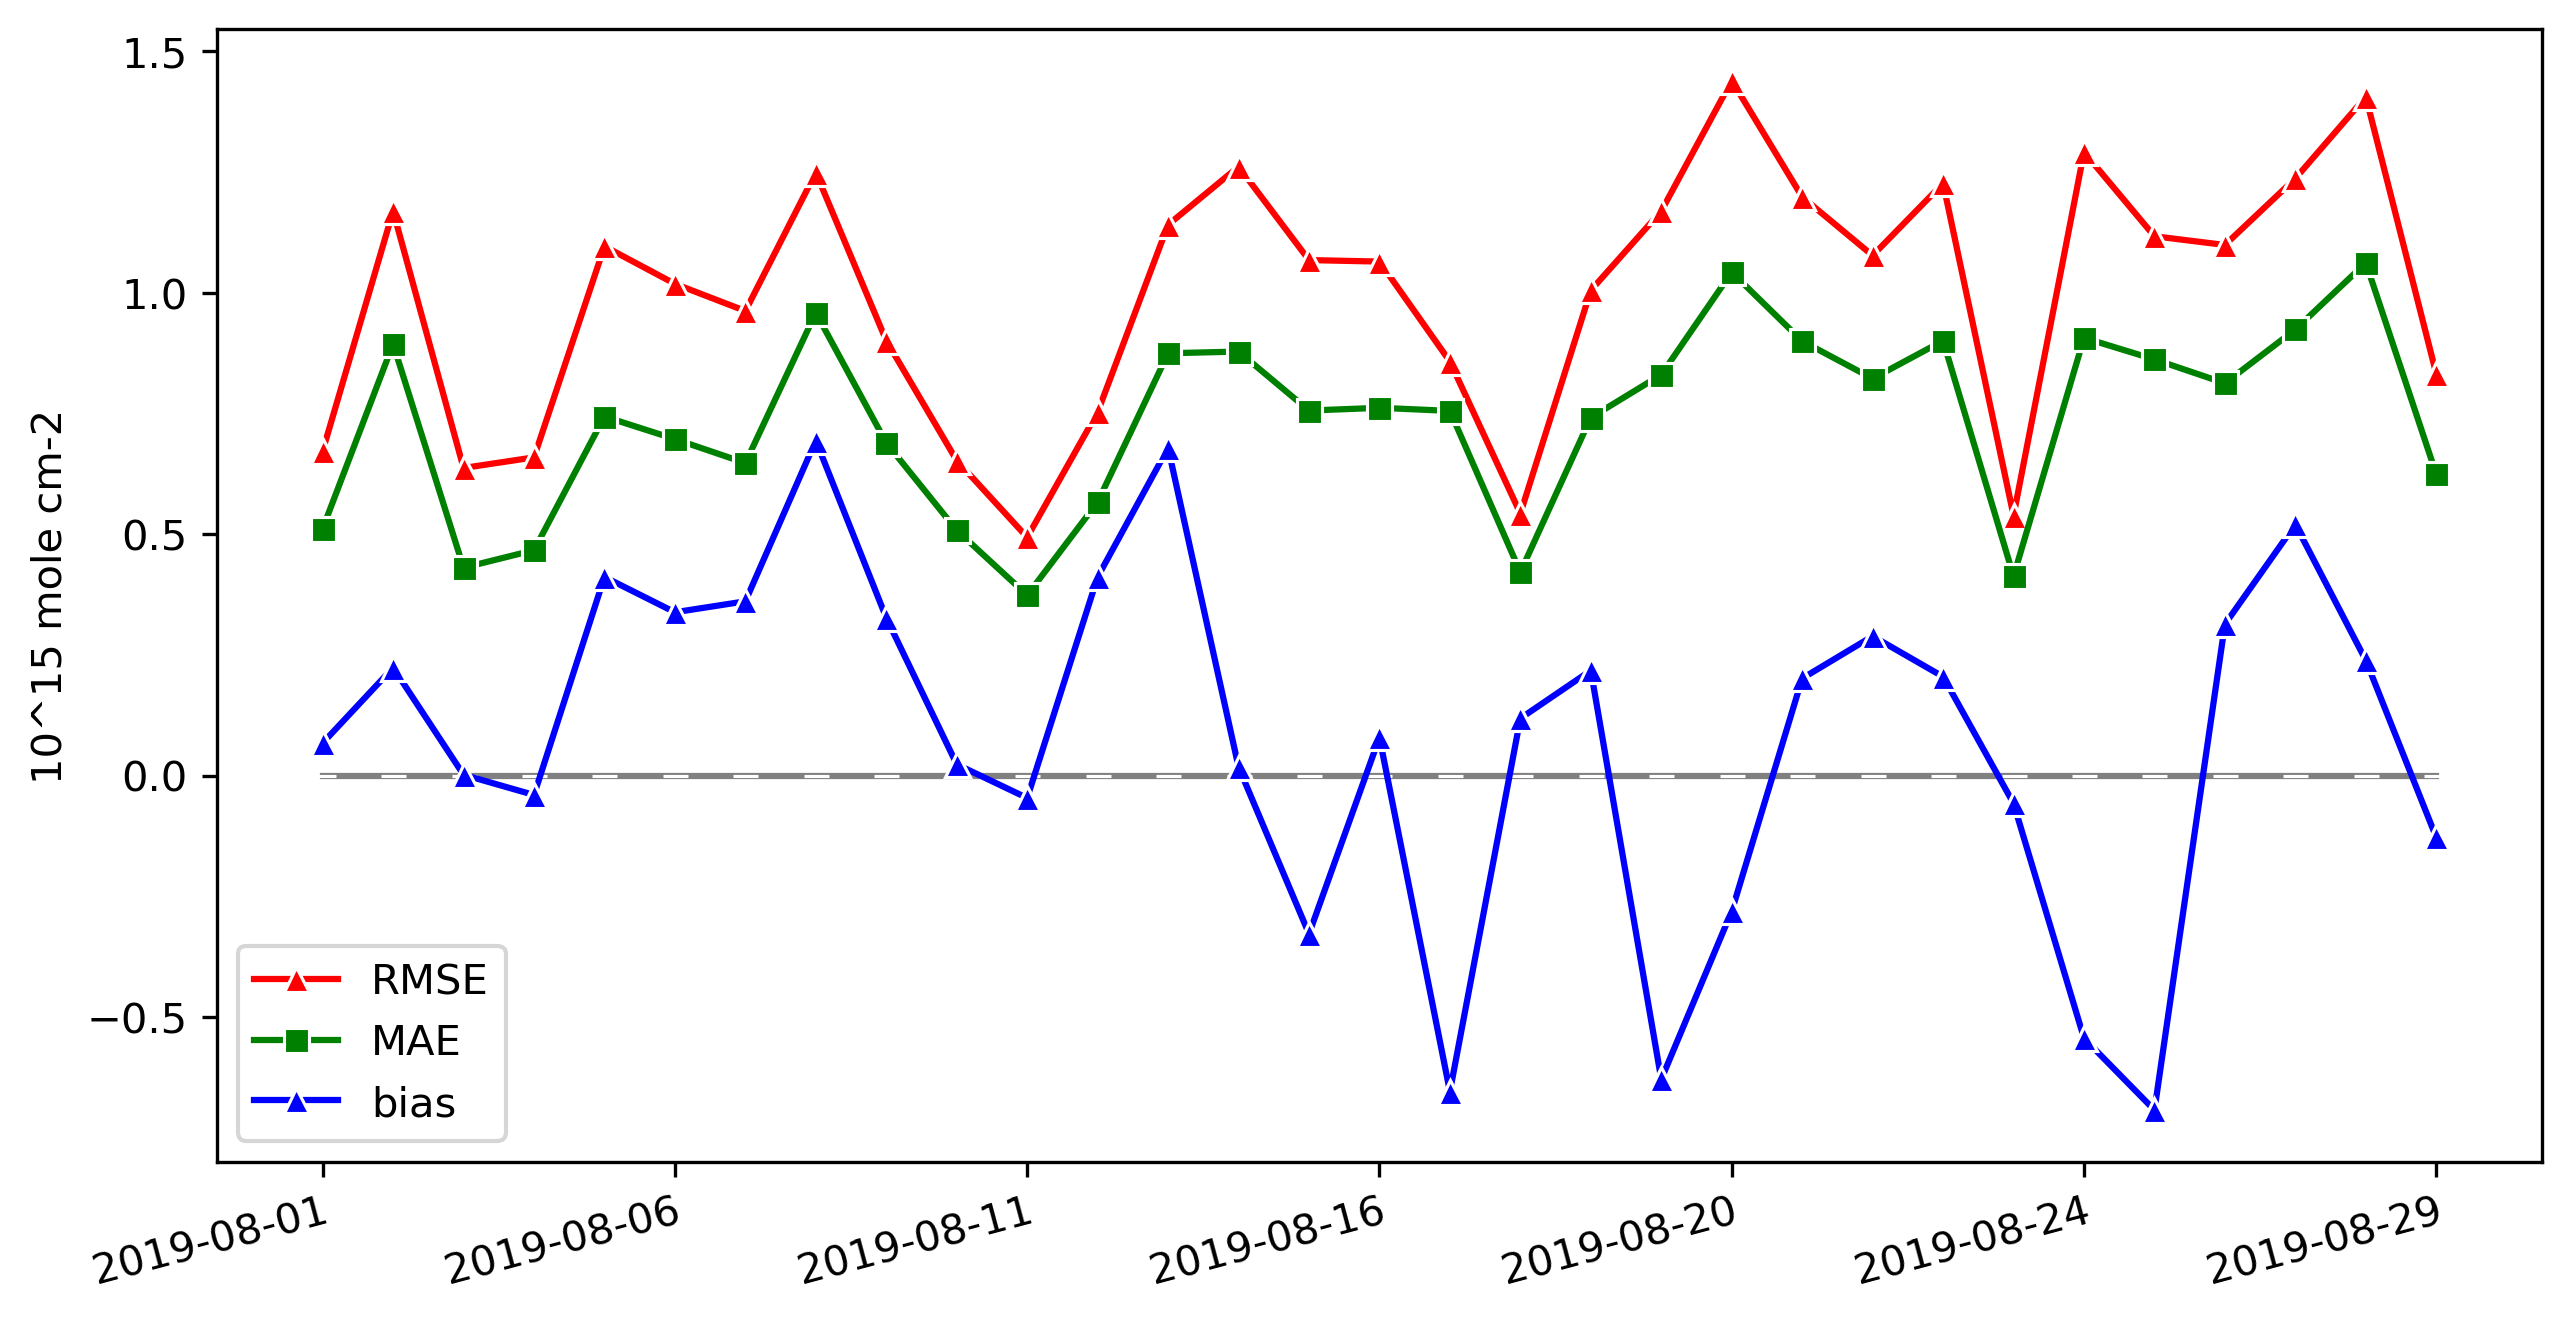

In [72]:
import seaborn as sns
# create lineplot
fig, axs = plt.subplots(1, 1,figsize=(10,5), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

sns.lineplot(x=datetime_list[-33:], y=0, marker = '_', color='grey', ci=None)

sns.lineplot(x=datetime_list[-33:], y=rmse_array[-33:], label='RMSE', marker='^',color='r', ci=None)
sns.lineplot(x=datetime_list[-33:], y=mae_array[-33:], label='MAE',marker='s',color='g', ci=None)
sns.lineplot(x=datetime_list[-33:], y=difference_array[-33:], label='bias',  marker='^', color='b', ci=None)

axs.set_ylabel('10^15 mole cm-2'); 

# axs.set_xlabel('Missing data ratio')
axs.set_xticks(range(0, len(datetime_list[-33:]), 5))

ticklabels = []
for i in range(0, len(datetime_list[-33:]), 5):
#     if i//10==1 or i == 0:
    ticklabels.append(datetime_list[-33:][i])
#     else:
#         ticklabels.append(' ')

axs.set_xticklabels(ticklabels)

# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(), rotation=15, ha="right",
         rotation_mode="anchor")

plt.show()

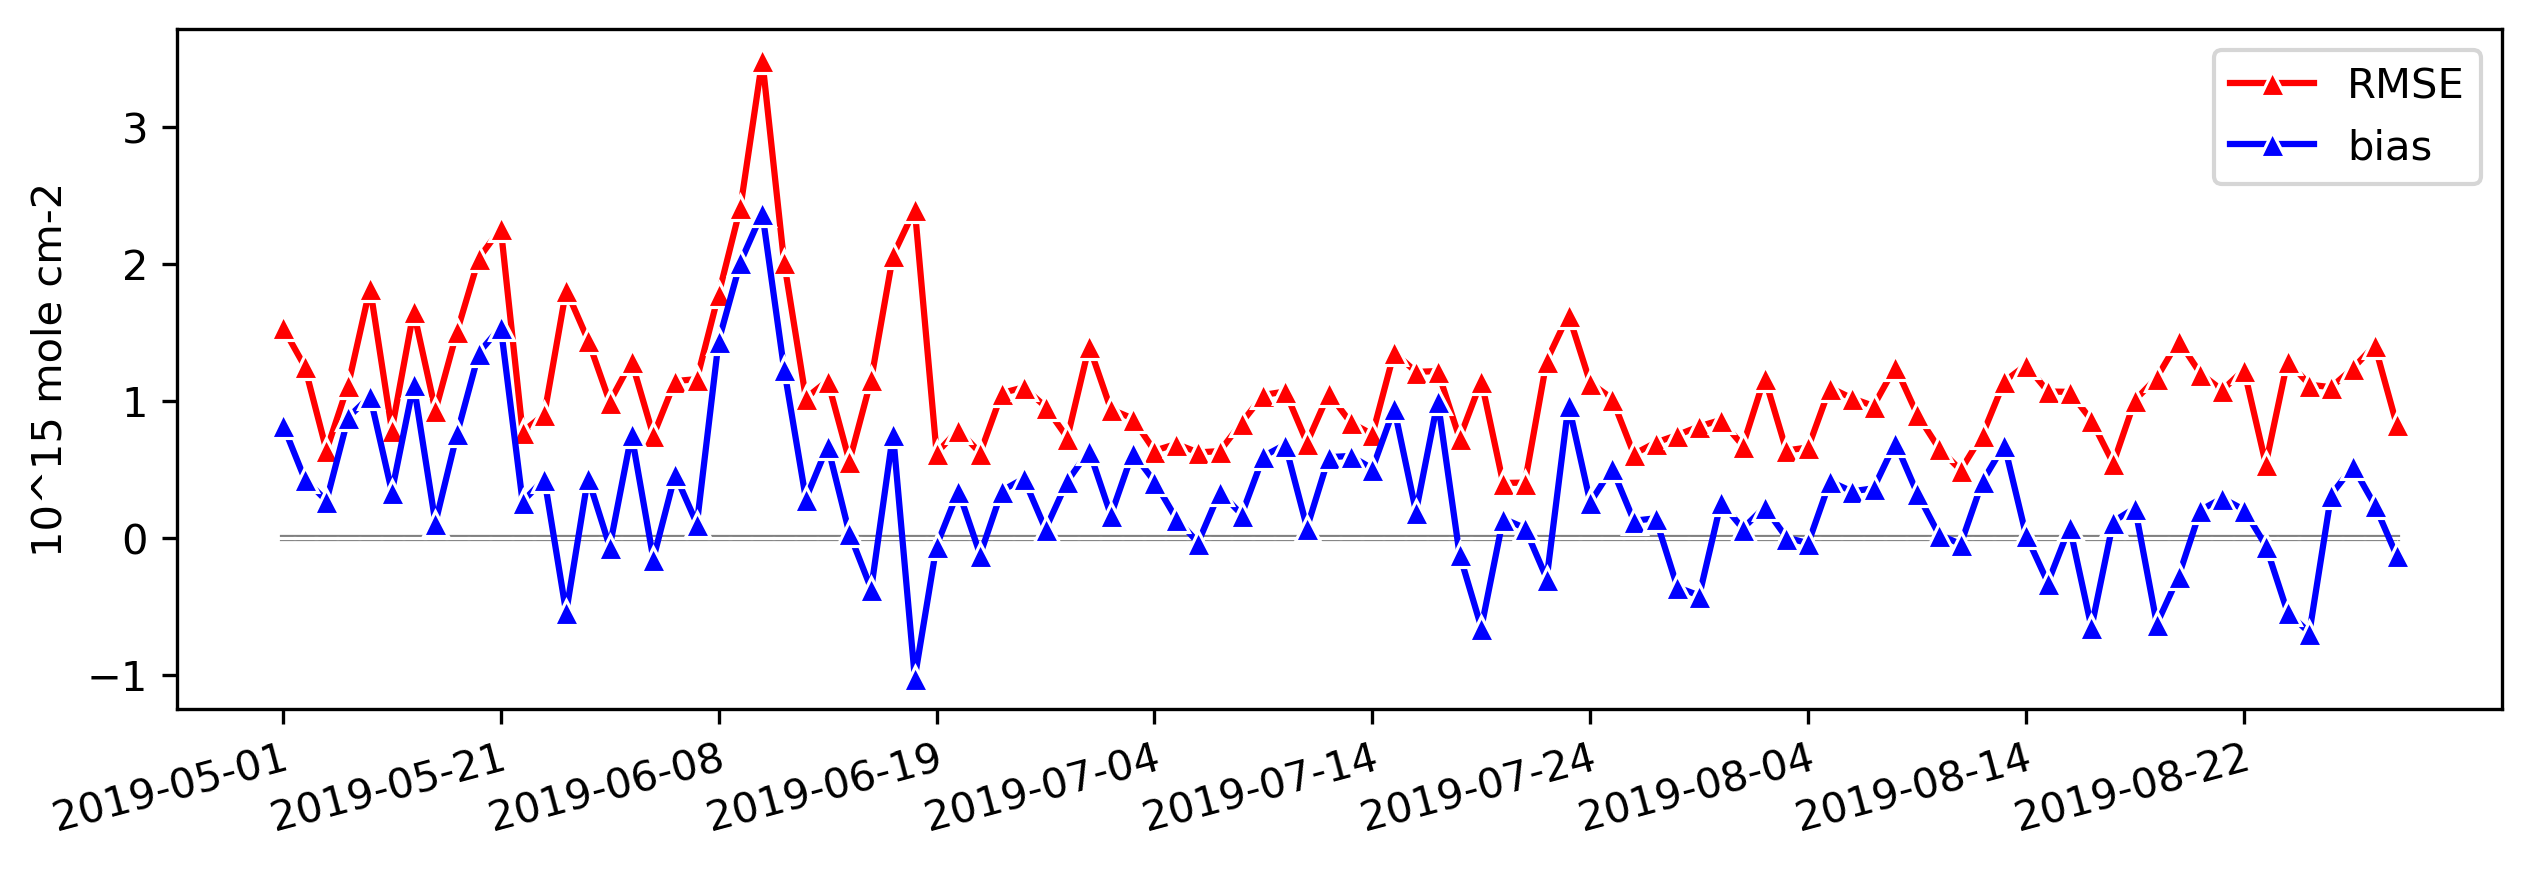

In [82]:
import seaborn as sns
# create lineplot
fig, axs = plt.subplots(1, 1,figsize=(10,3), dpi=300)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

sns.lineplot(x=datetime_list[4:], y=0, marker = '_', color='grey', ci=None)

sns.lineplot(x=datetime_list[4:], y=rmse_array[4:], label='RMSE', marker='^',color='r', ci=None)
# sns.lineplot(x=datetime_list[4:], y=mae_array[4:], label='MAE',marker='s',color='g', ci=None)
sns.lineplot(x=datetime_list[4:], y=difference_array[4:], label='bias',  marker='^', color='b', ci=None)

axs.set_ylabel('10^15 mole cm-2'); 

# axs.set_xlabel('Missing data ratio')
axs.set_xticks(range(0, len(datetime_list[4:]), 10))

ticklabels = []
for i in range(0, len(datetime_list[4:]), 10):
    ticklabels.append(datetime_list[4:][i])

axs.set_xticklabels(ticklabels)

# Rotate the tick labels and set their alignment.
plt.setp(axs.get_xticklabels(), rotation=15, ha="right",
         rotation_mode="anchor")

plt.show()

In [80]:
np.save('datetime_list',datetime_list[4:])